In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation
from JSAnimation.IPython_display import display_animation
import math
import itertools as itool

class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)
    
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half  


class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc): 
        self.N = N
        self.lx = ly
        self.ly = lx
        self.dt = dt
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5
        self.bc = bc
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2()) # we create a list of N particles

    def init(self, config, vmax):
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(N*float(self.ly)/float(self.lx)));
        ncols = int(math.sqrt(N*float(self.lx)/float(self.ly)));
        ax = float(lx) / float(ncols);
        ay = float(ly) / float(nrows);
        i = 0;

        if config == StartConf.Triangular:
            #Challenge
            return
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2
                self.particles[i].y = row*ay+ay/2
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax/2.+ax/2.
                self.particles[i].y = row*ay/2.+ay/2.
                i+=1
                
        elif config == StartConf.Confined:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax+ax/2.)/2.
                self.particles[i].y = (row*ay+ay/2.)
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax/2.+ax/2.)/2.
                self.particles[i].y = (row*ay/2.+ay/2.)
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(seld.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;
            
        self.forces()          
        
    def evolve(self):
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)

        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):
        dx = other.x - p.x;
        dy = other.y - p.y;
        # nearest image convention
        if self.bc == BoundaryCondition.PBC:
            if abs(dx) > self.lx/2:
                dx -= dx*lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*ly/abs(dy)
        
        r12 = dx * dx + dy * dy
        return (r12, dx, dy)

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)
        r2 = 1./r12
        r6 = r2 * r2 * r2
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly
#            c = (p.x+2*self.lx)/self.lx
#            p.x = p.x + 2*self.lx - int(c)*self.lx
#            c = (p.y+2*self.ly)/self.ly
#            p.y = p.y + 2*self.ly - int(c)*self.ly
            
    def Calc_KE(self):
        ke=0
        for p in self.particles:
            ke +=.5*p.mass*(p.vx**2+p.vy**2)
        return ke
    
    def Calc_PE(self):
        pe = 0. #assuming Lenard-Jones
        #for p1 in self.particles:
            #for p2 in self.particles:
        for i in range(self.N):
            p1=self.particles[i]
            for j in range(i+1, self.N):
                p2=self.particles[j]
                (r12,dx,dy) = self.distance2(p1, p2)
                if (r12!=0.):
                    u2 = 1./r12
                    u6 = u2 * u2 * u2
                    pe += 4.*u6*(1-u6)
        return pe
    
    
    def total_energy(self):
        return self.kinetic_energy()+self.pot_energy()
    
    def NumInArea(self, ymin, ymax, xmin, xmax):
        count=0
        for p in self.particles:
            #print p.y
            #print p.x
            if p.y>ymin and p.y<ymax:
                if p.x>xmin and p.x<xmax:
                    count=count+1
                   
        return count
        
    


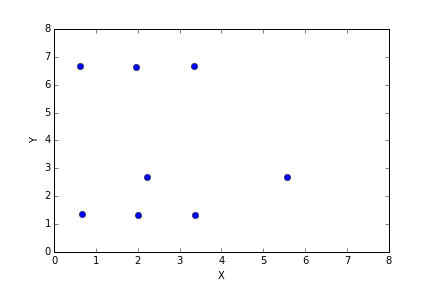
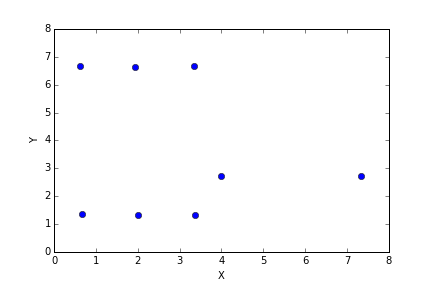
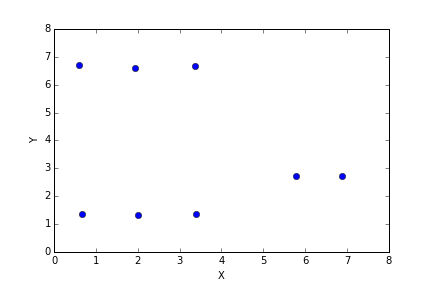
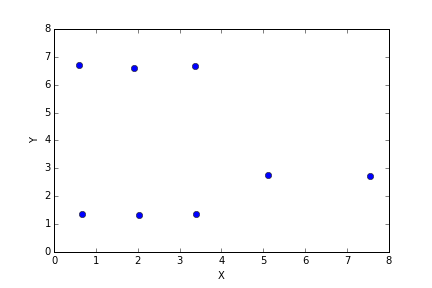
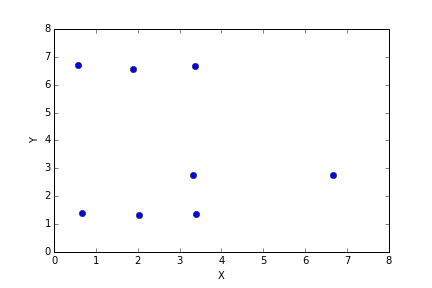
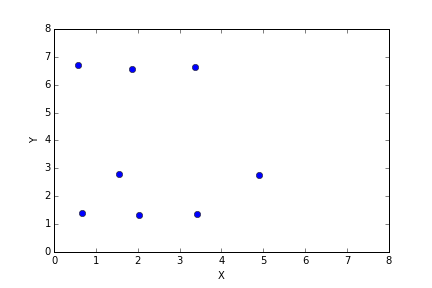
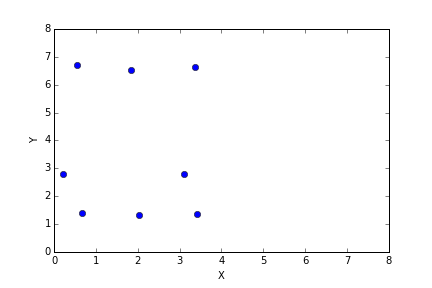
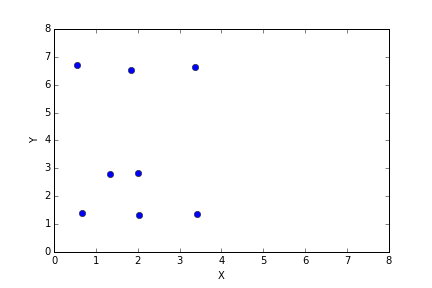
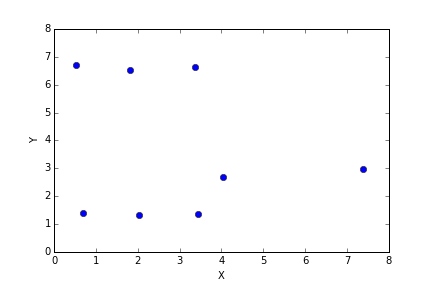
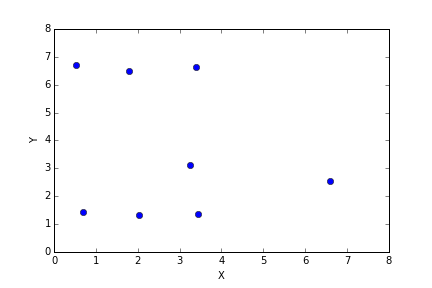
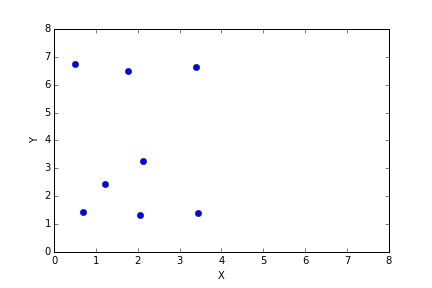
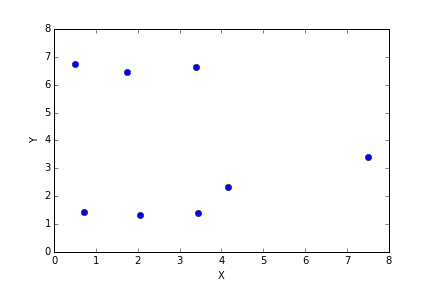
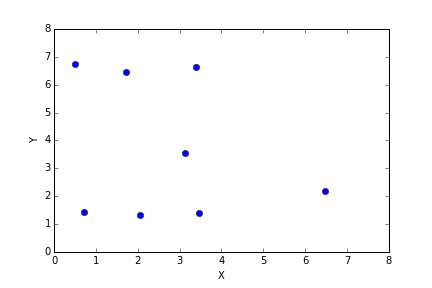
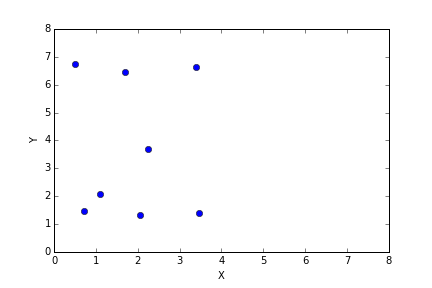
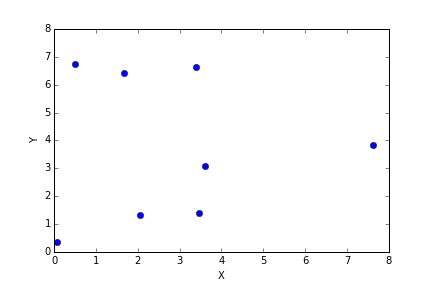
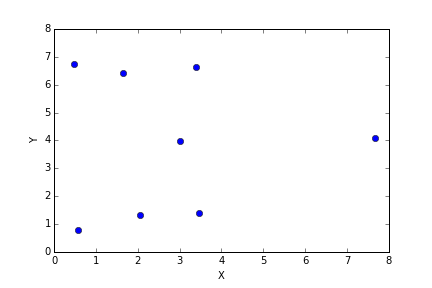
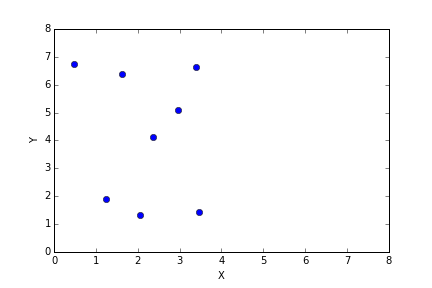
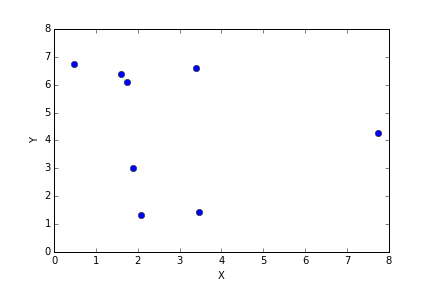
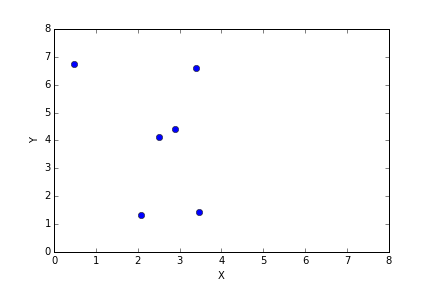
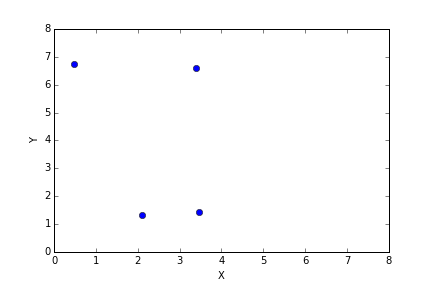
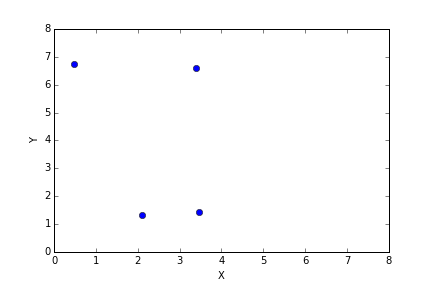
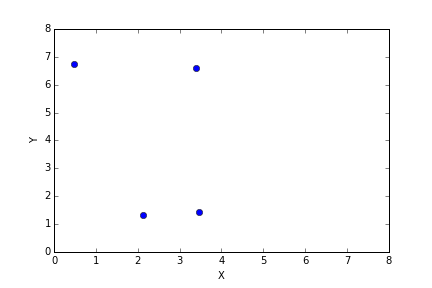
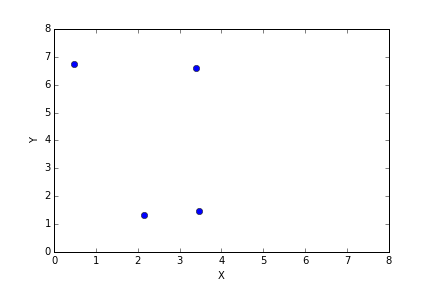
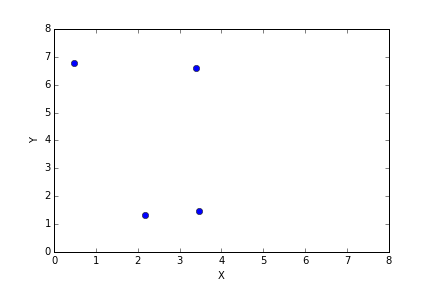
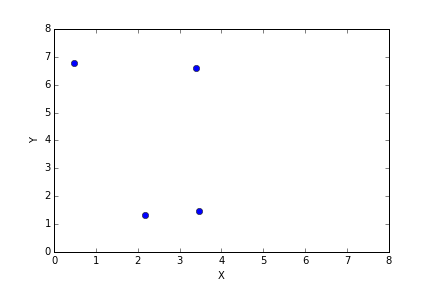
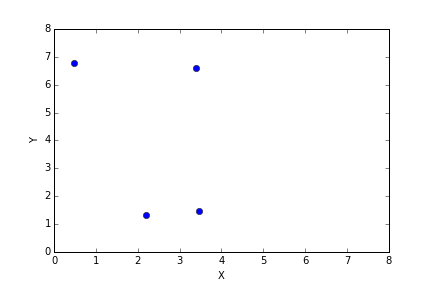
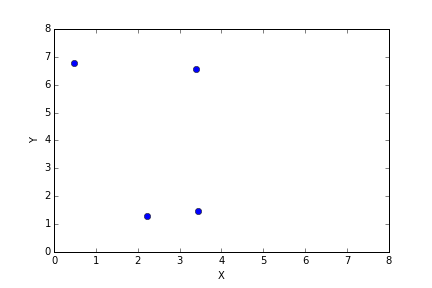
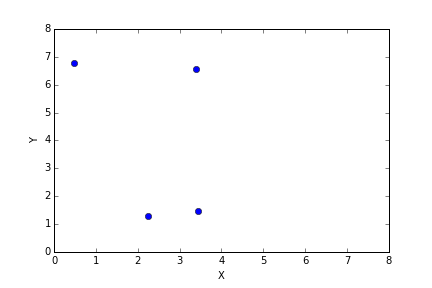
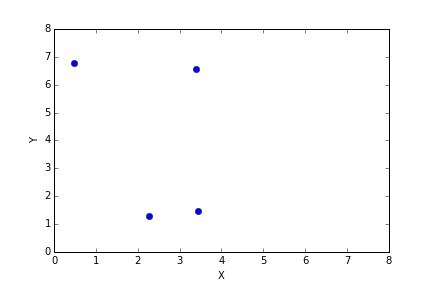
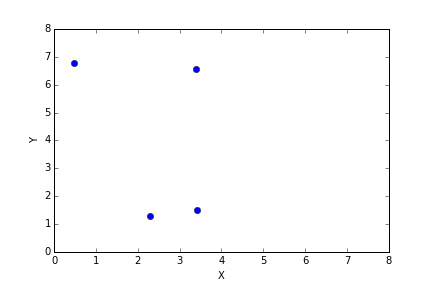
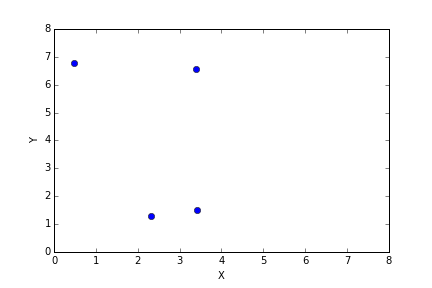
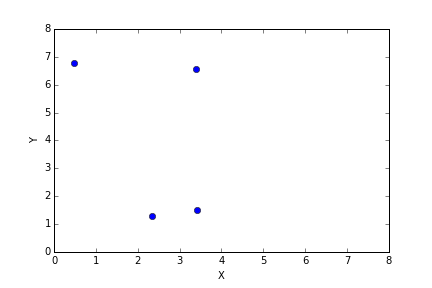
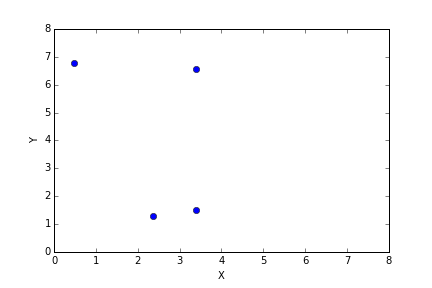
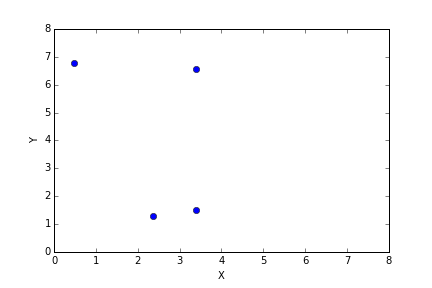
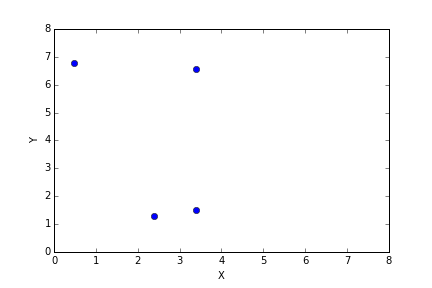
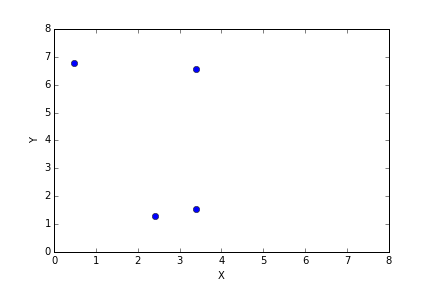
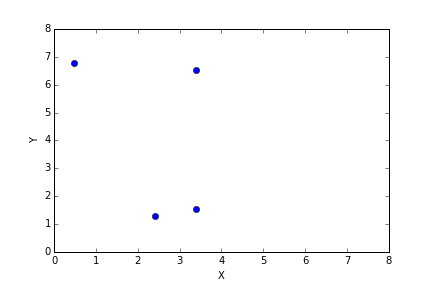
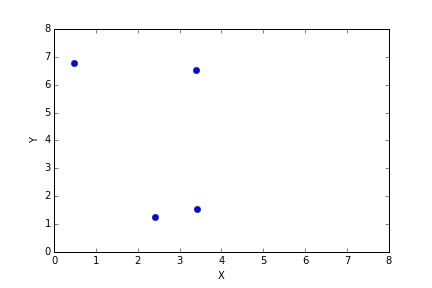
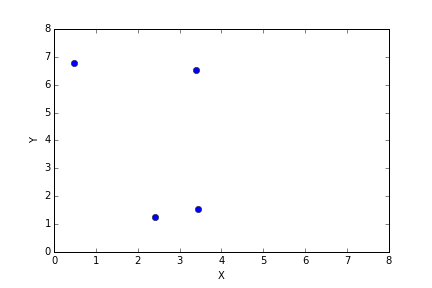
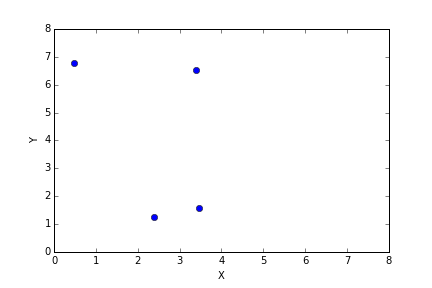
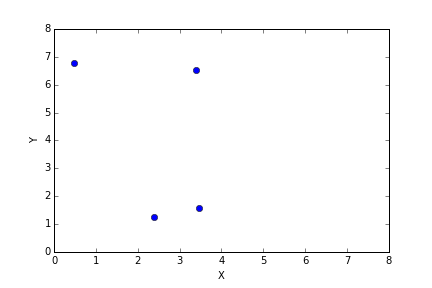
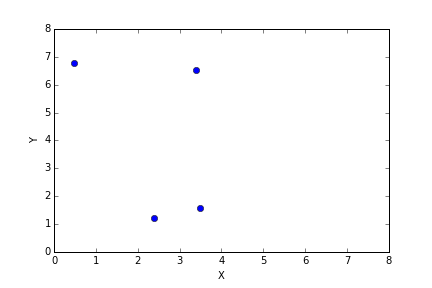
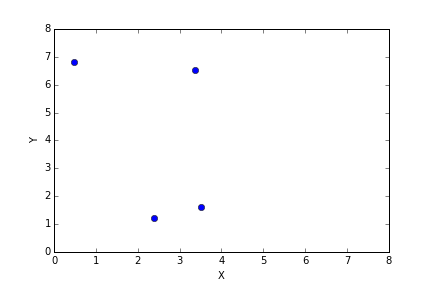
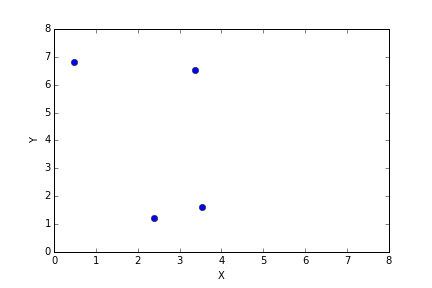
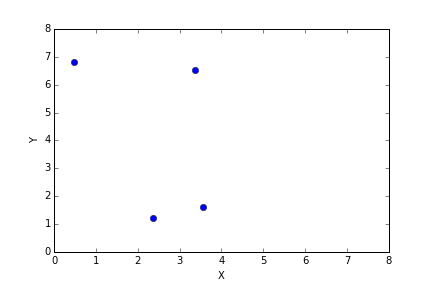
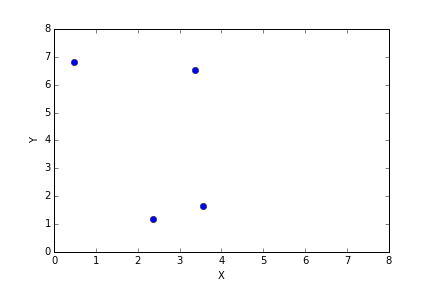
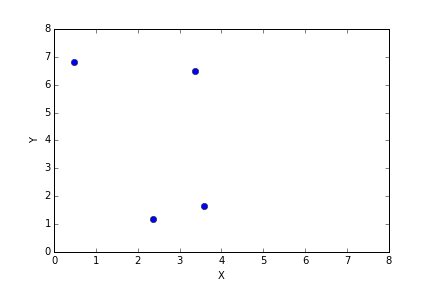
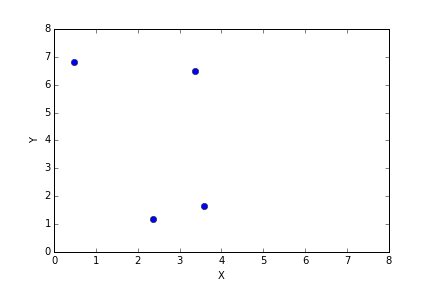
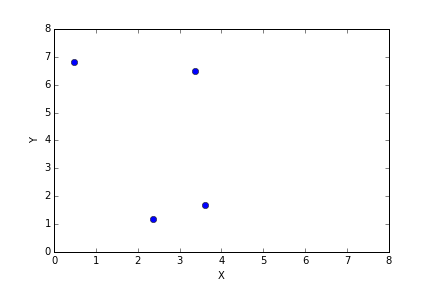
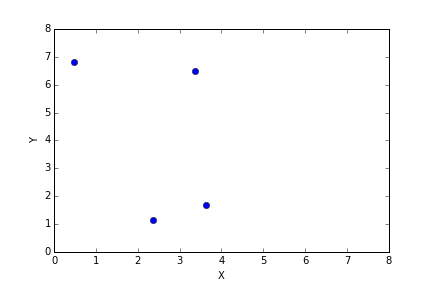
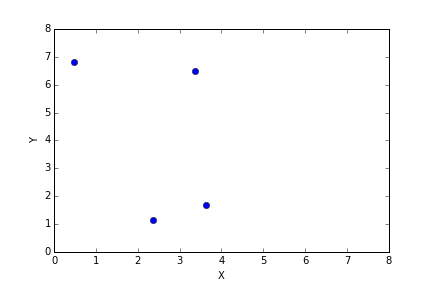
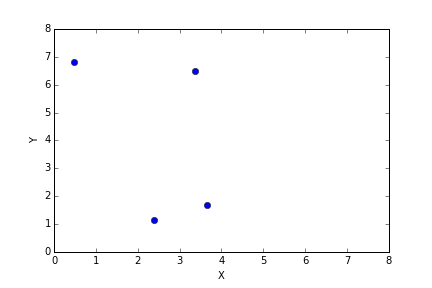
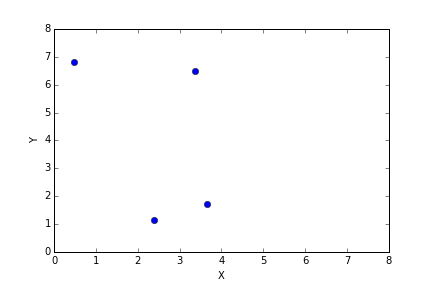
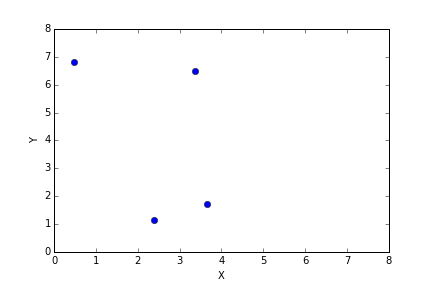
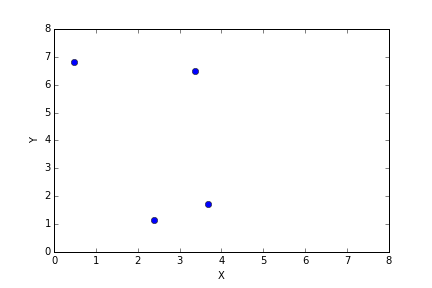
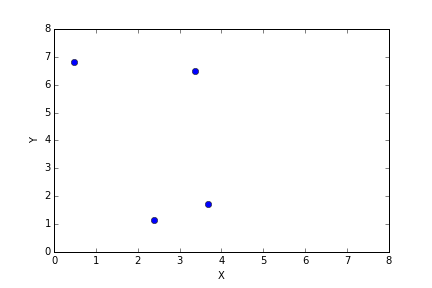
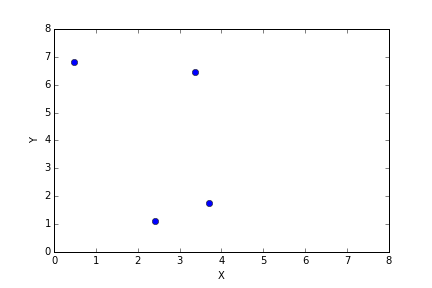
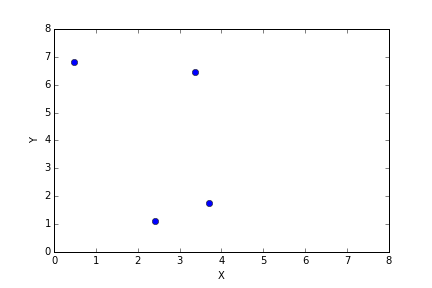
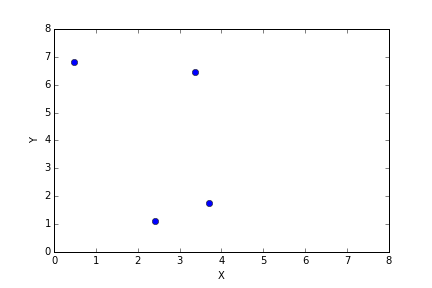
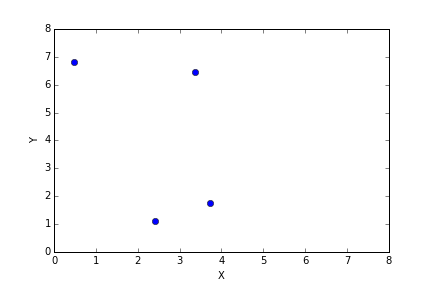
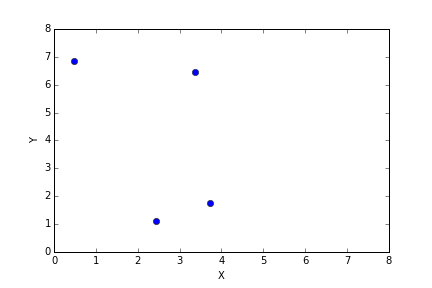
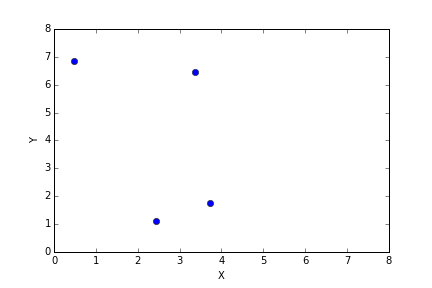
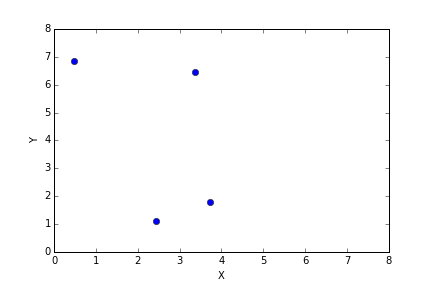
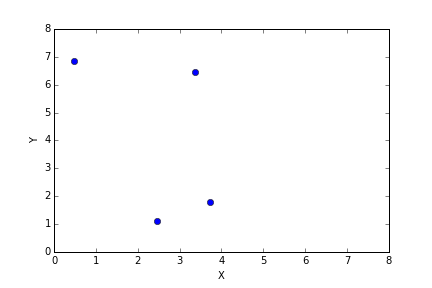
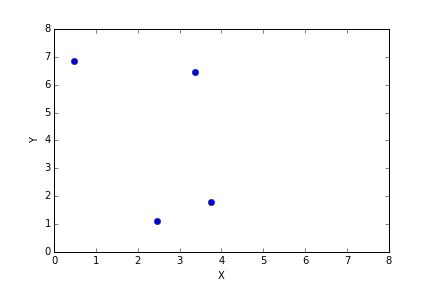
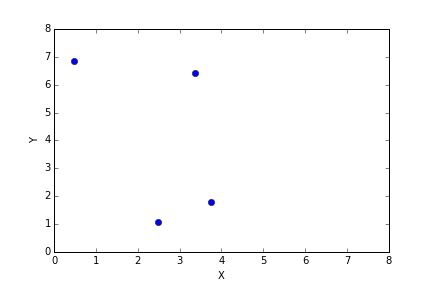
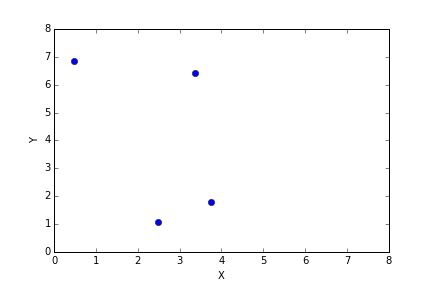
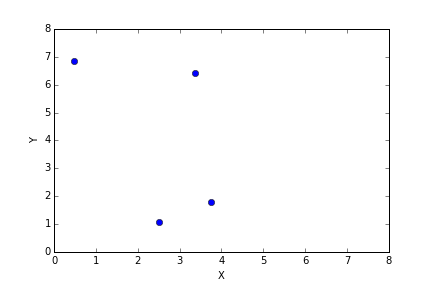
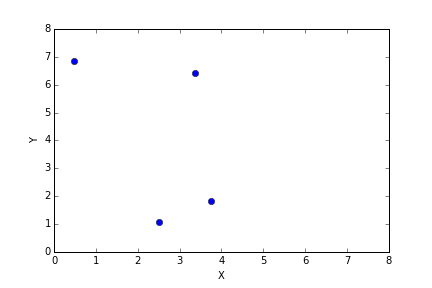
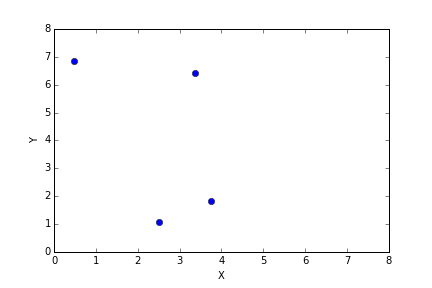
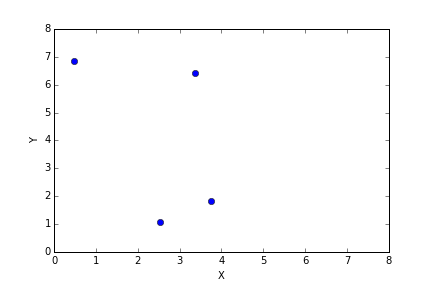
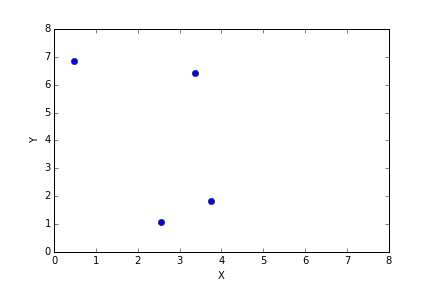
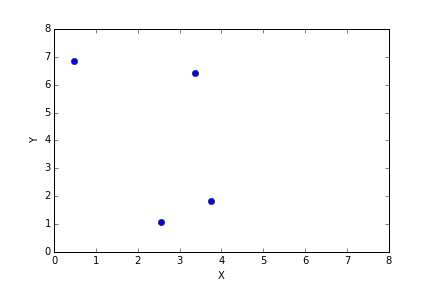
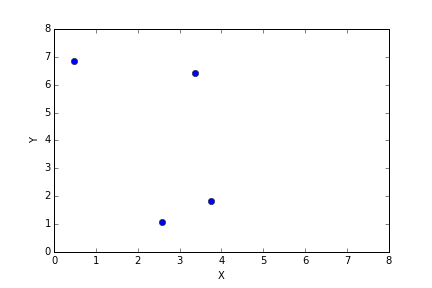
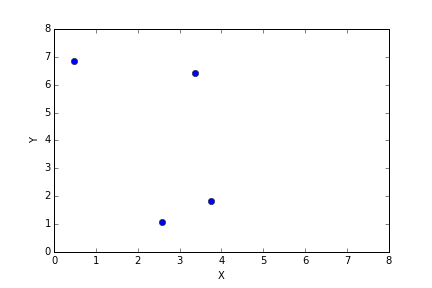
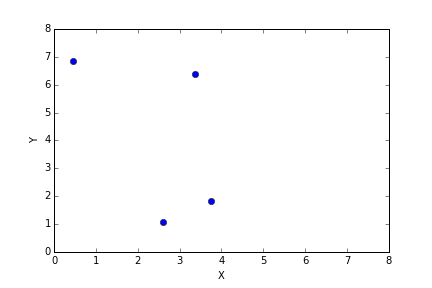
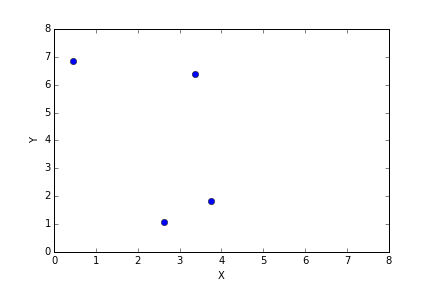
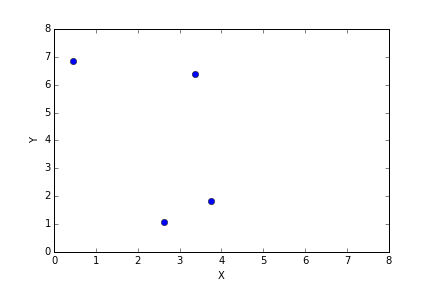
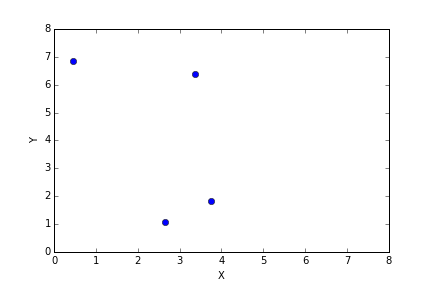
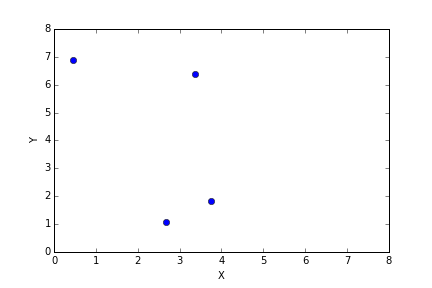
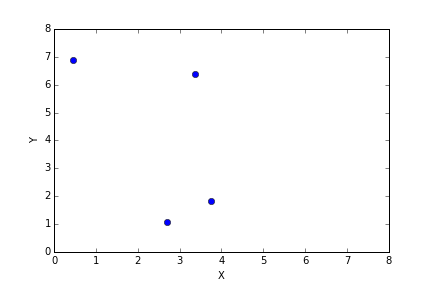
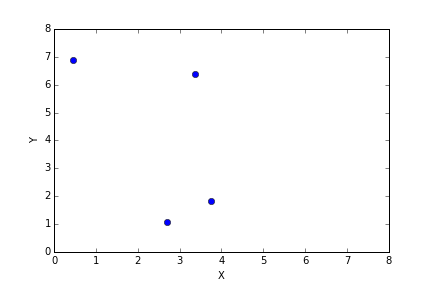
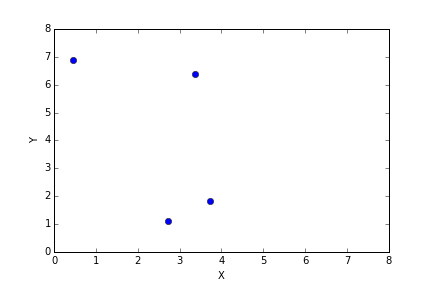
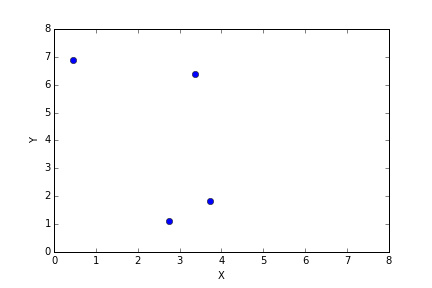
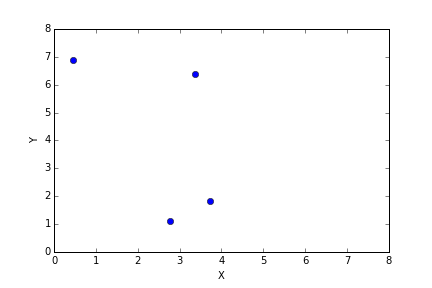
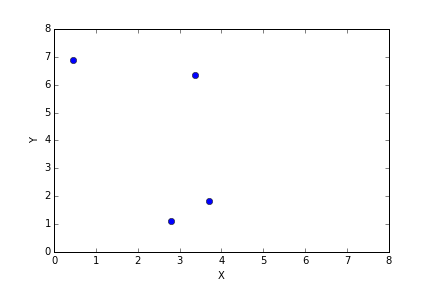
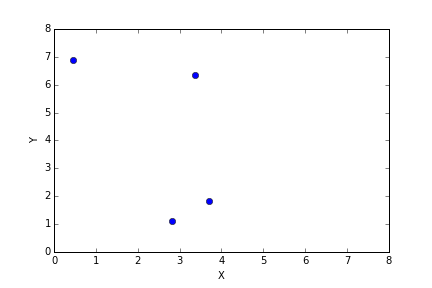
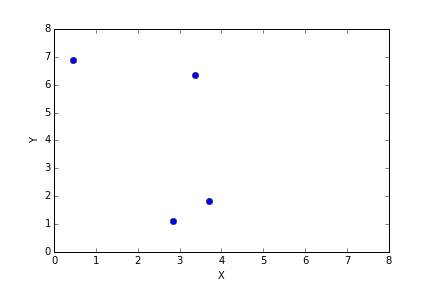
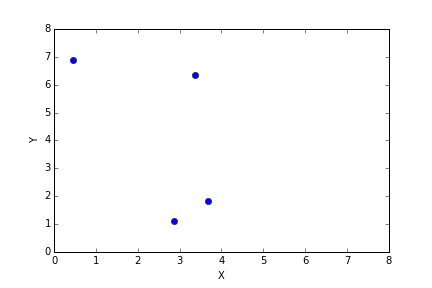
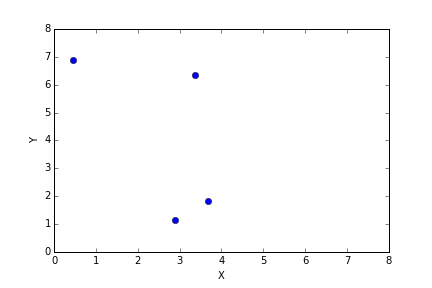
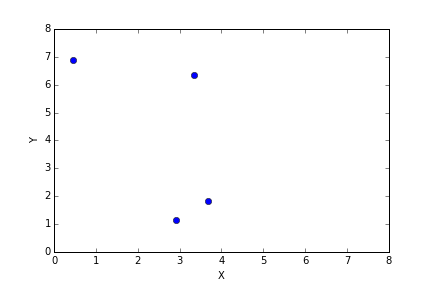
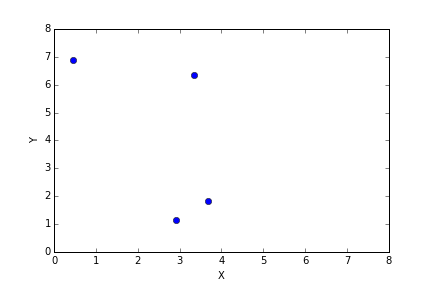
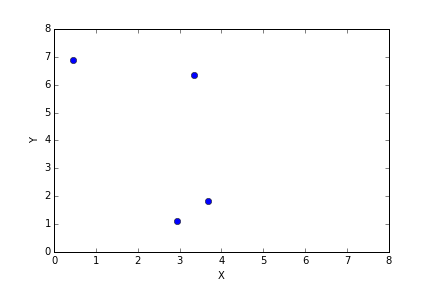
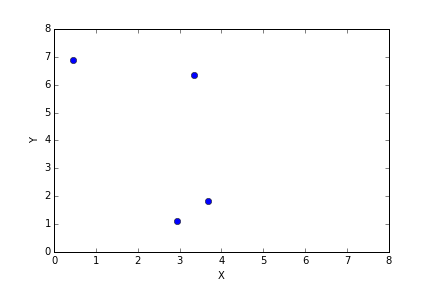
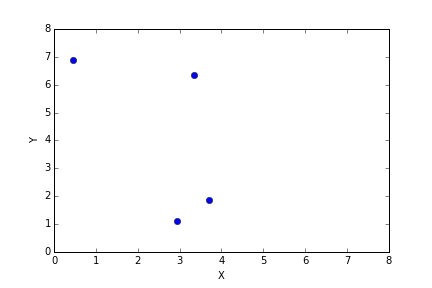
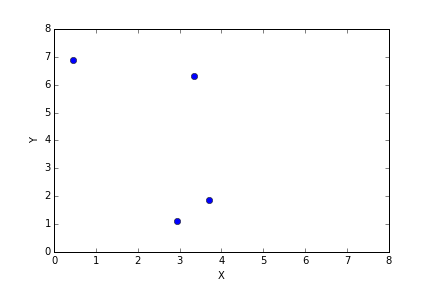
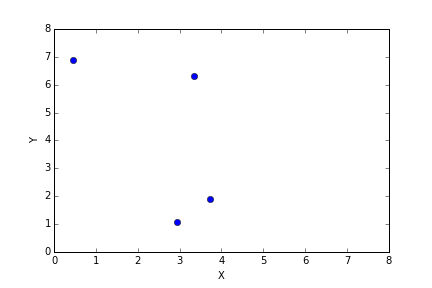
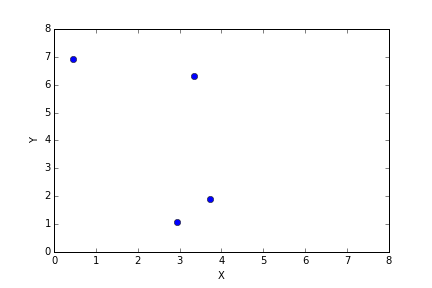
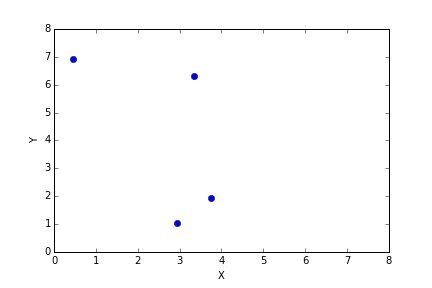
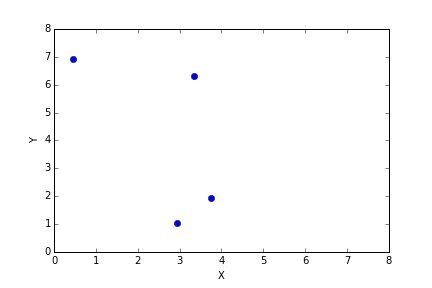
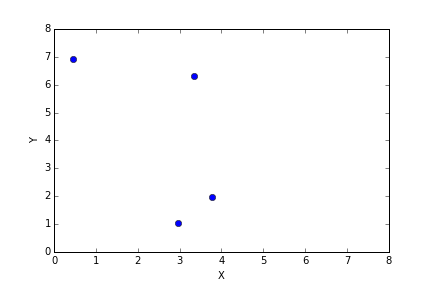
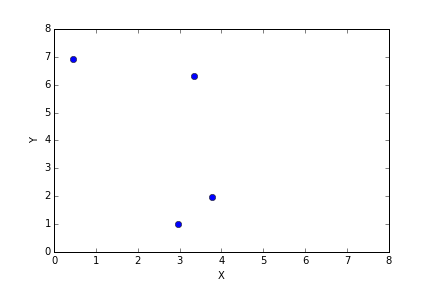
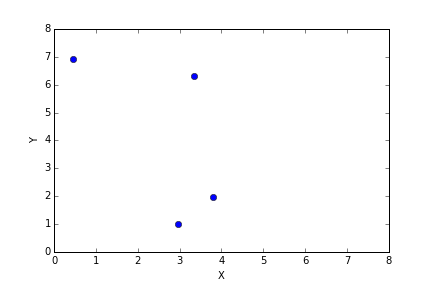
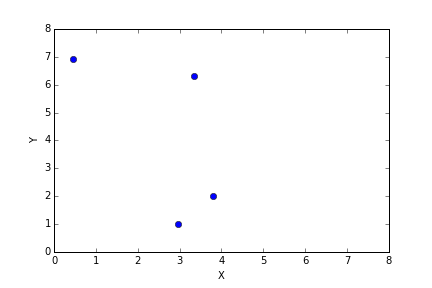
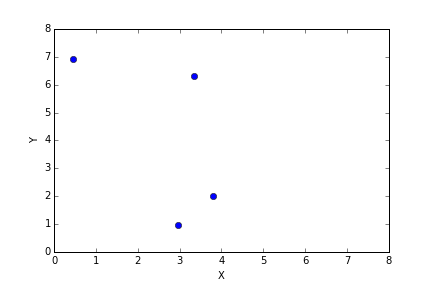
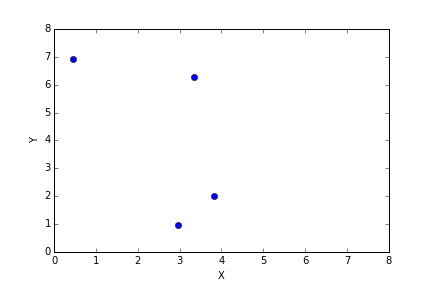
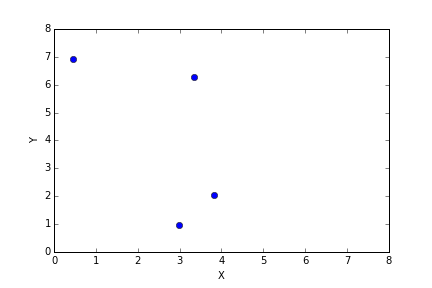
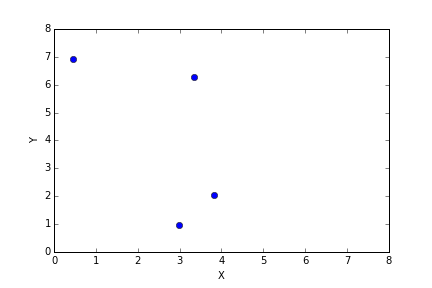
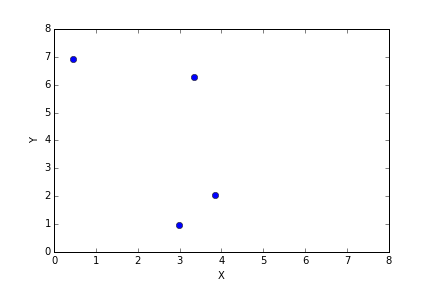
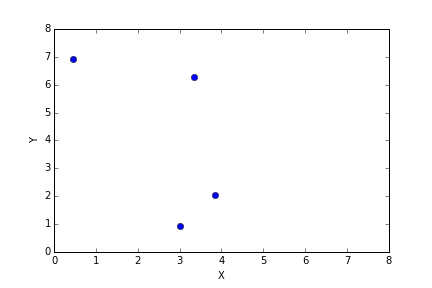
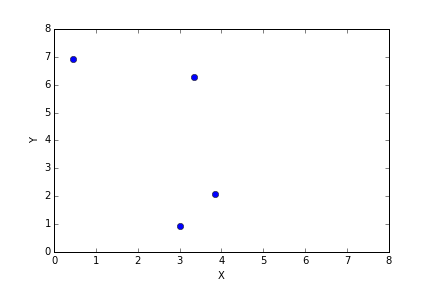
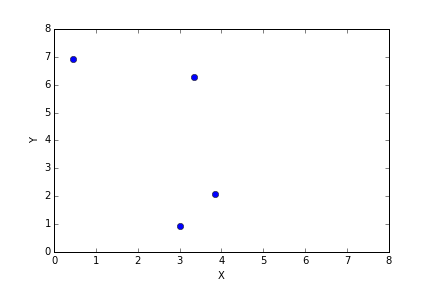
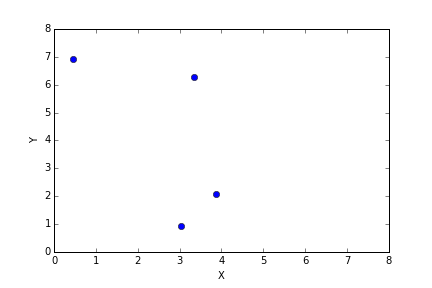
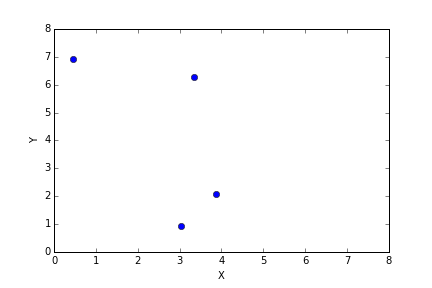
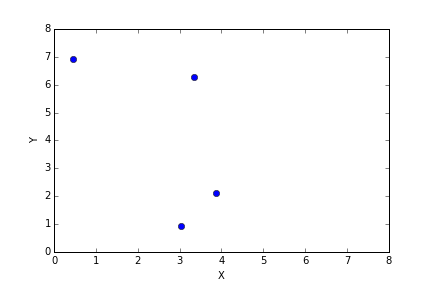
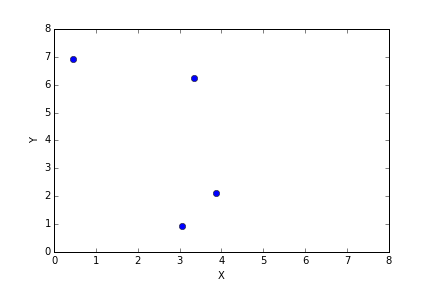
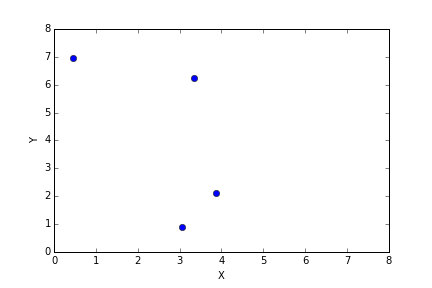
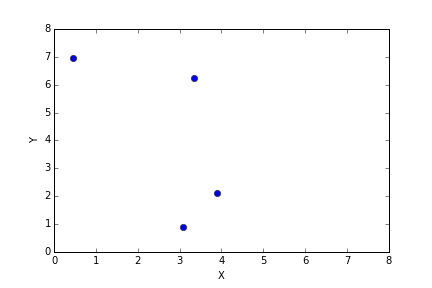
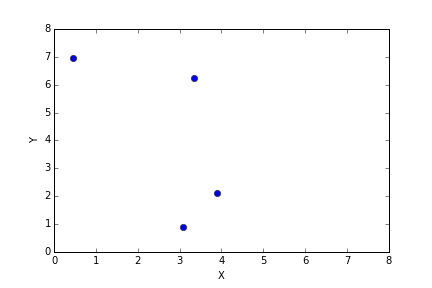
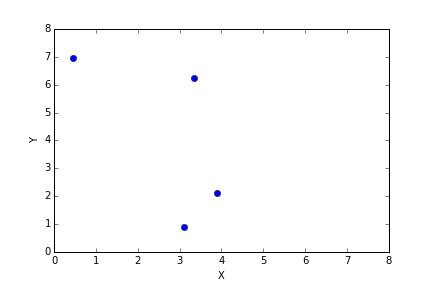
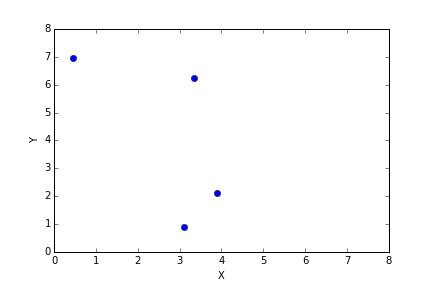
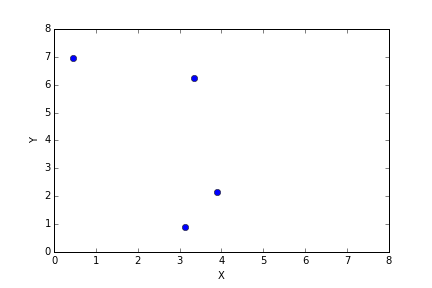
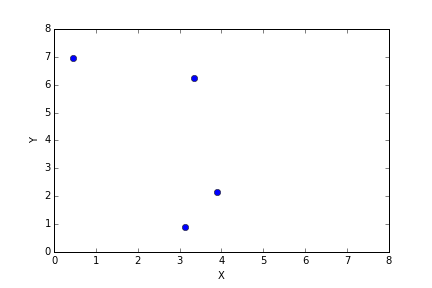
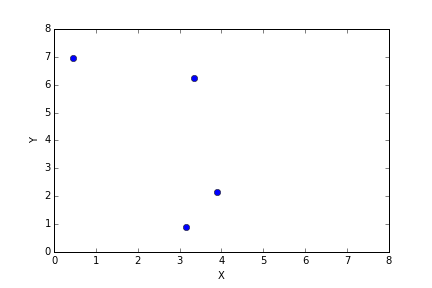
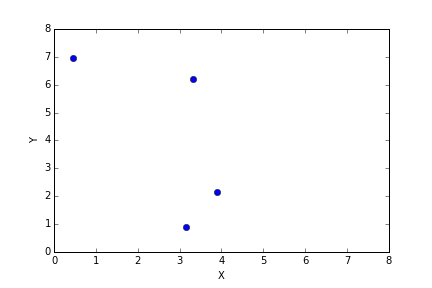
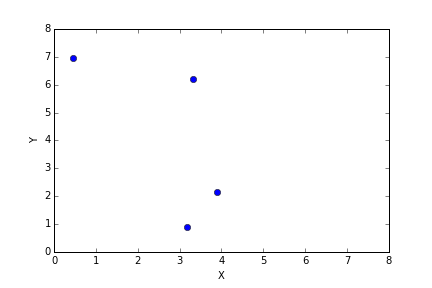
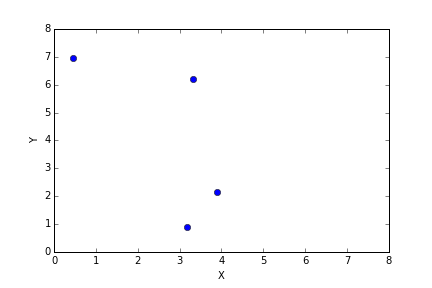
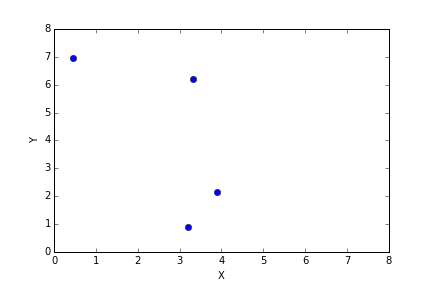
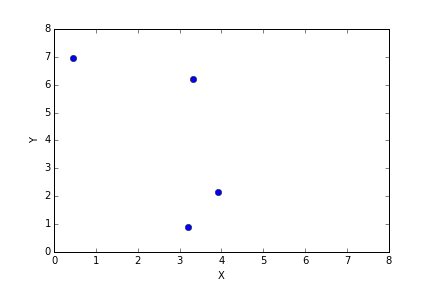
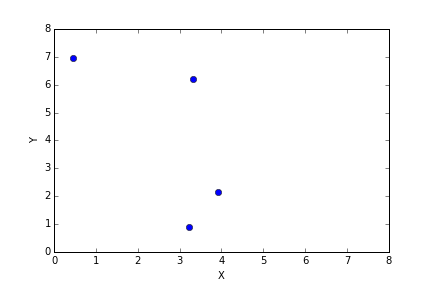
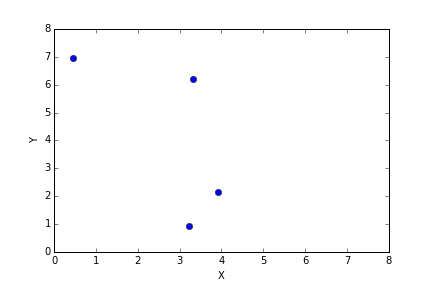
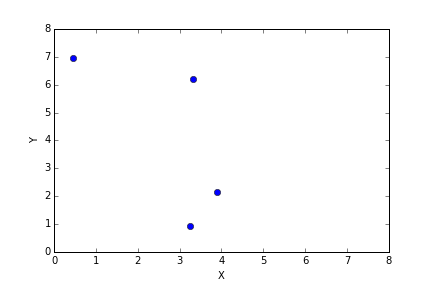
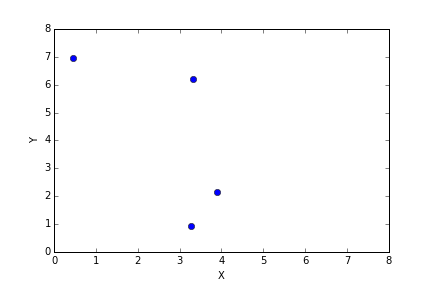
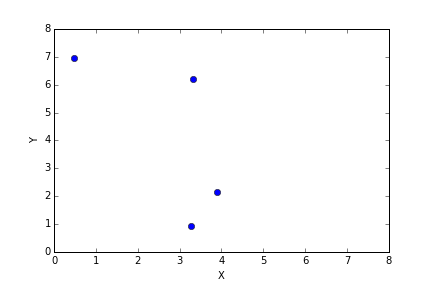
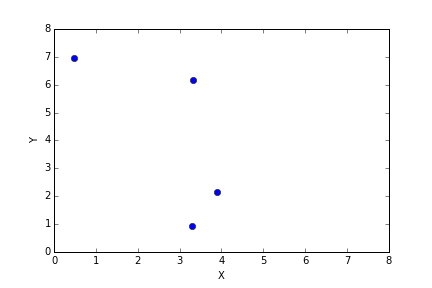
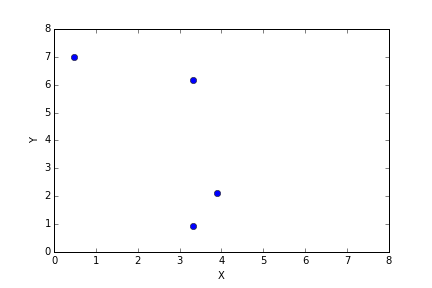
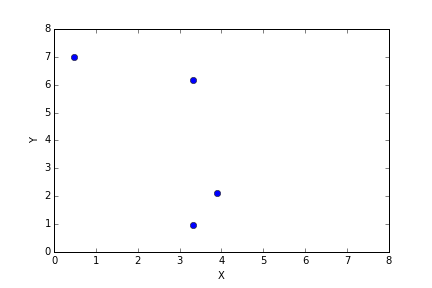
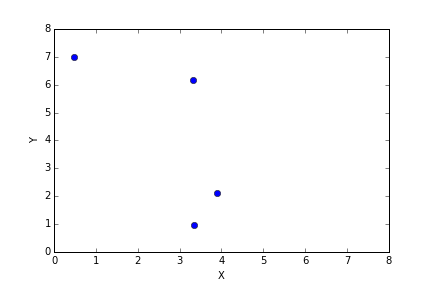
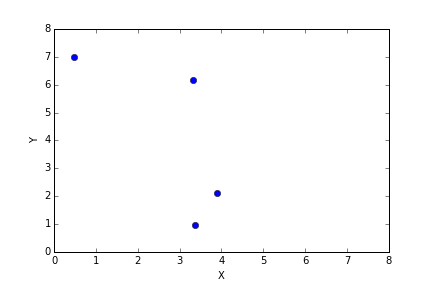
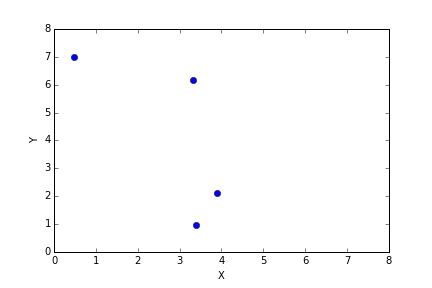
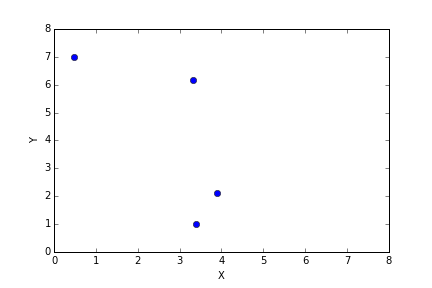
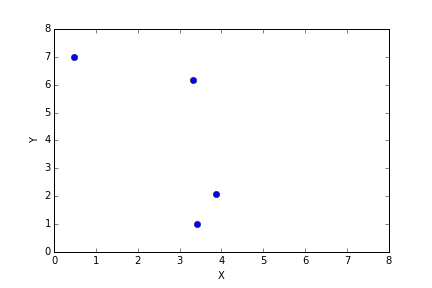
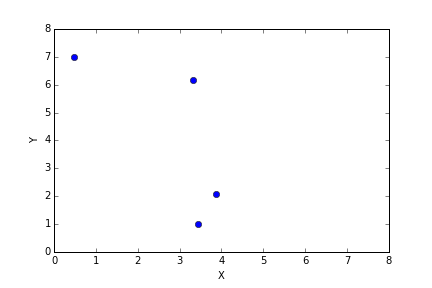
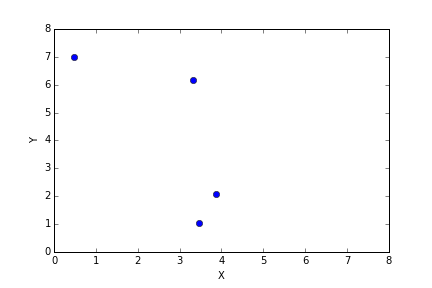
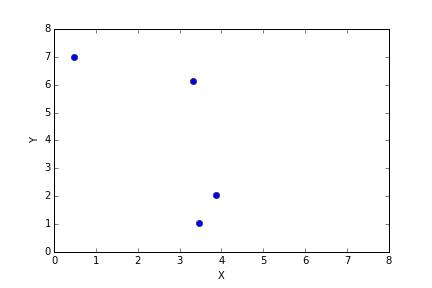
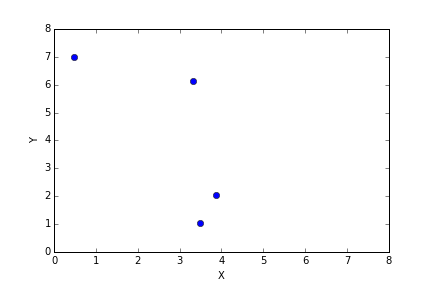
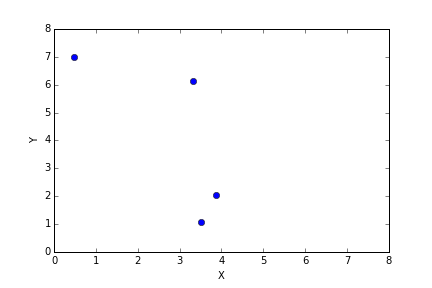
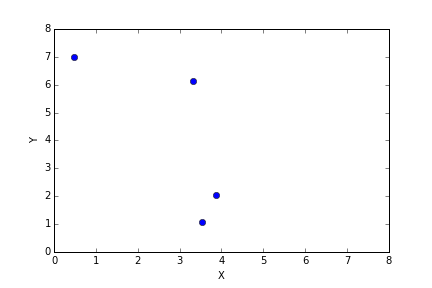
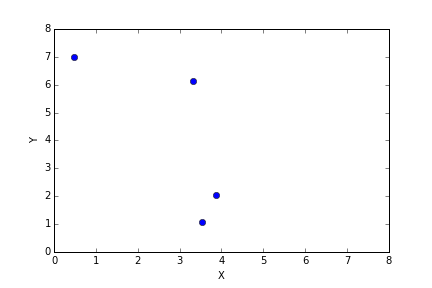
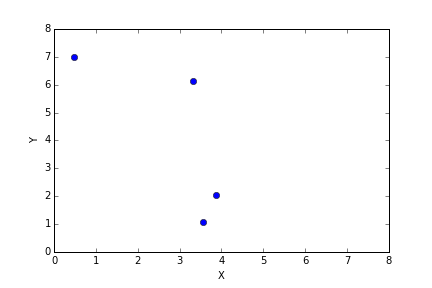
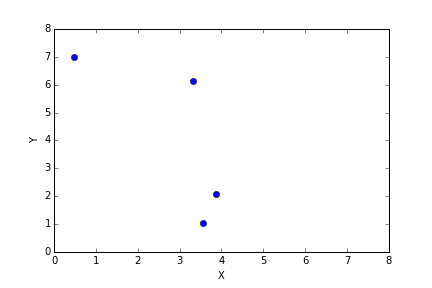
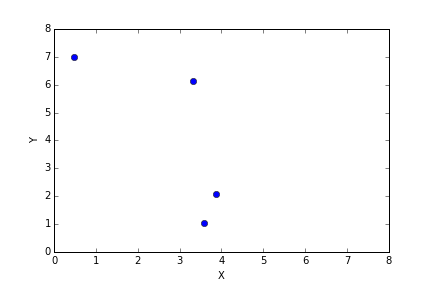
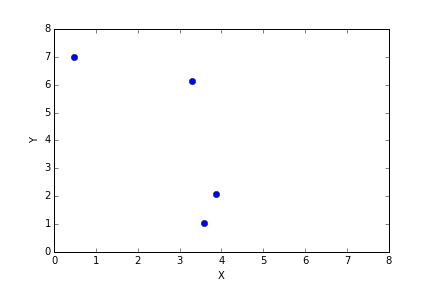
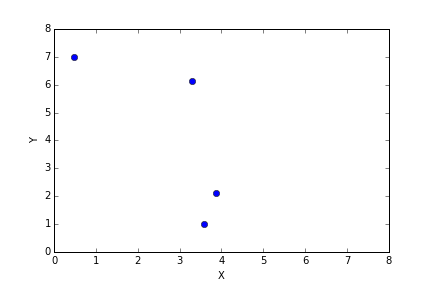
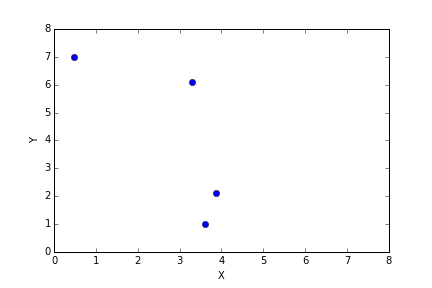
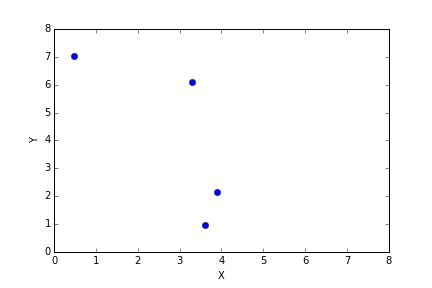
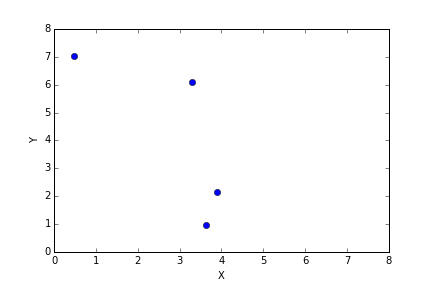
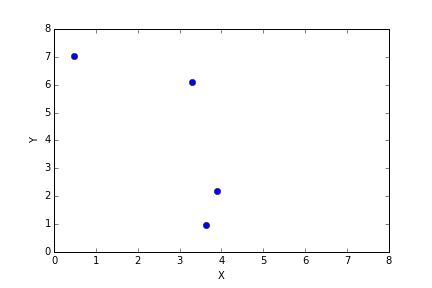
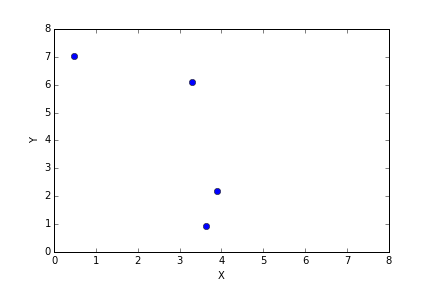
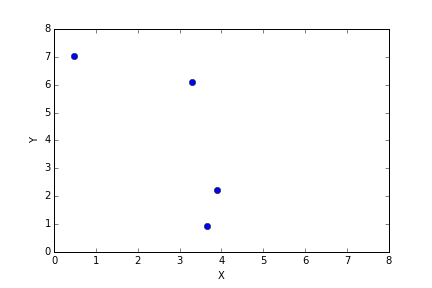
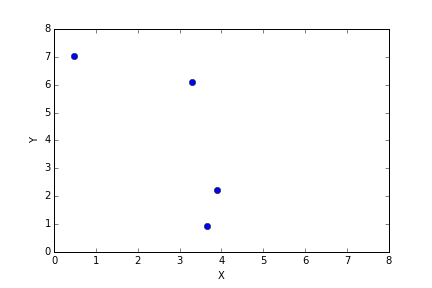
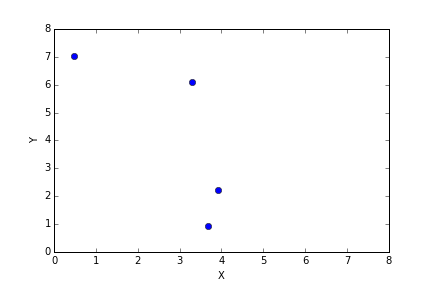
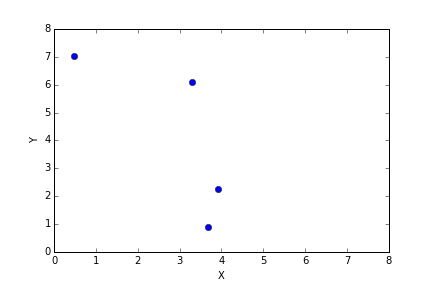
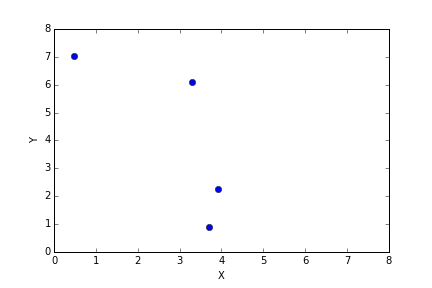
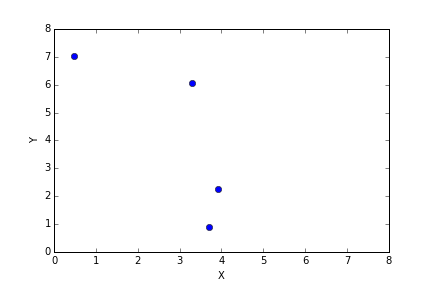
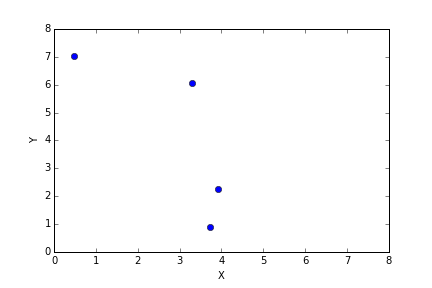
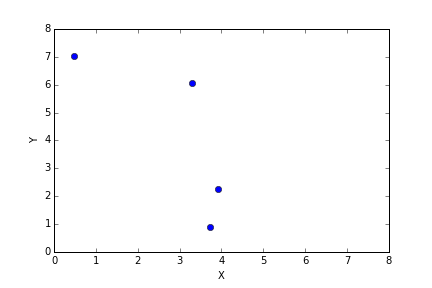
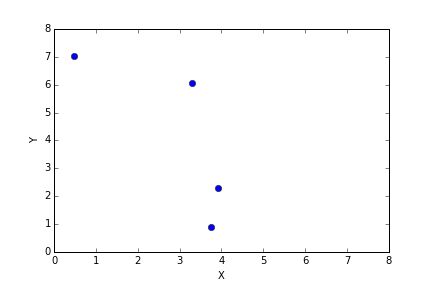
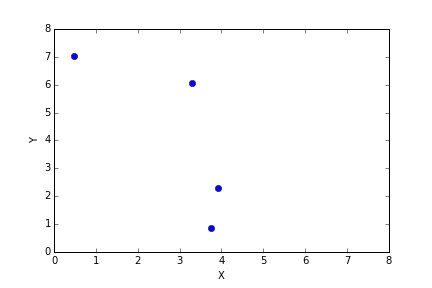
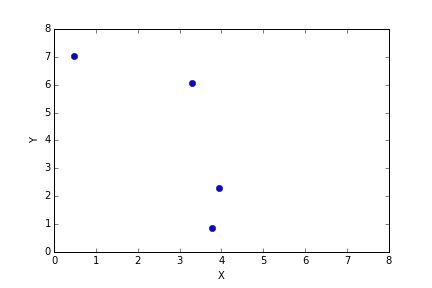
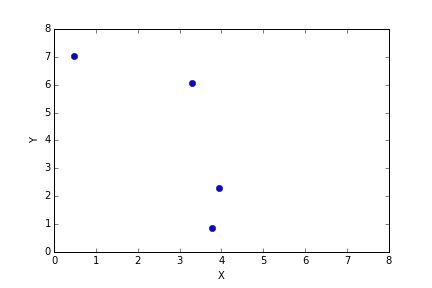
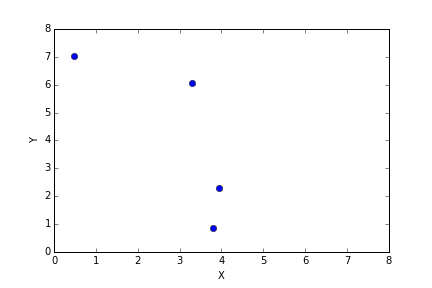
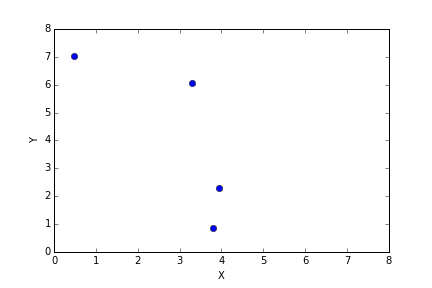
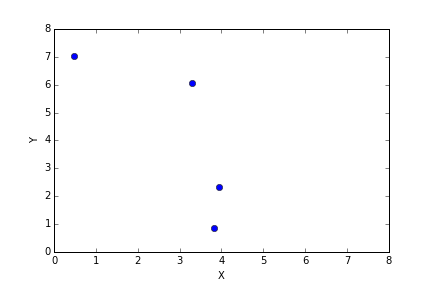
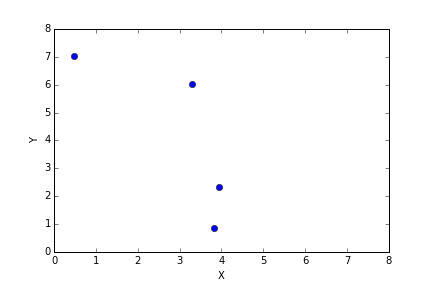
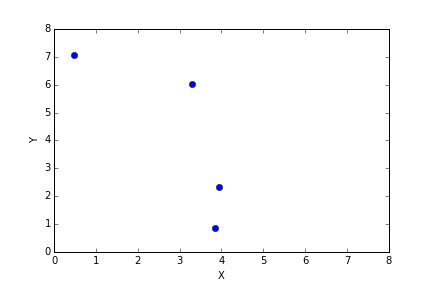
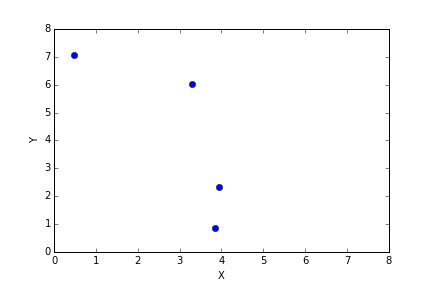
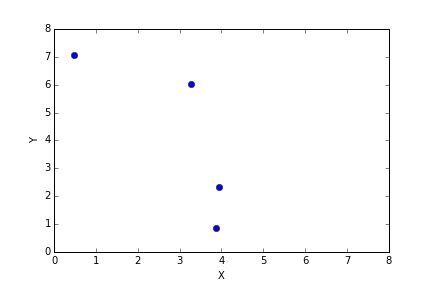
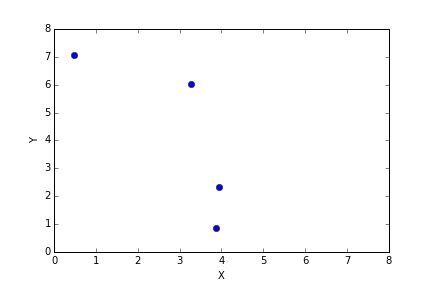
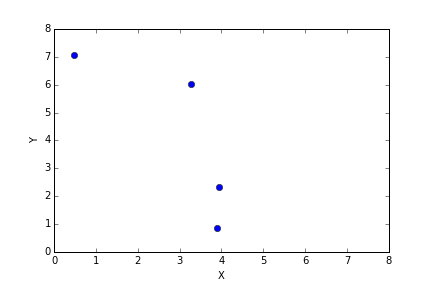
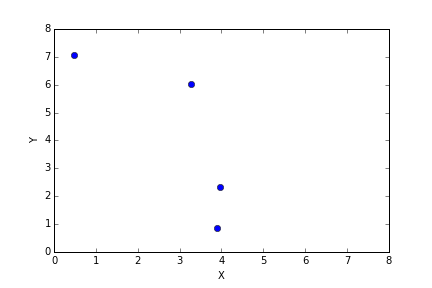
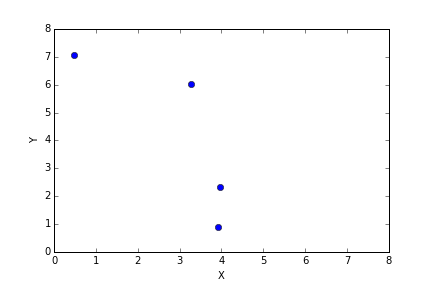
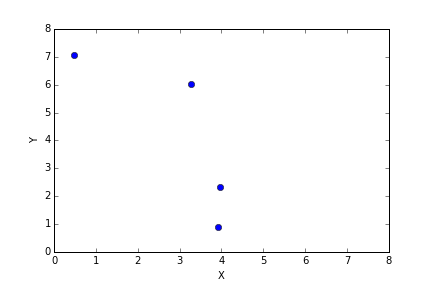
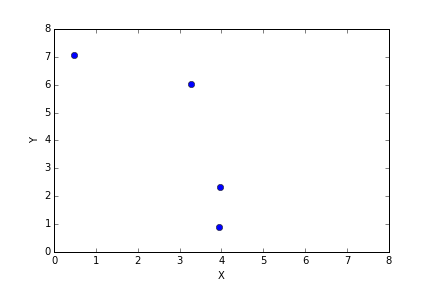
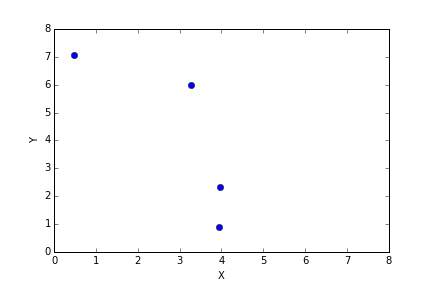
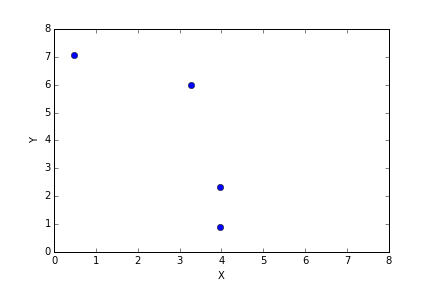
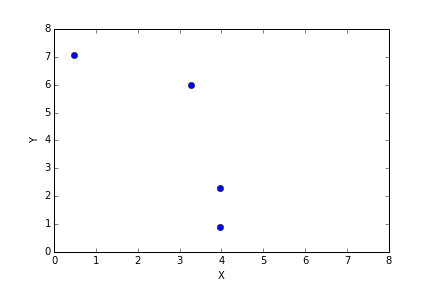
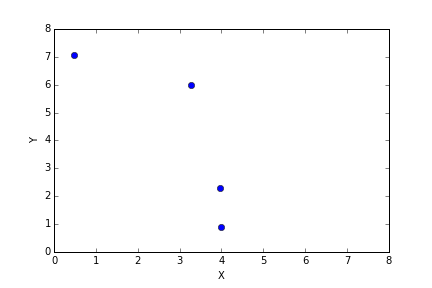
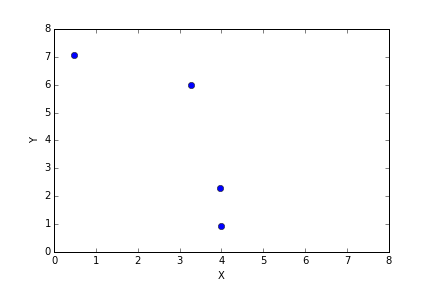
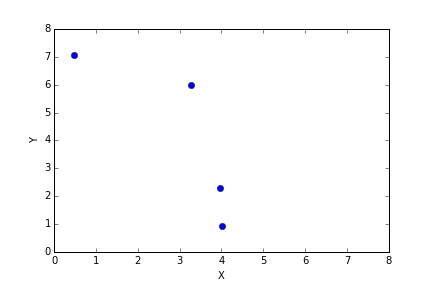
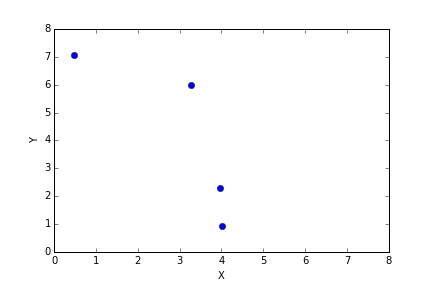
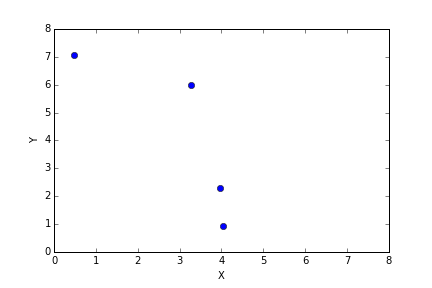
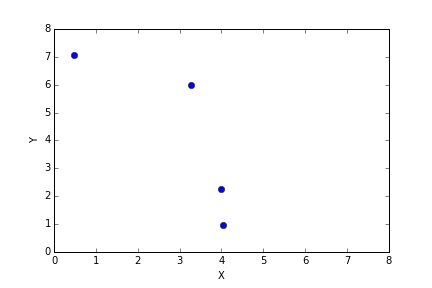
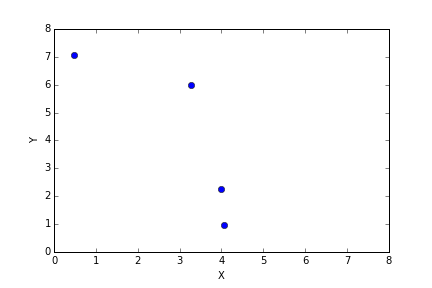
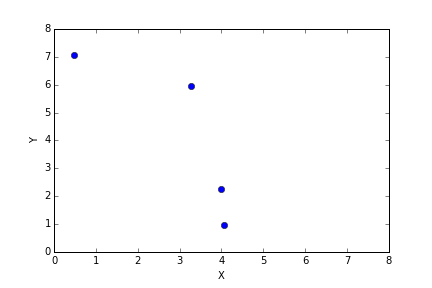
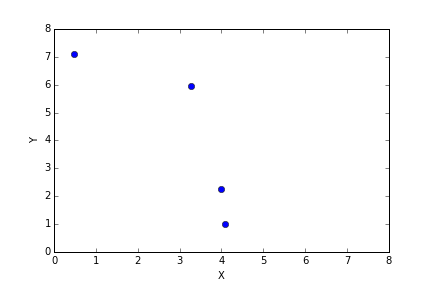
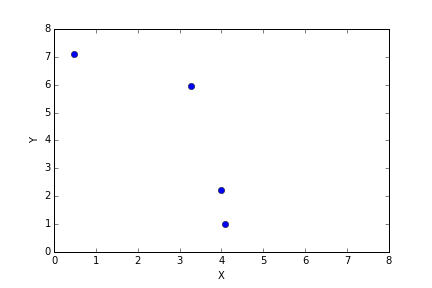
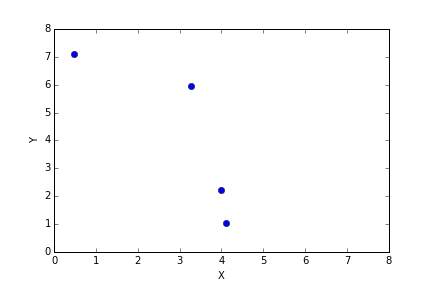
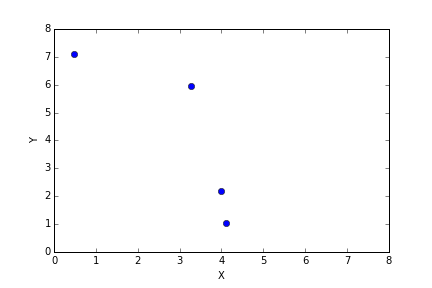
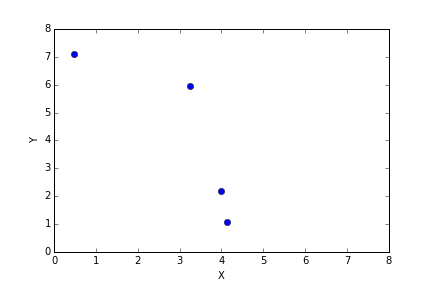
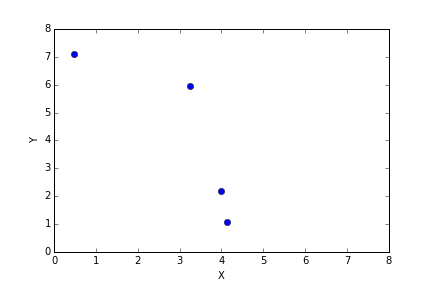
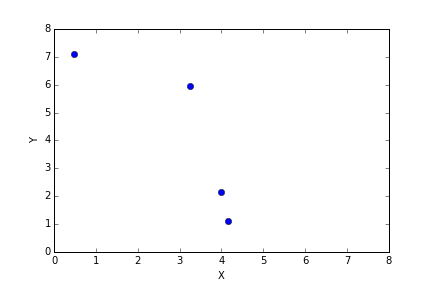
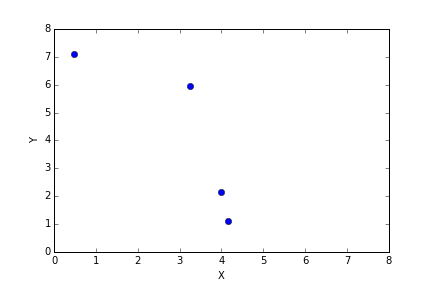
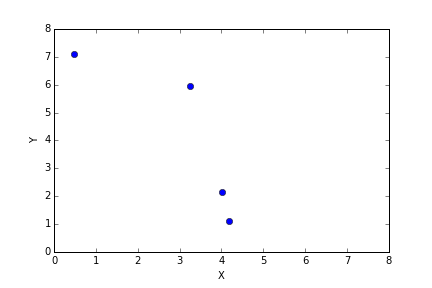
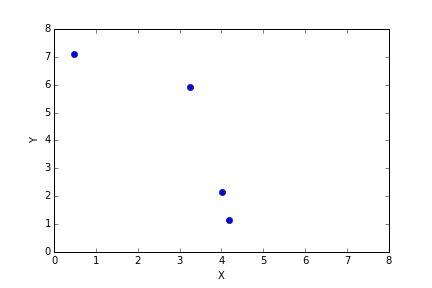
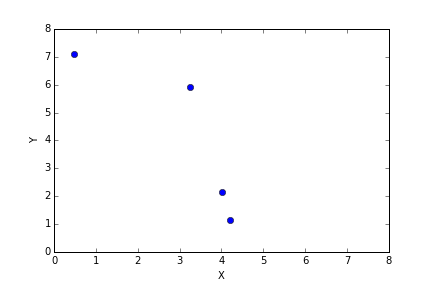
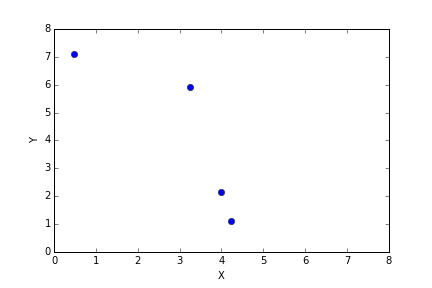
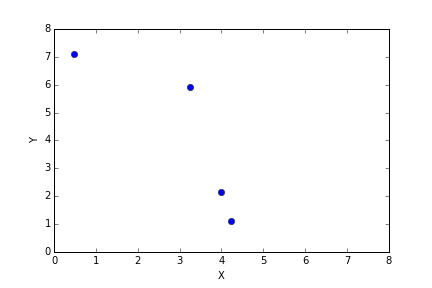
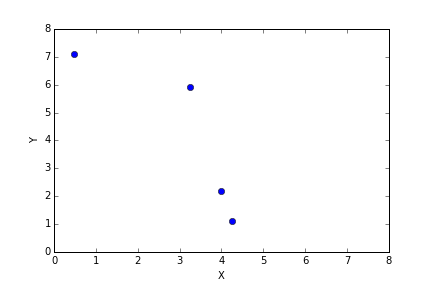
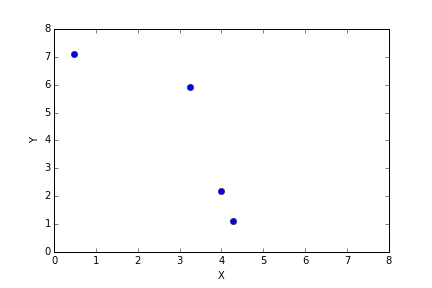
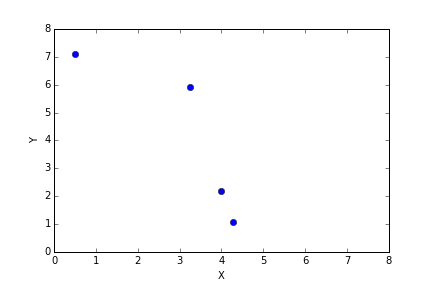
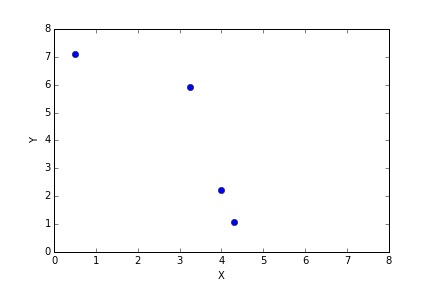
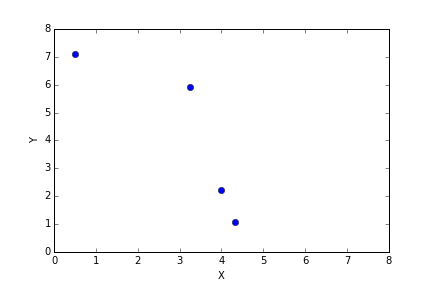
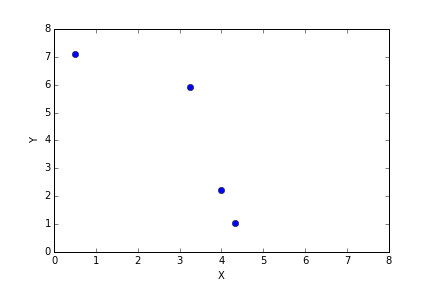
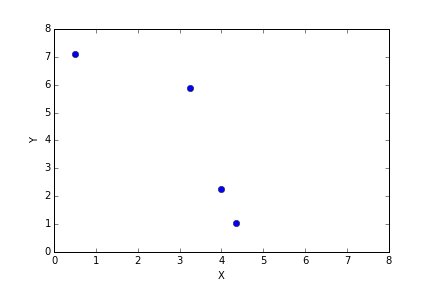
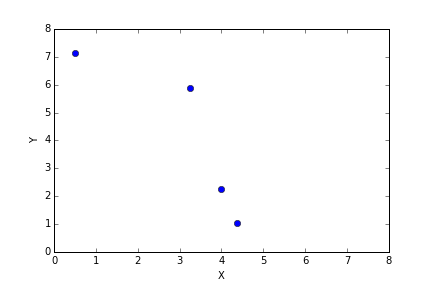
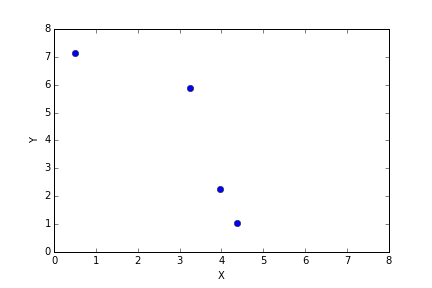
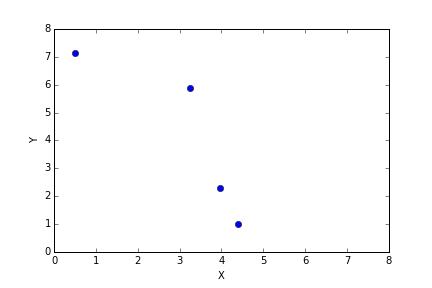
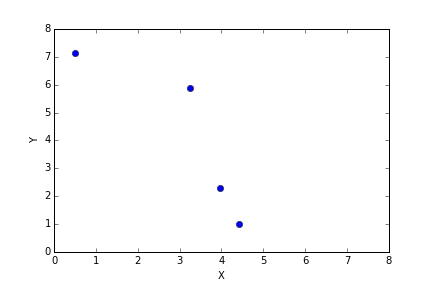
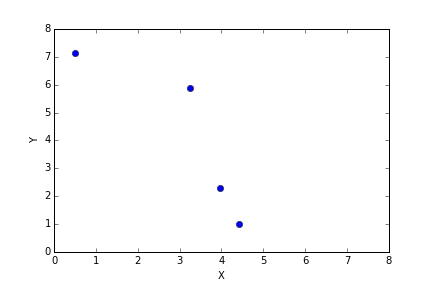
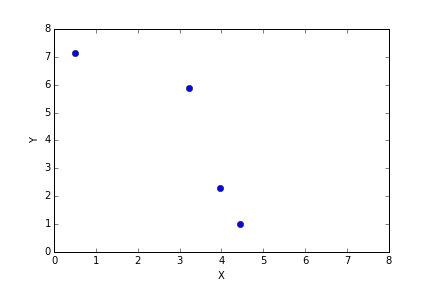
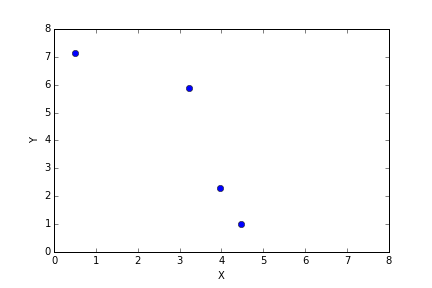
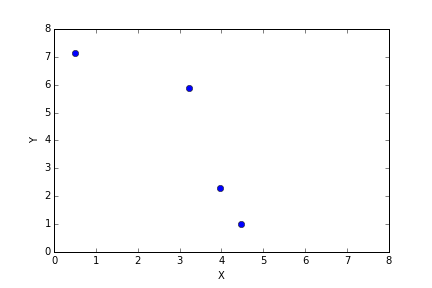
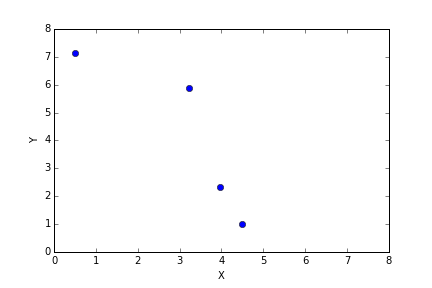
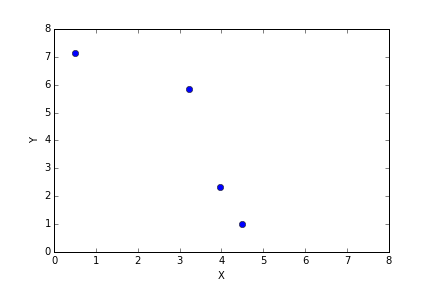
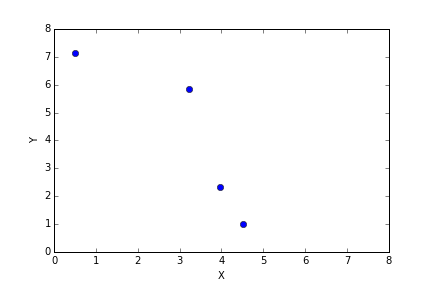
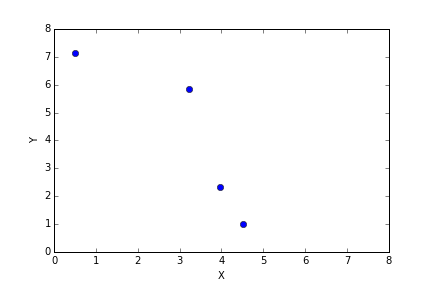
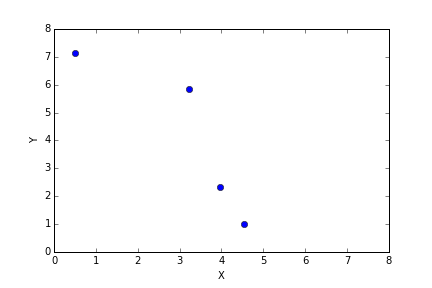
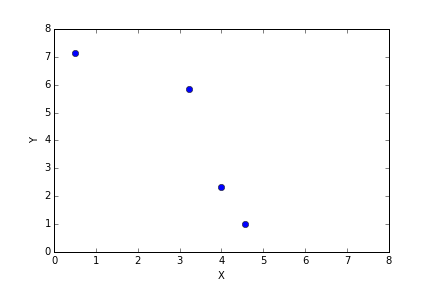
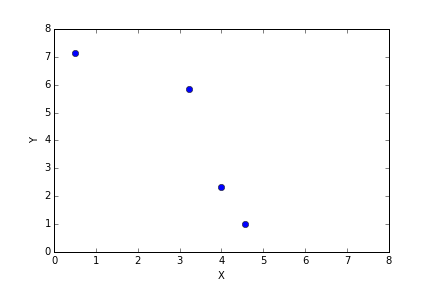
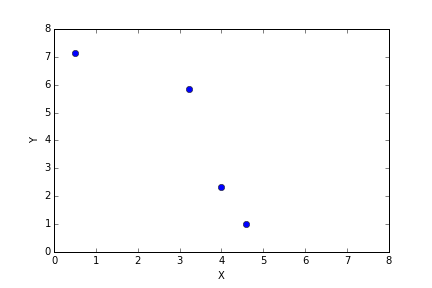
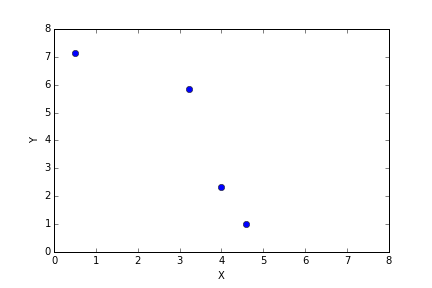
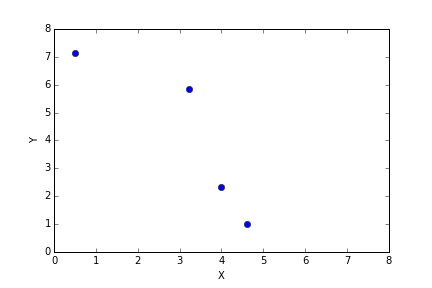
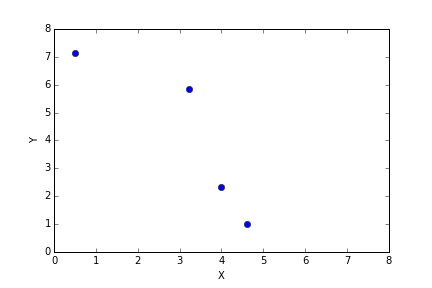
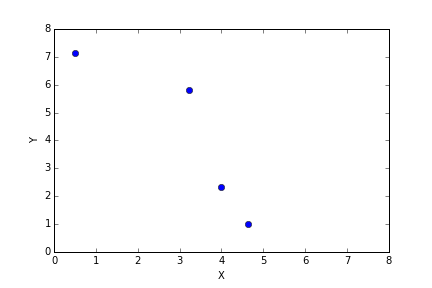
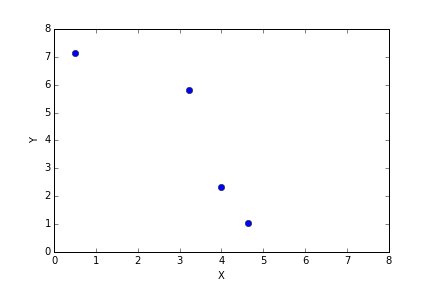
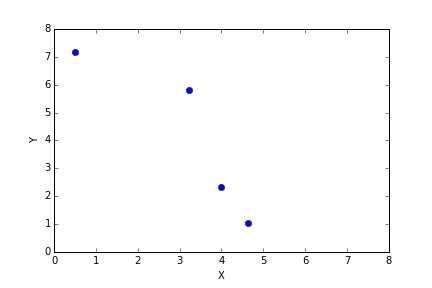
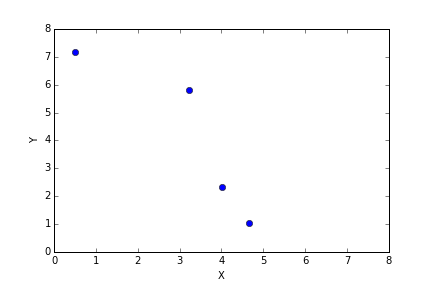
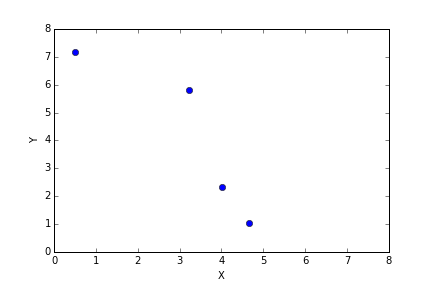
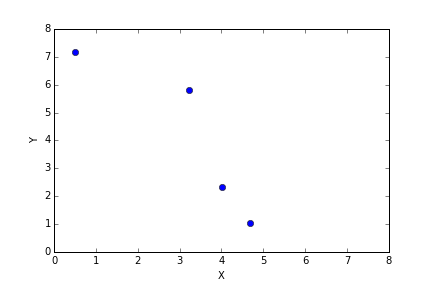
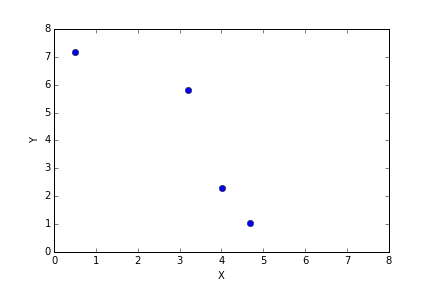
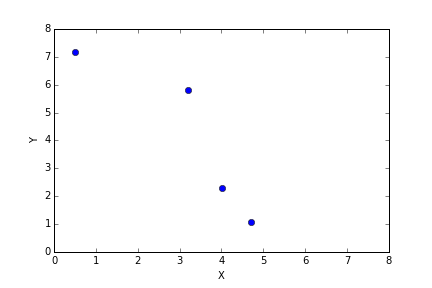
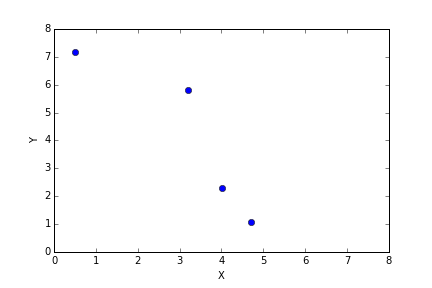
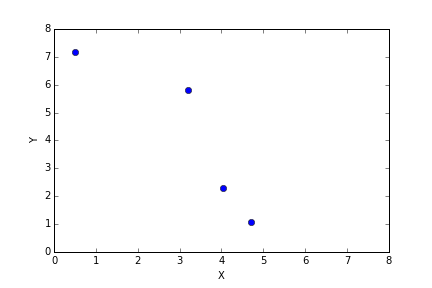
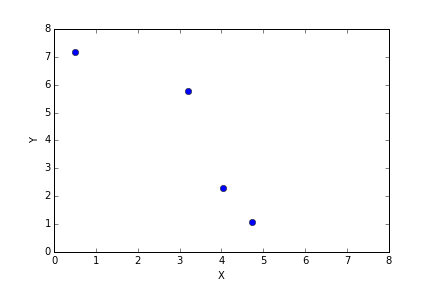
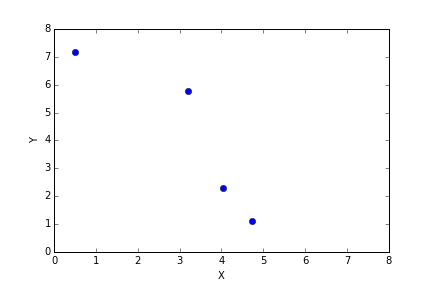
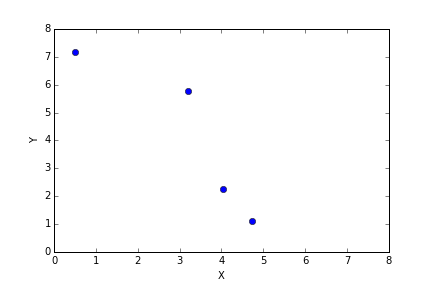
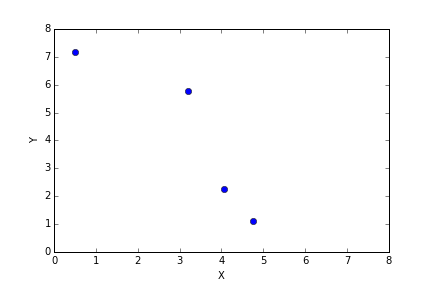
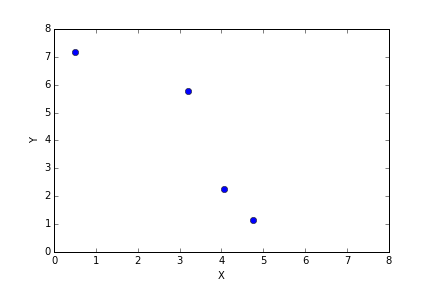
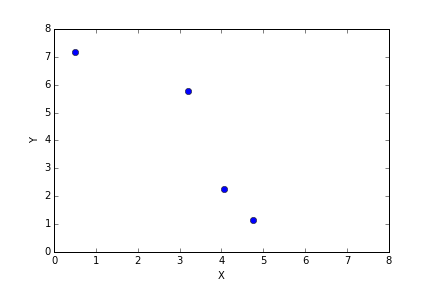
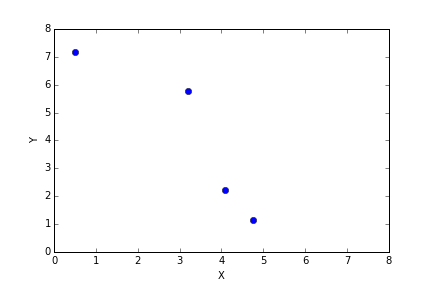
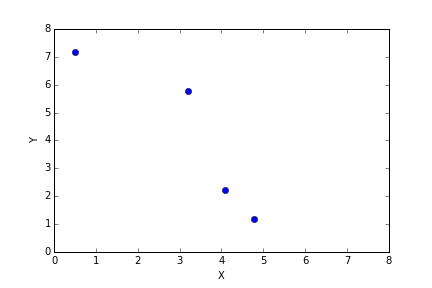
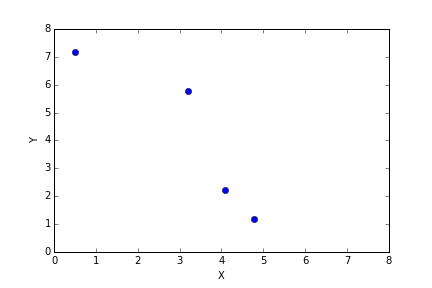
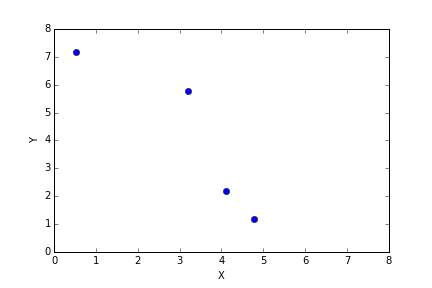
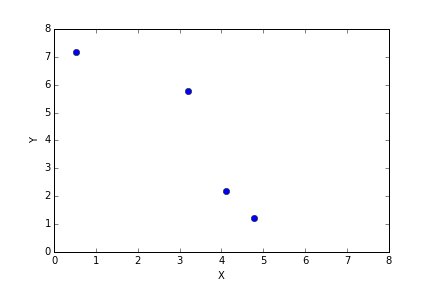
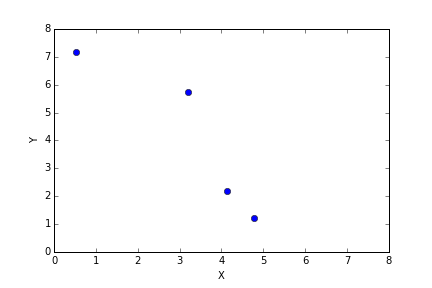
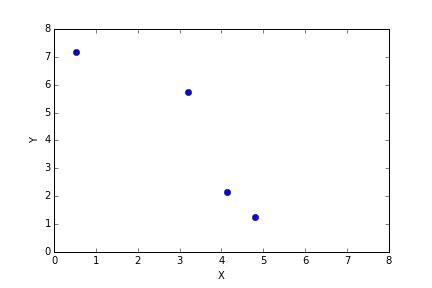
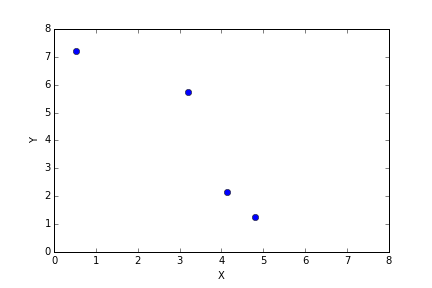
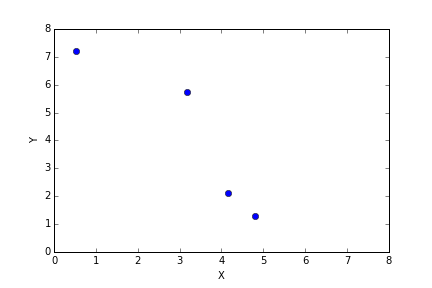
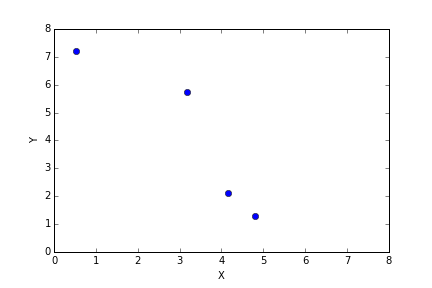
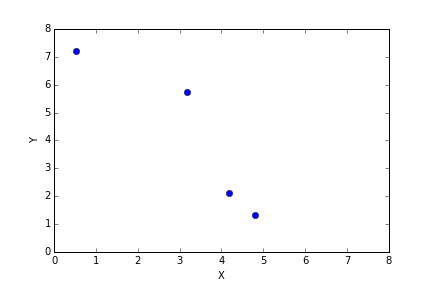
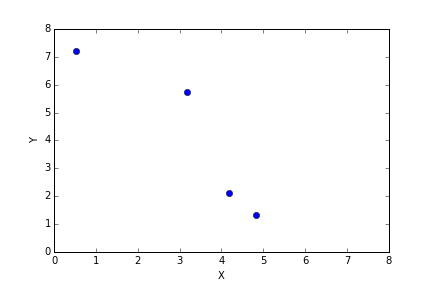
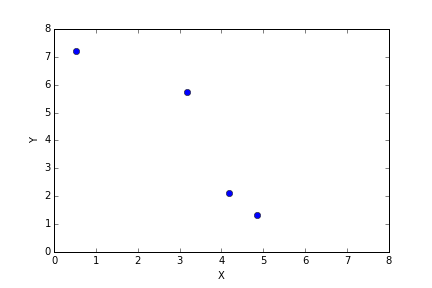
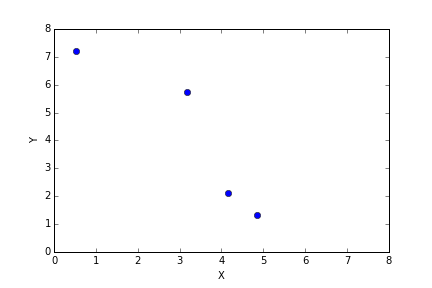
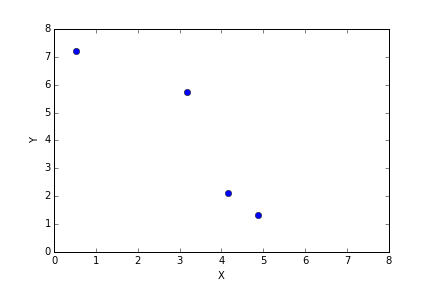
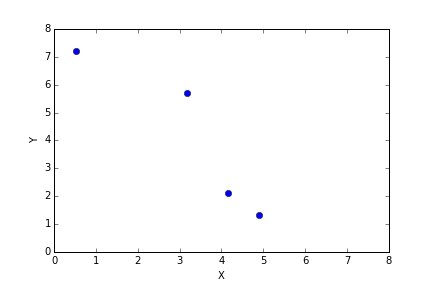
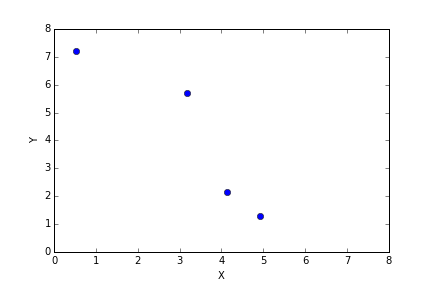
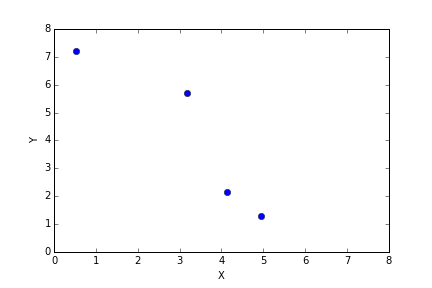
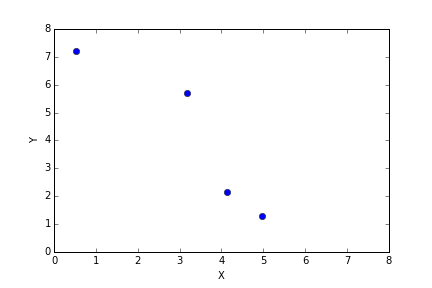
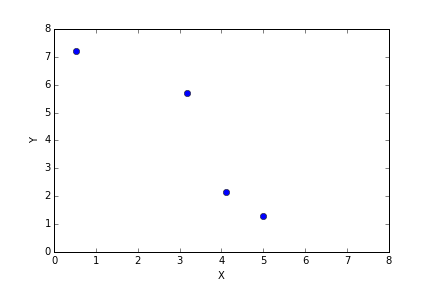
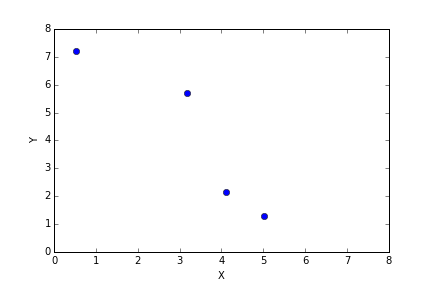
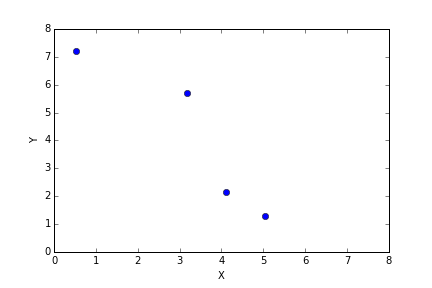
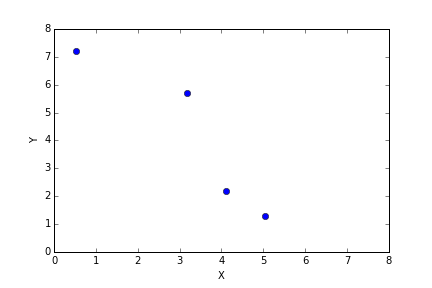
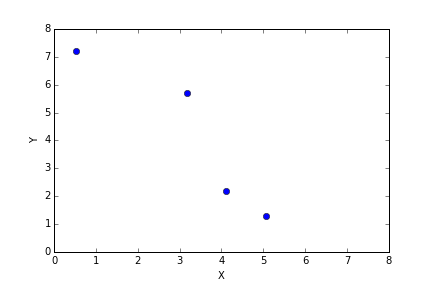
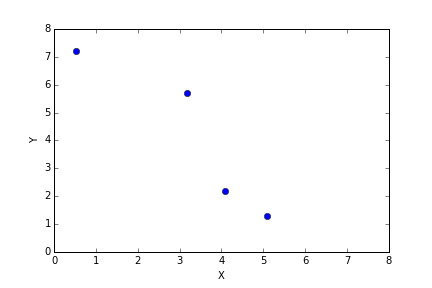
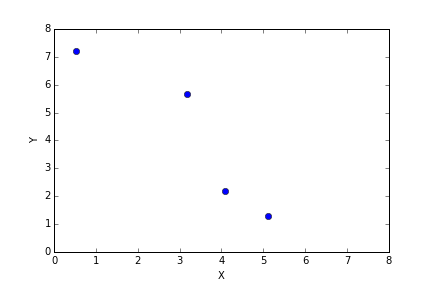
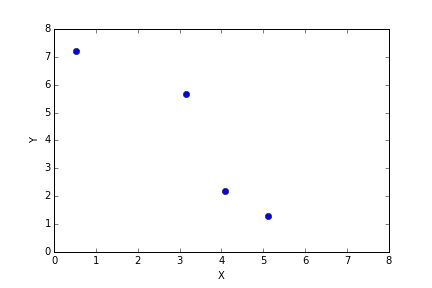
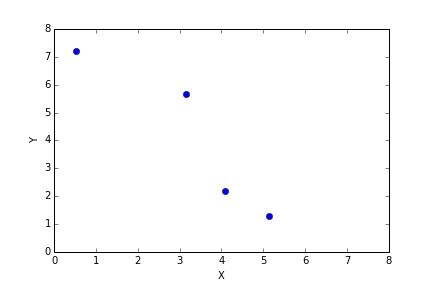
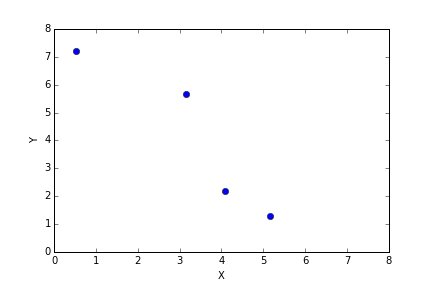
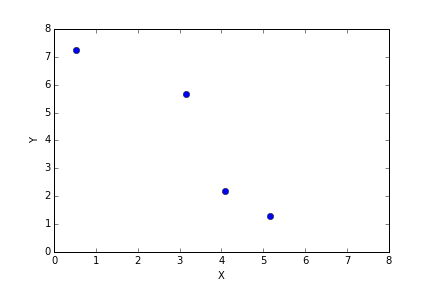
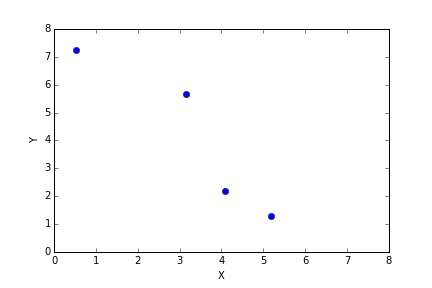
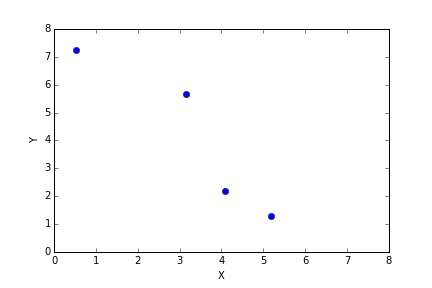
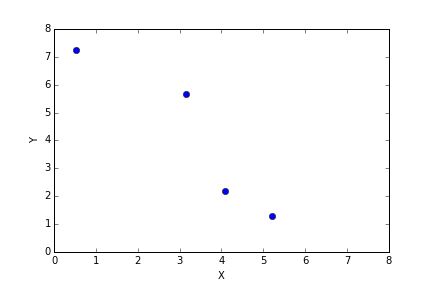
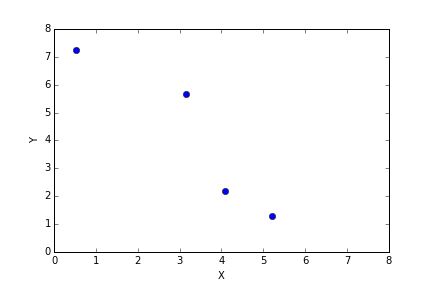
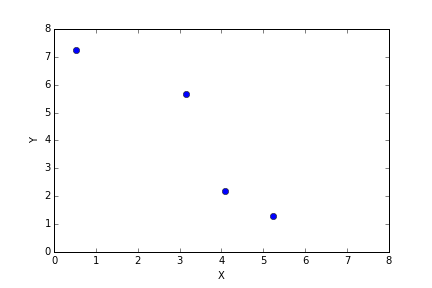
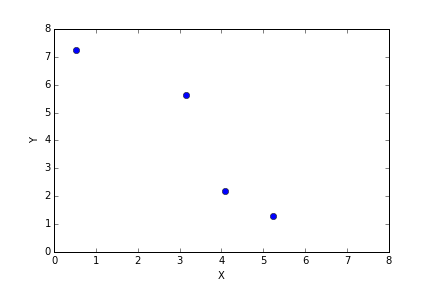
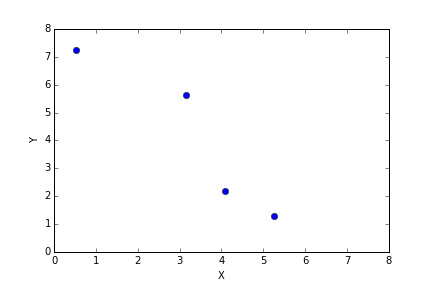
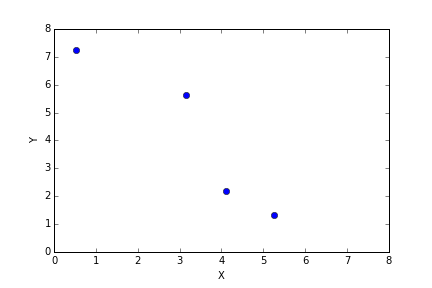
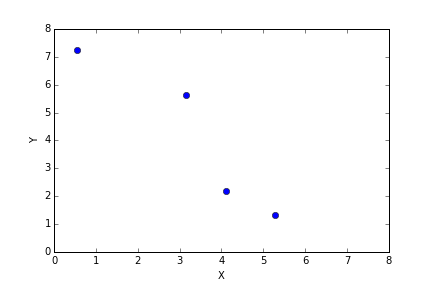
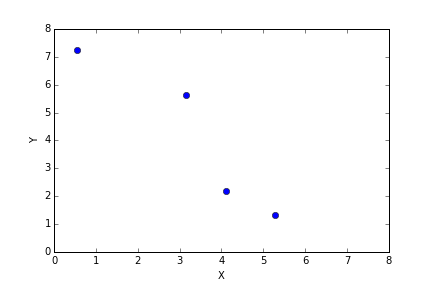
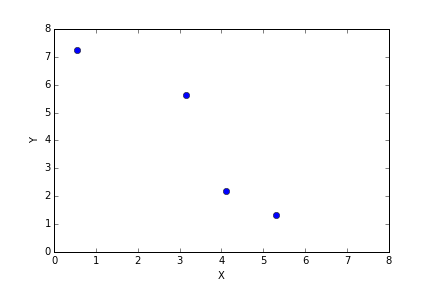
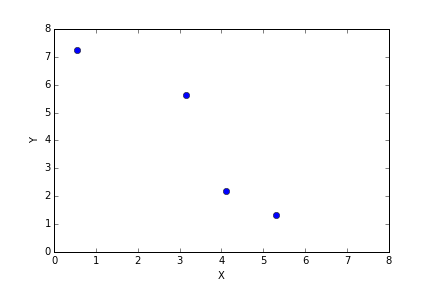
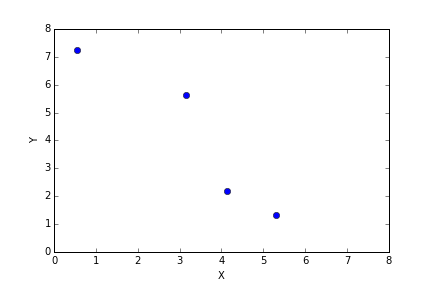
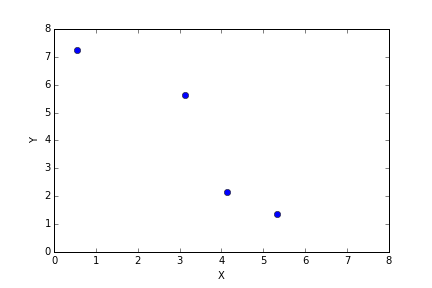
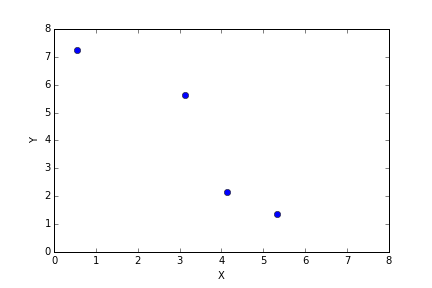
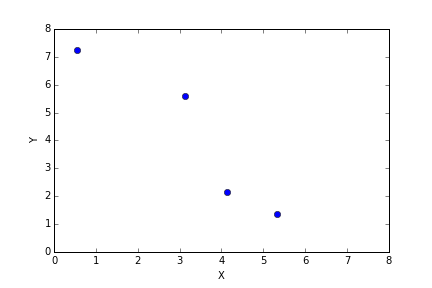
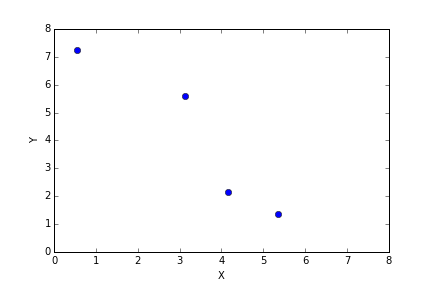
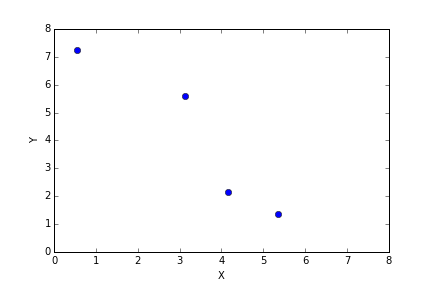
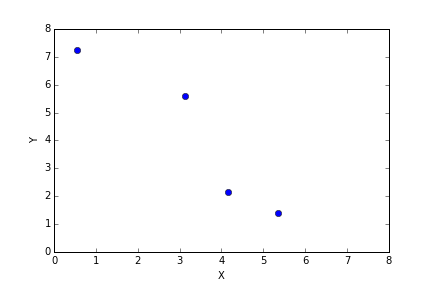
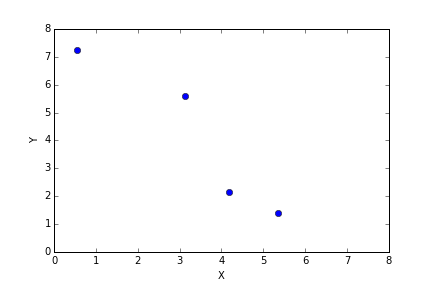
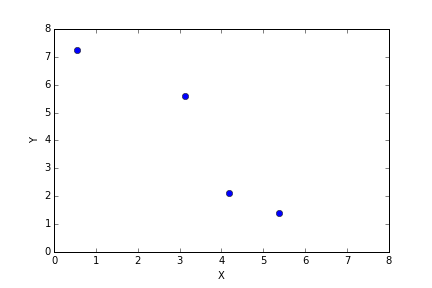
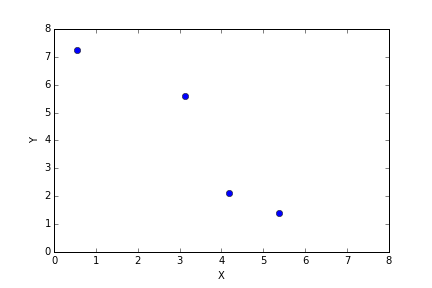
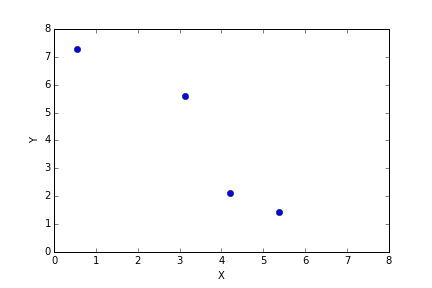
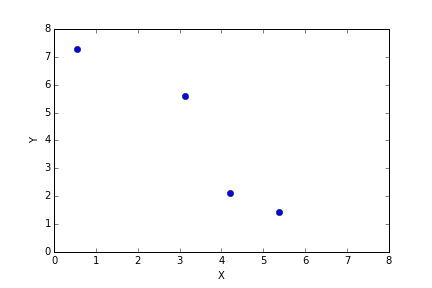
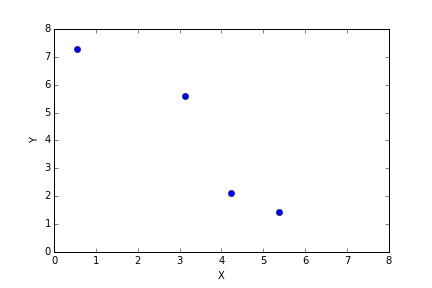
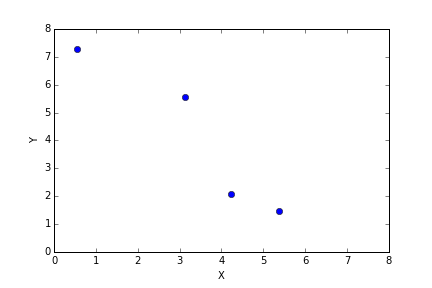
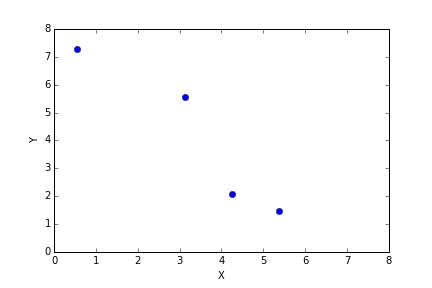
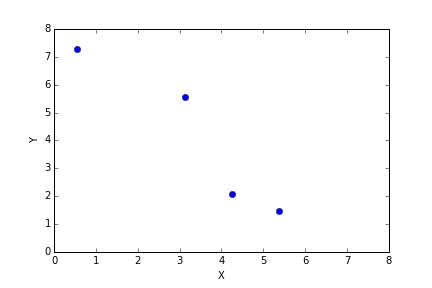
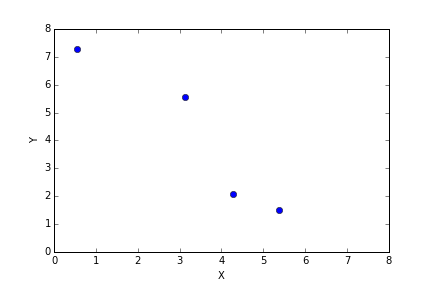
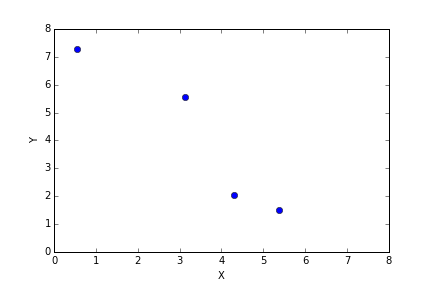
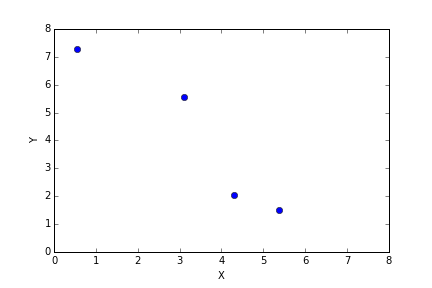
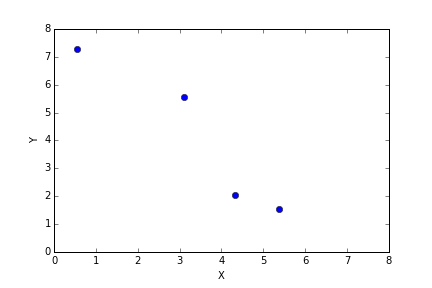
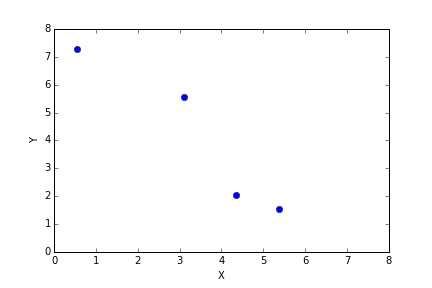
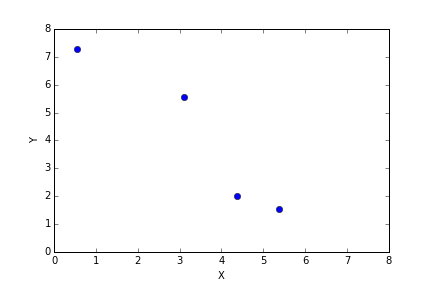
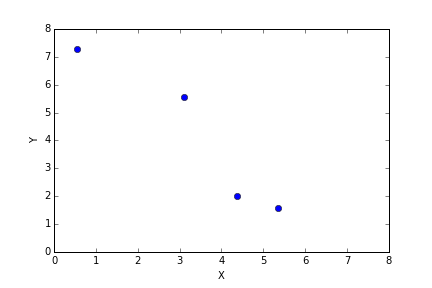
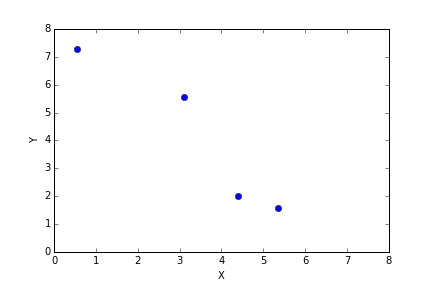
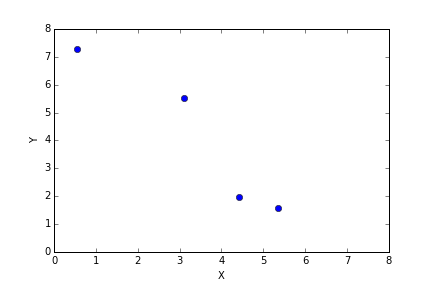
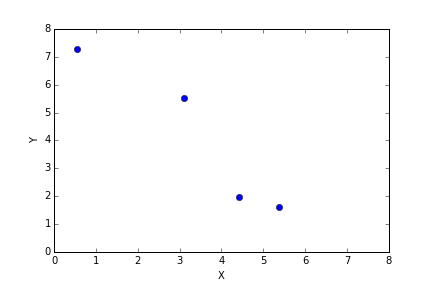
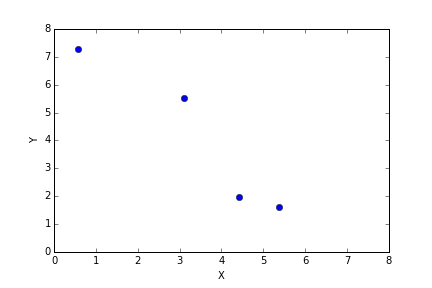
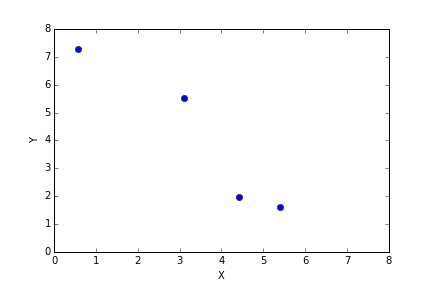
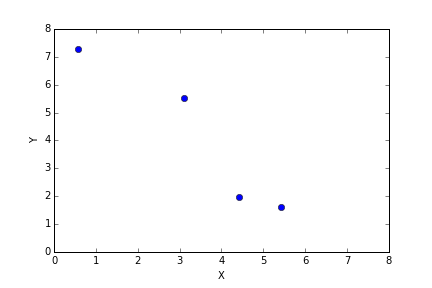
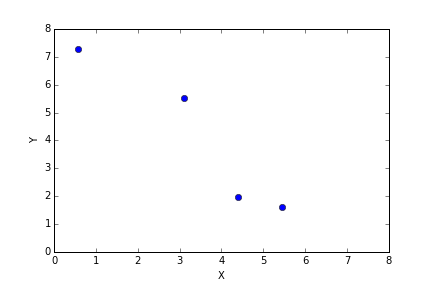
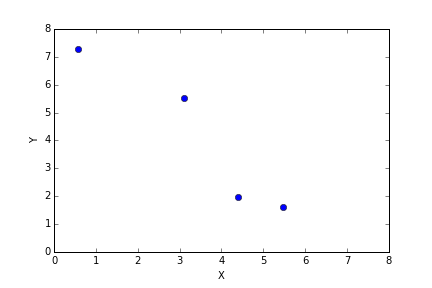
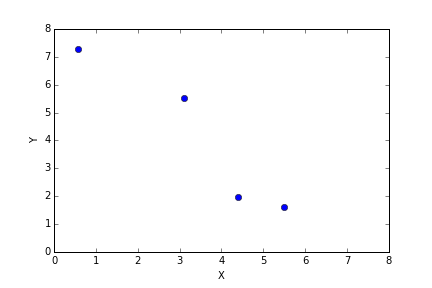
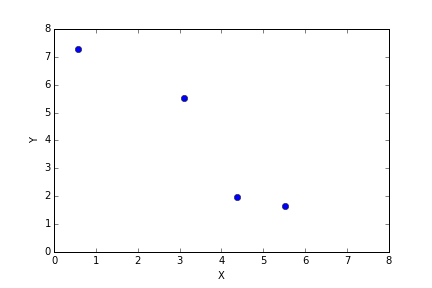
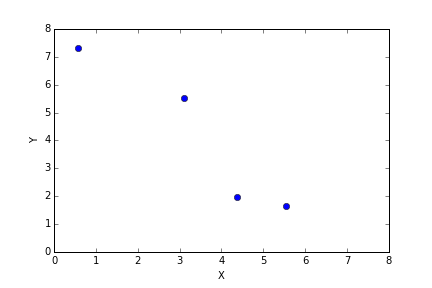
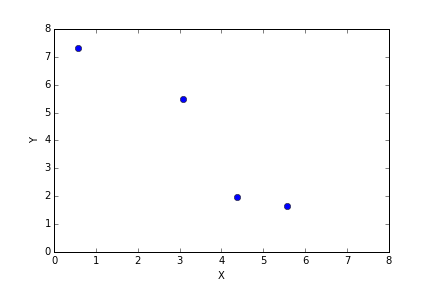
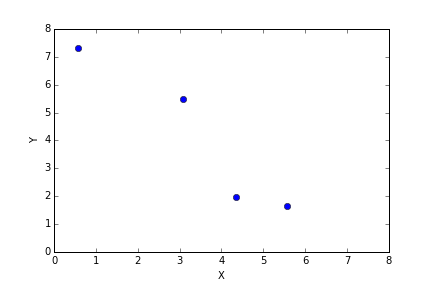
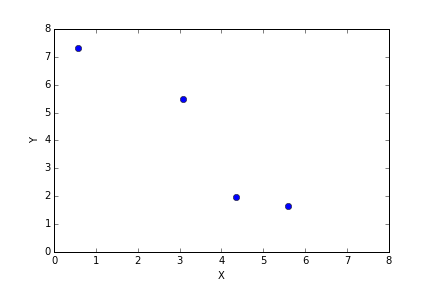
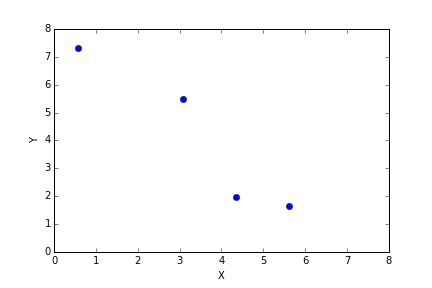
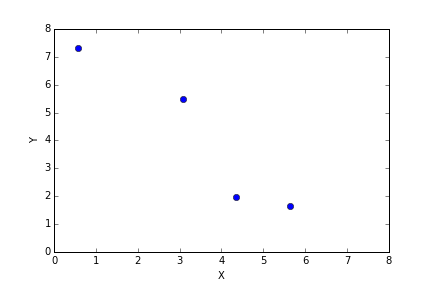
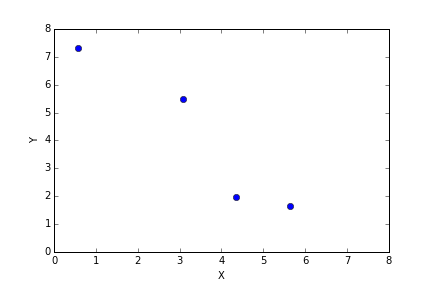
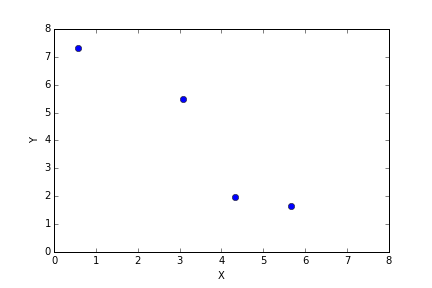
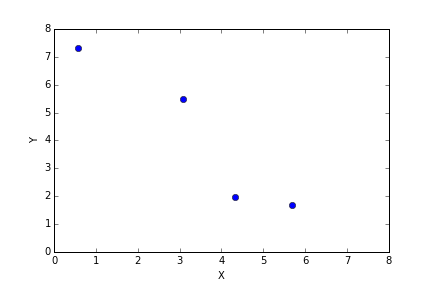
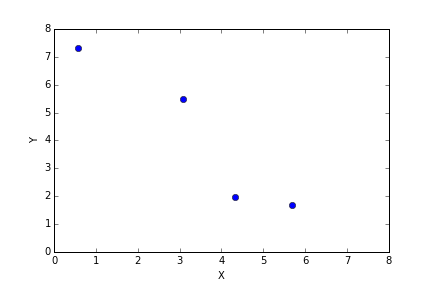
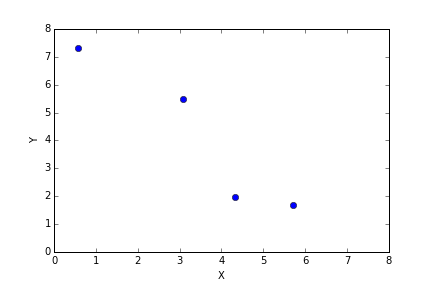
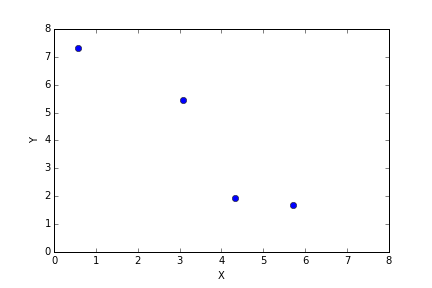
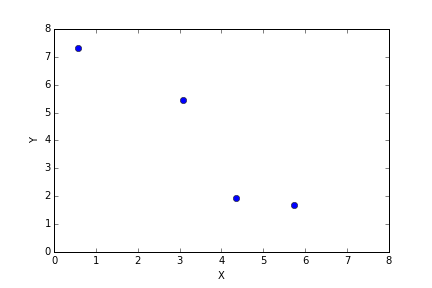
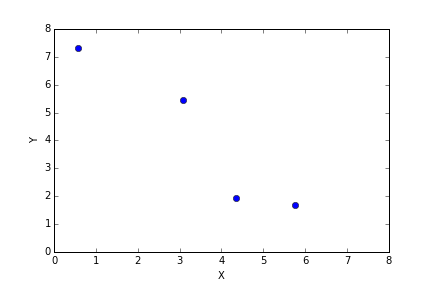
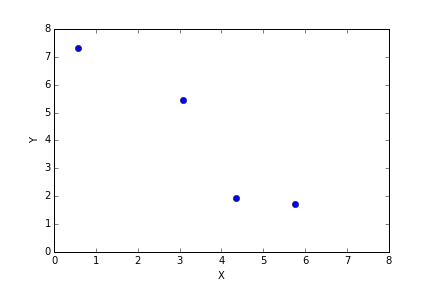
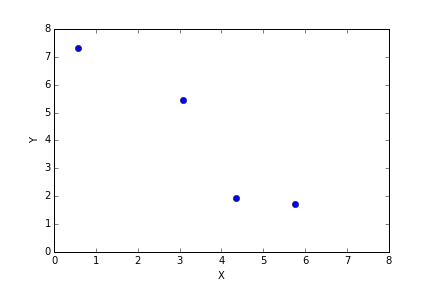
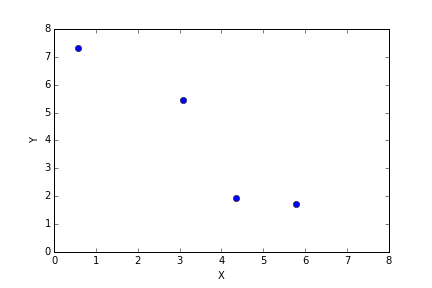
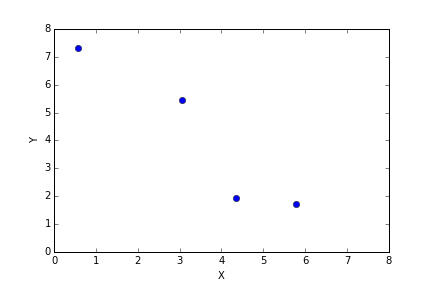
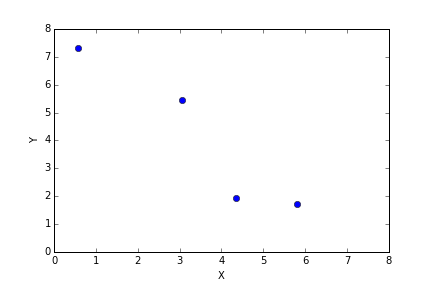
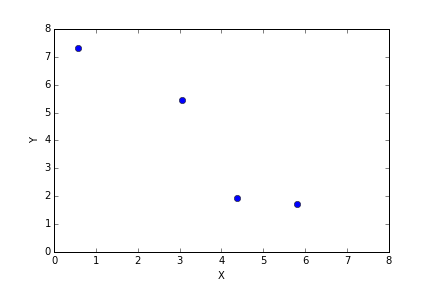
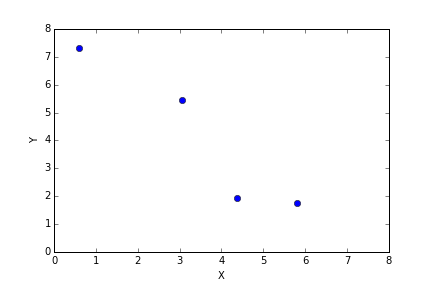
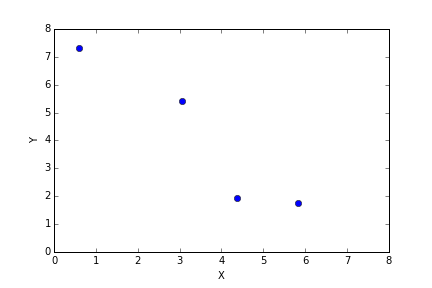
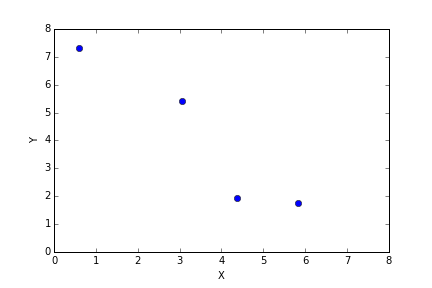
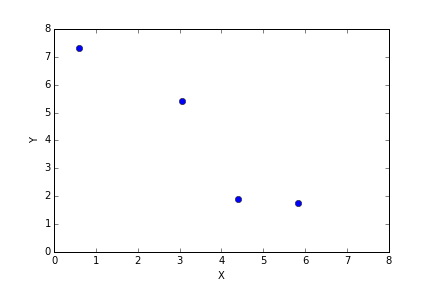
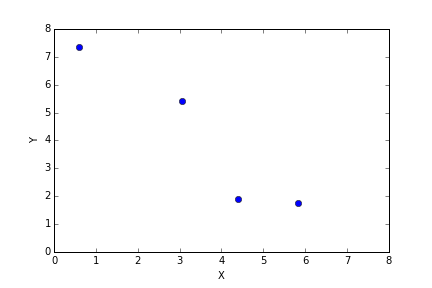
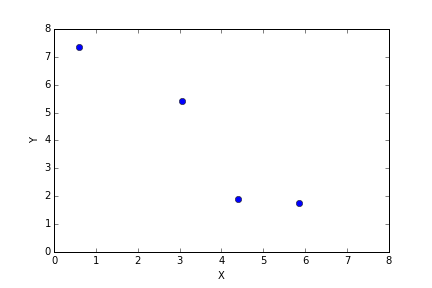
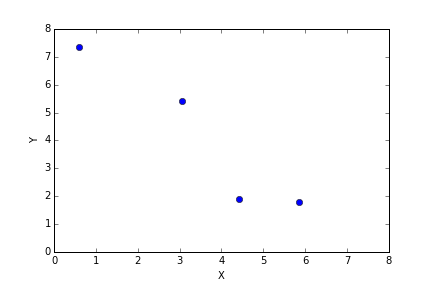
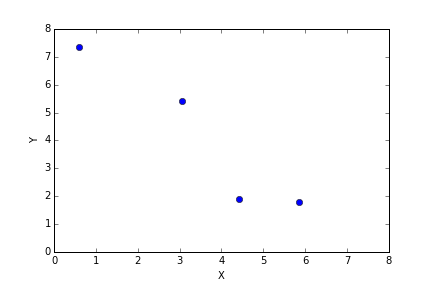
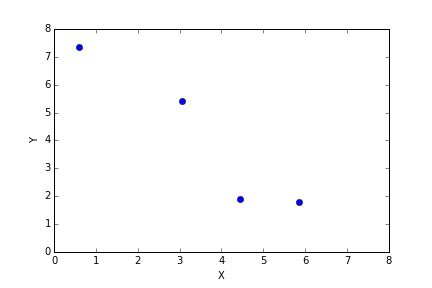
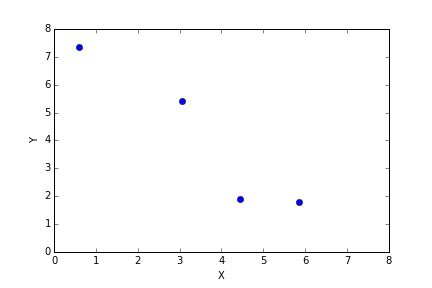
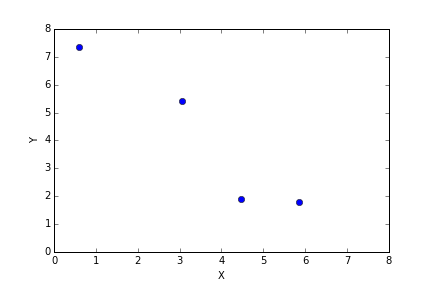
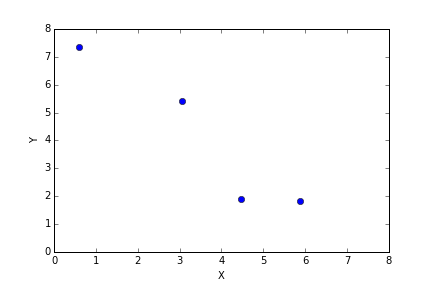
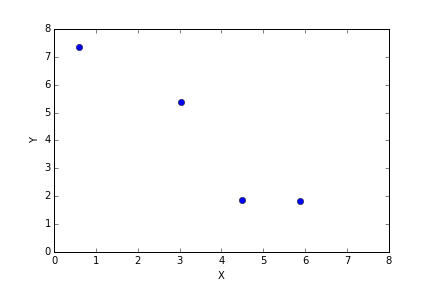
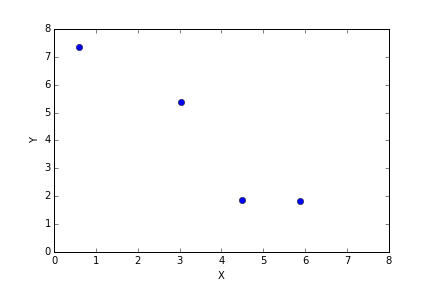
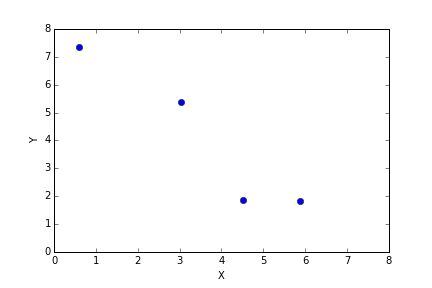
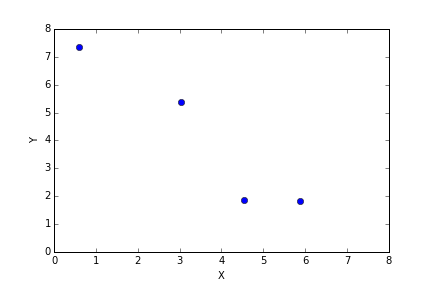
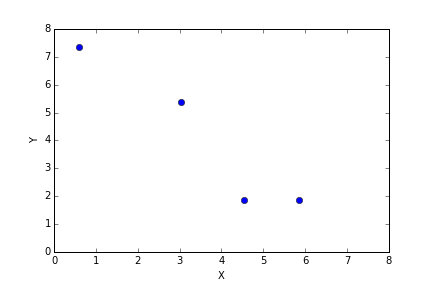
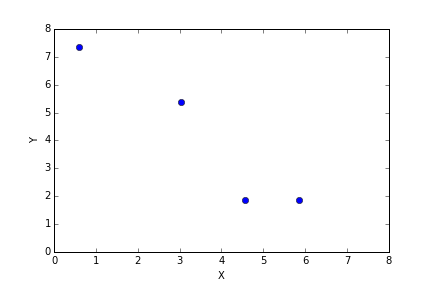
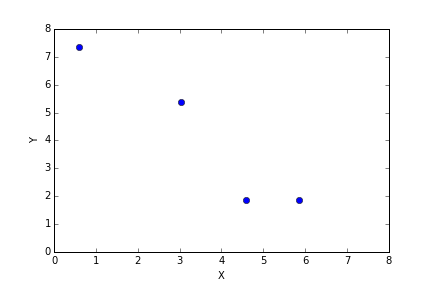
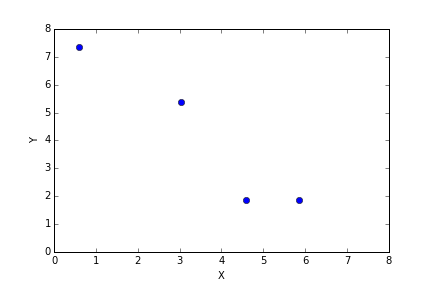
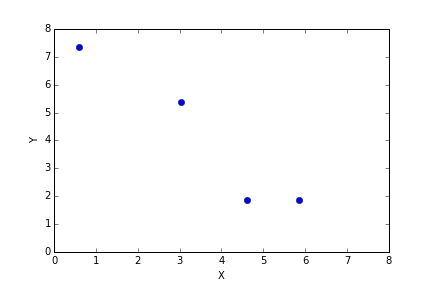
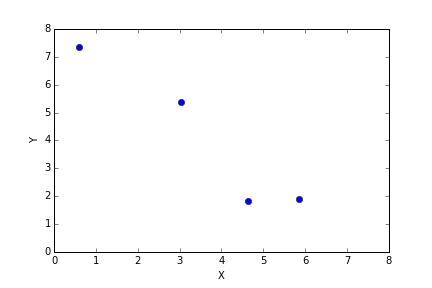
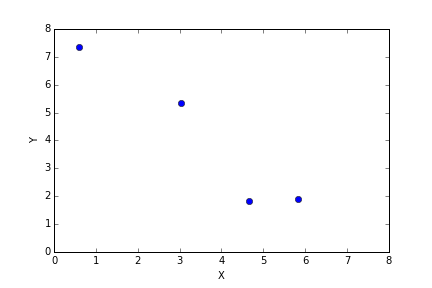
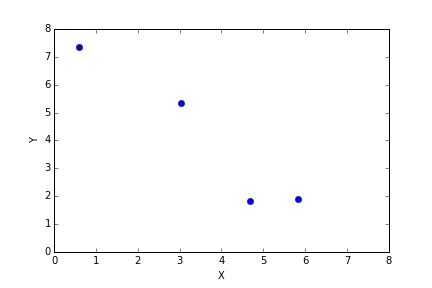
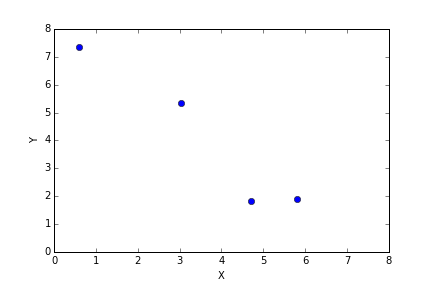
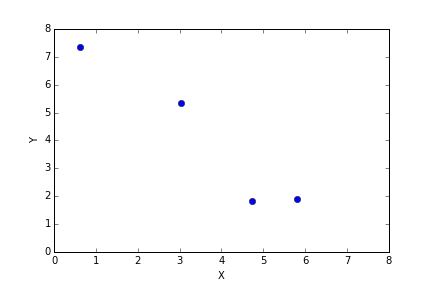
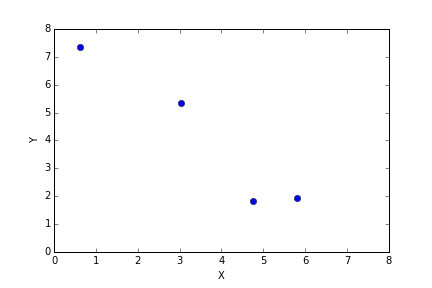
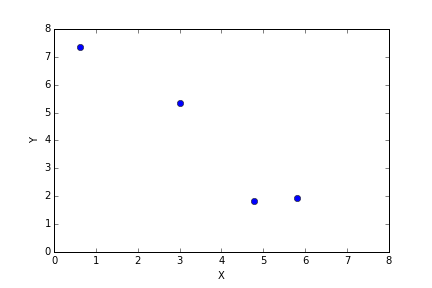
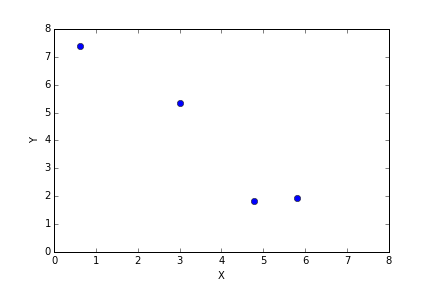
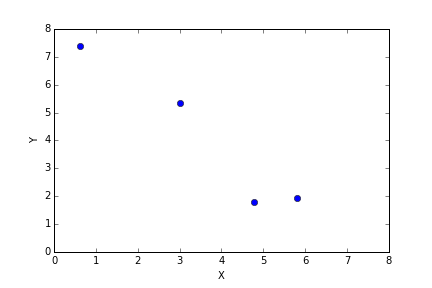
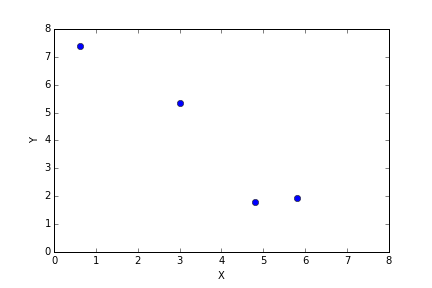
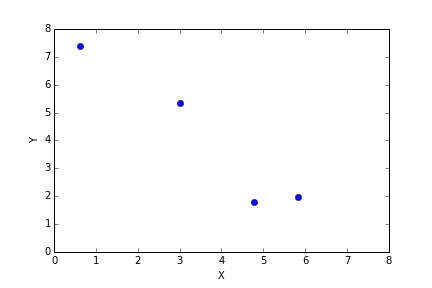
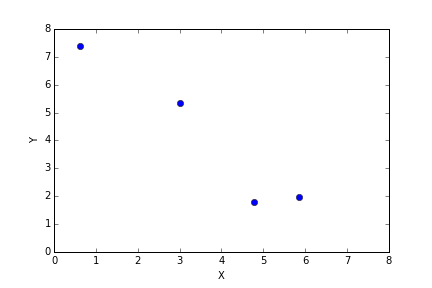
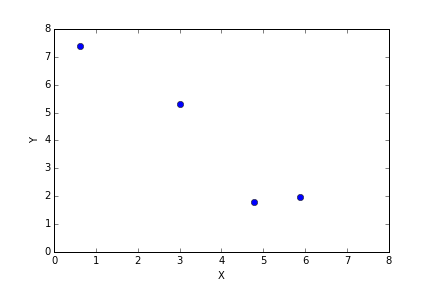
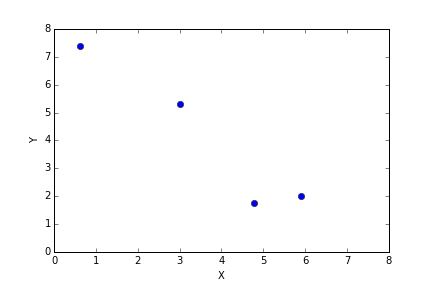
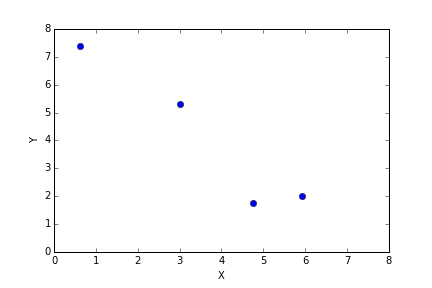
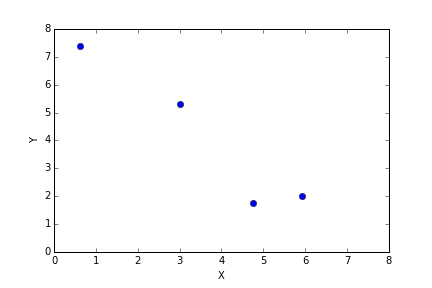
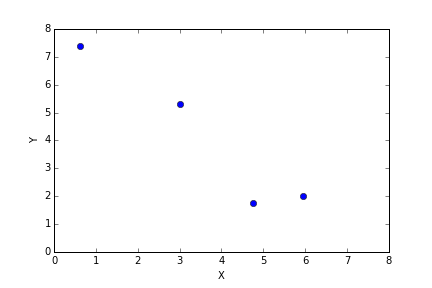
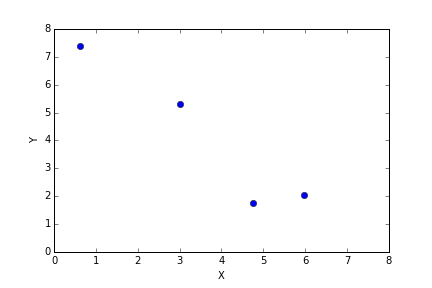
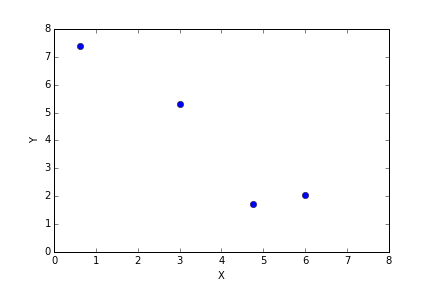
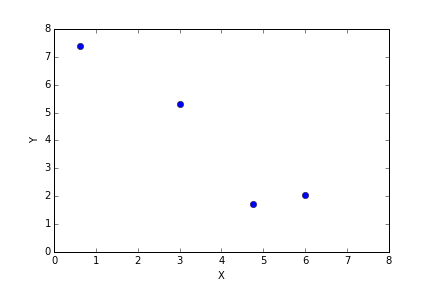
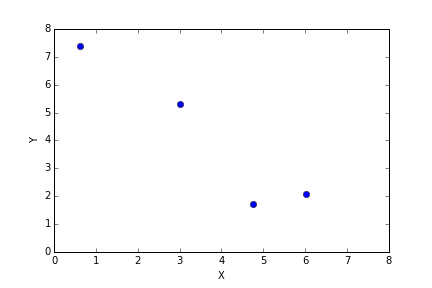
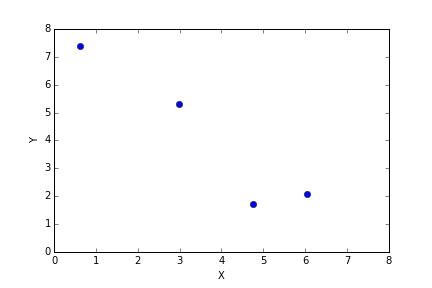
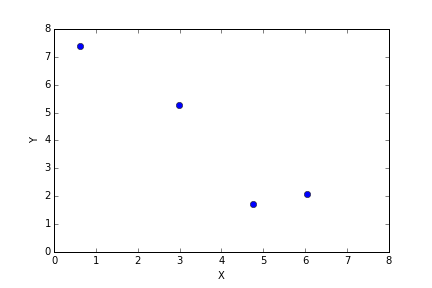
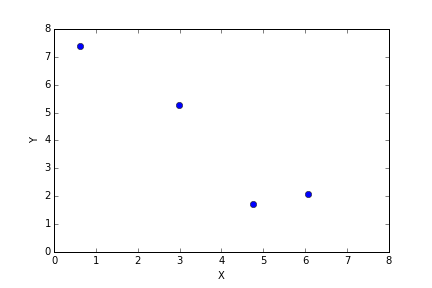
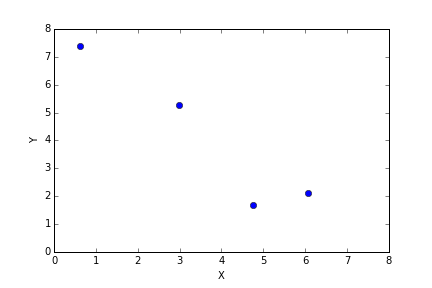
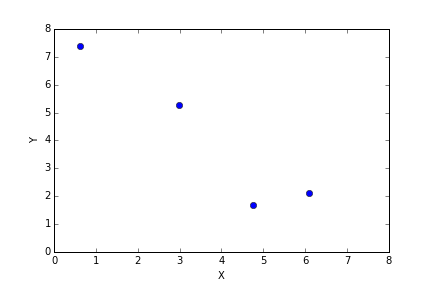
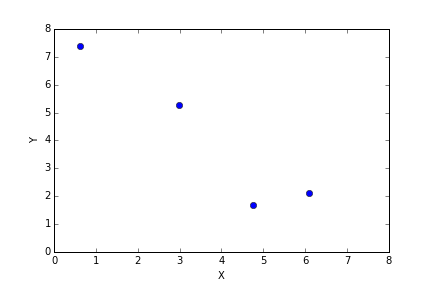
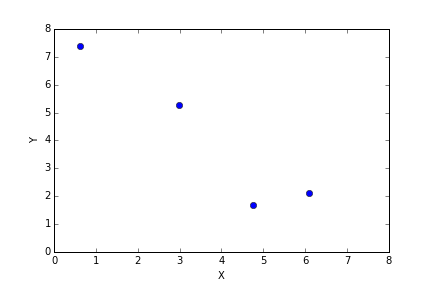
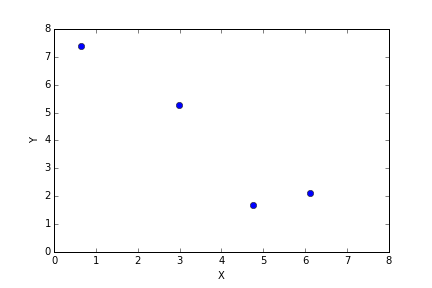
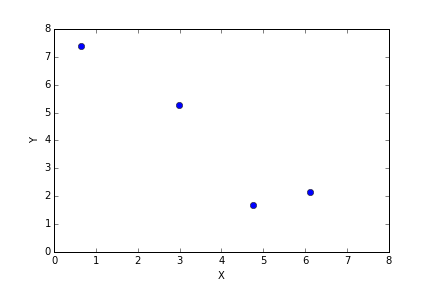
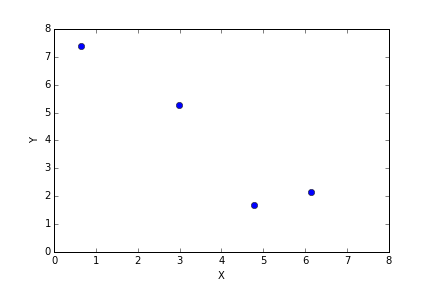
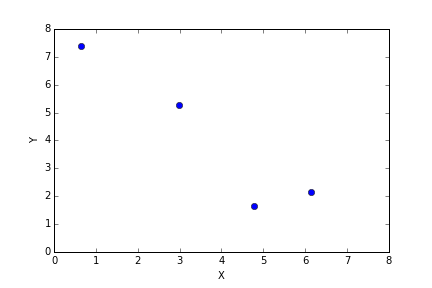
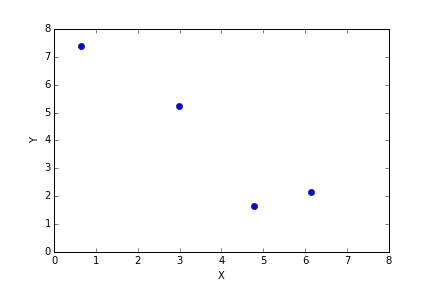
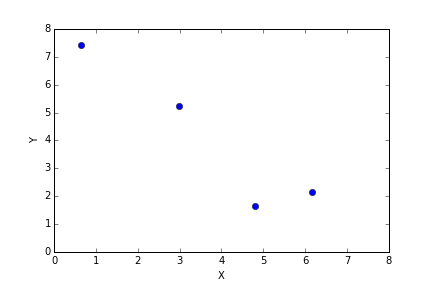
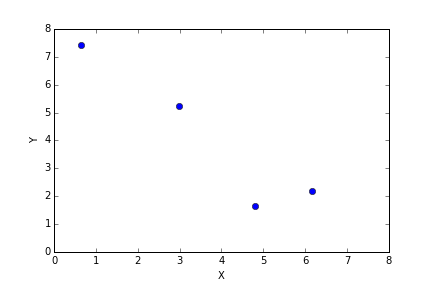
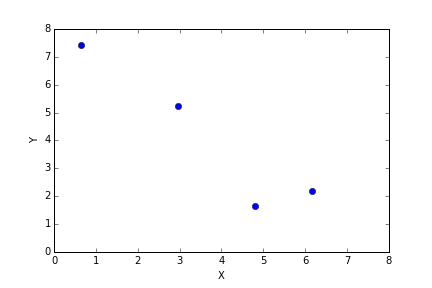
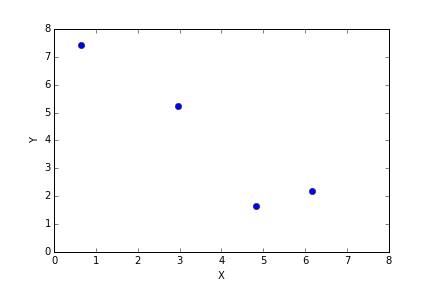
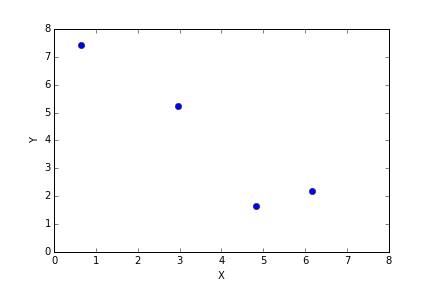
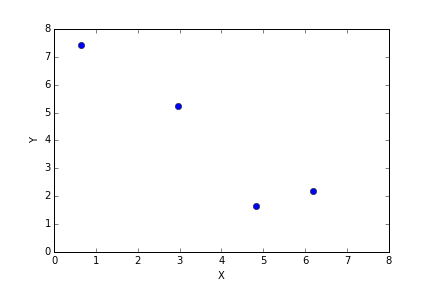
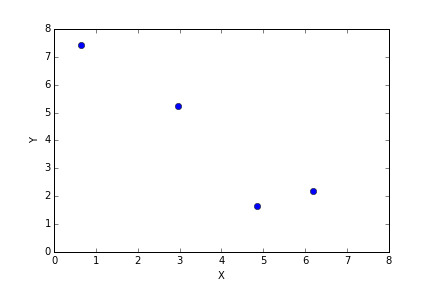
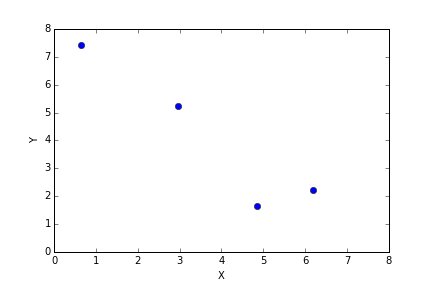
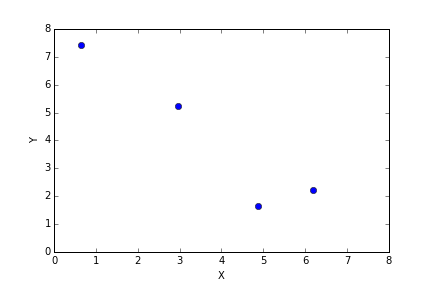
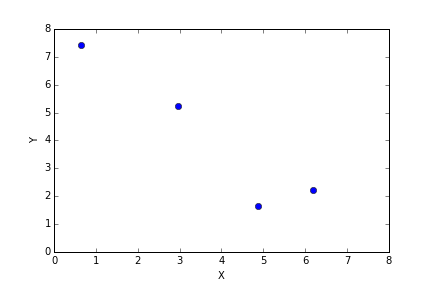
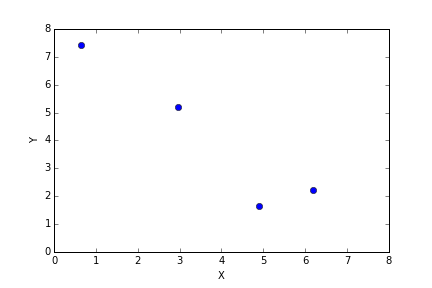
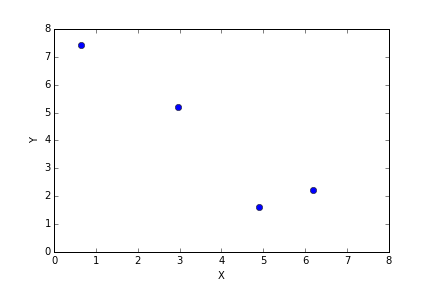
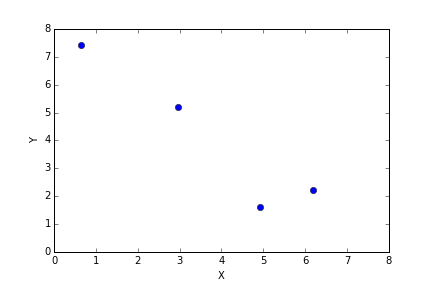
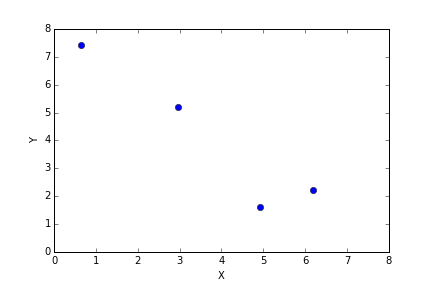
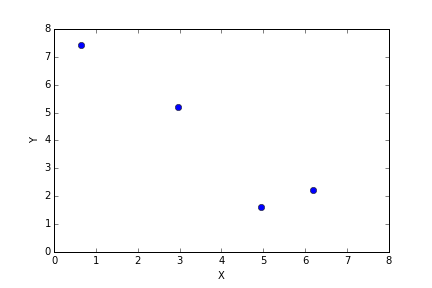
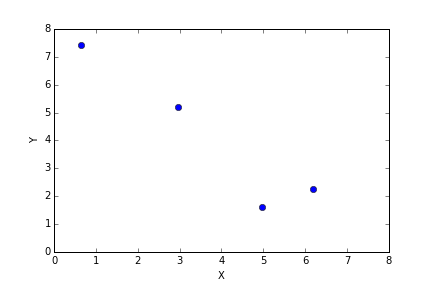
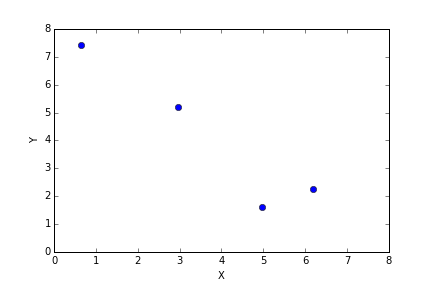
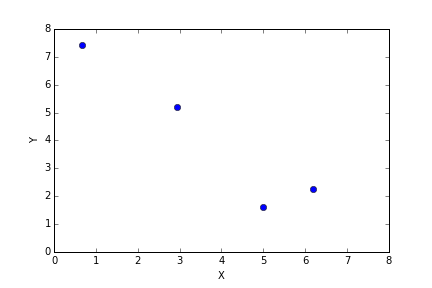
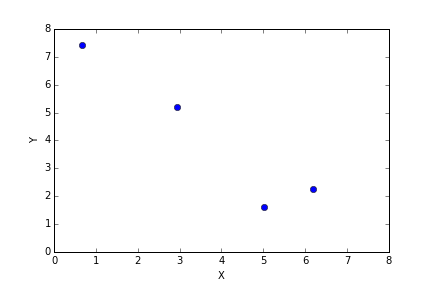
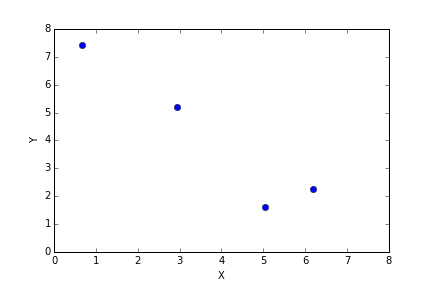
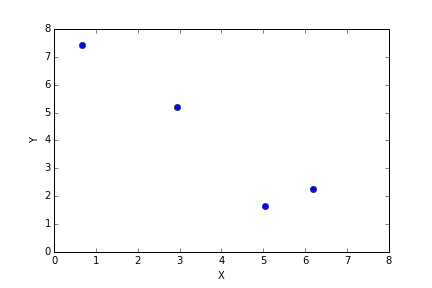
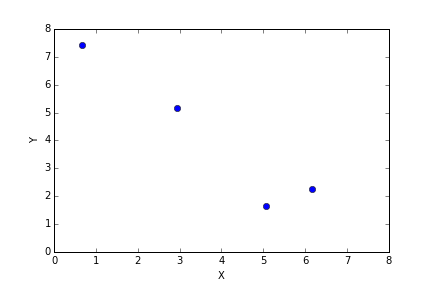
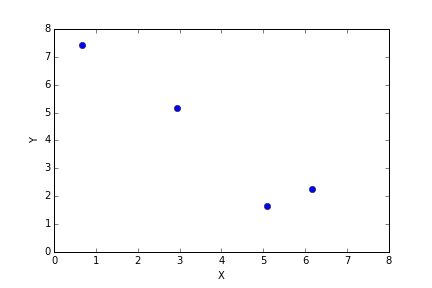
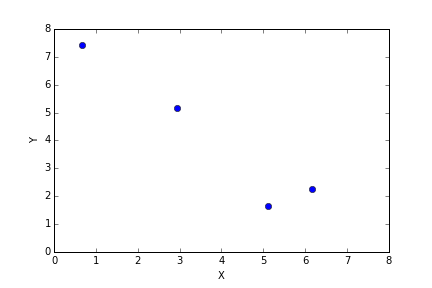
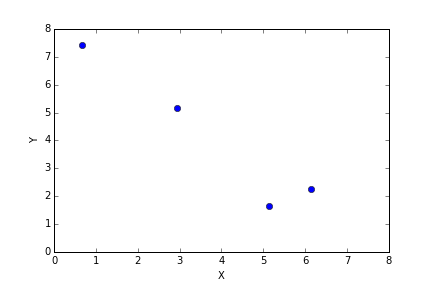
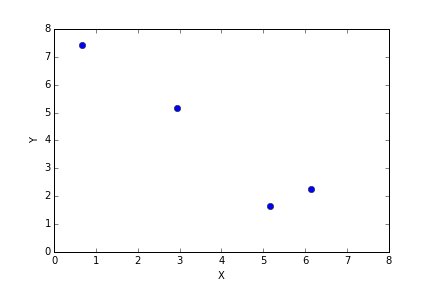
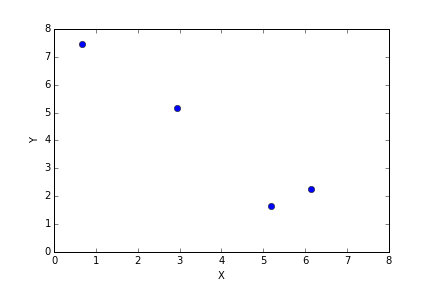
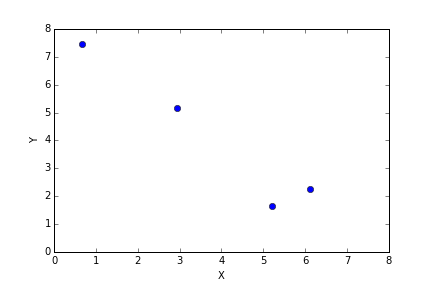
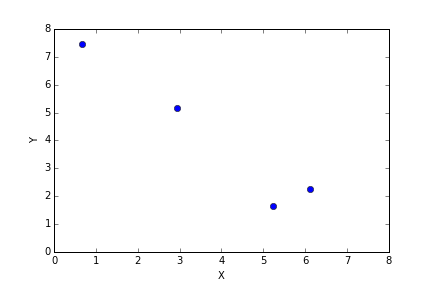
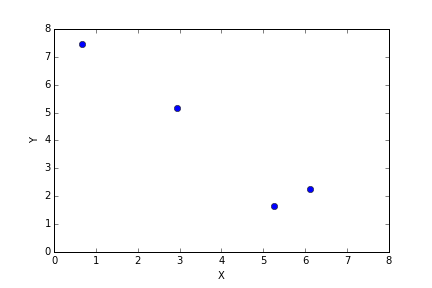
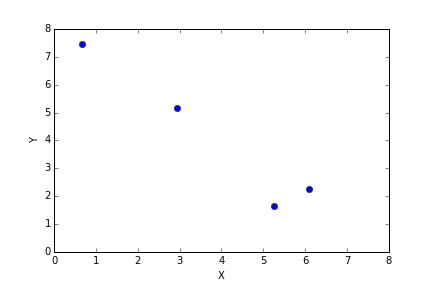
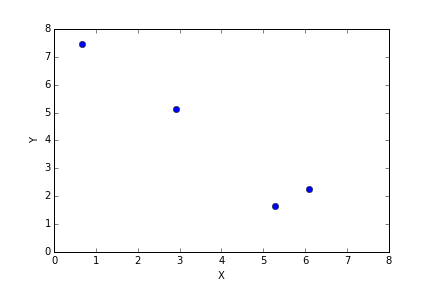
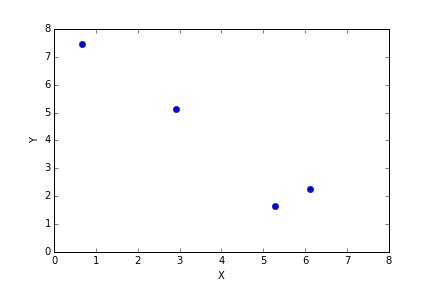
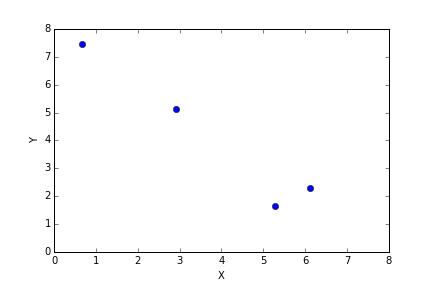
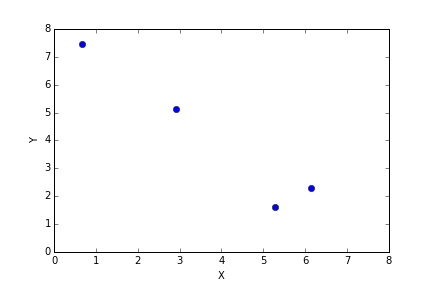
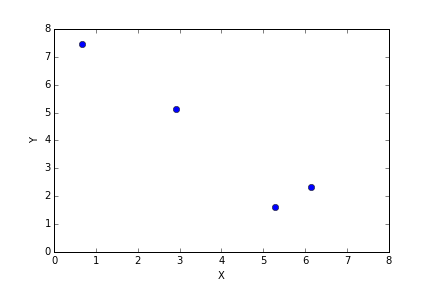
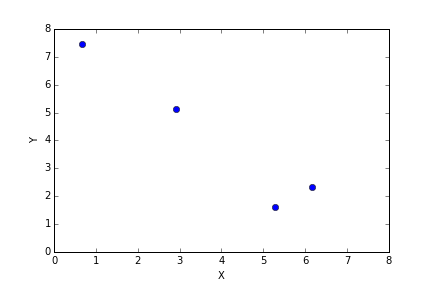
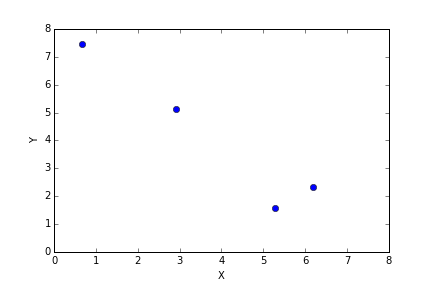
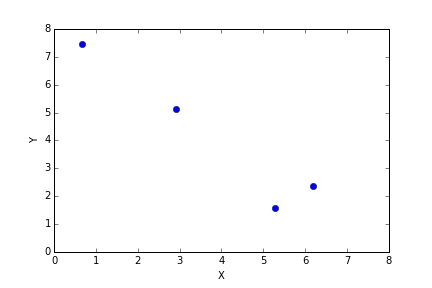
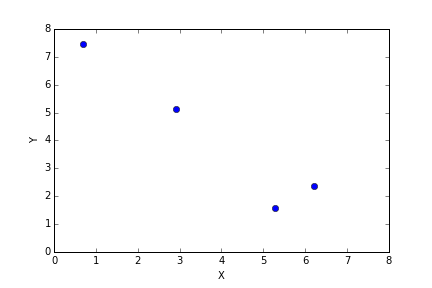
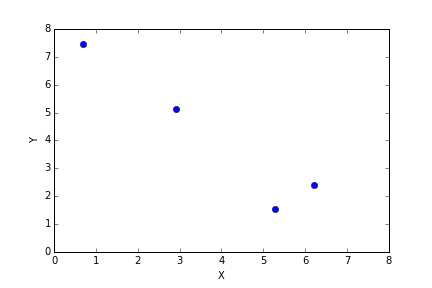
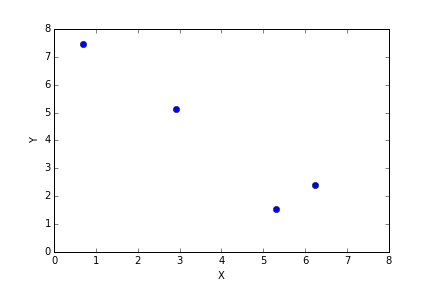
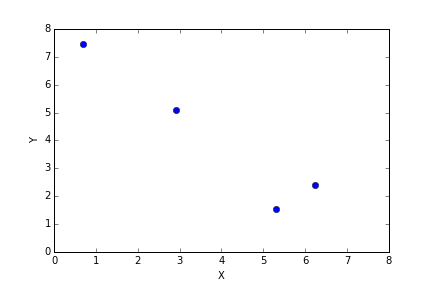
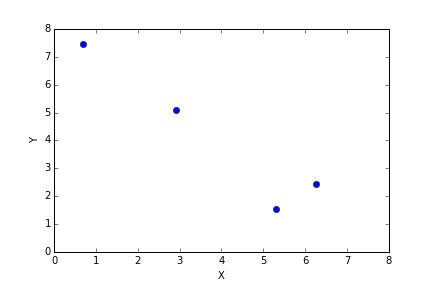
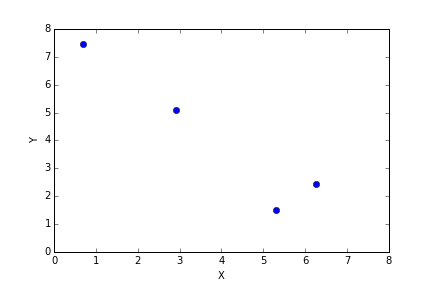
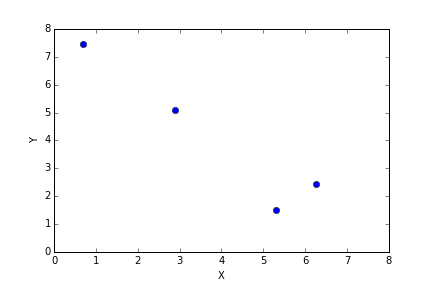
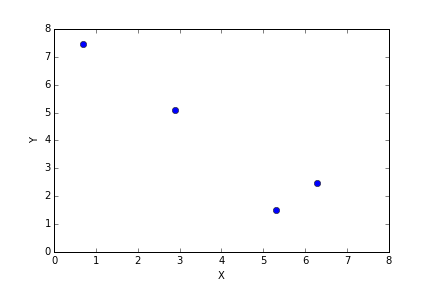
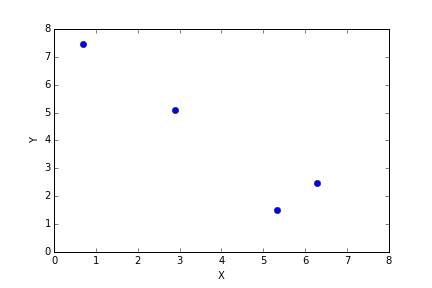
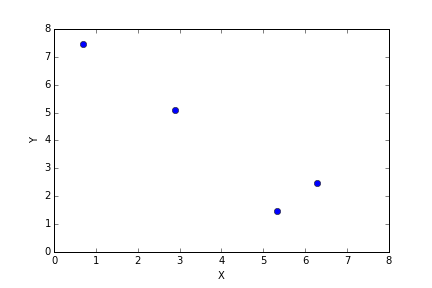
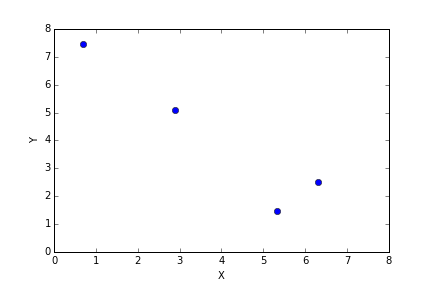
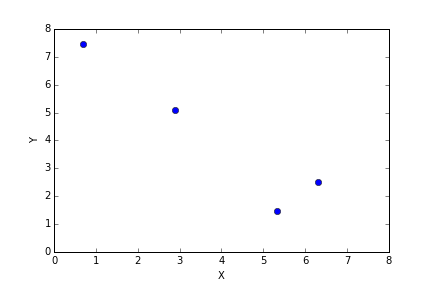
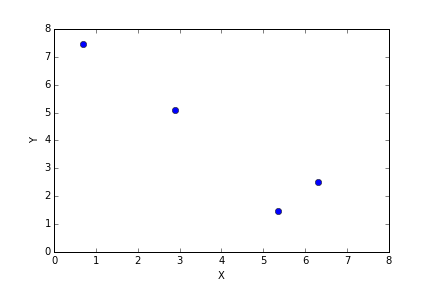
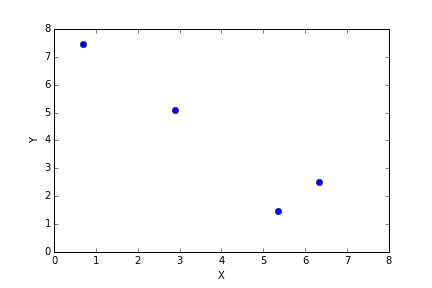
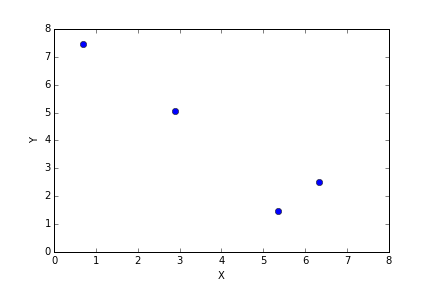
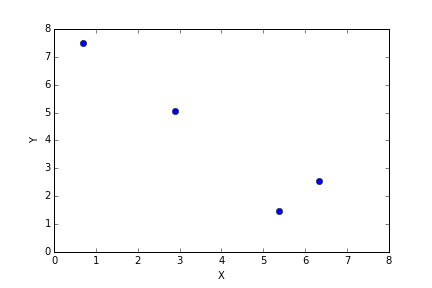
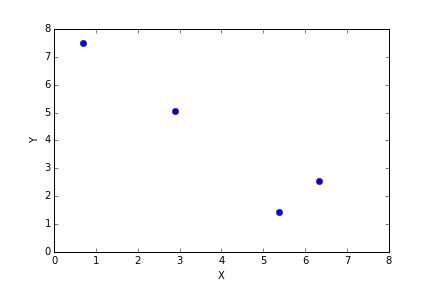
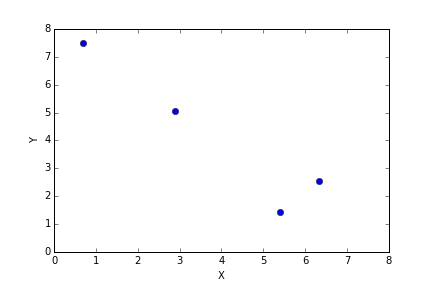
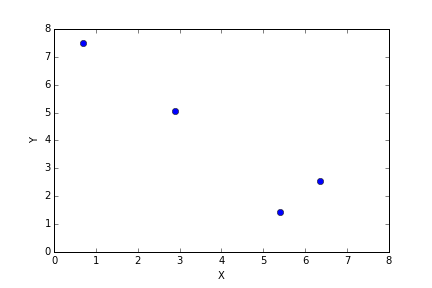
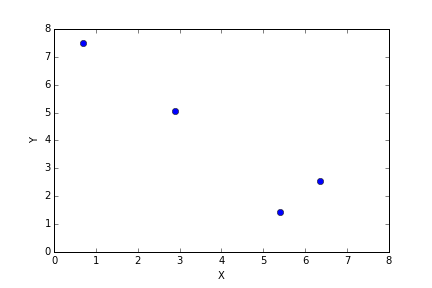
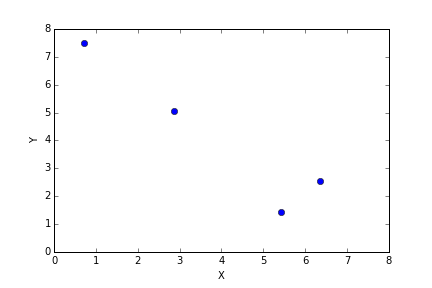
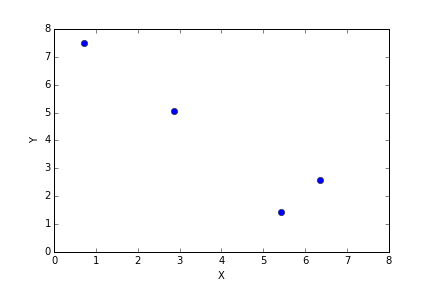
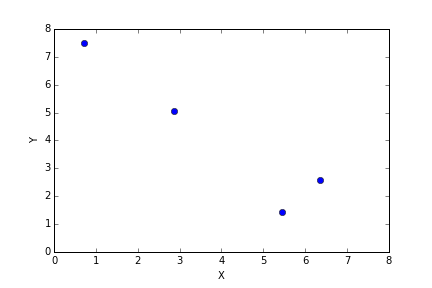
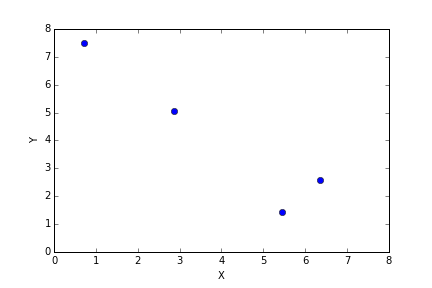
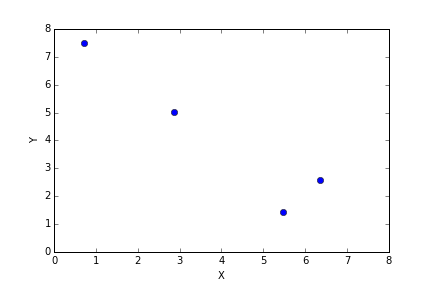
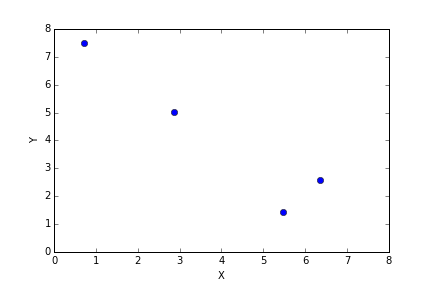
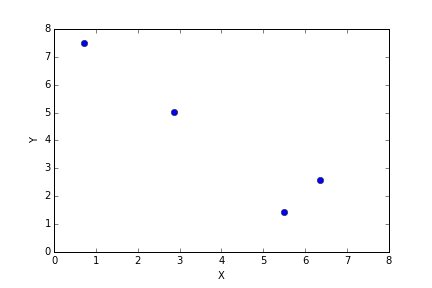
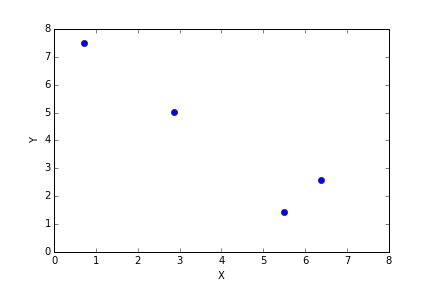
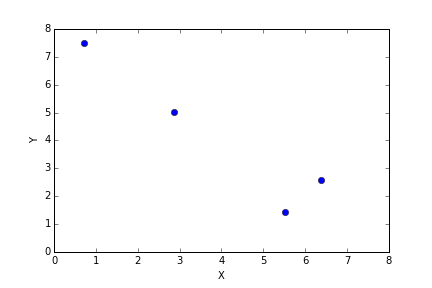
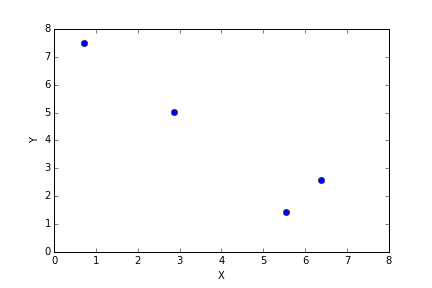
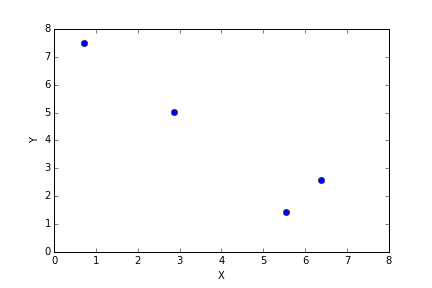
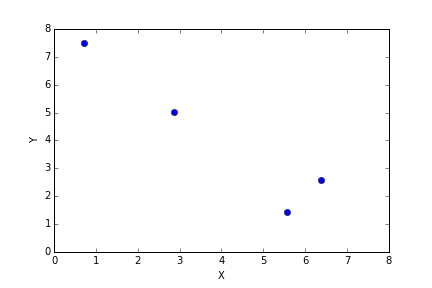
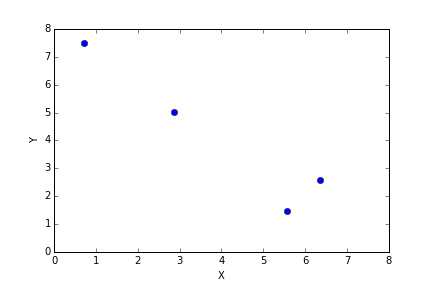
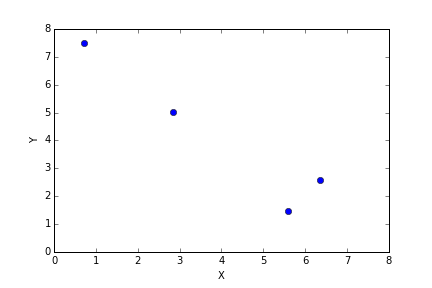
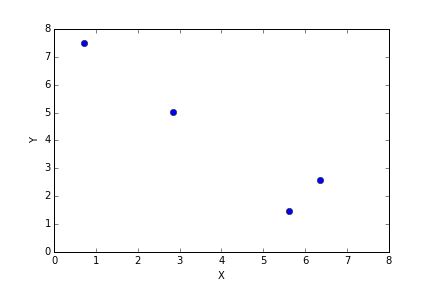
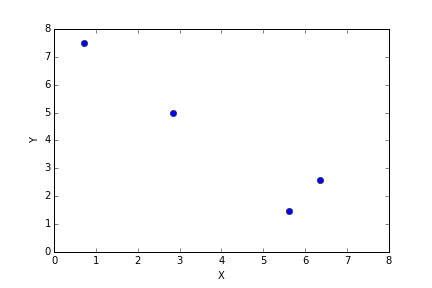
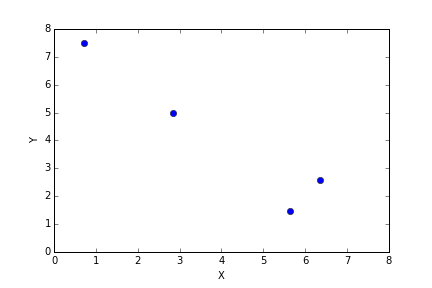
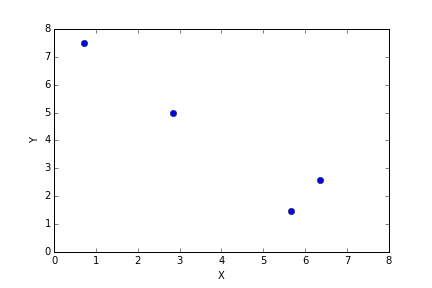
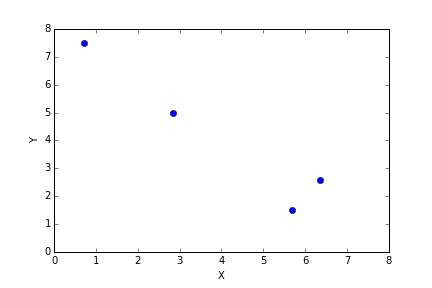
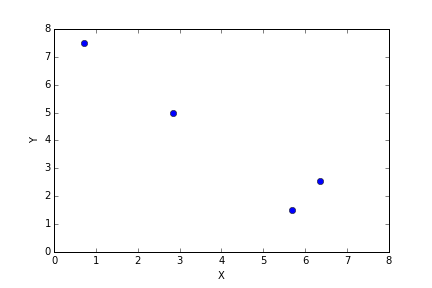
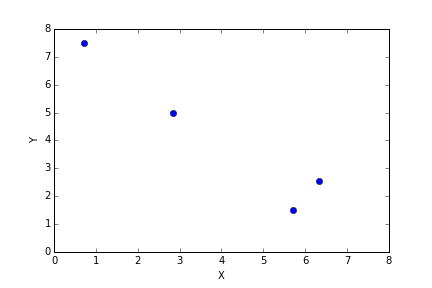
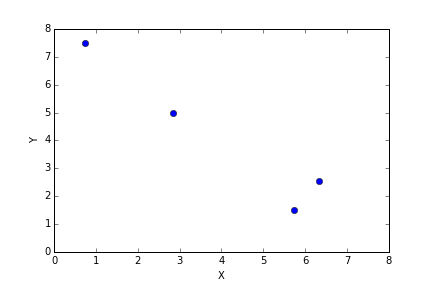
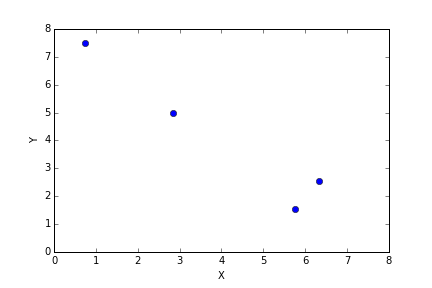
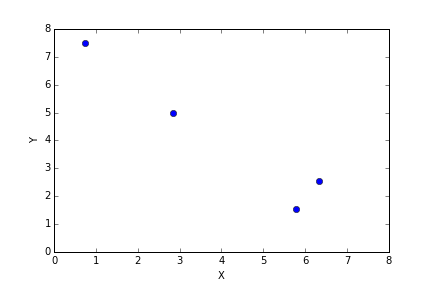
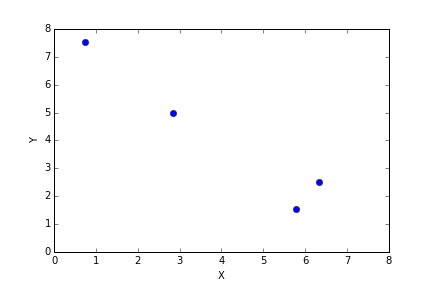
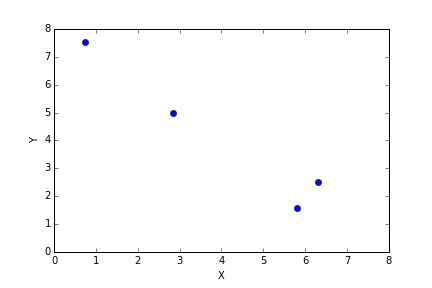
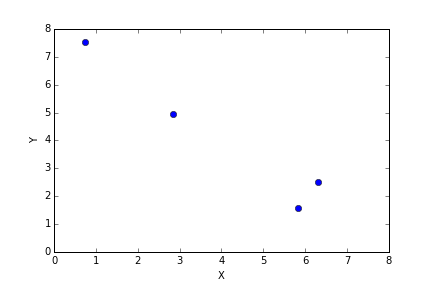
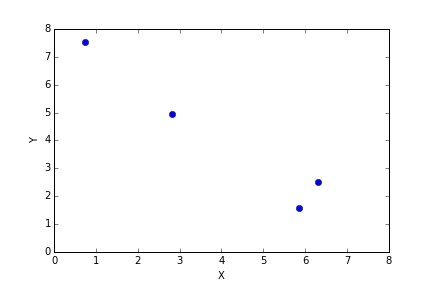
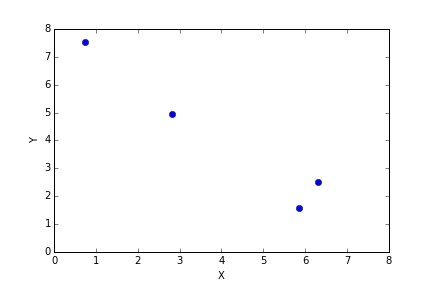
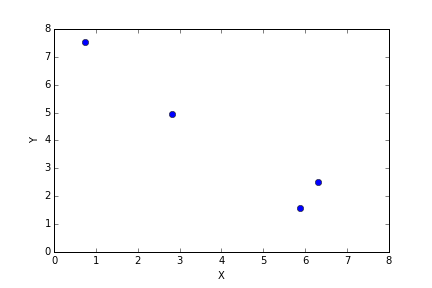
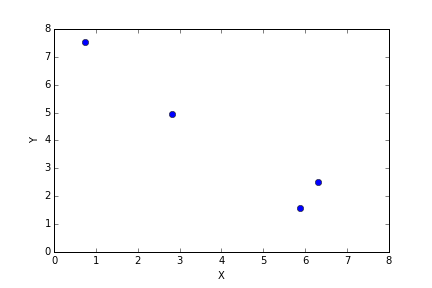
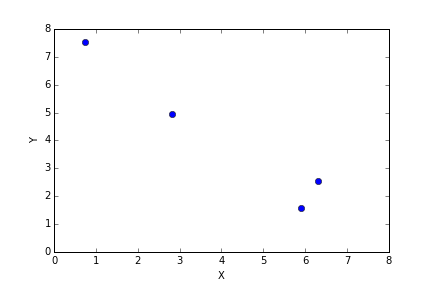
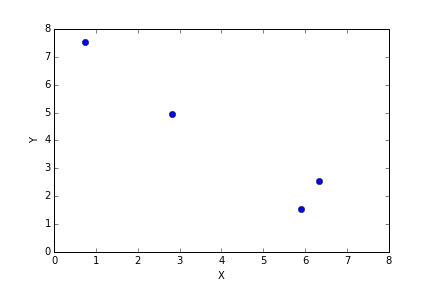
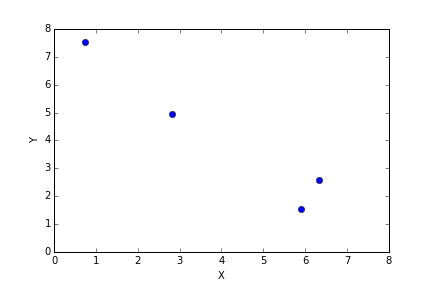
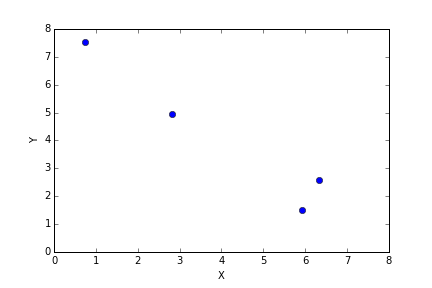
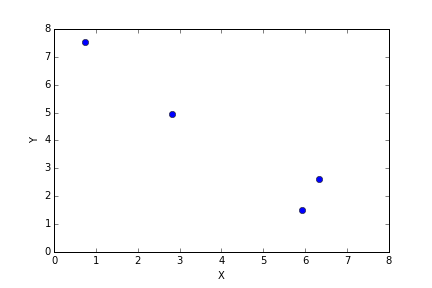
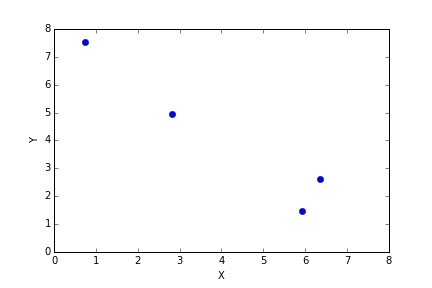
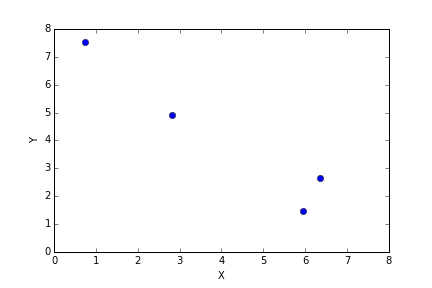
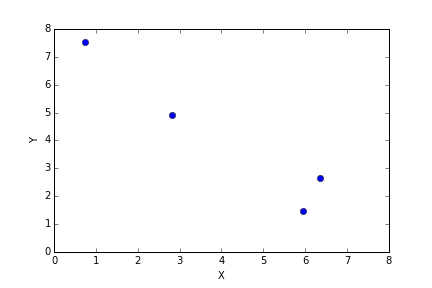
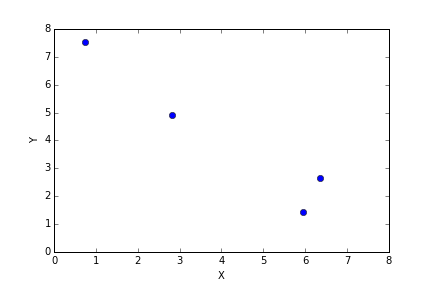
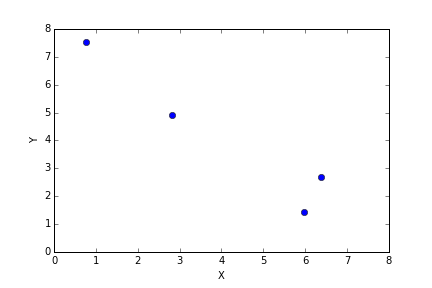
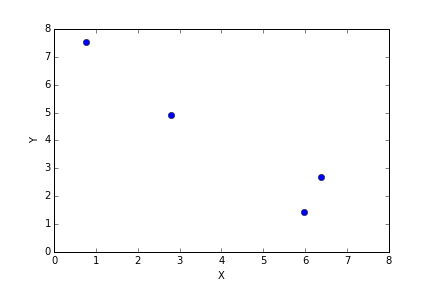
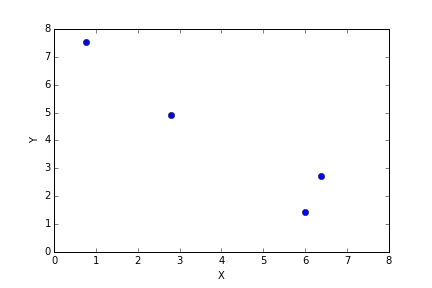
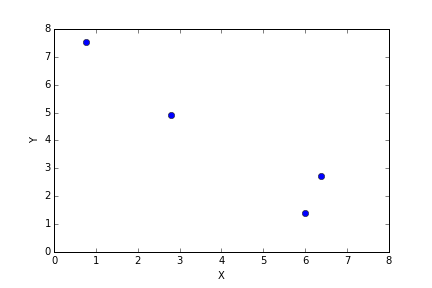
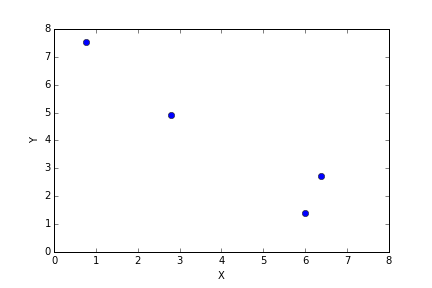
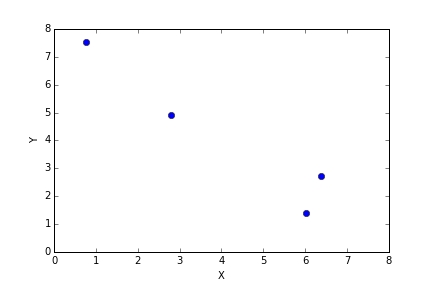
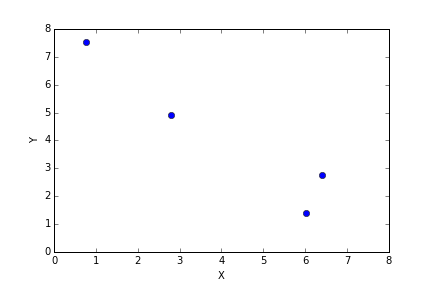
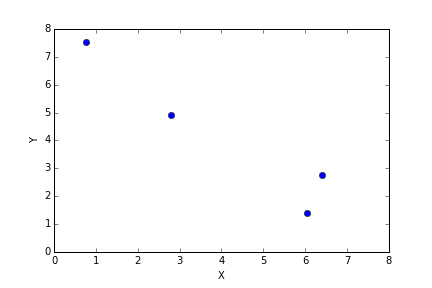
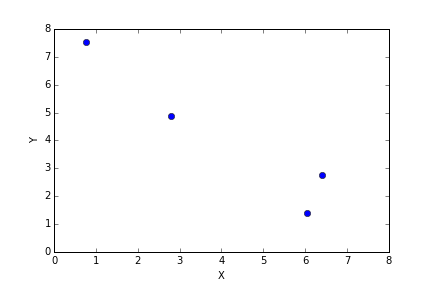
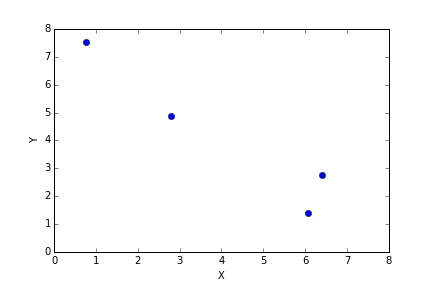
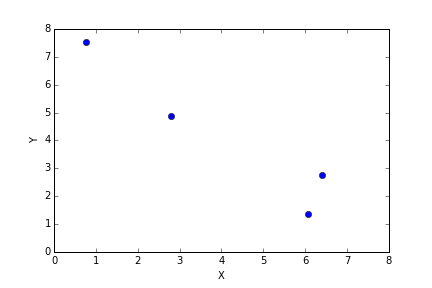
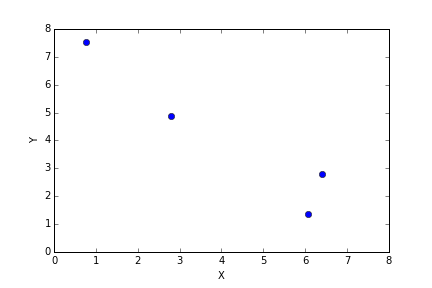
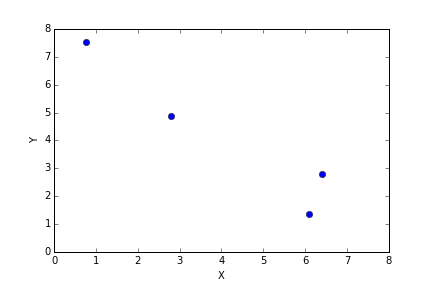
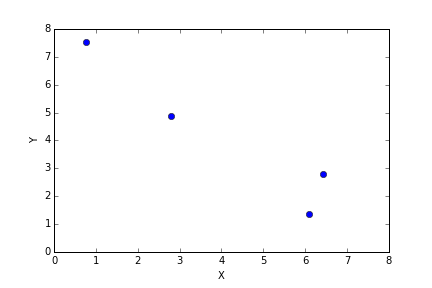
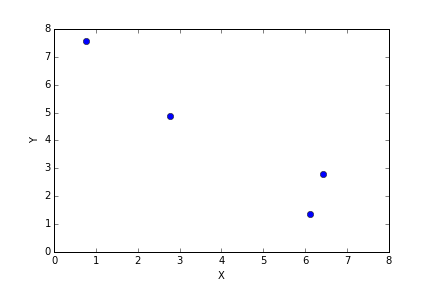
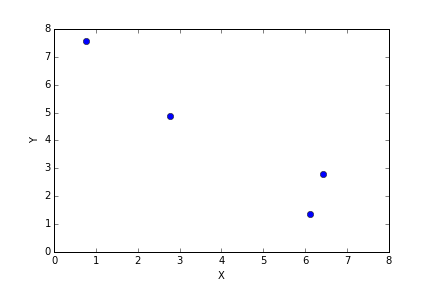
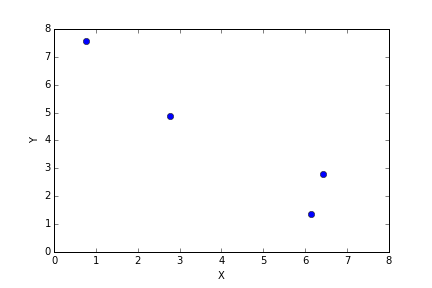
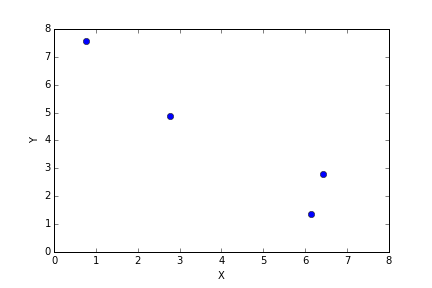
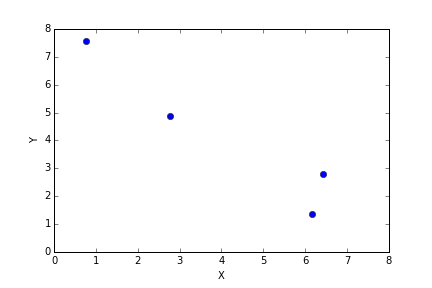
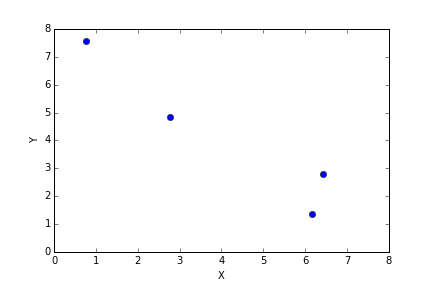
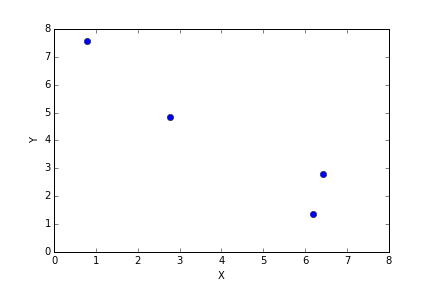
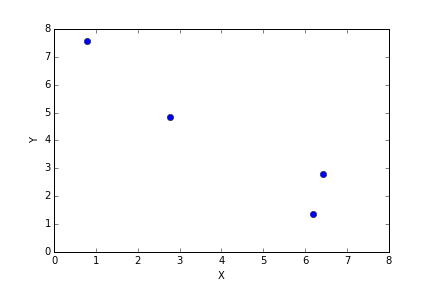
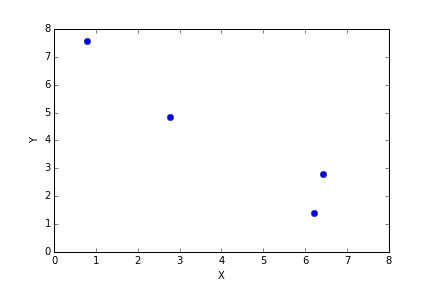
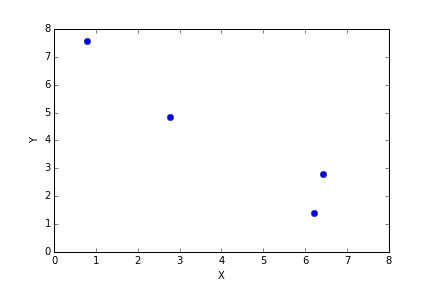
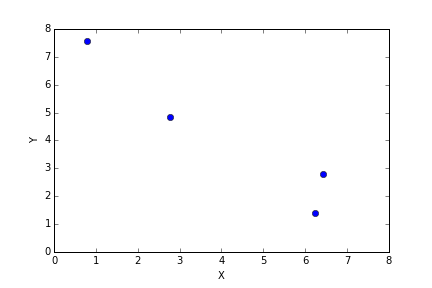
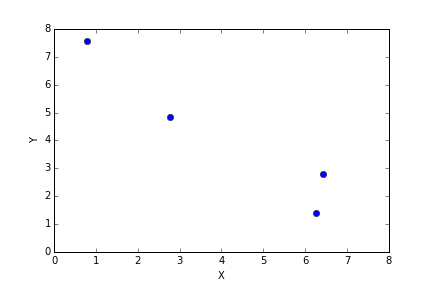
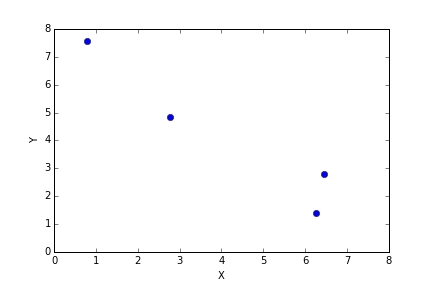
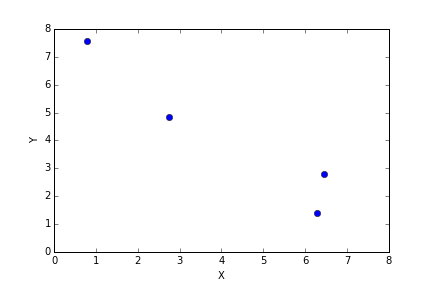
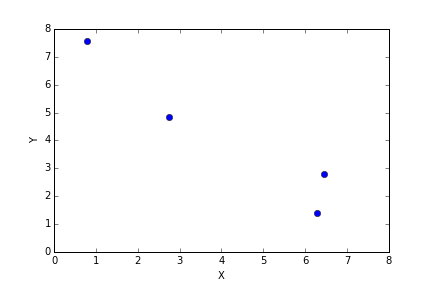
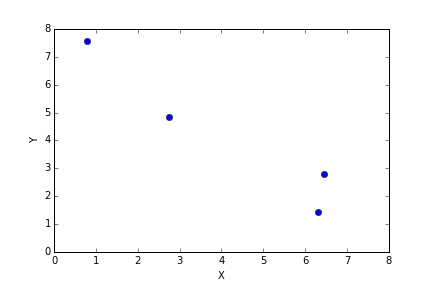
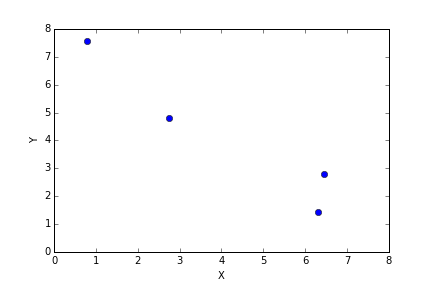
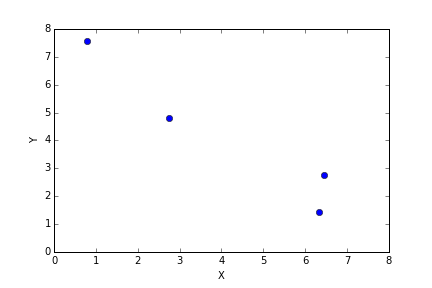
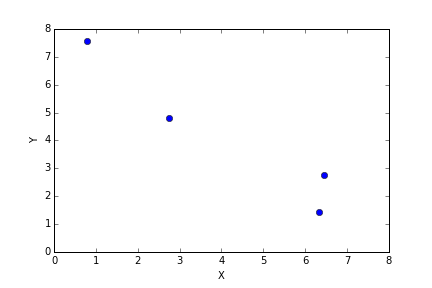
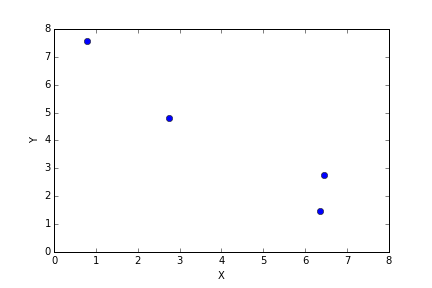
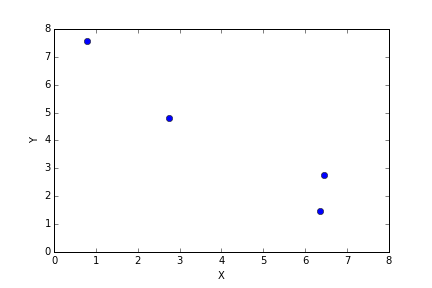
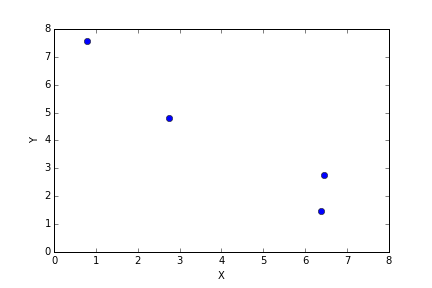
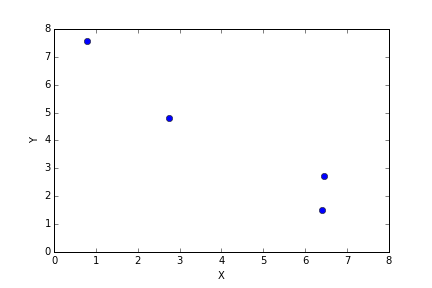
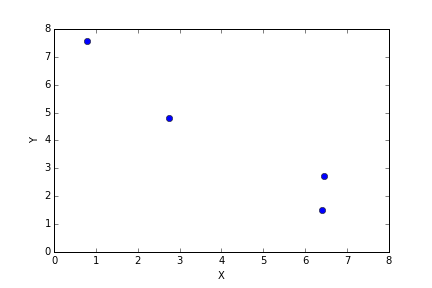
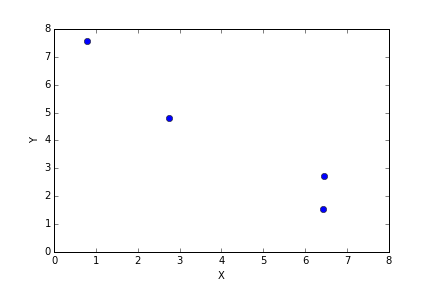
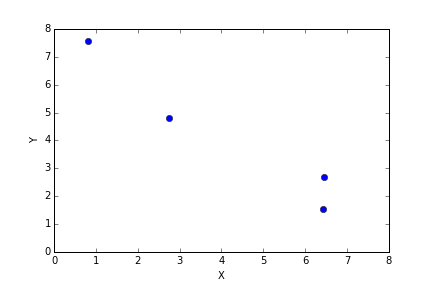
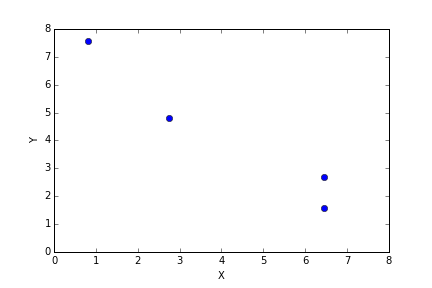
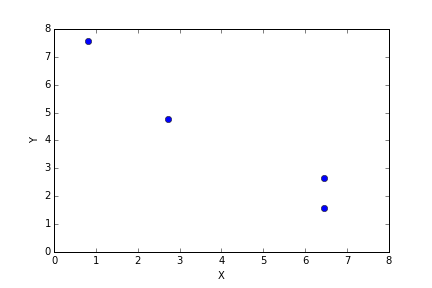
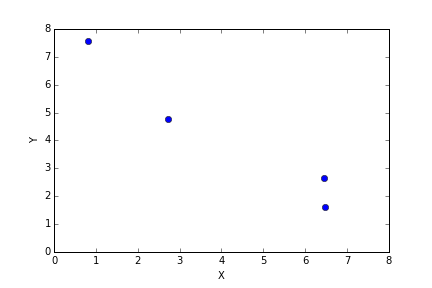
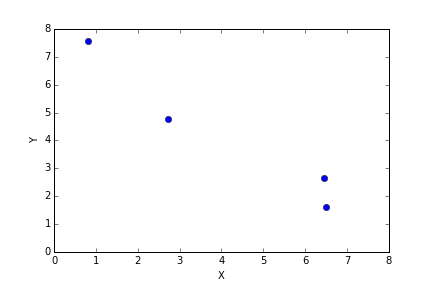
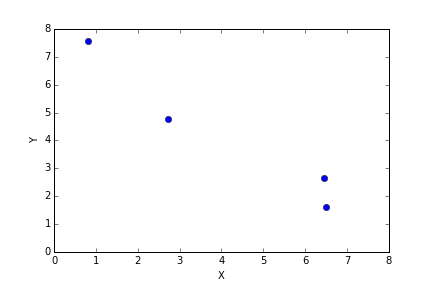
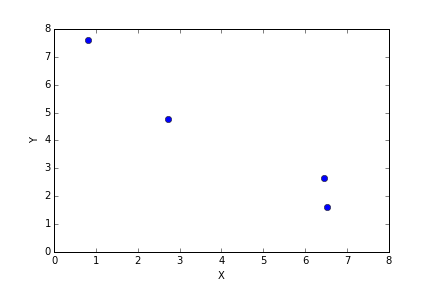
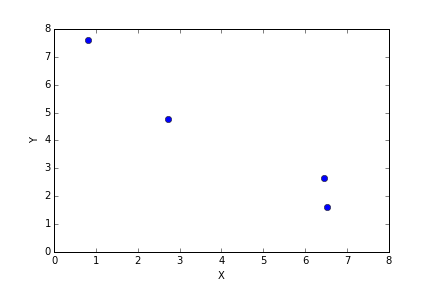
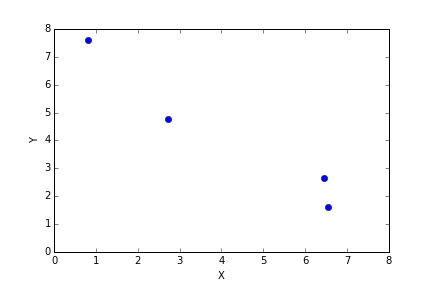
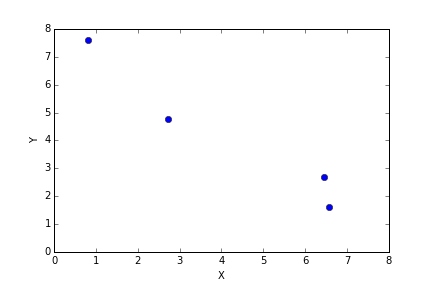
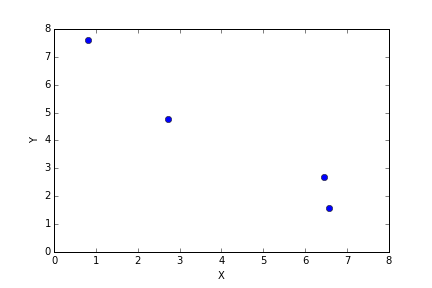
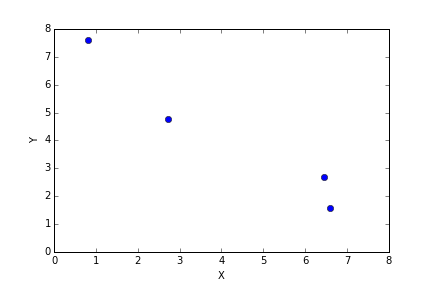
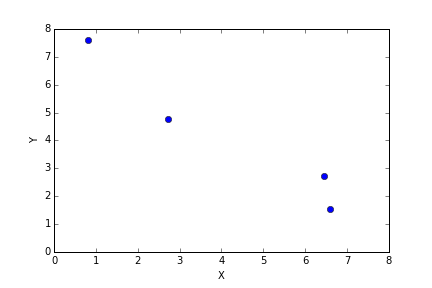
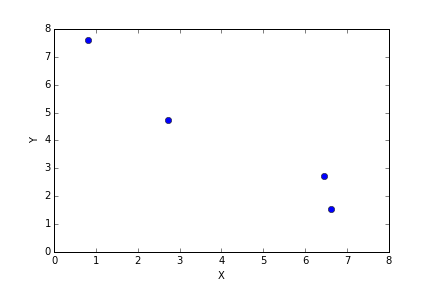
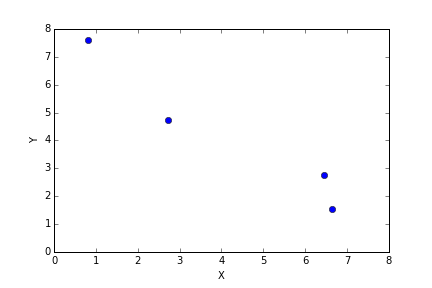
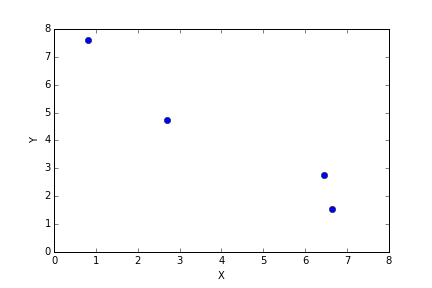
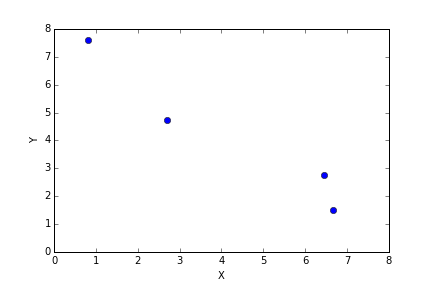
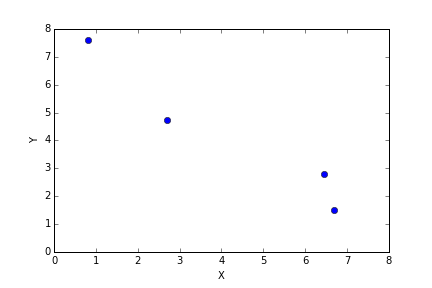
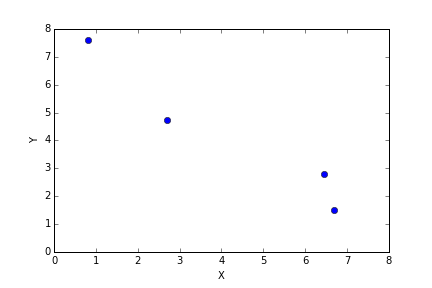
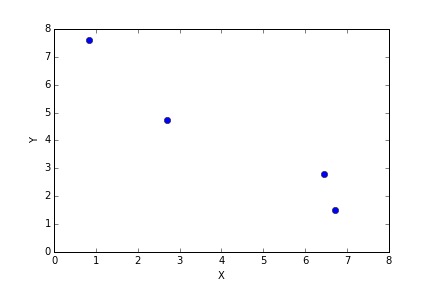
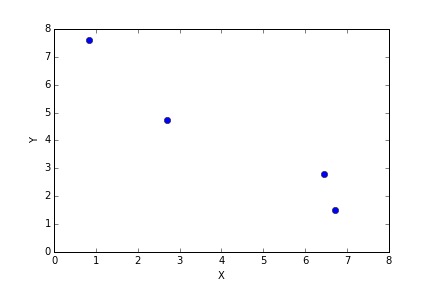
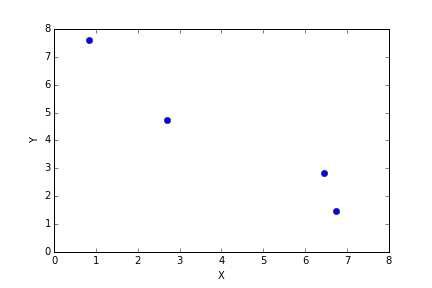
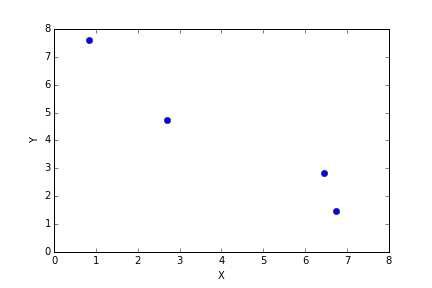
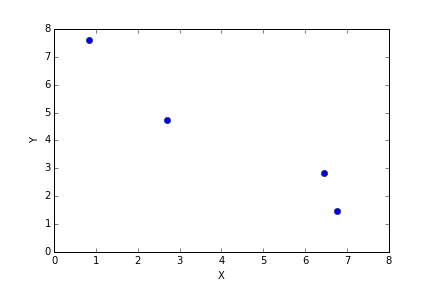
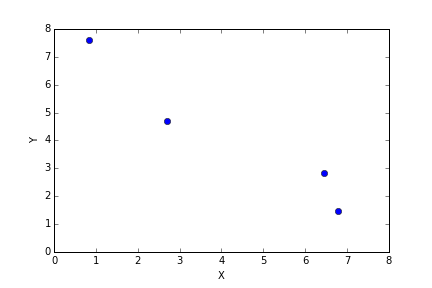
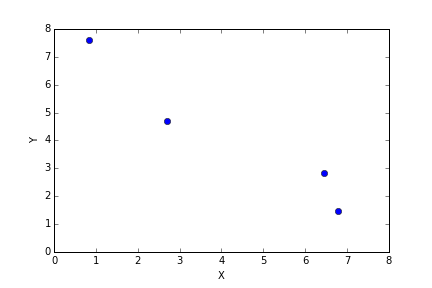
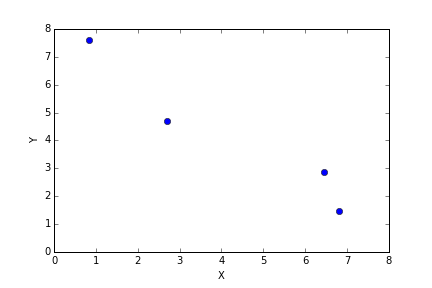
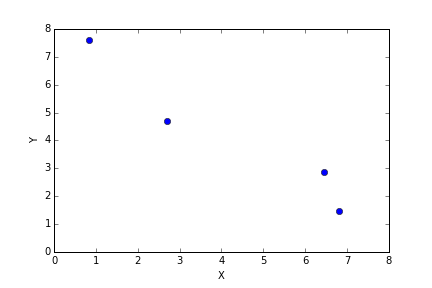
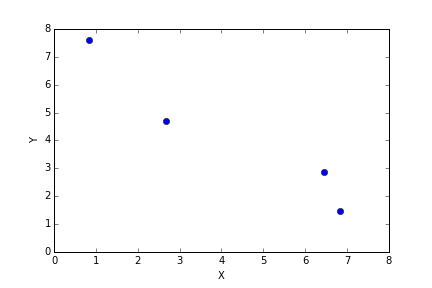
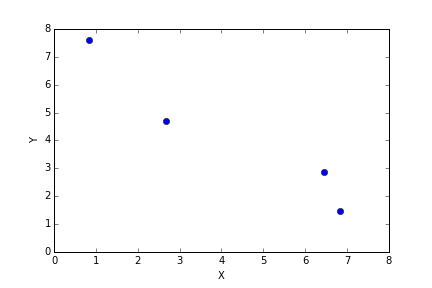
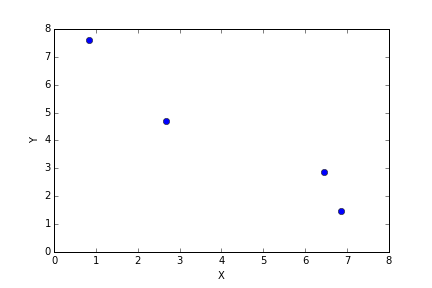
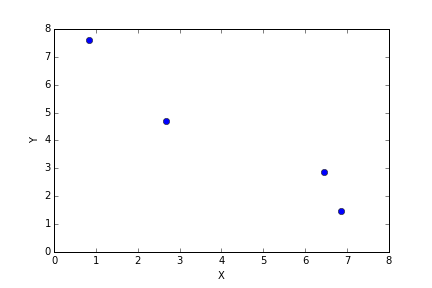
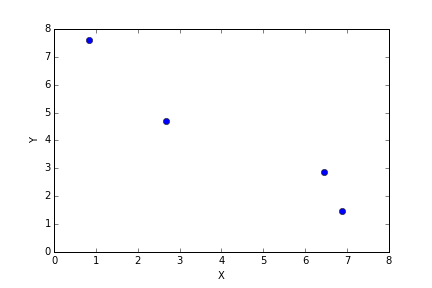
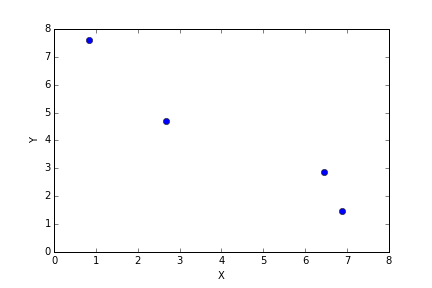
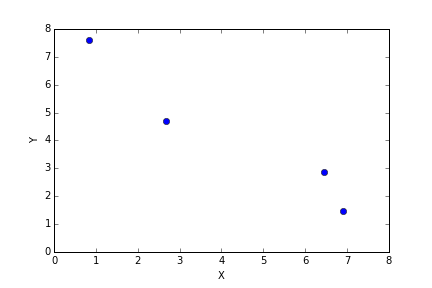
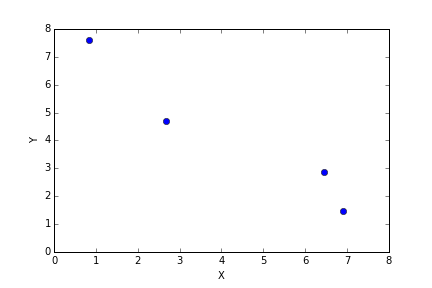
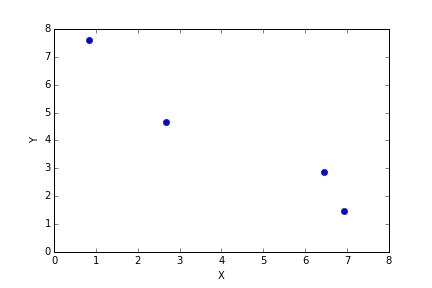
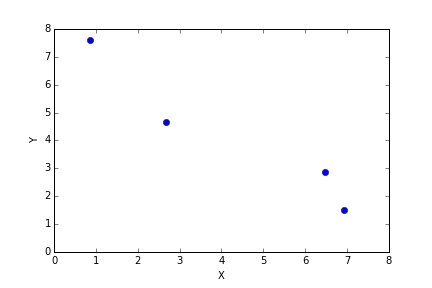
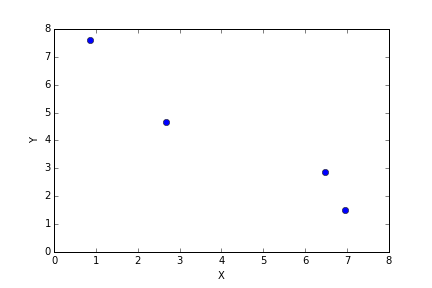
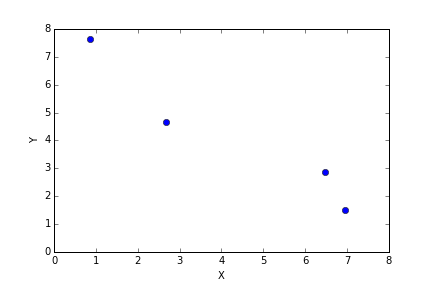
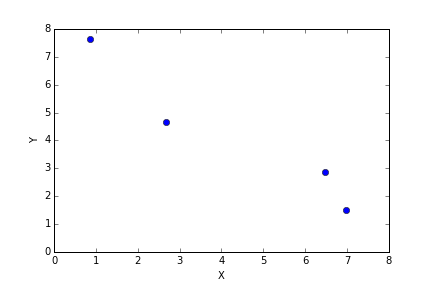
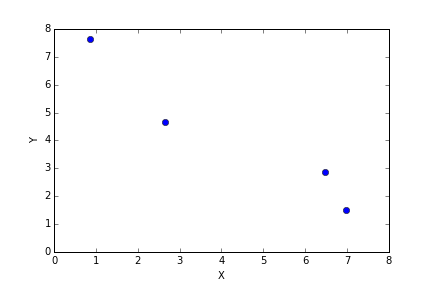
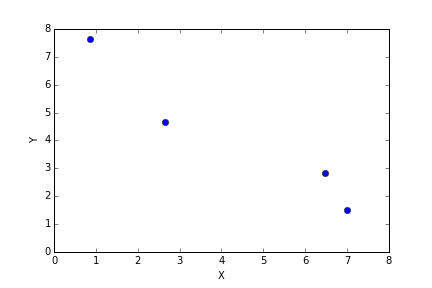
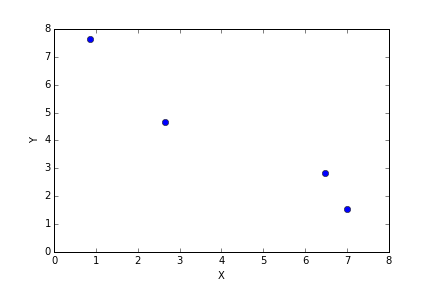
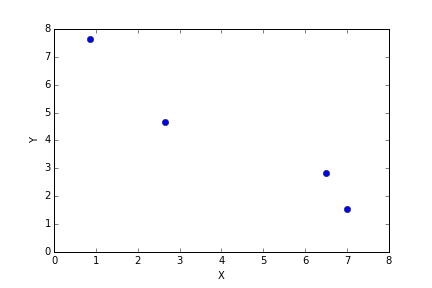
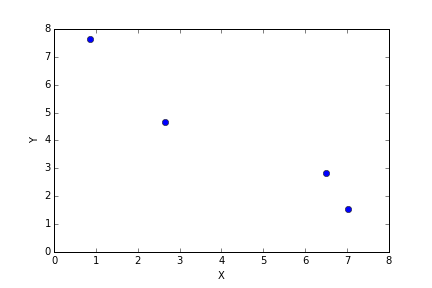
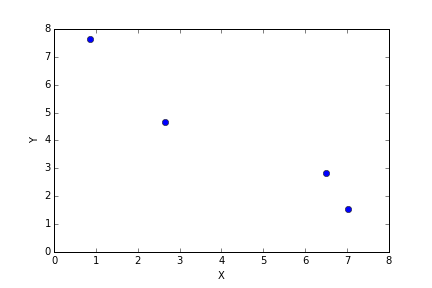
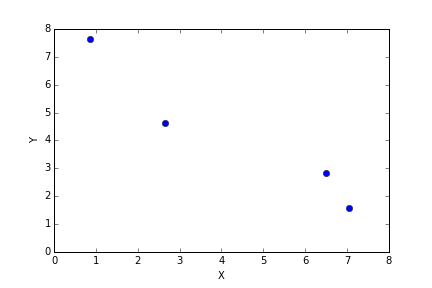
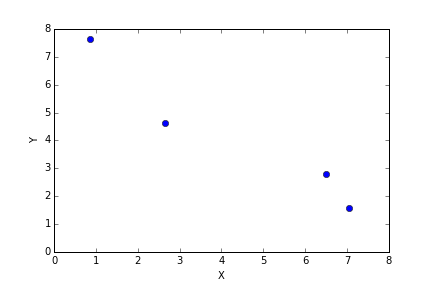
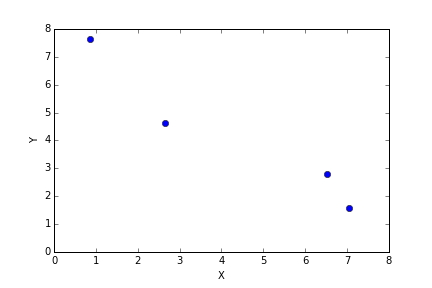
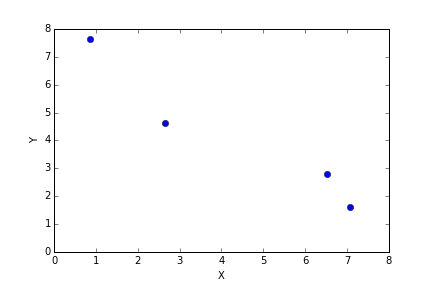
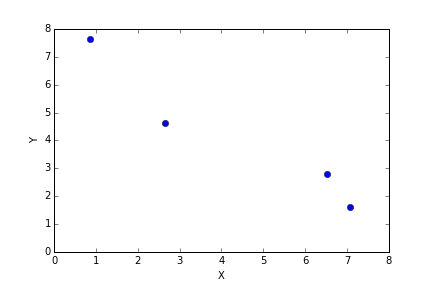
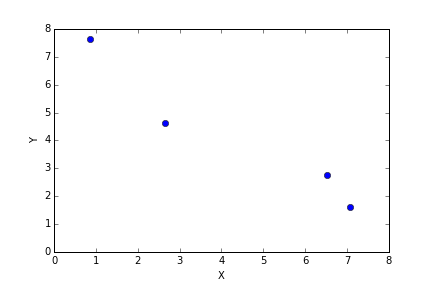
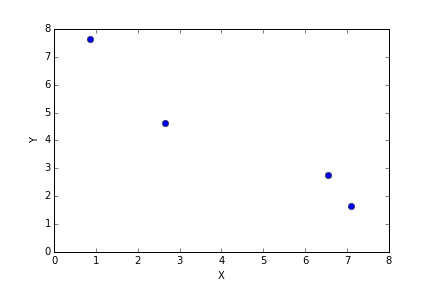
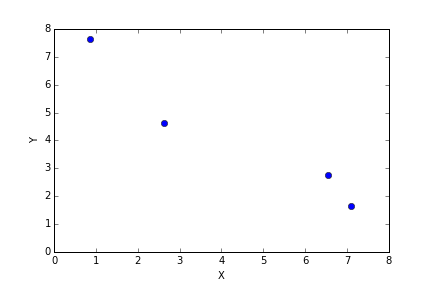
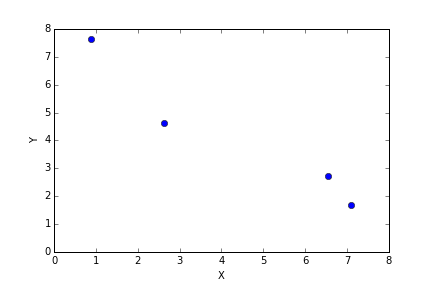
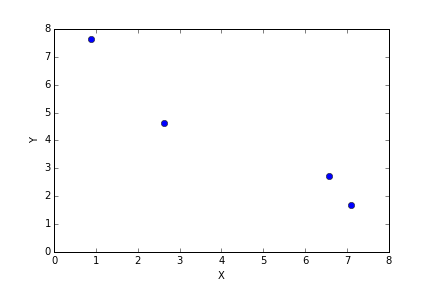
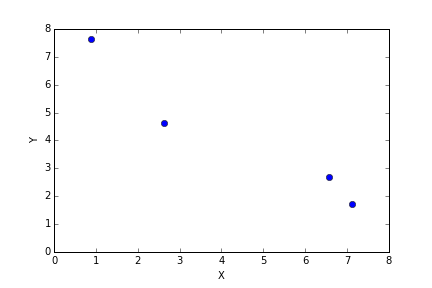
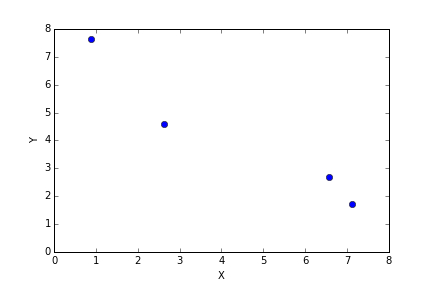
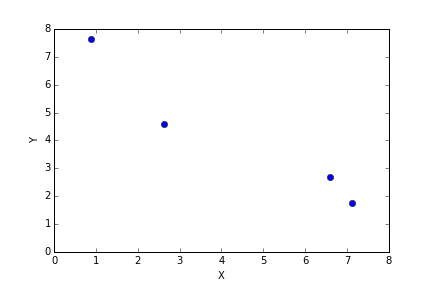
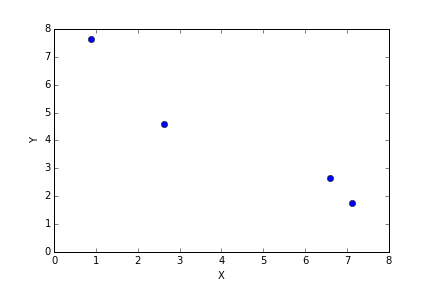
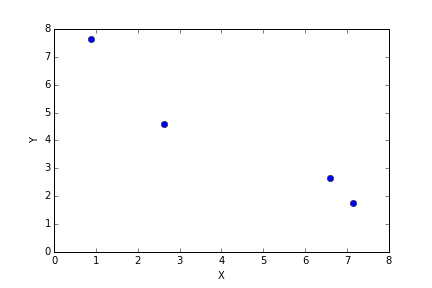
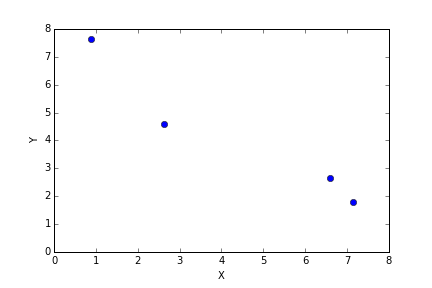
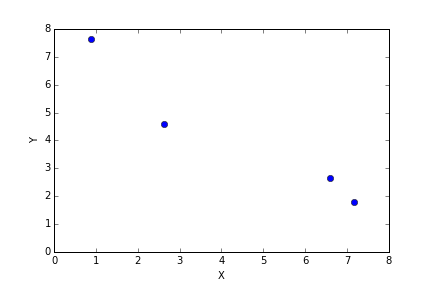
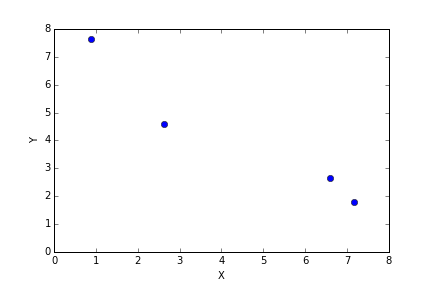
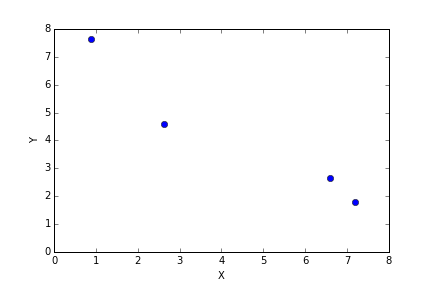
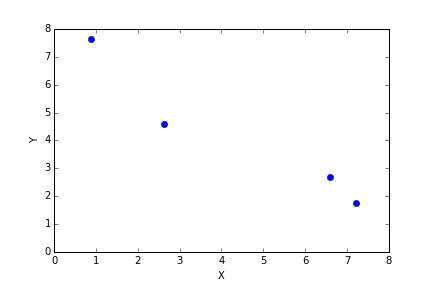
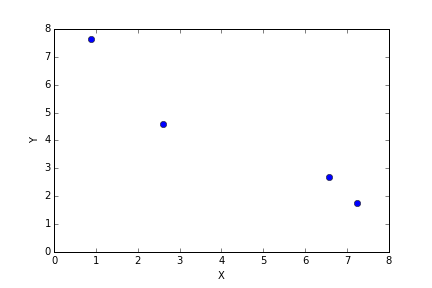
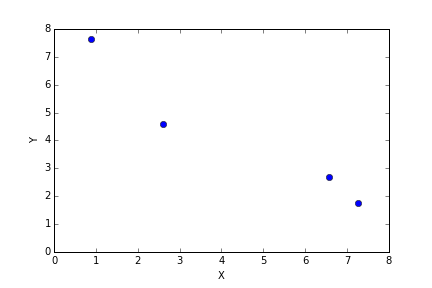
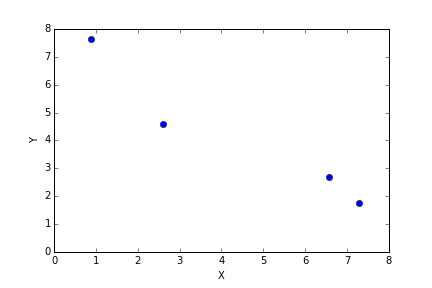
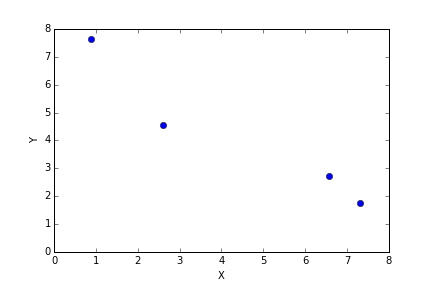
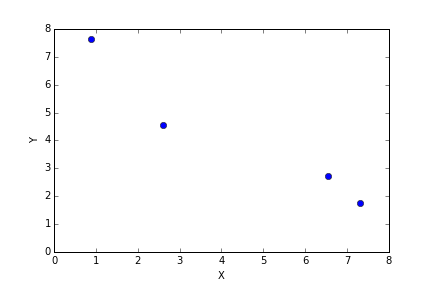
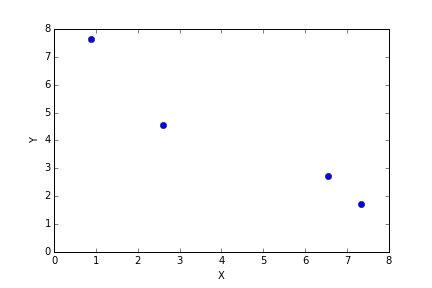
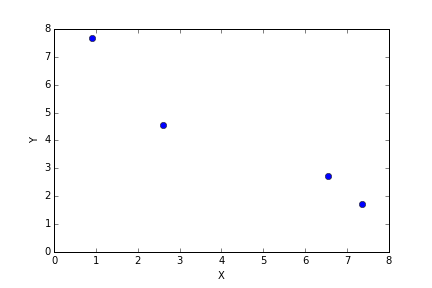
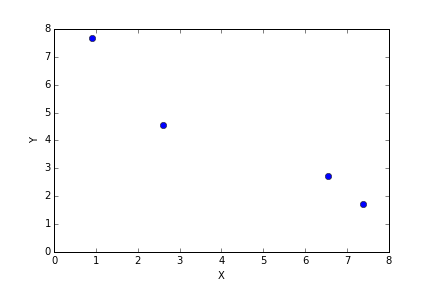
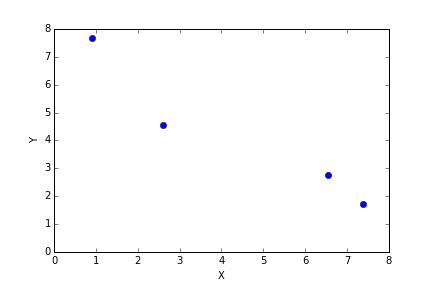
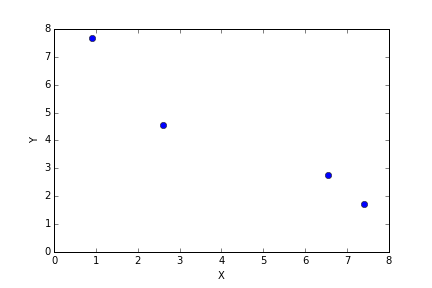
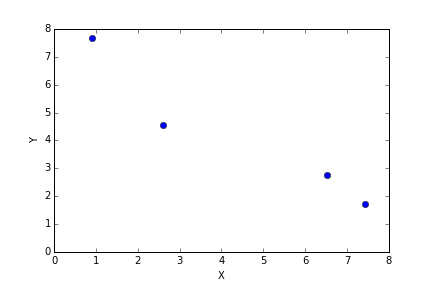
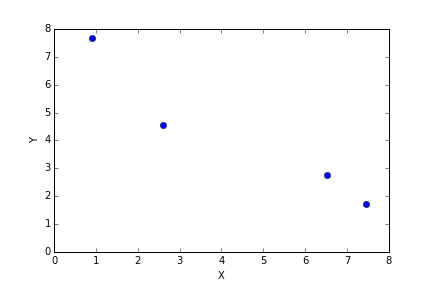
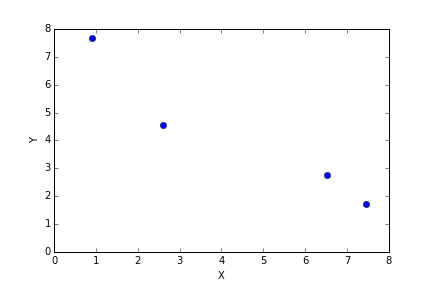
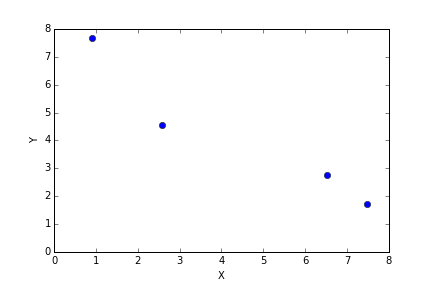
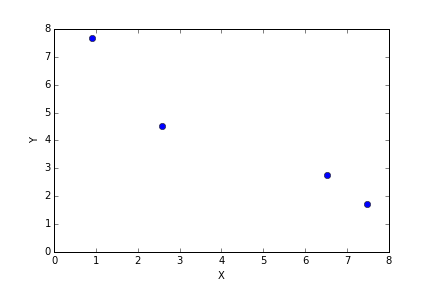
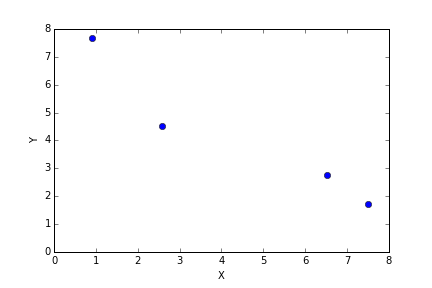
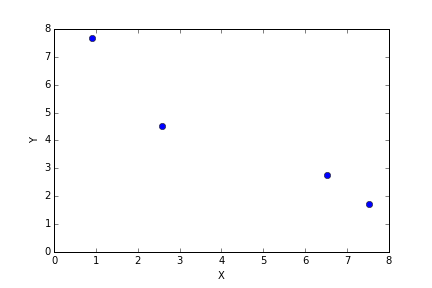
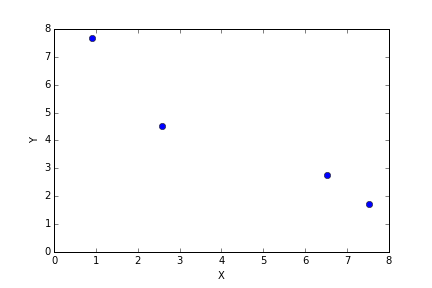
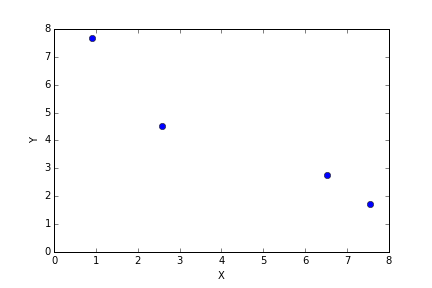
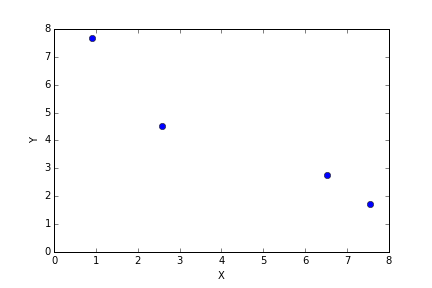
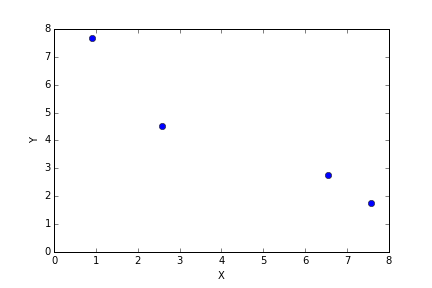
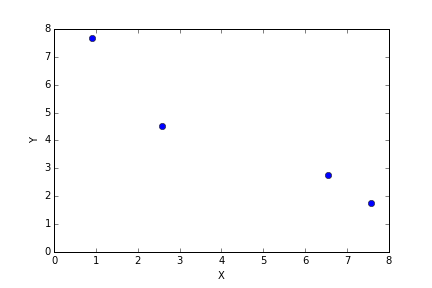
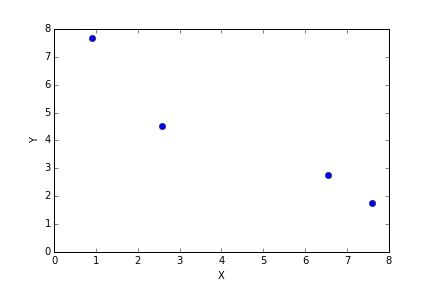
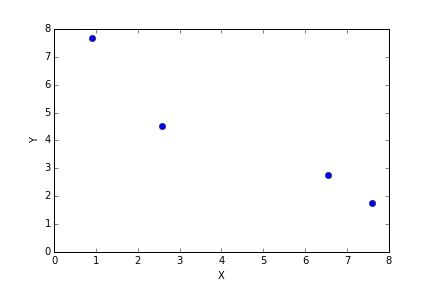
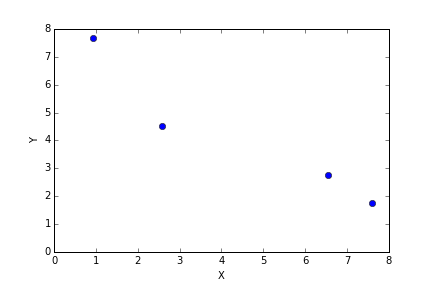
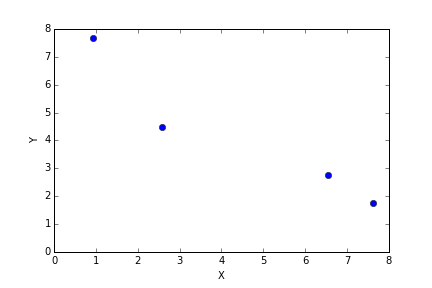
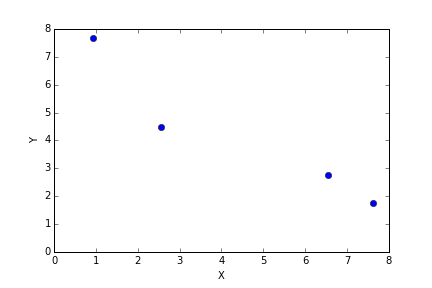
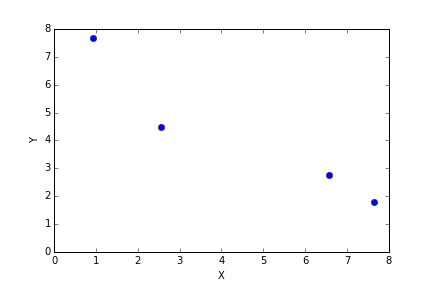
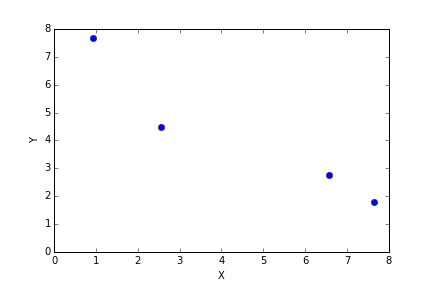
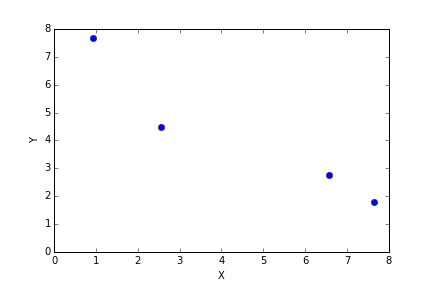
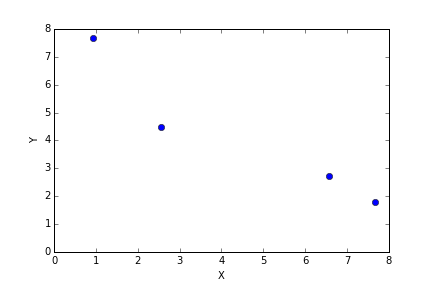
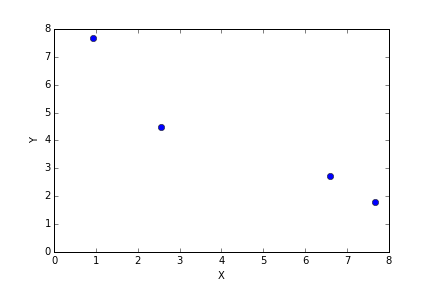
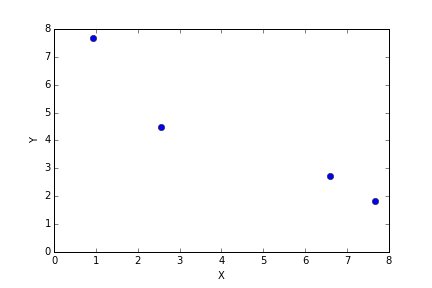
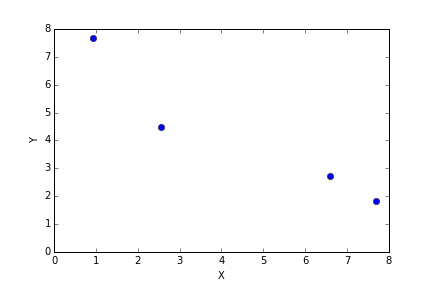
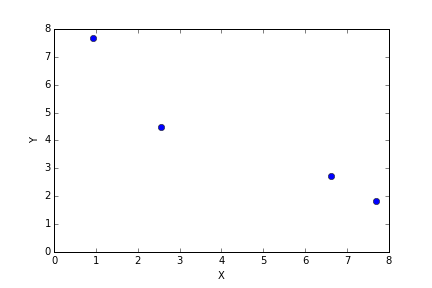
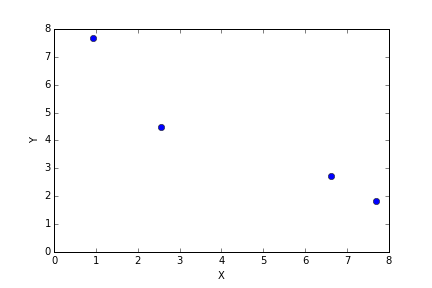
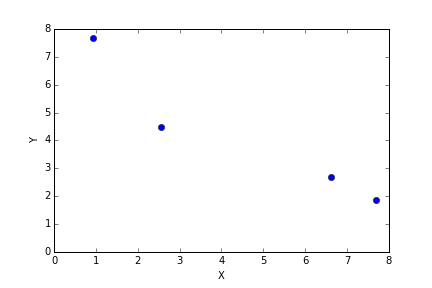
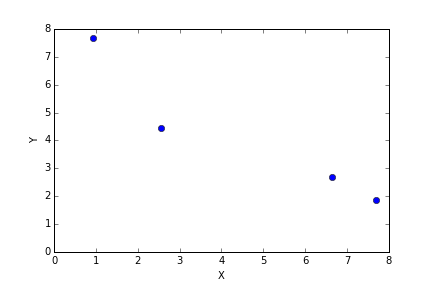
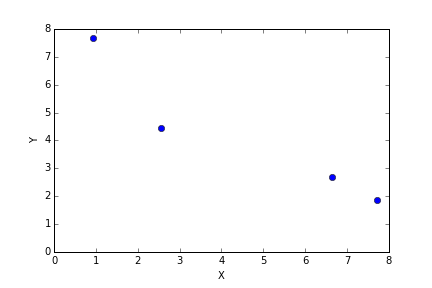
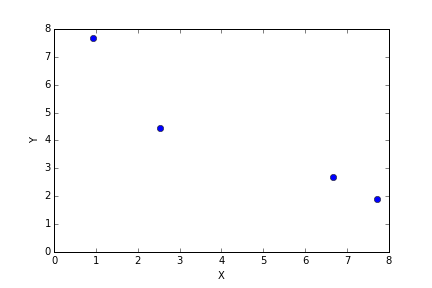
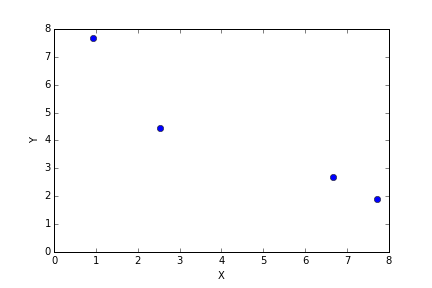
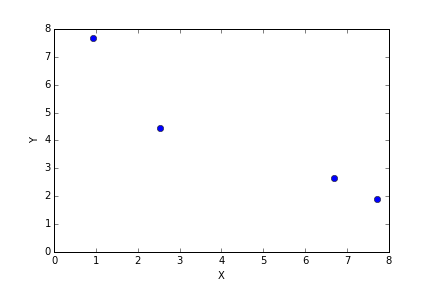
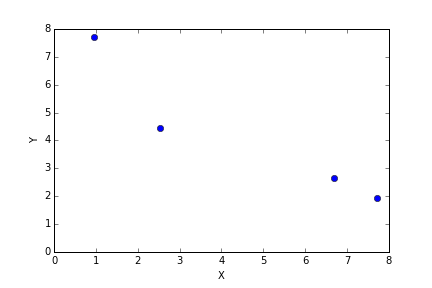
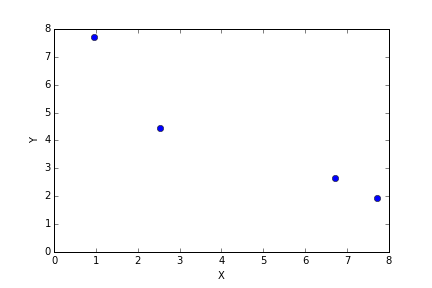
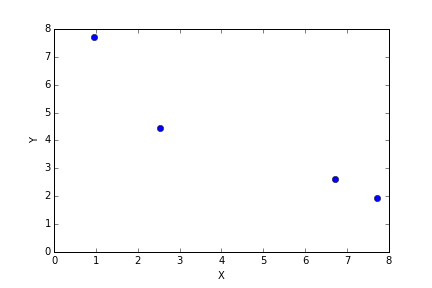
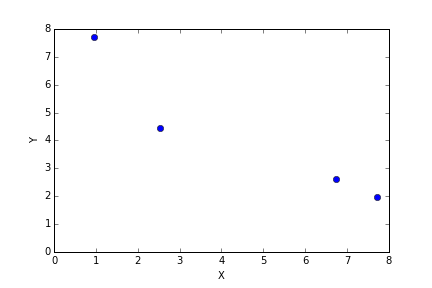
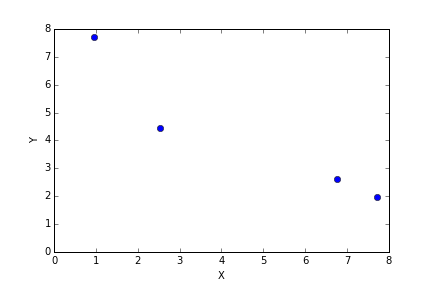
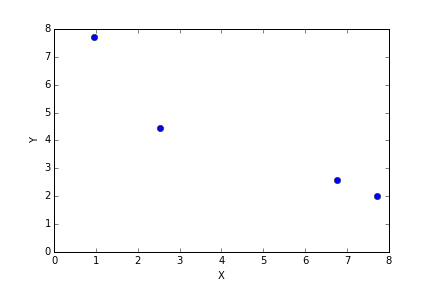
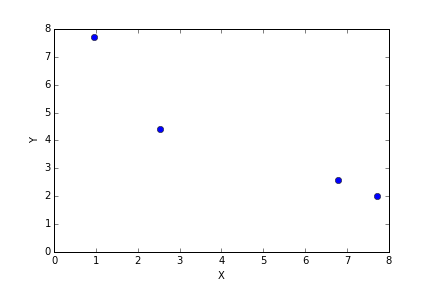
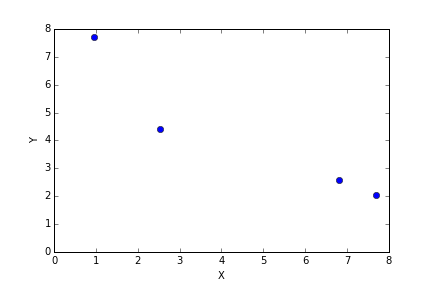
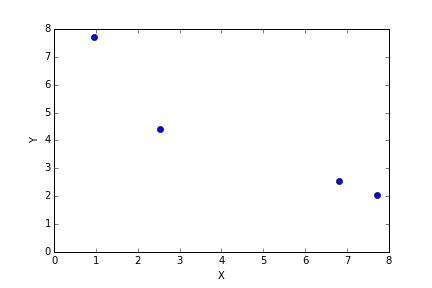
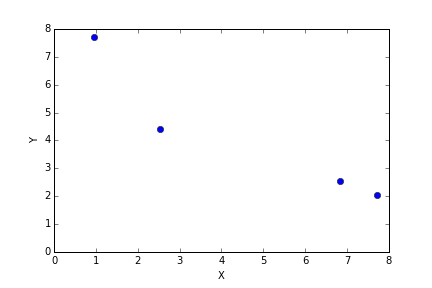
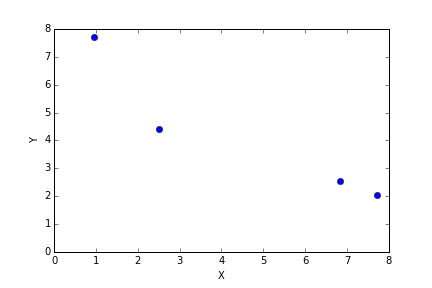
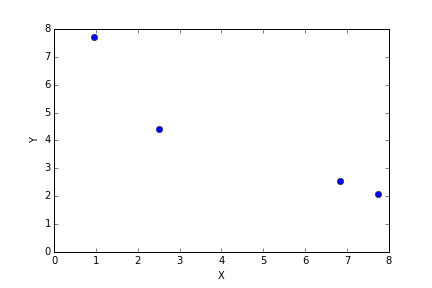
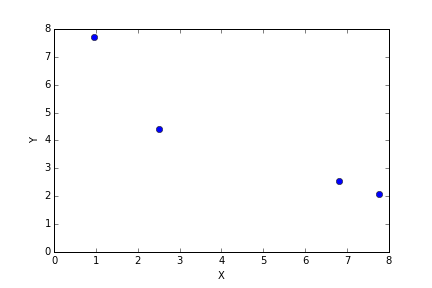
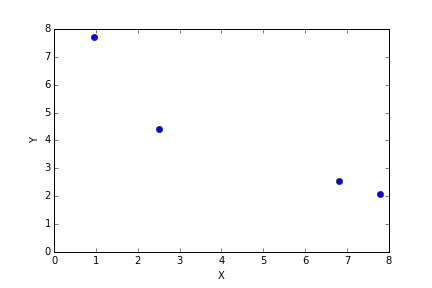
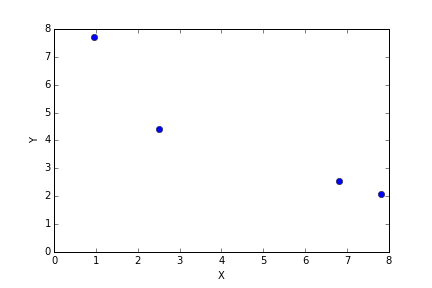
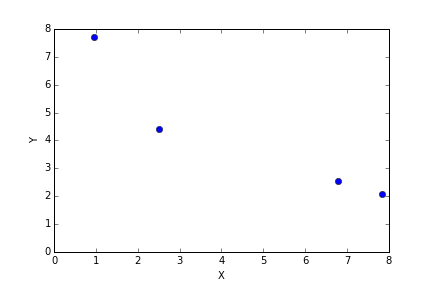
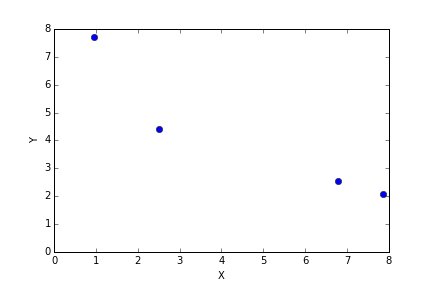
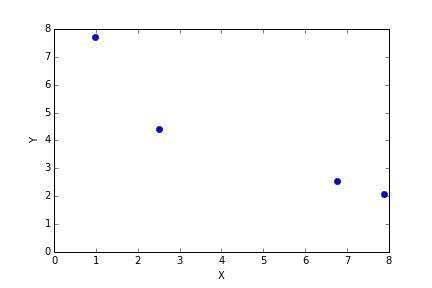
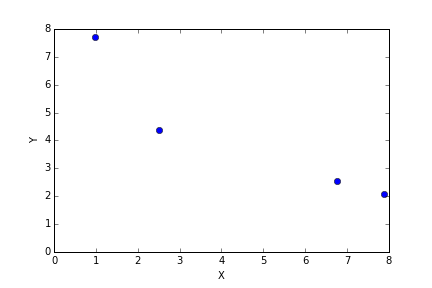
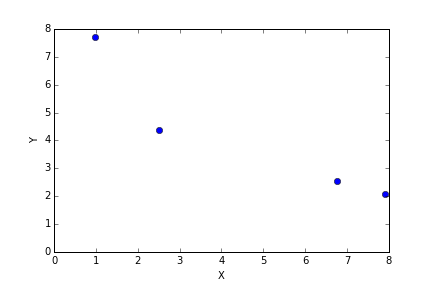
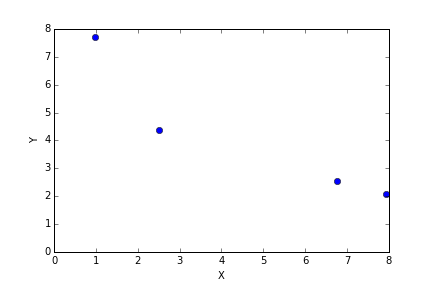
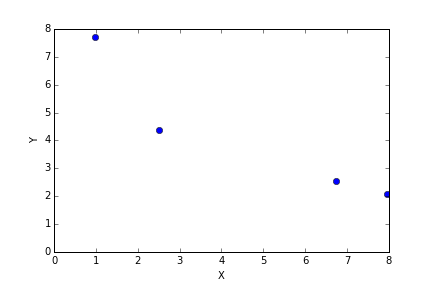
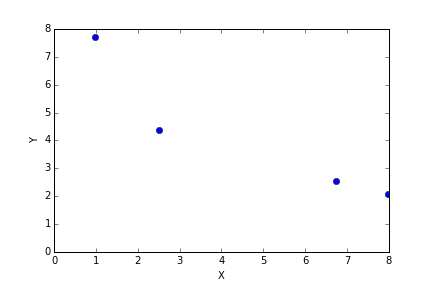
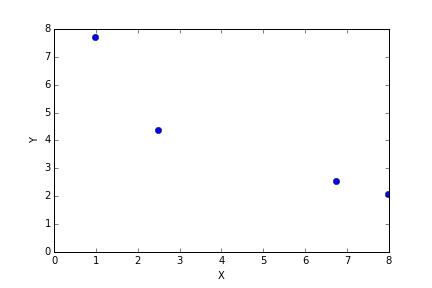
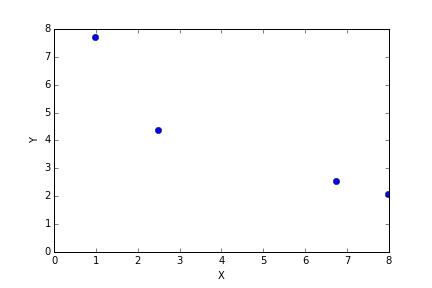
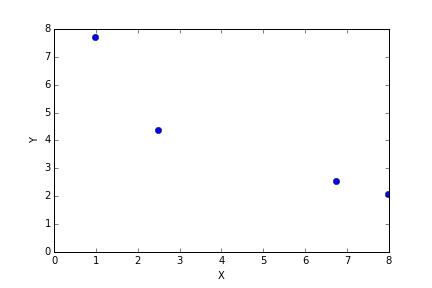
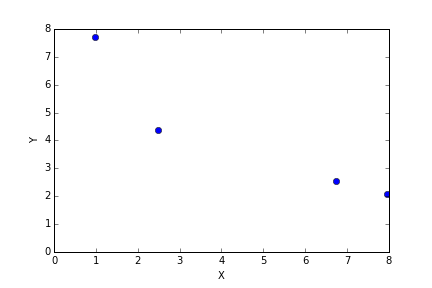
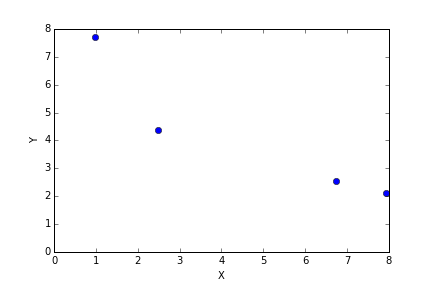
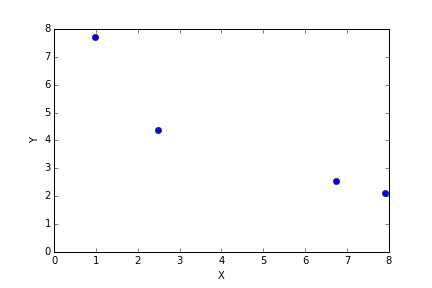
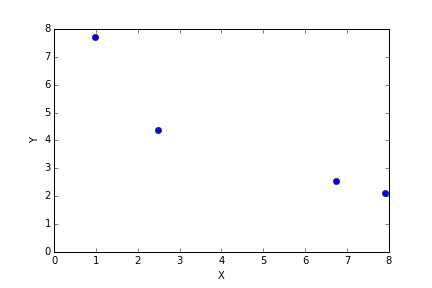
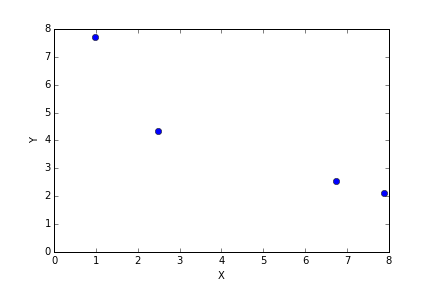
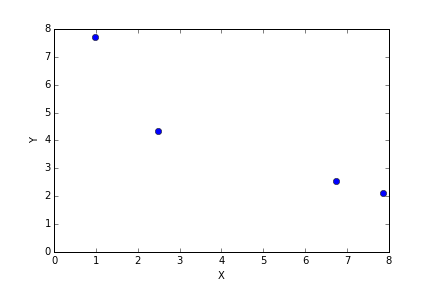
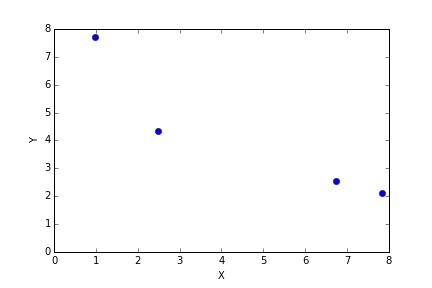
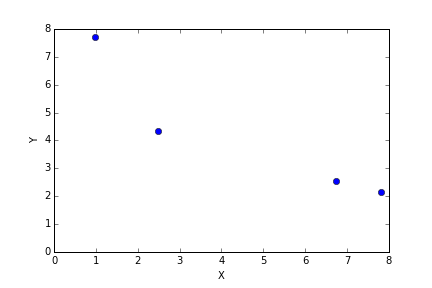
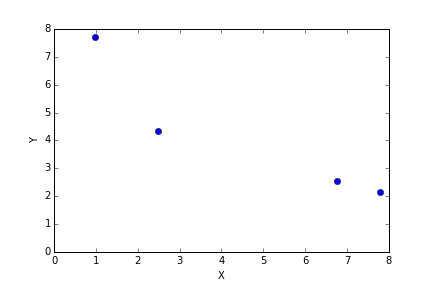
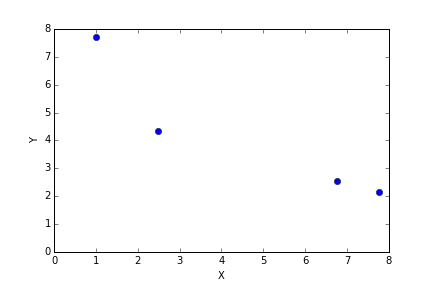
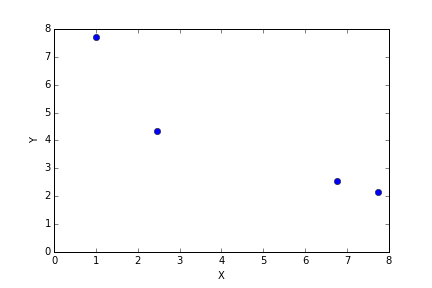
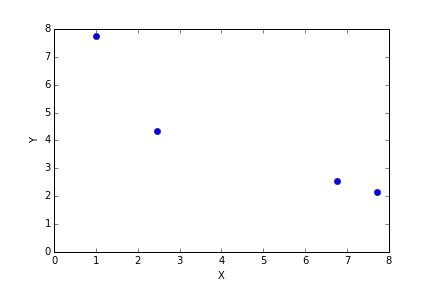
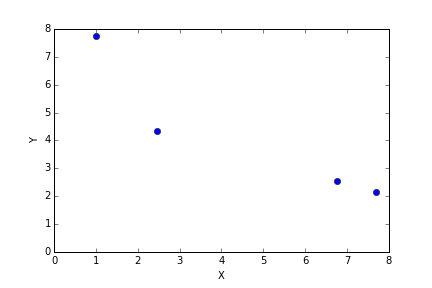
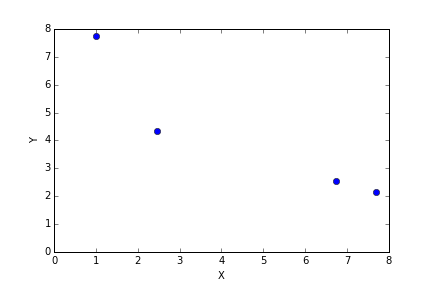
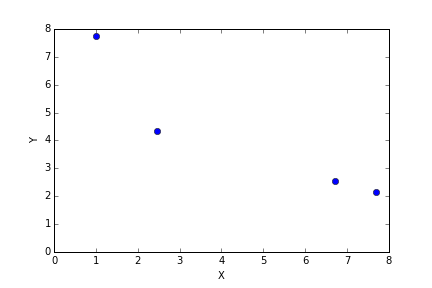
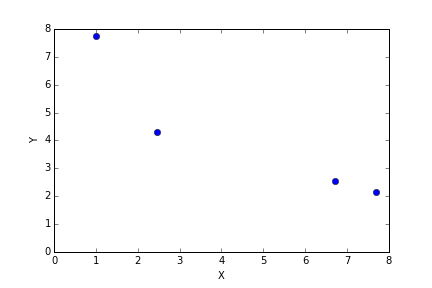
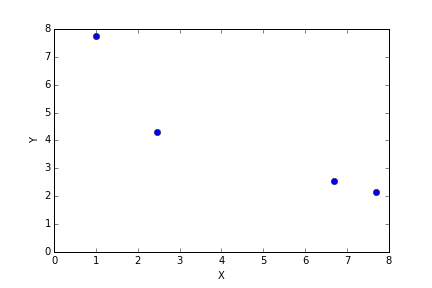
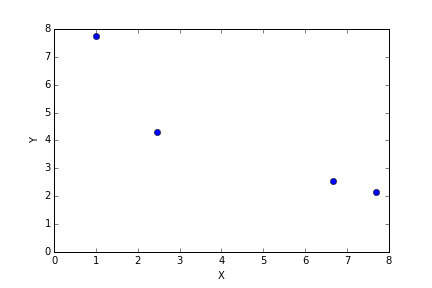
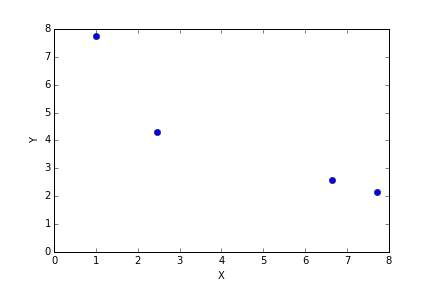
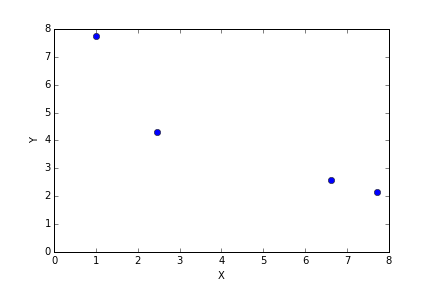
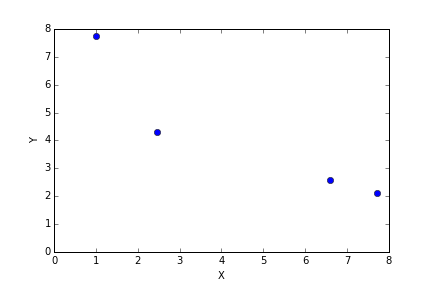
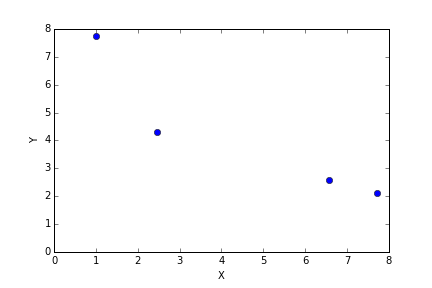
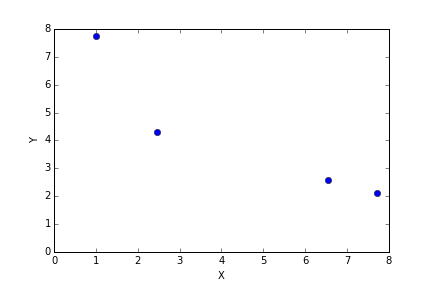
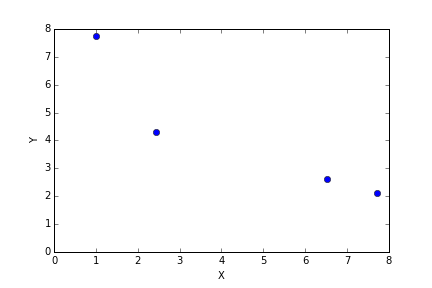
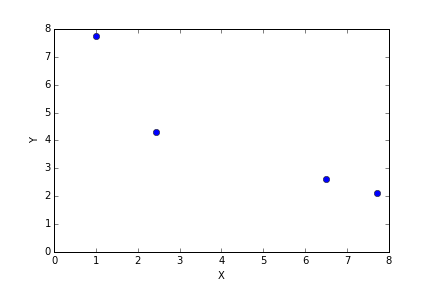
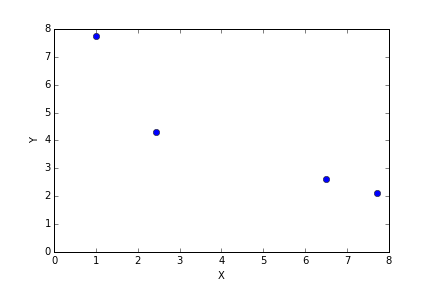
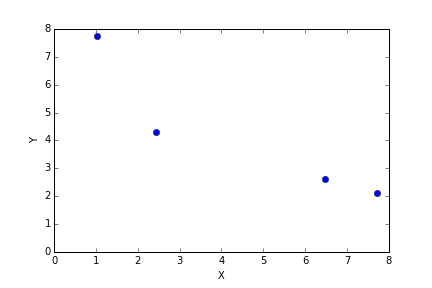
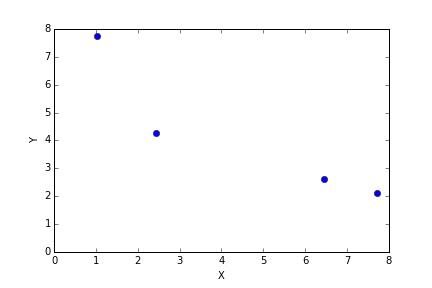
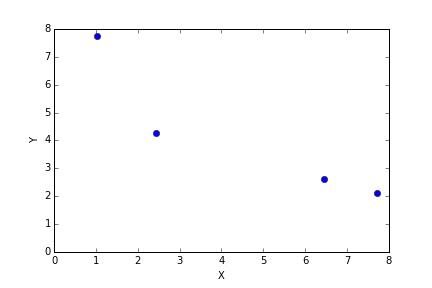
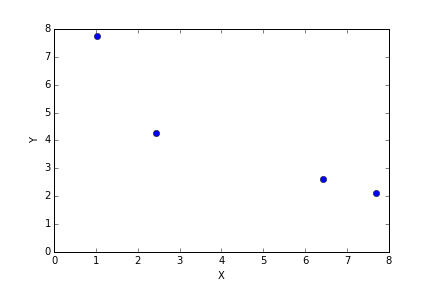
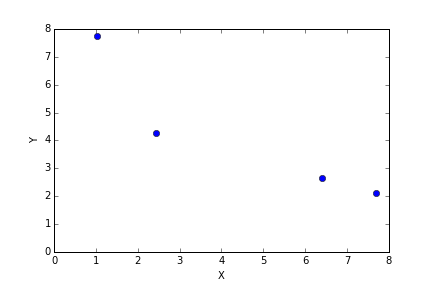
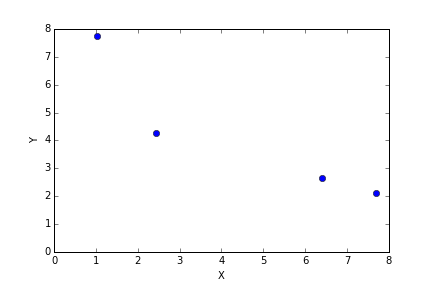
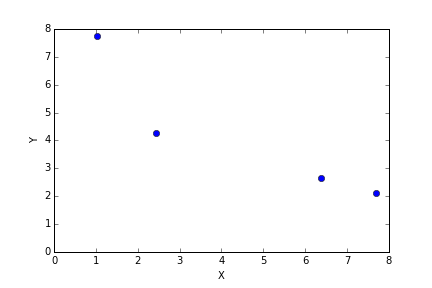
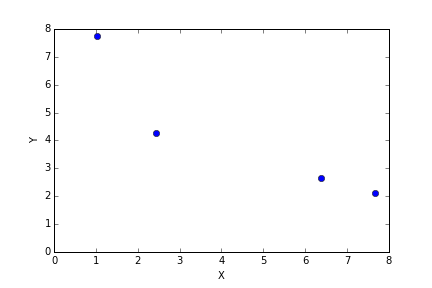
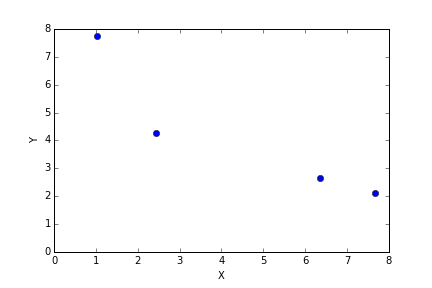
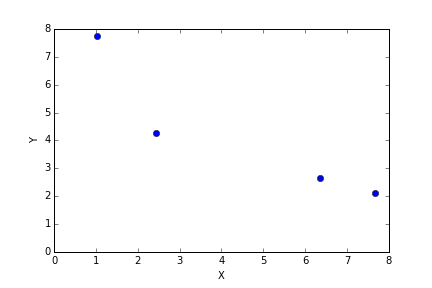
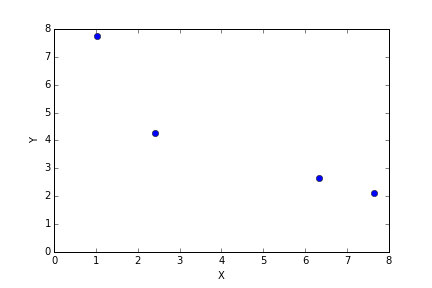
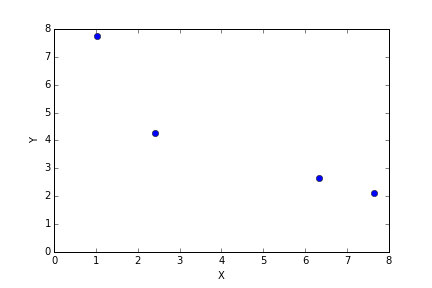
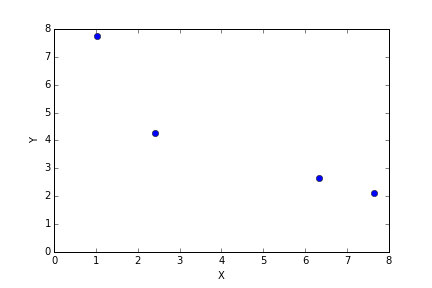
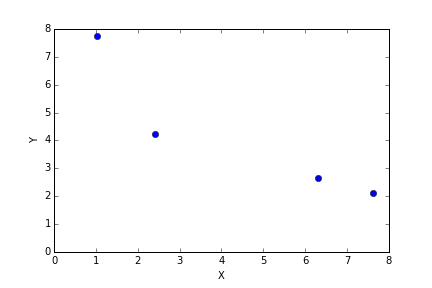
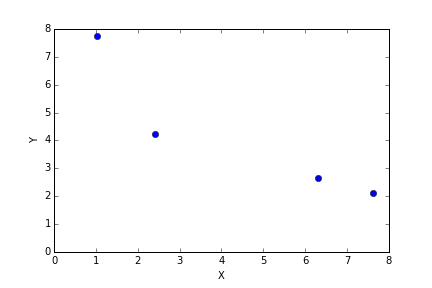
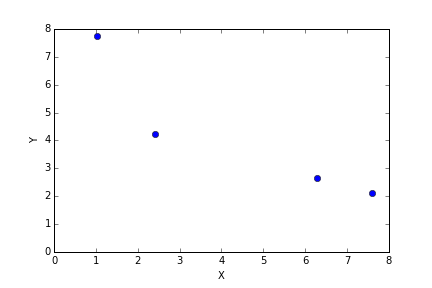
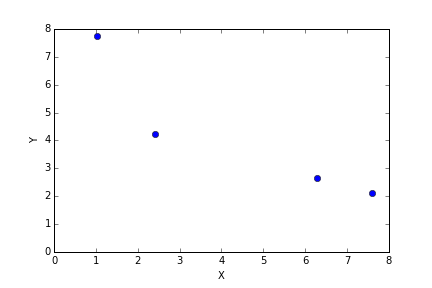
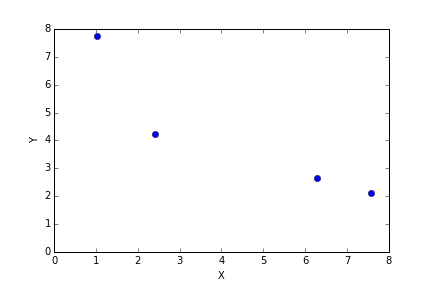
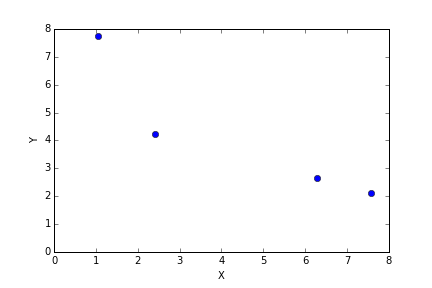
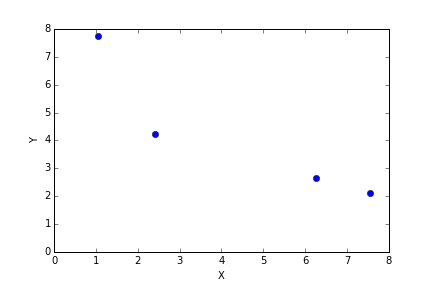
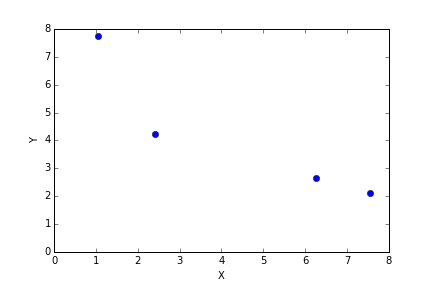
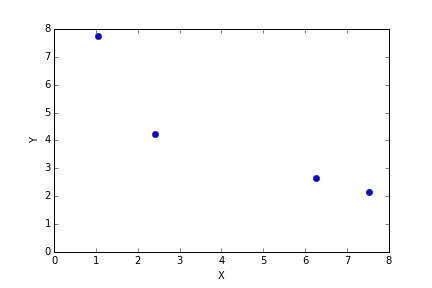
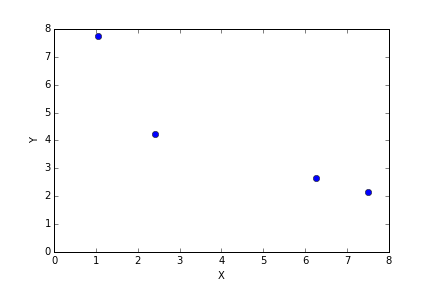
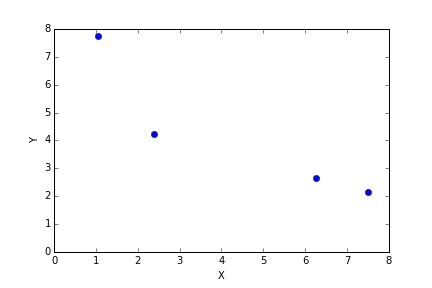
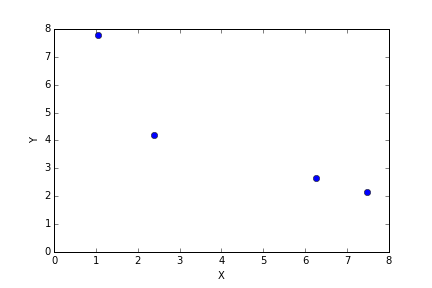
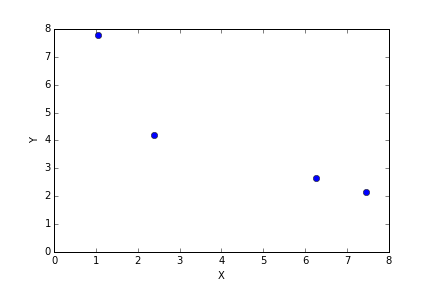
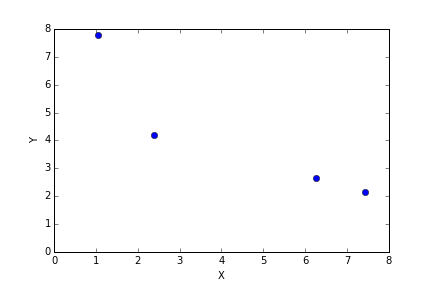
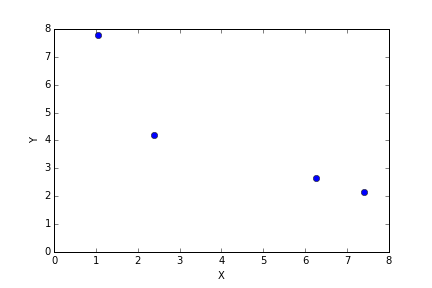
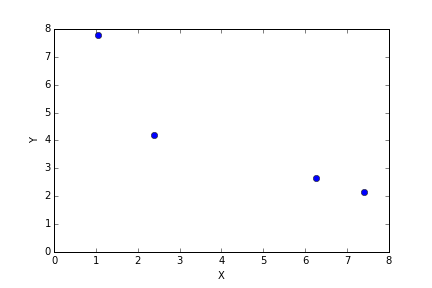
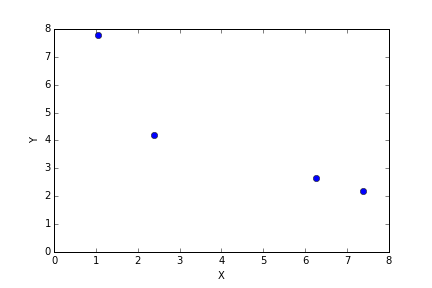
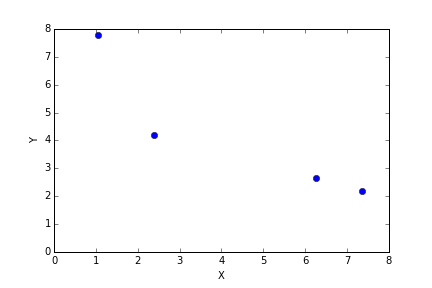
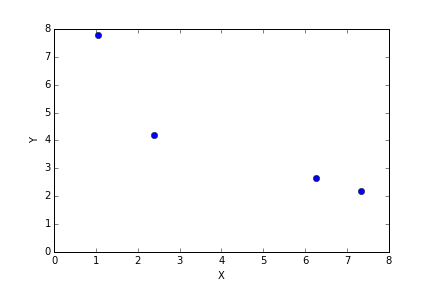
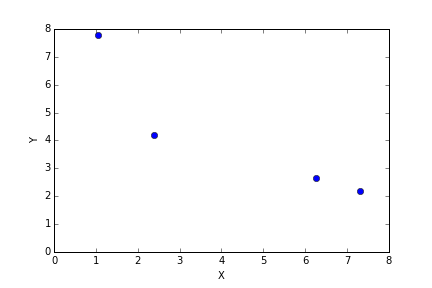
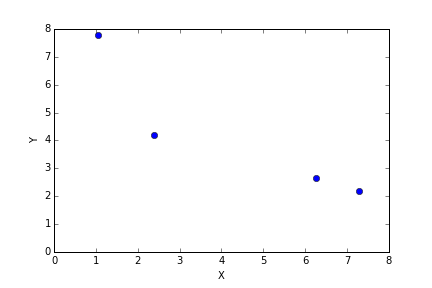
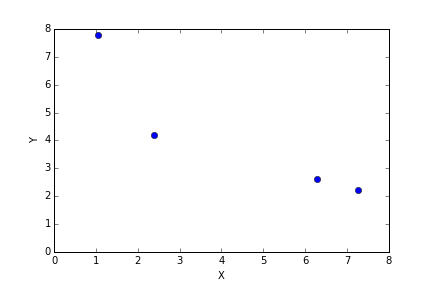
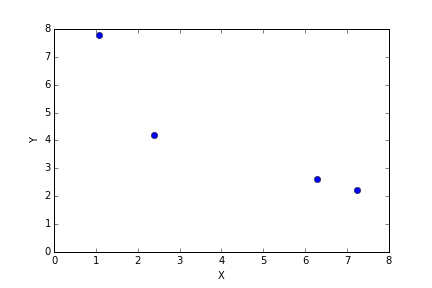
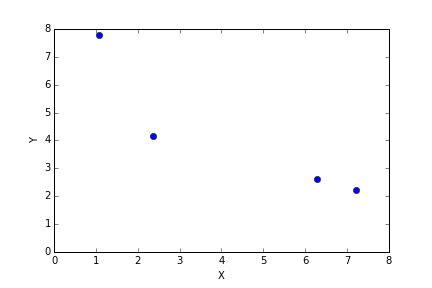
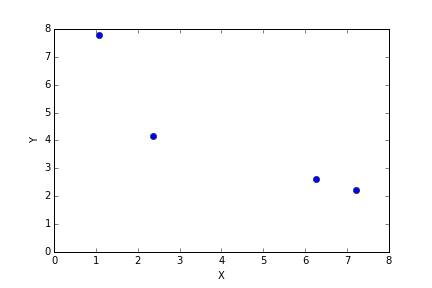
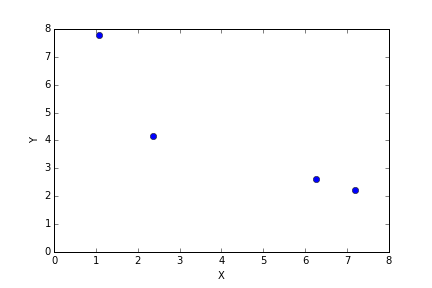
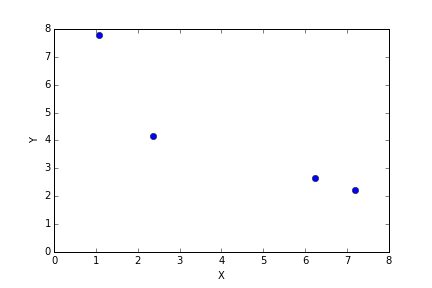
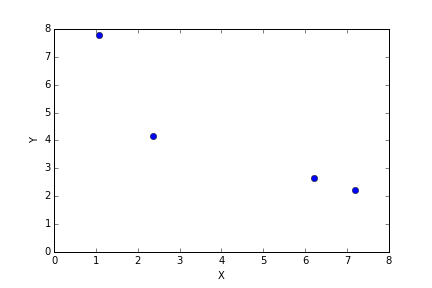
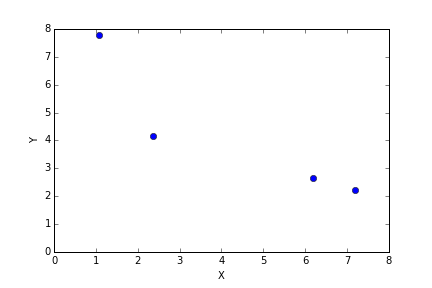
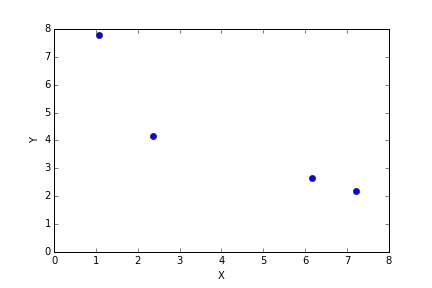
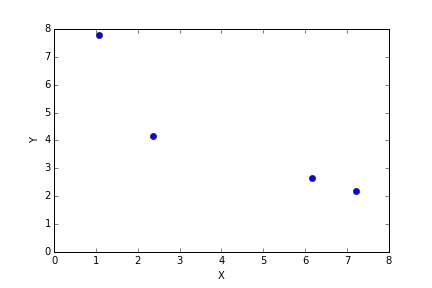
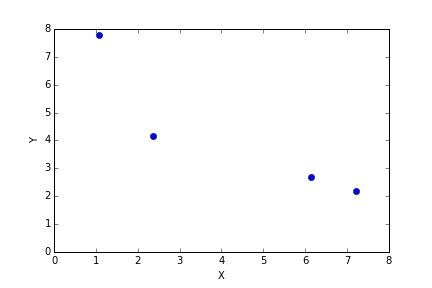
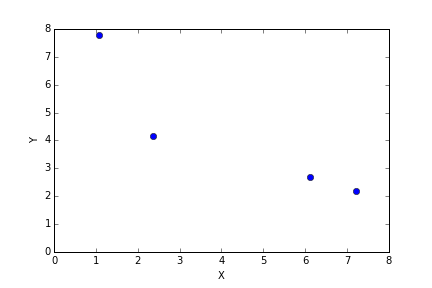
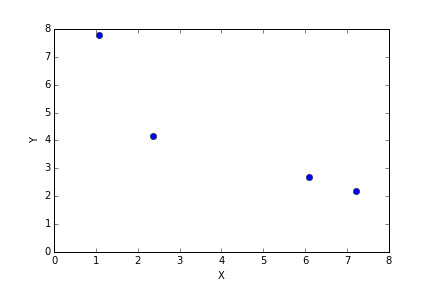
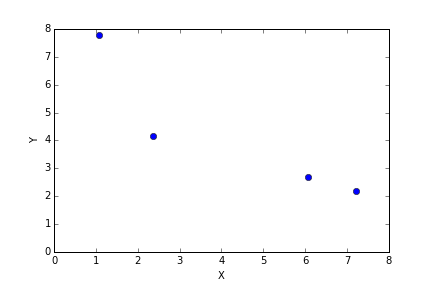
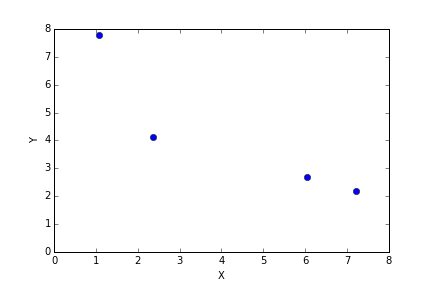
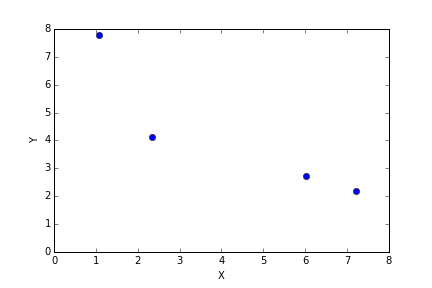
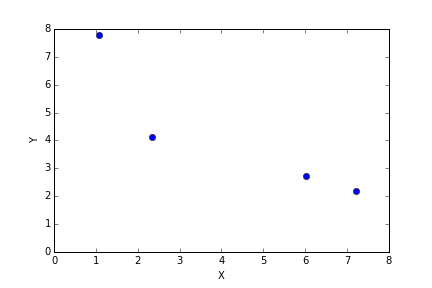
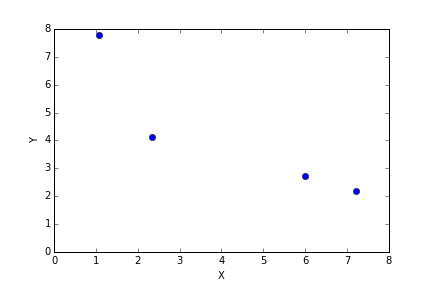
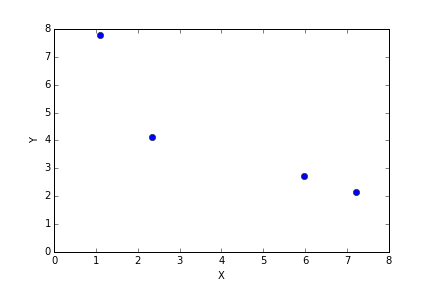
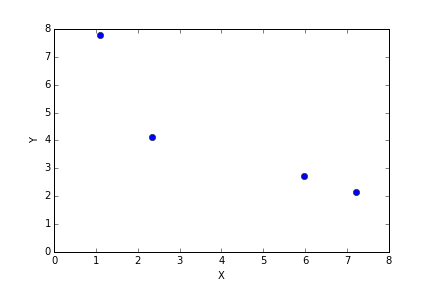
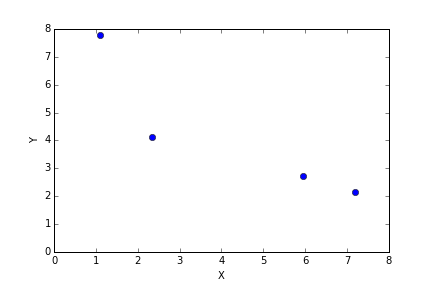
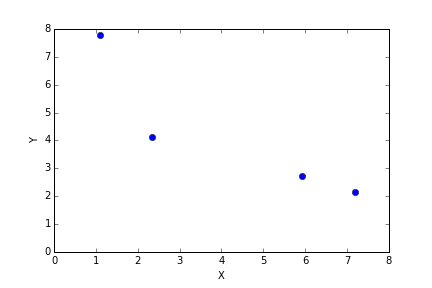
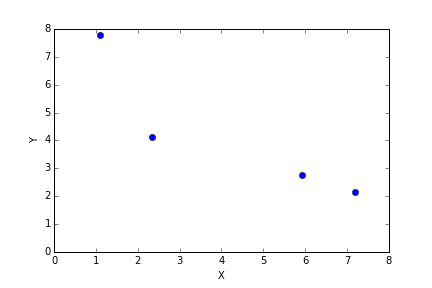
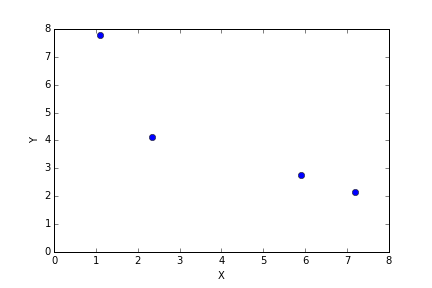
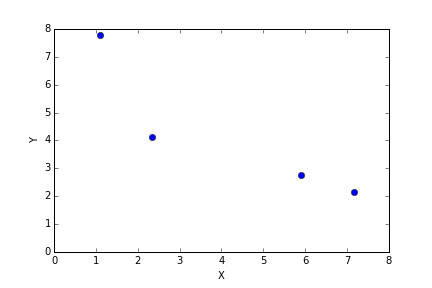
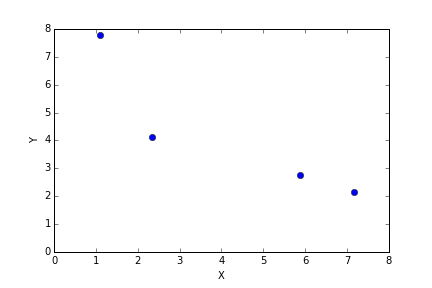
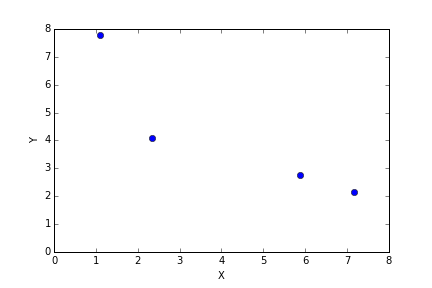
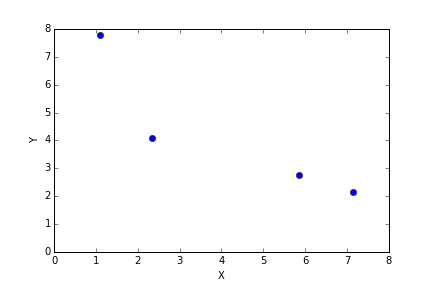
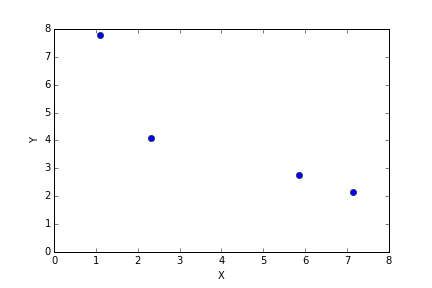
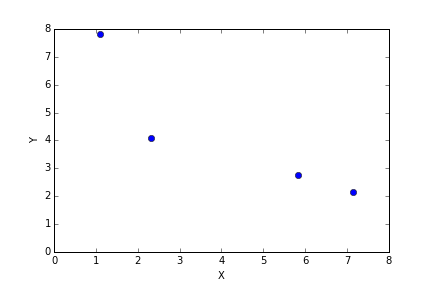
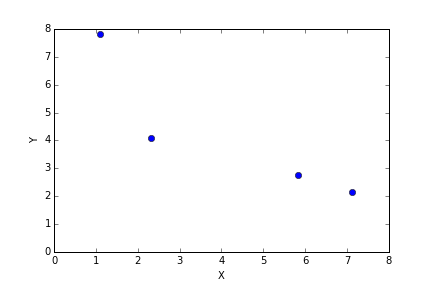
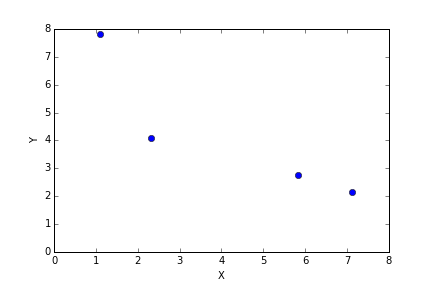
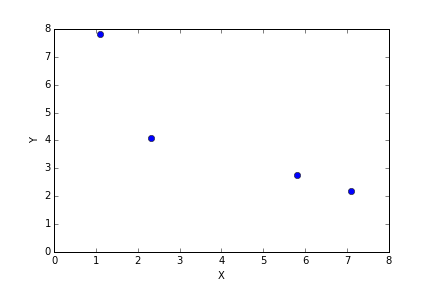
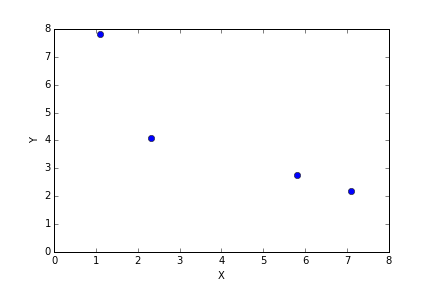
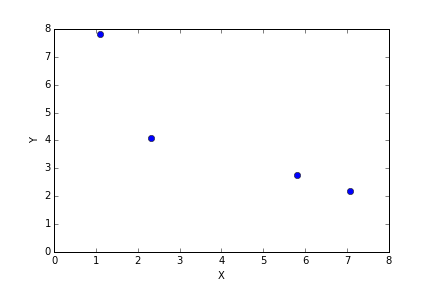
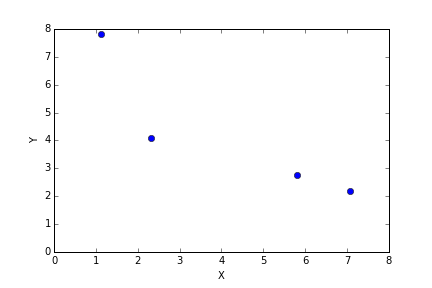
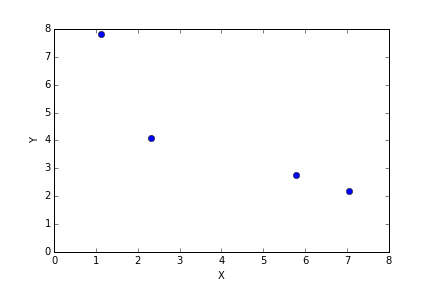
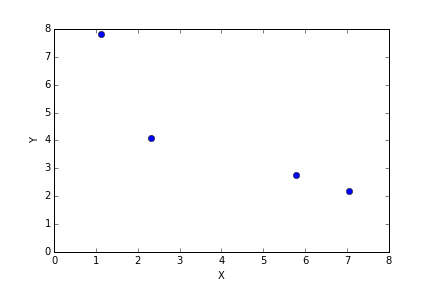
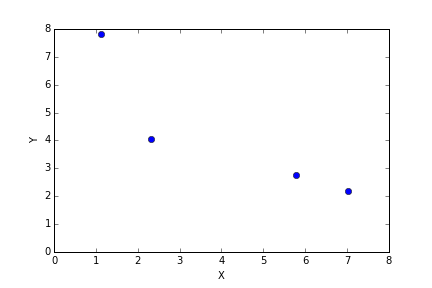
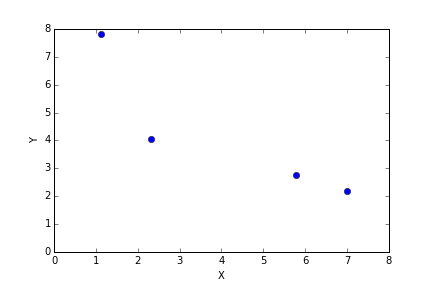
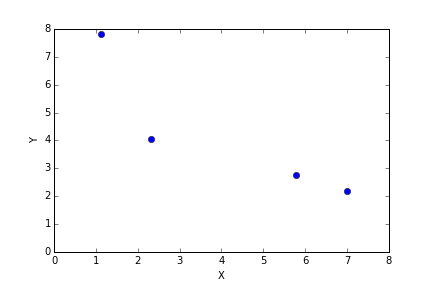
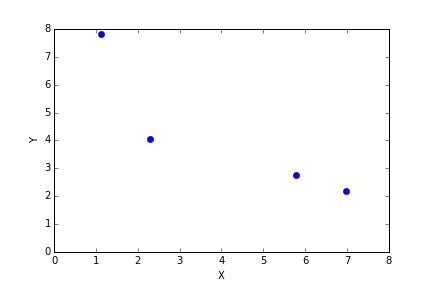
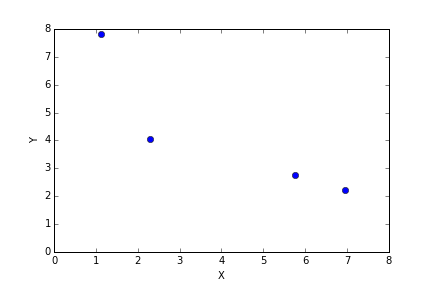
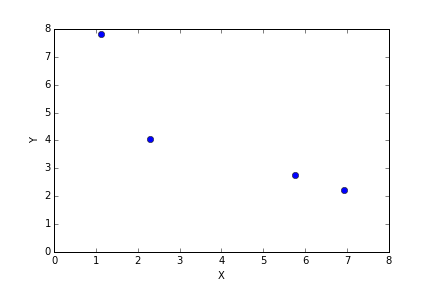
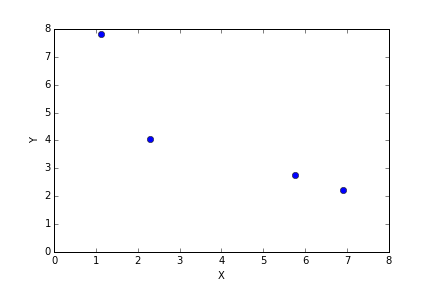
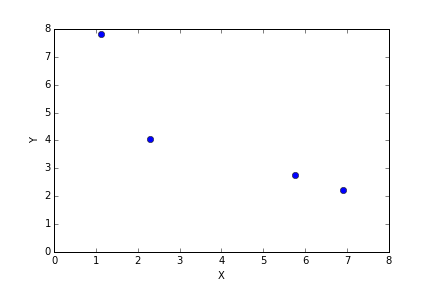
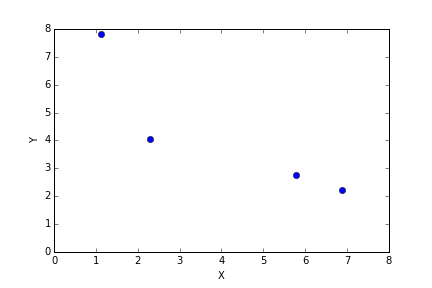
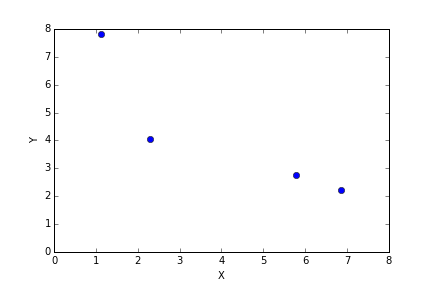
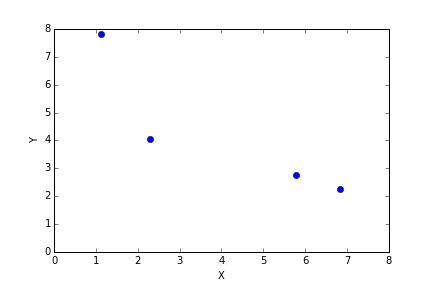
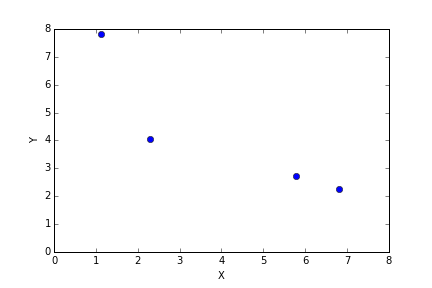
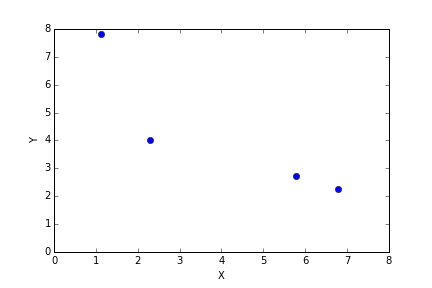
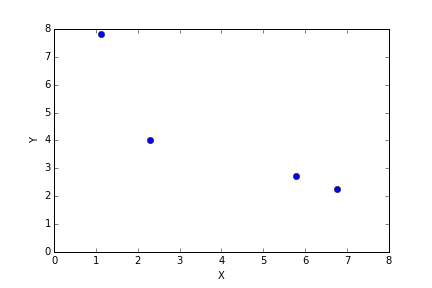
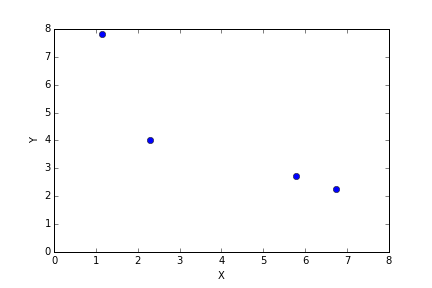
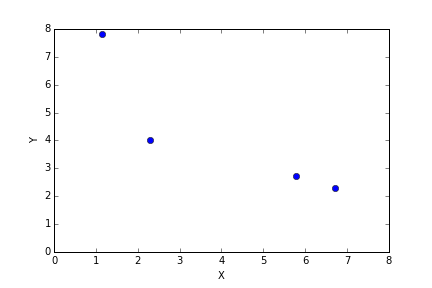
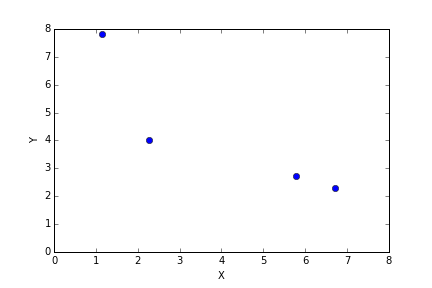
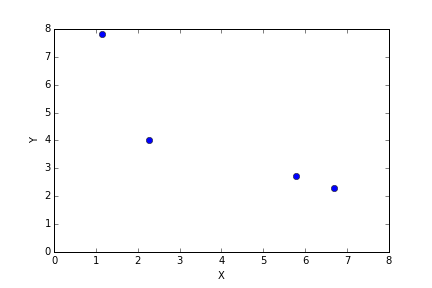
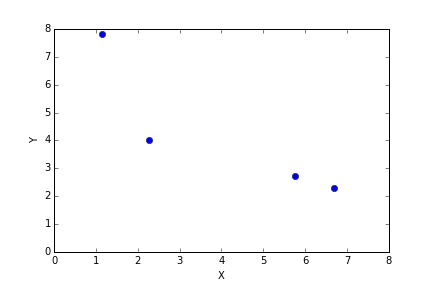
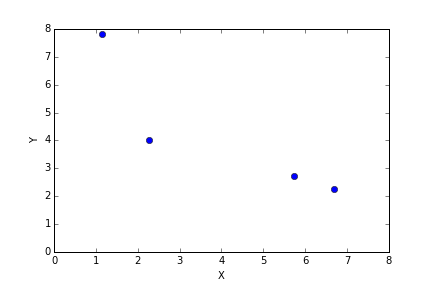
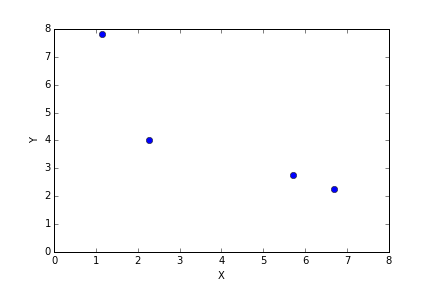
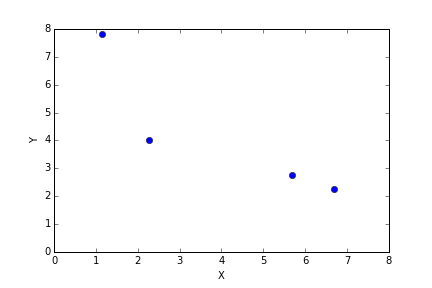
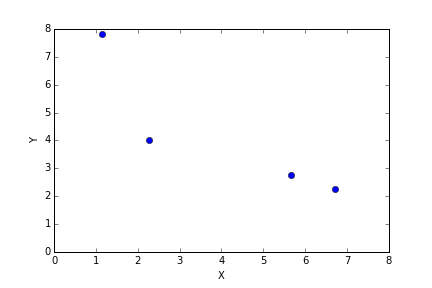
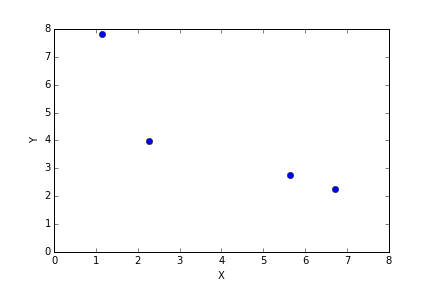
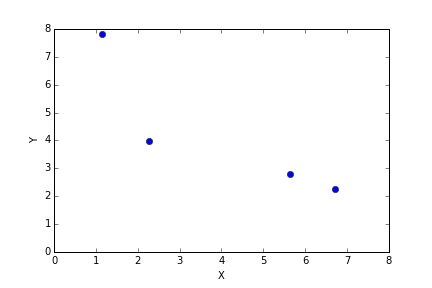
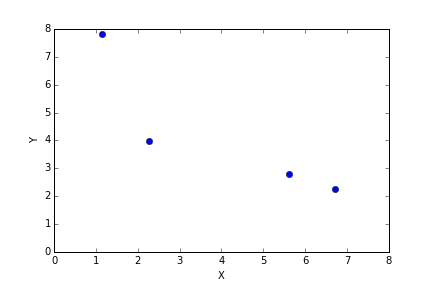
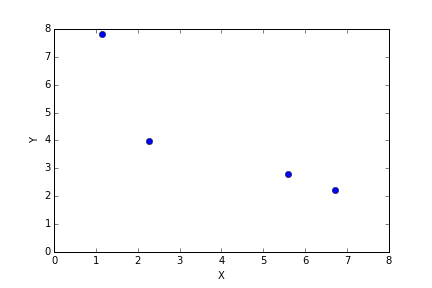
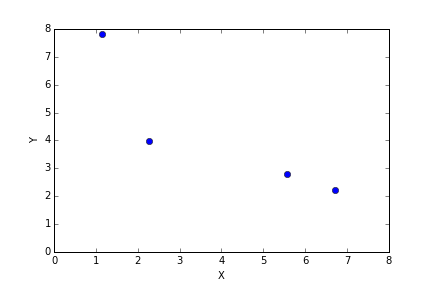
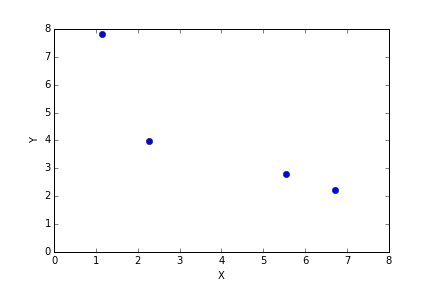
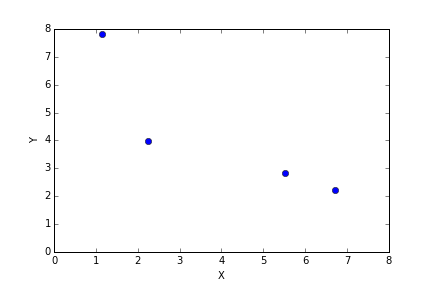
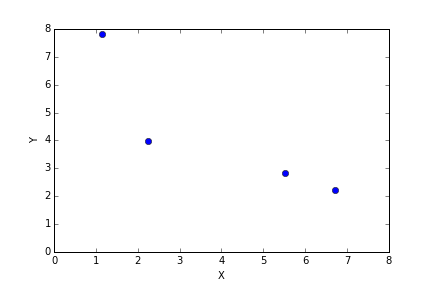
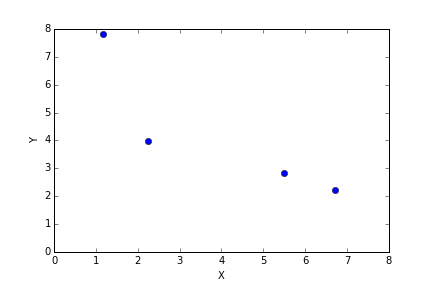
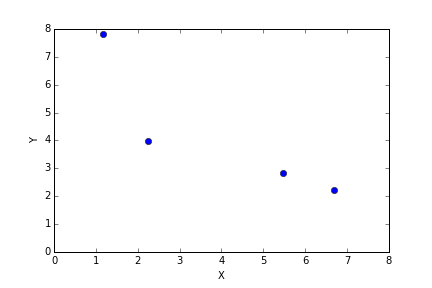
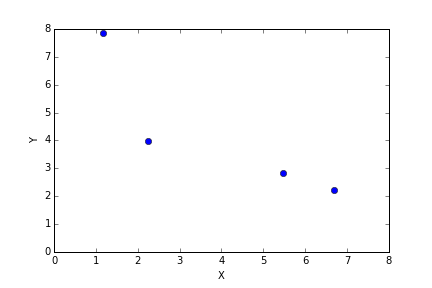
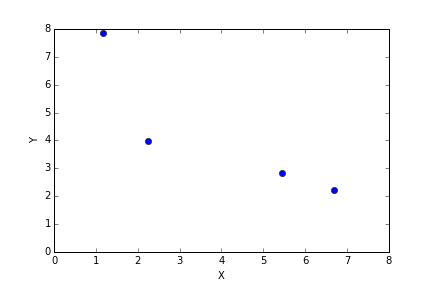
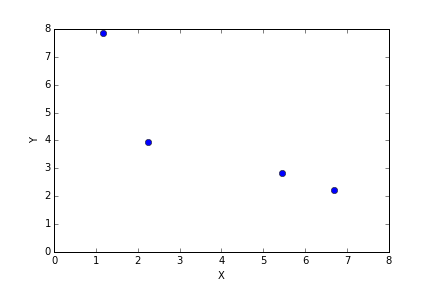
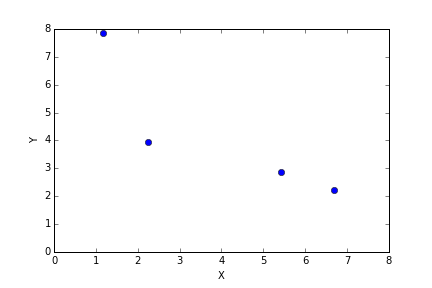
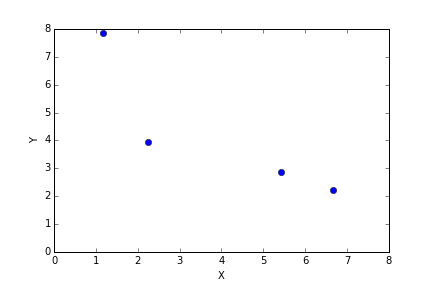
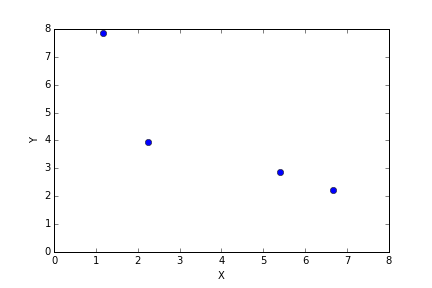
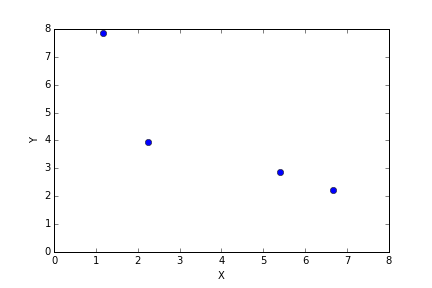
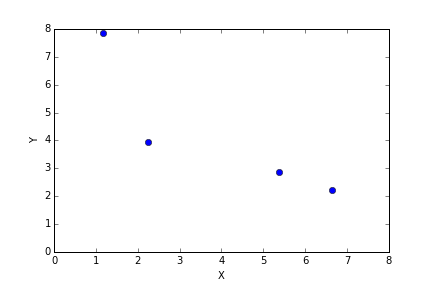
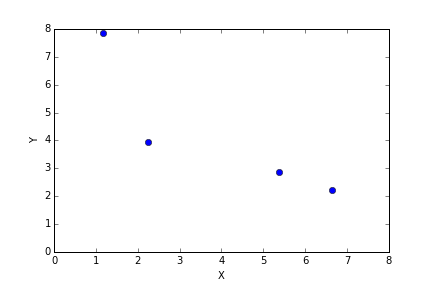
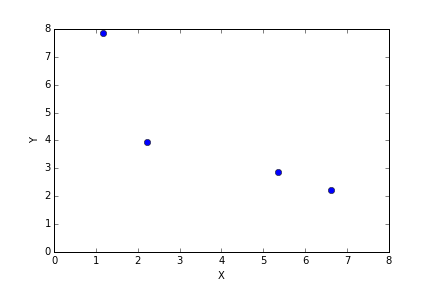
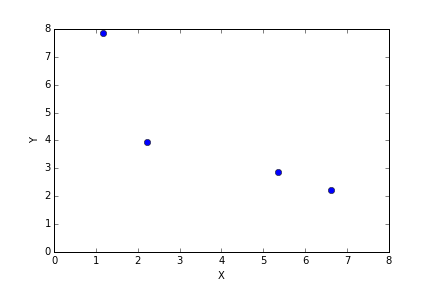
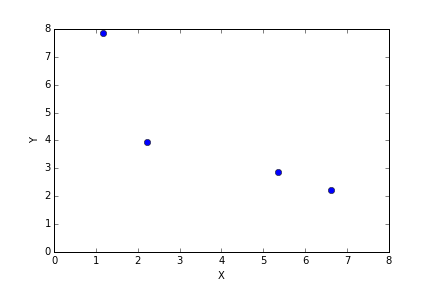
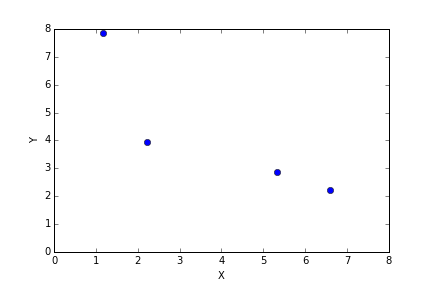
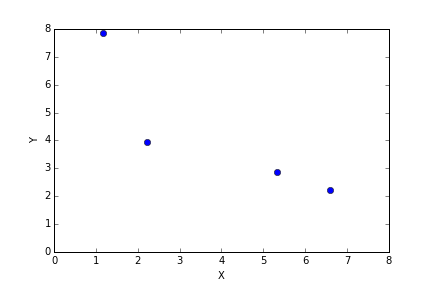
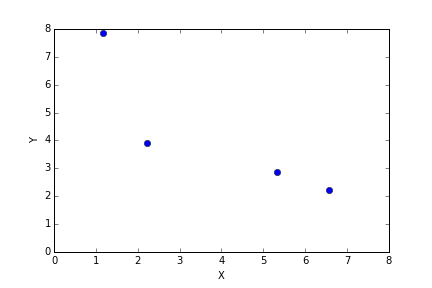
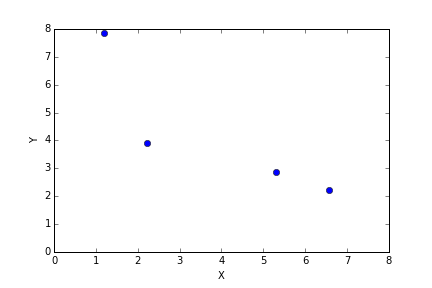
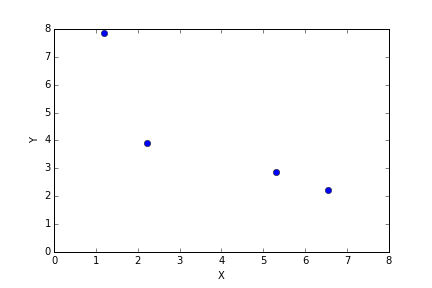
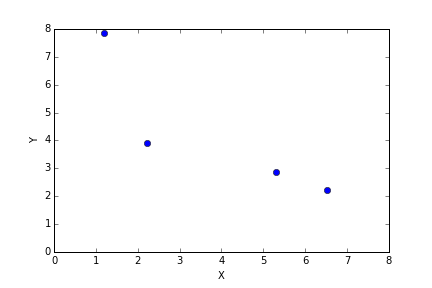
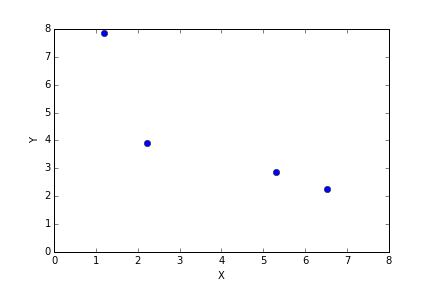
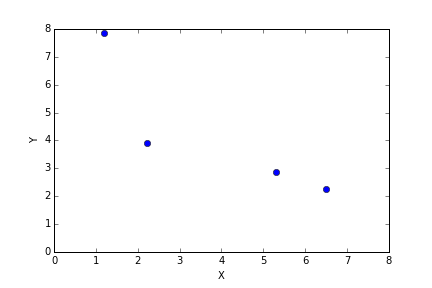
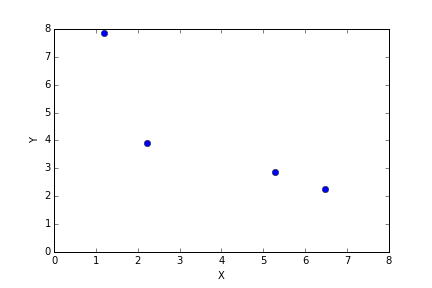
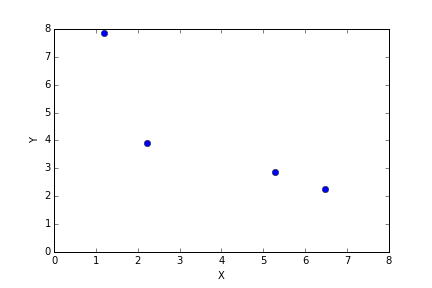
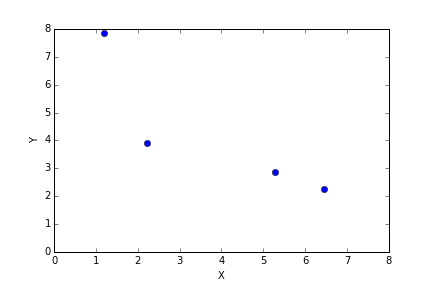
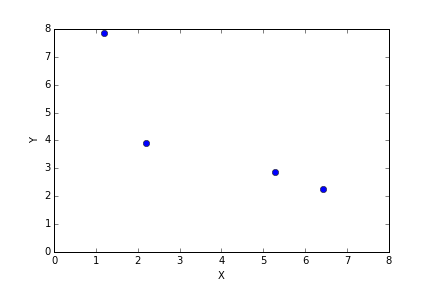
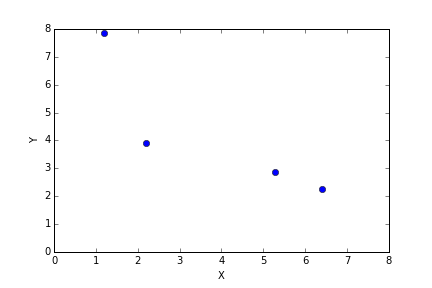
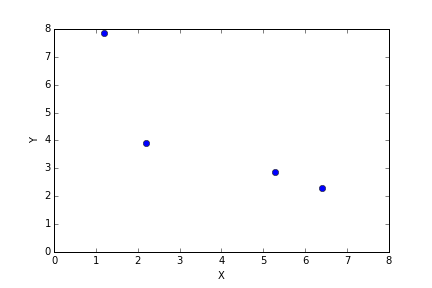
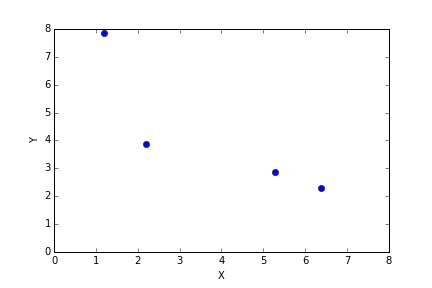
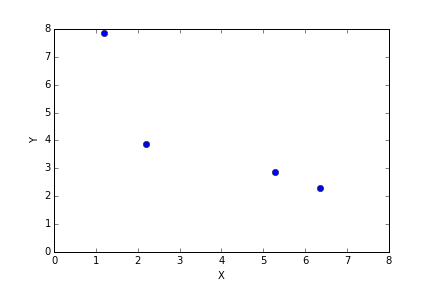
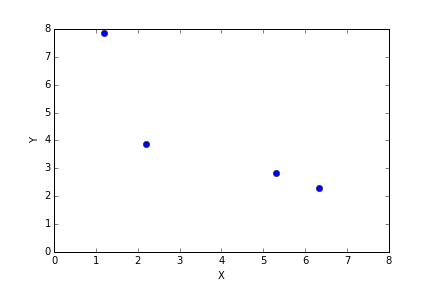
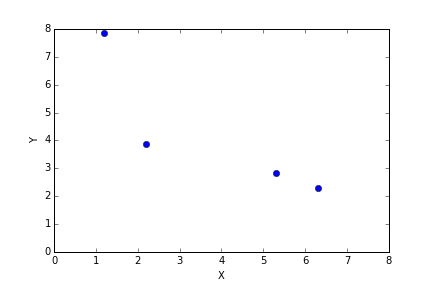
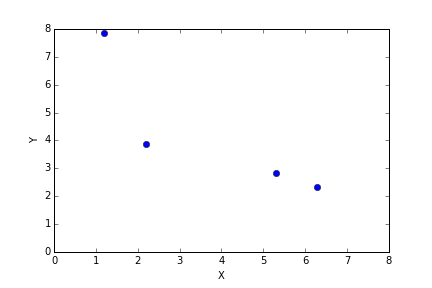
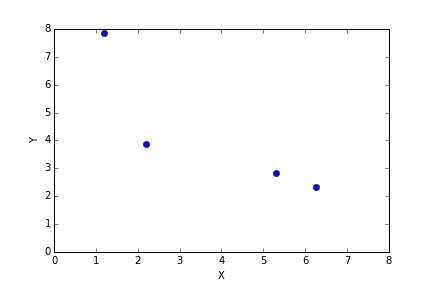
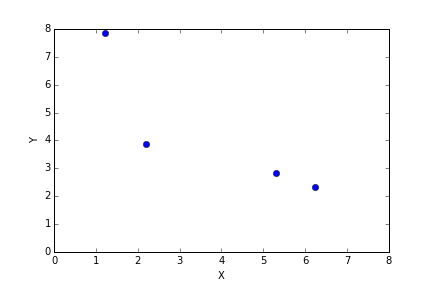
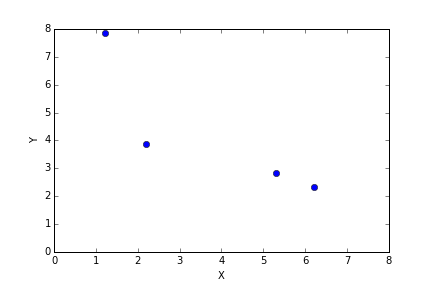
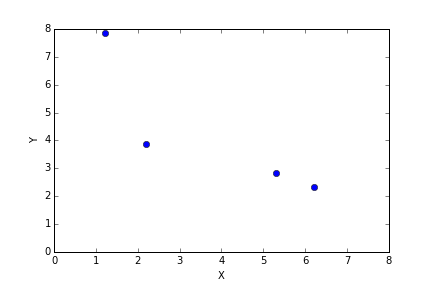
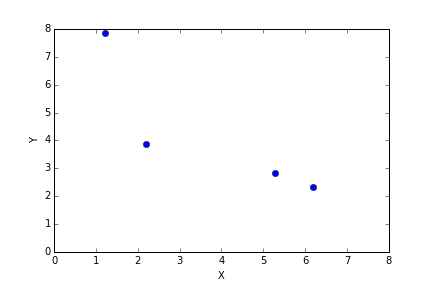
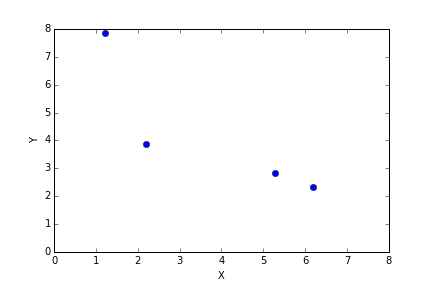
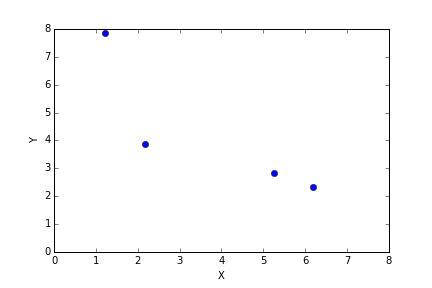
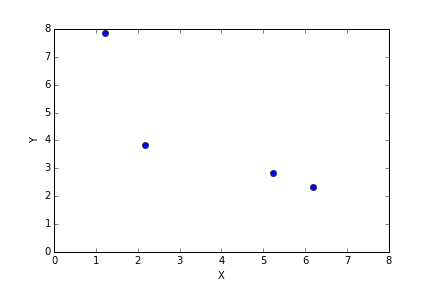
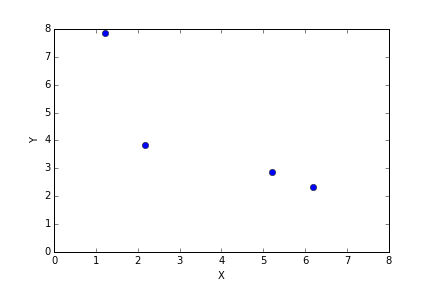
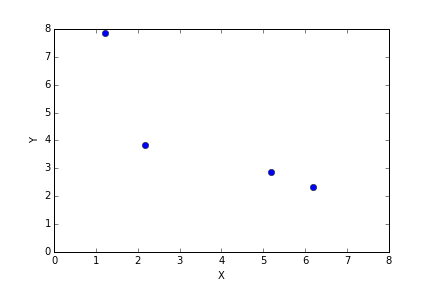
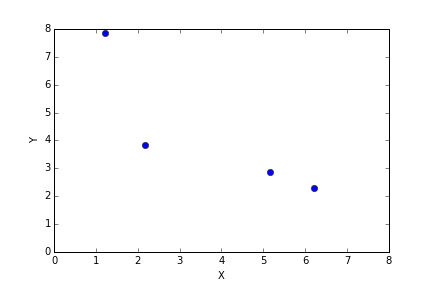
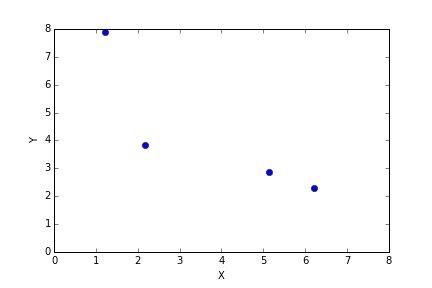
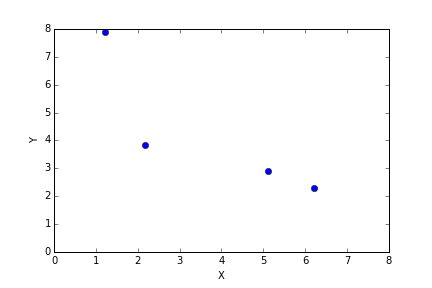
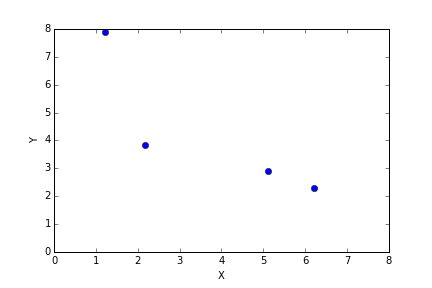
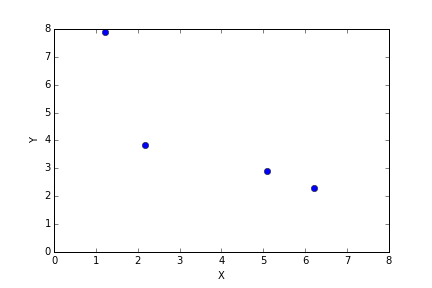
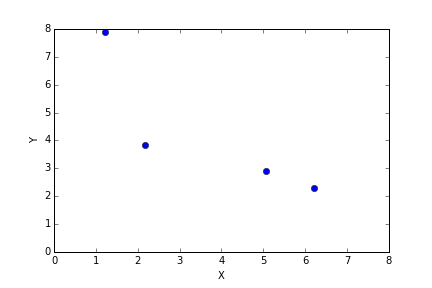
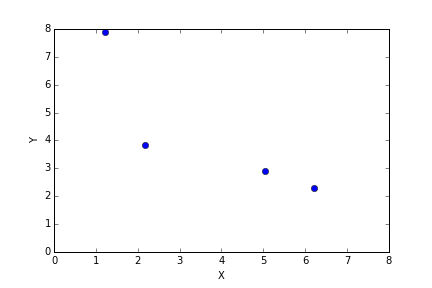
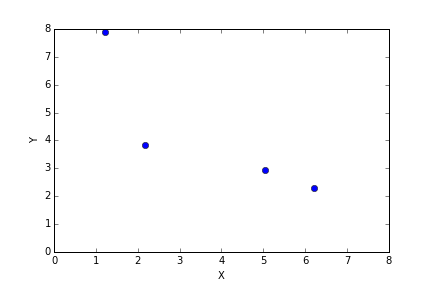
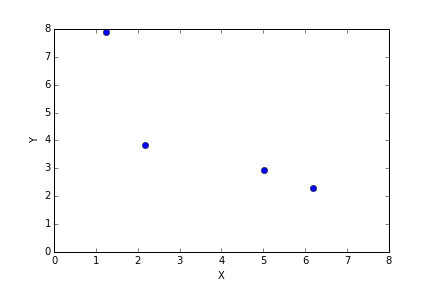
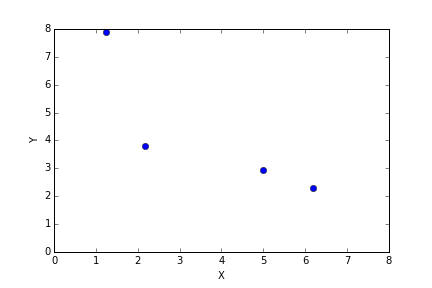
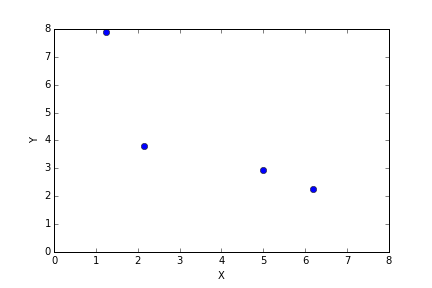
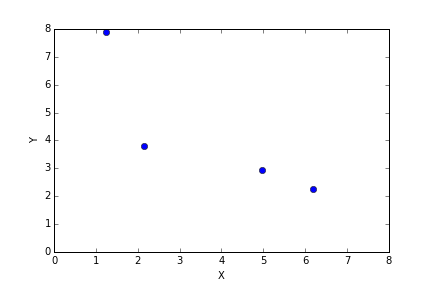
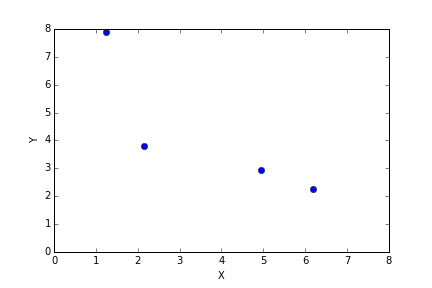
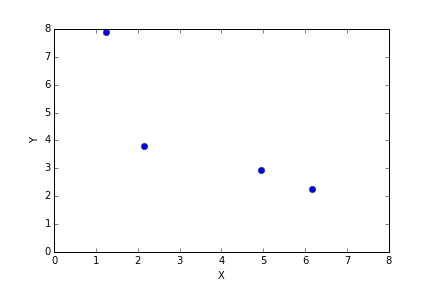
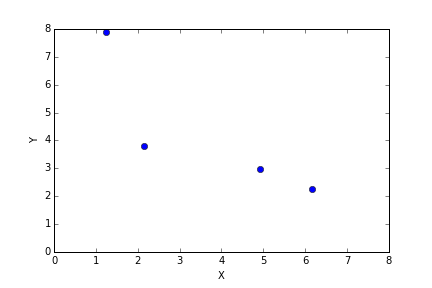
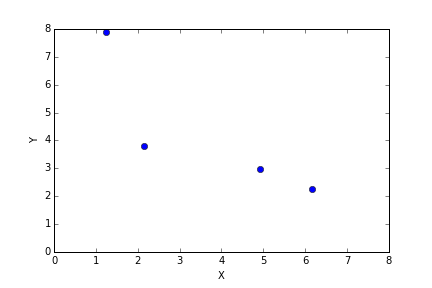
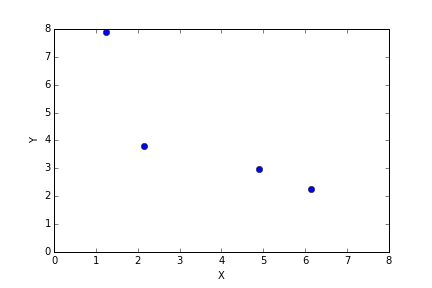
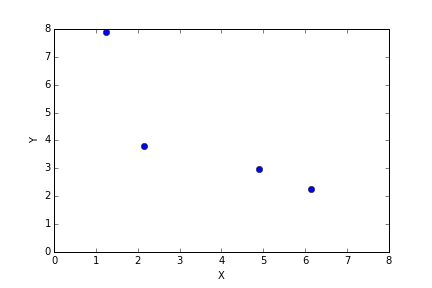
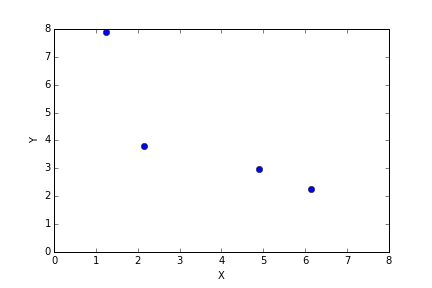
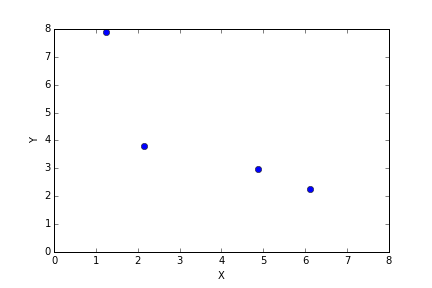
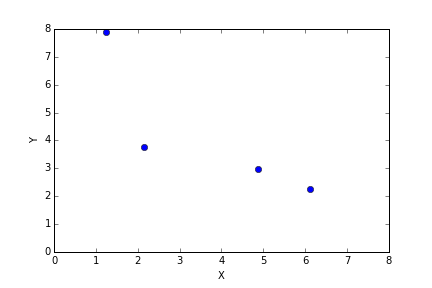
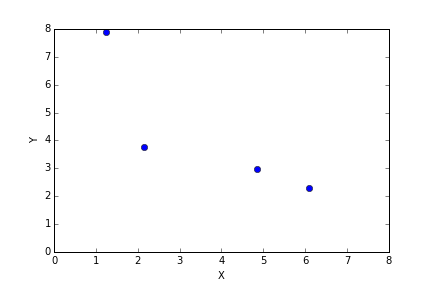
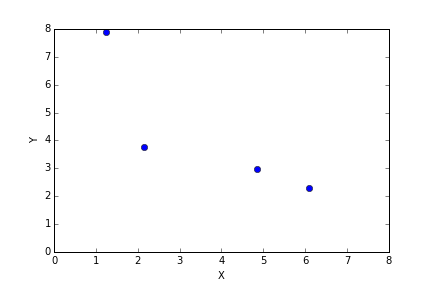
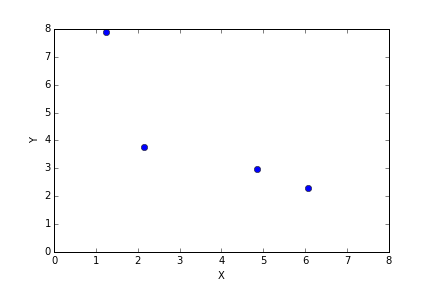
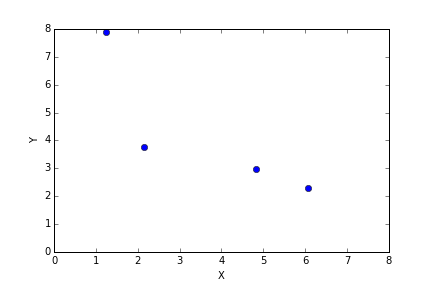
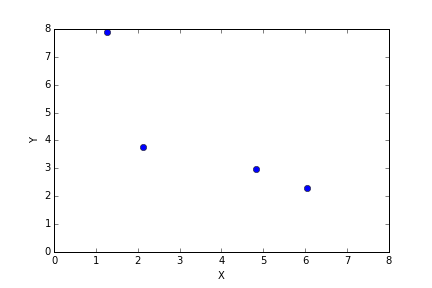
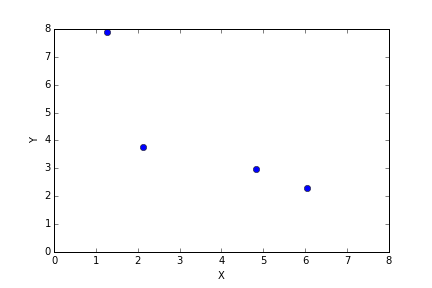
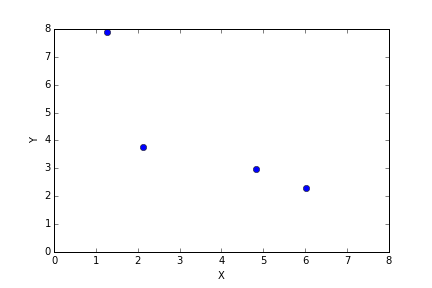
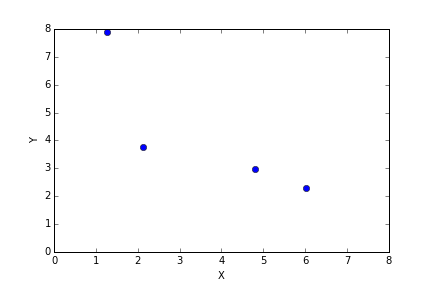
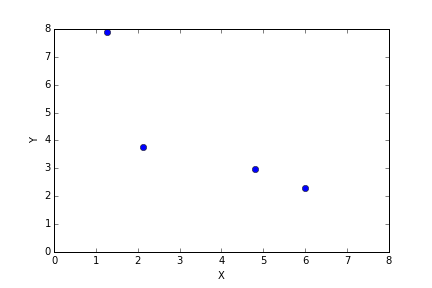
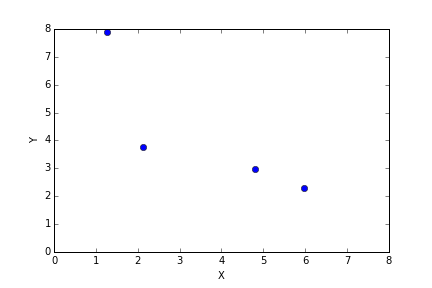
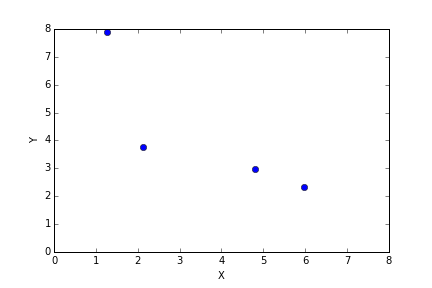
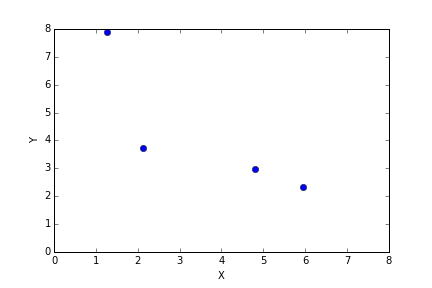
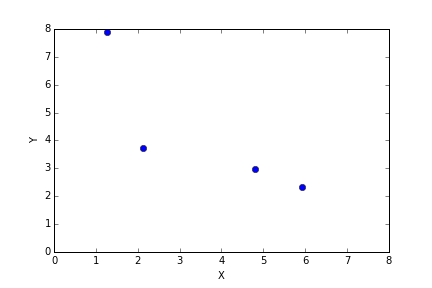
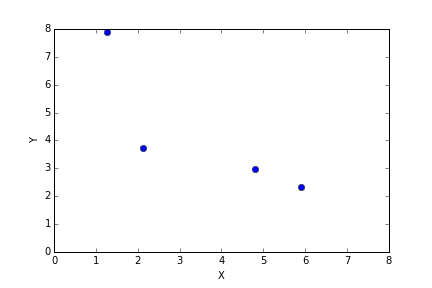
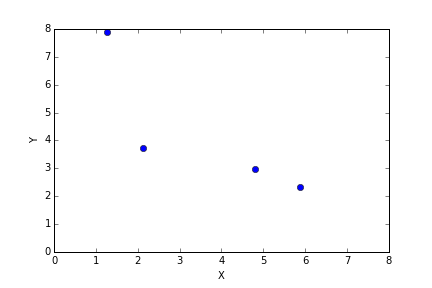
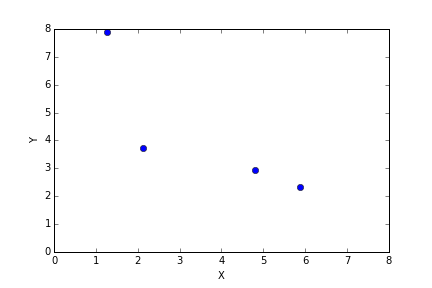
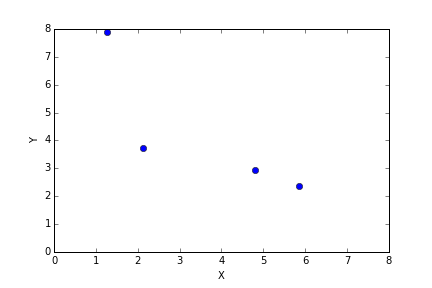
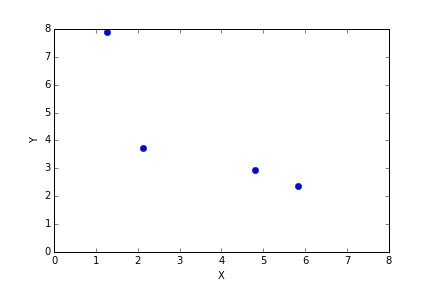
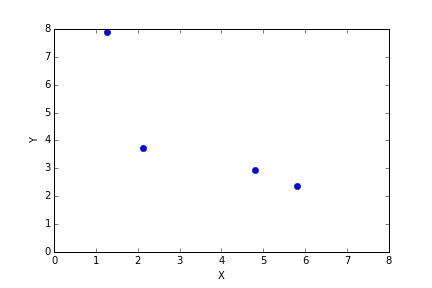
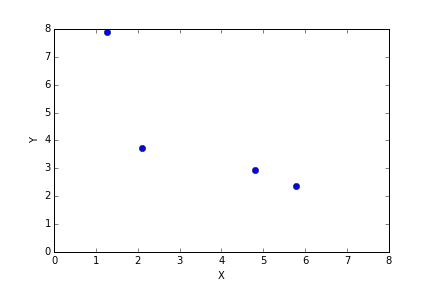
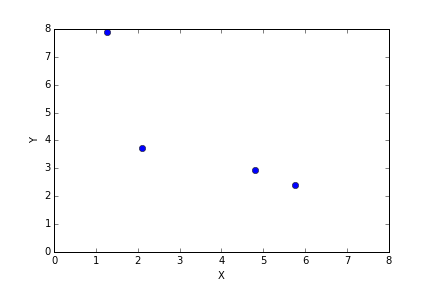
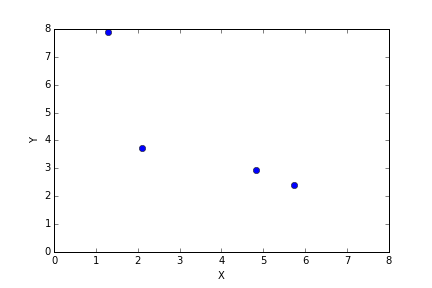
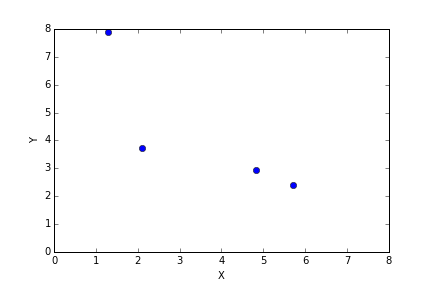
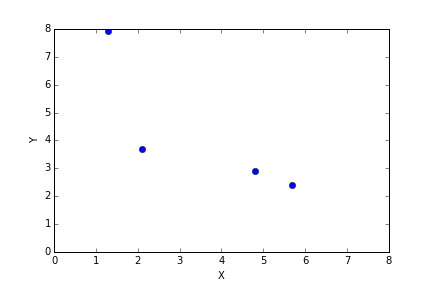
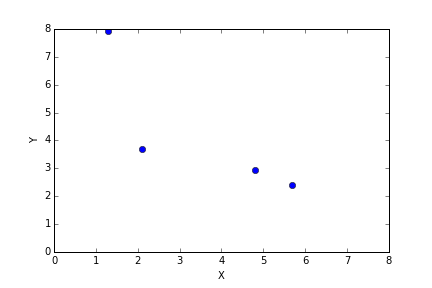
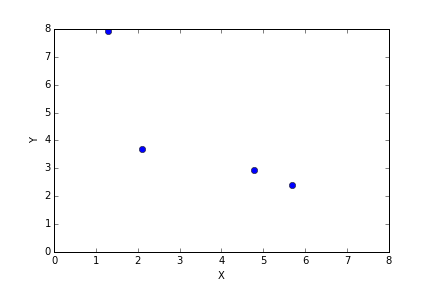
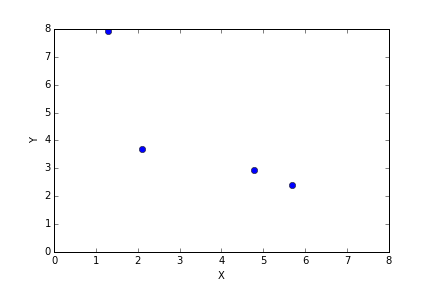
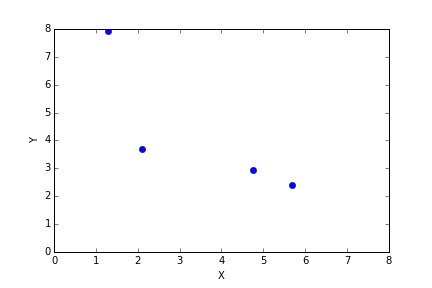
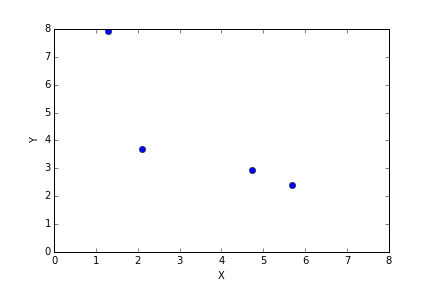
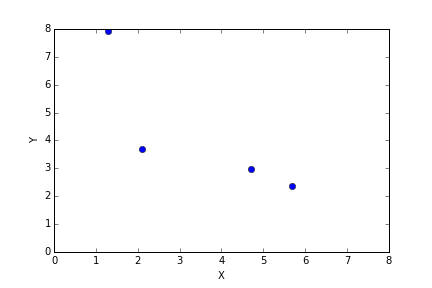
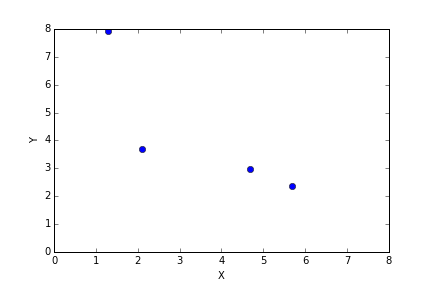
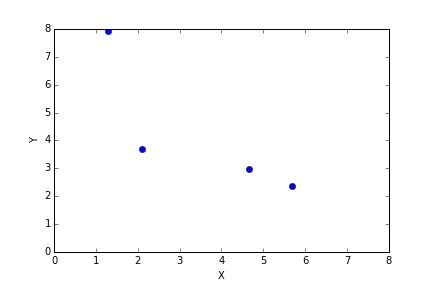
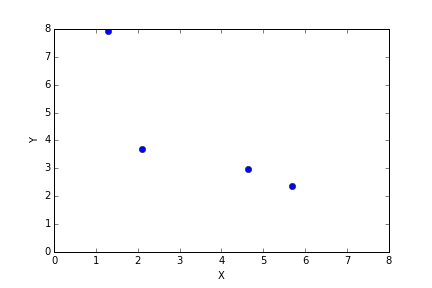
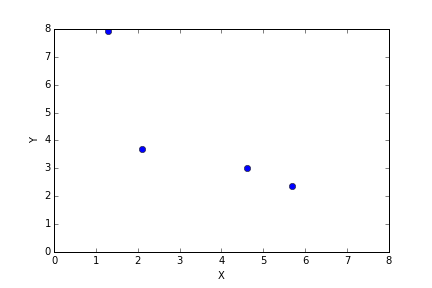
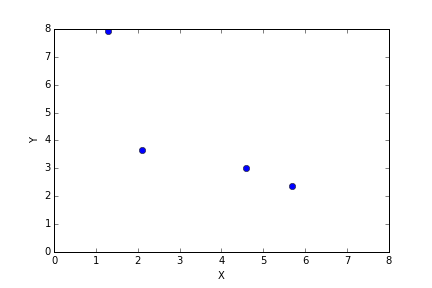
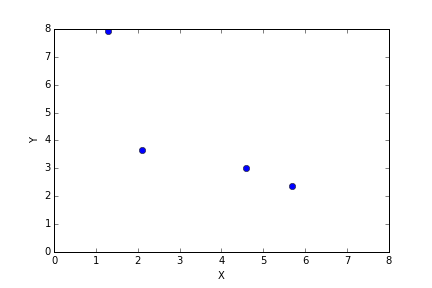
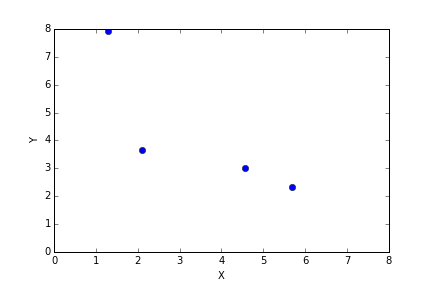
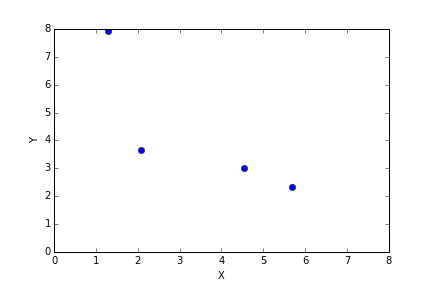
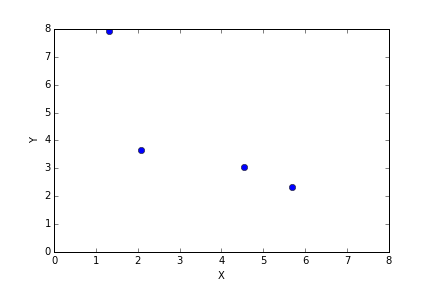
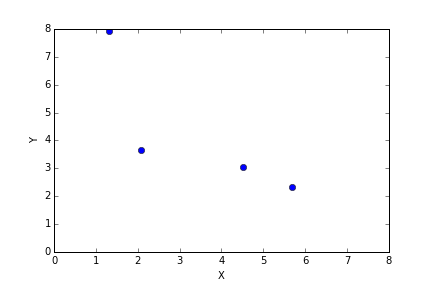
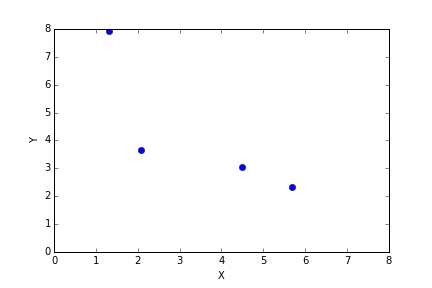
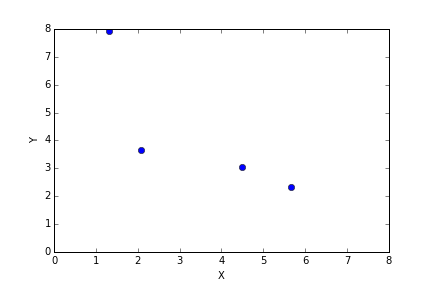
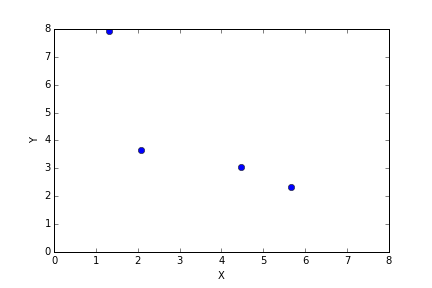
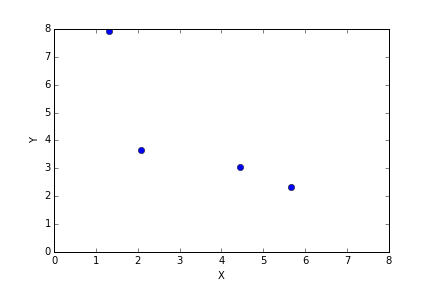
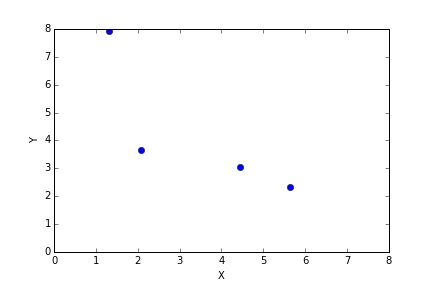
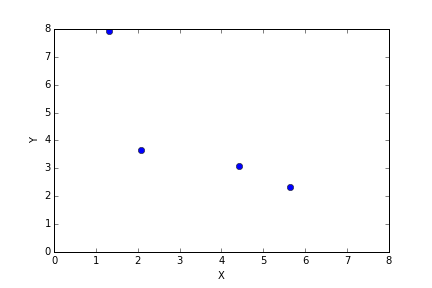
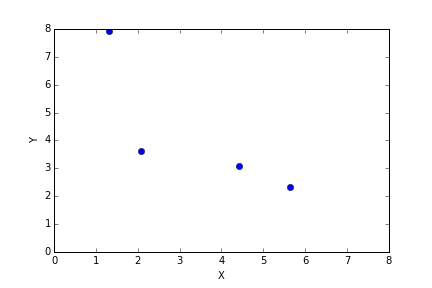
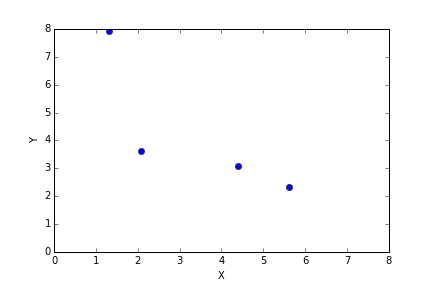
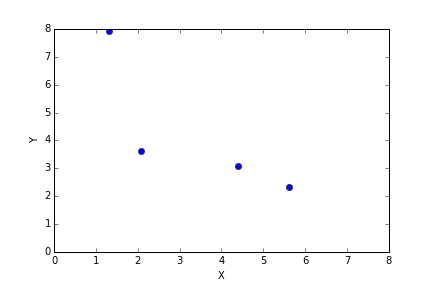
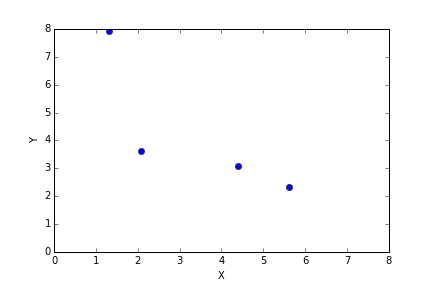
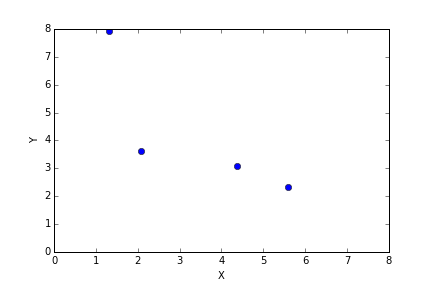
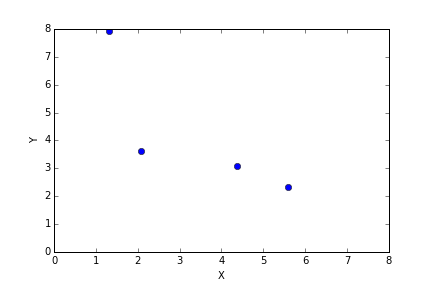
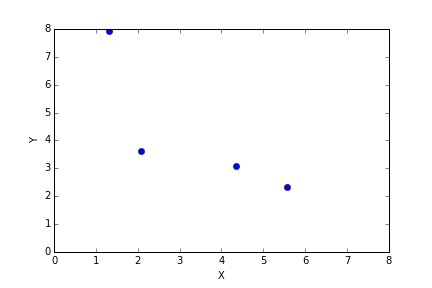
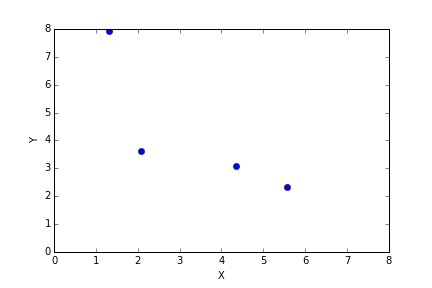
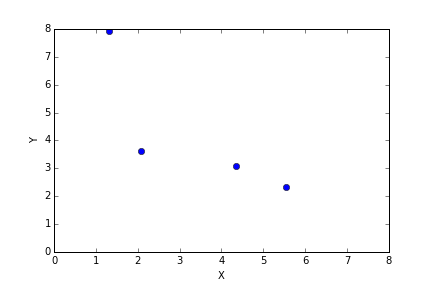
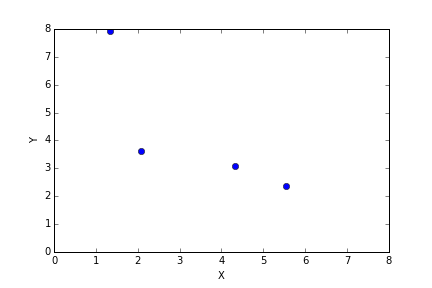
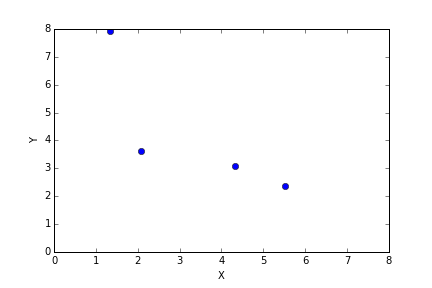
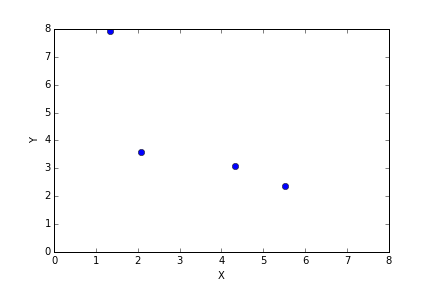
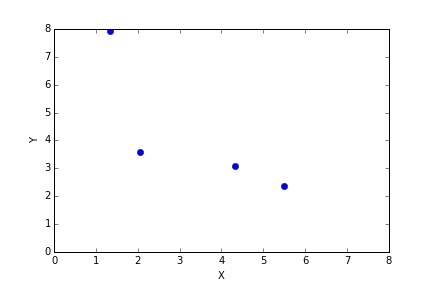
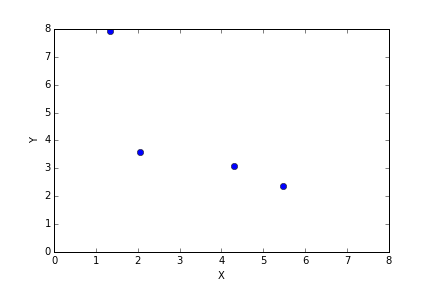
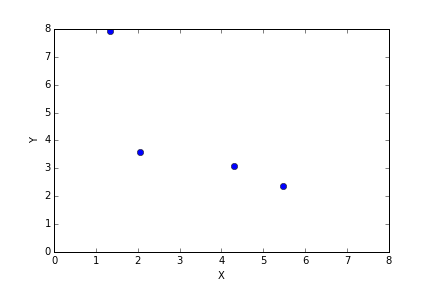
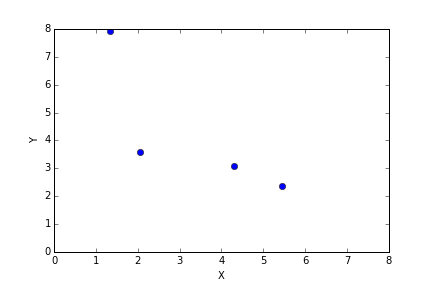
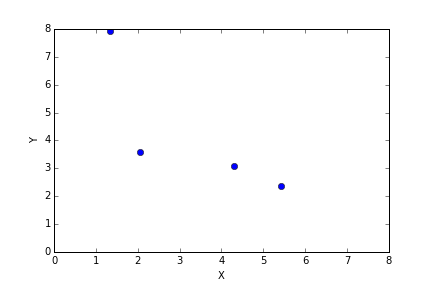
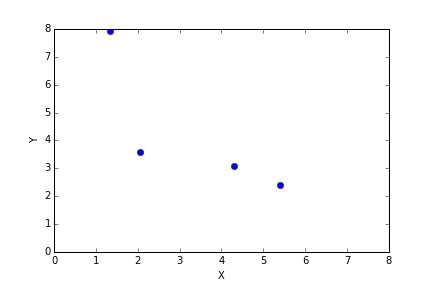
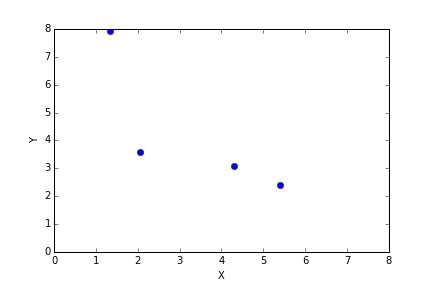
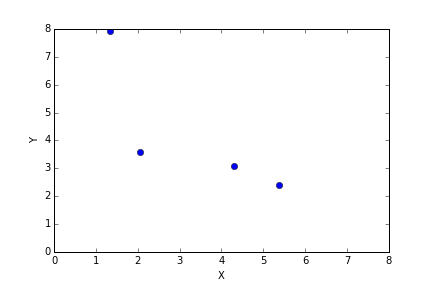
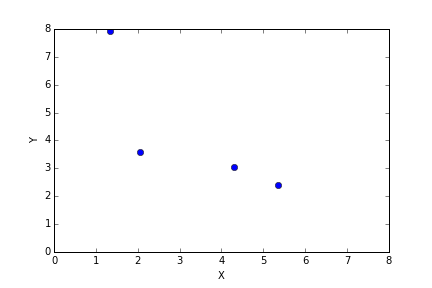
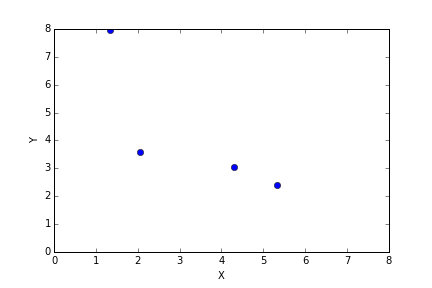
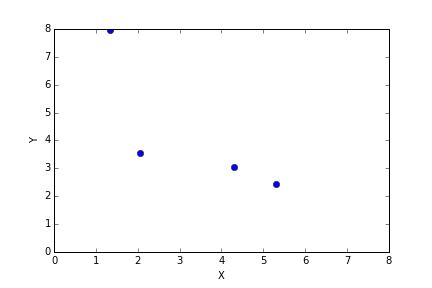
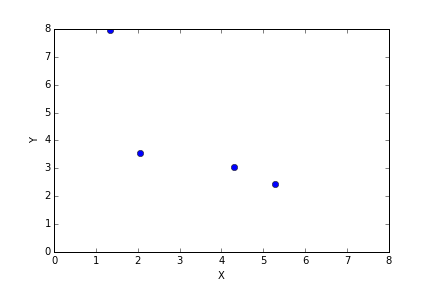
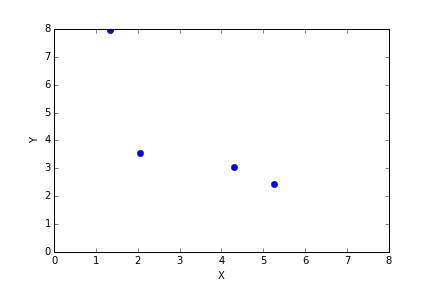
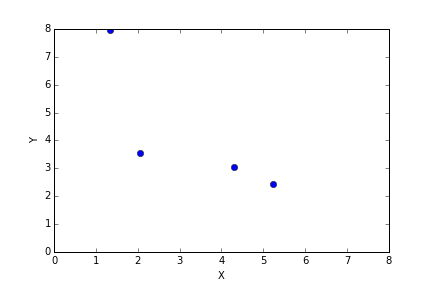
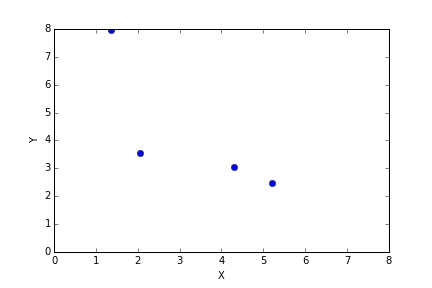
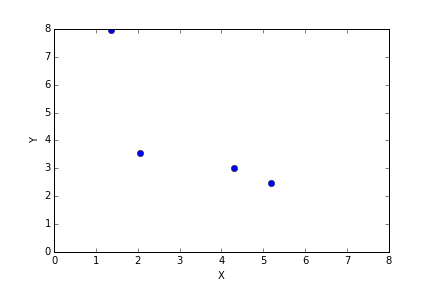
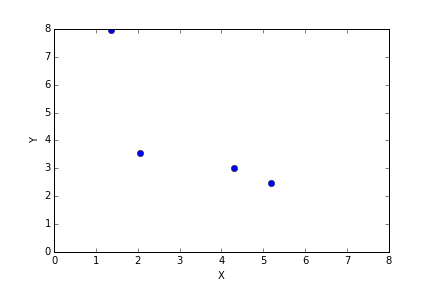
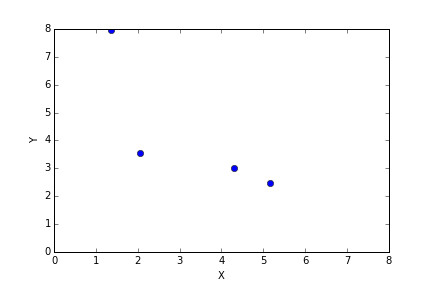
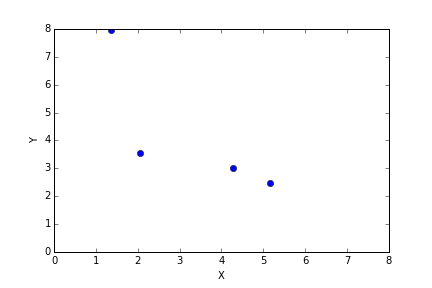
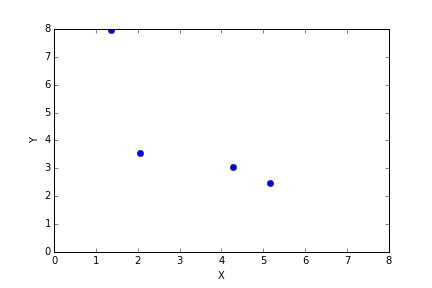
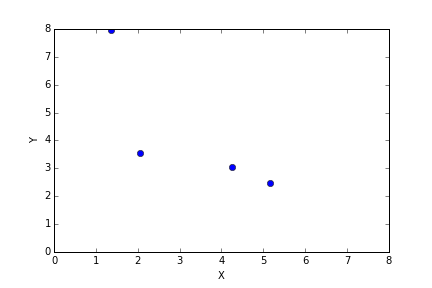
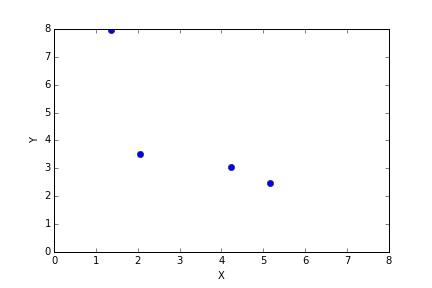
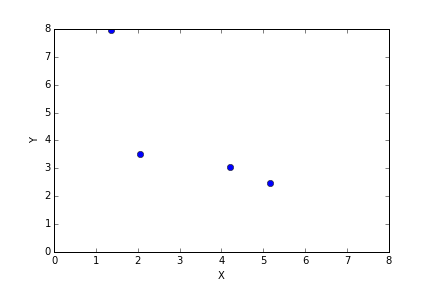
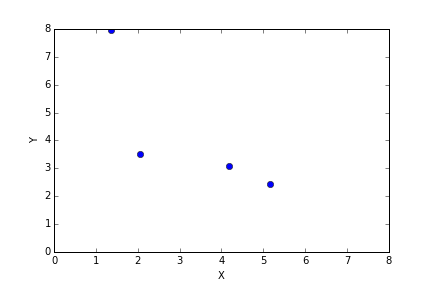
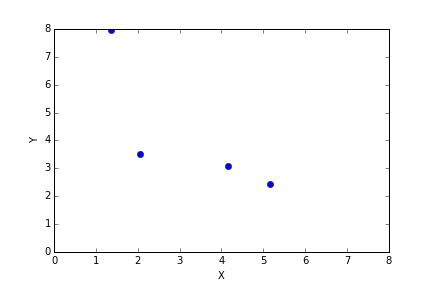
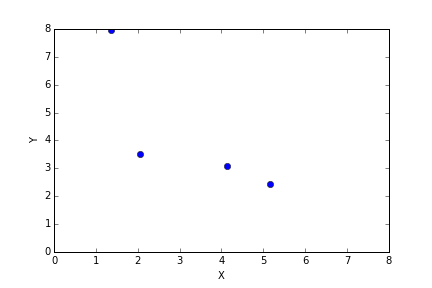
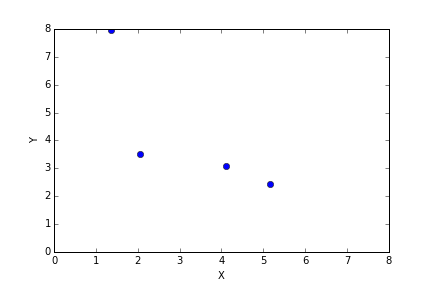
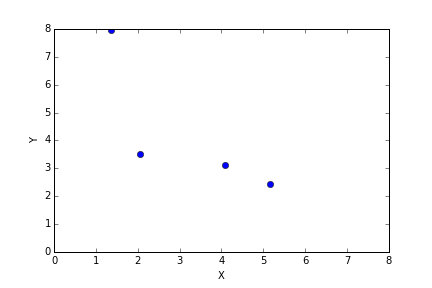
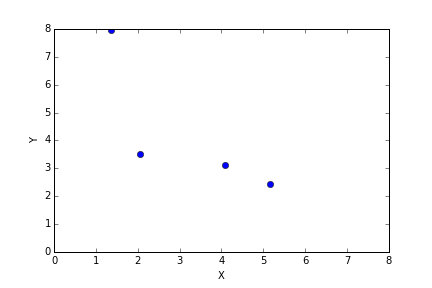
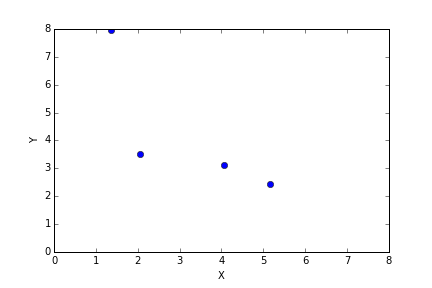
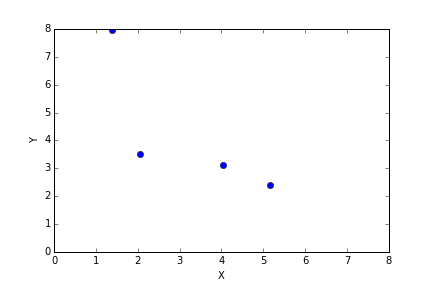
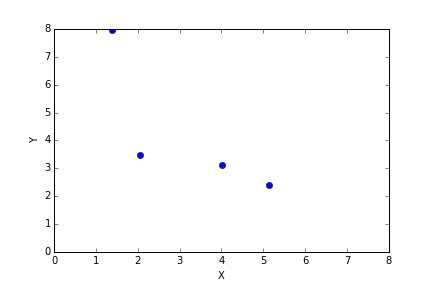
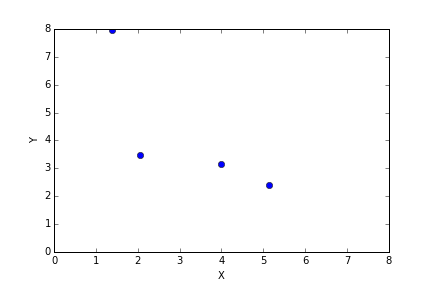
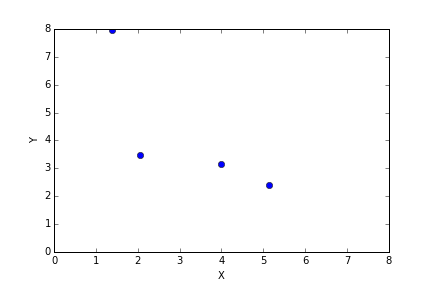
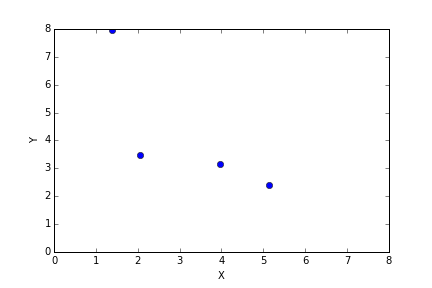
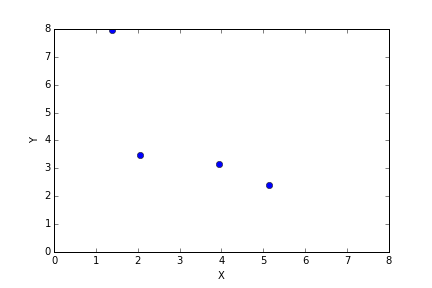
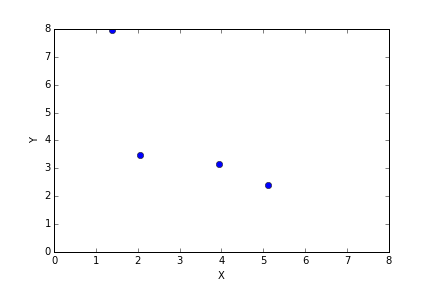
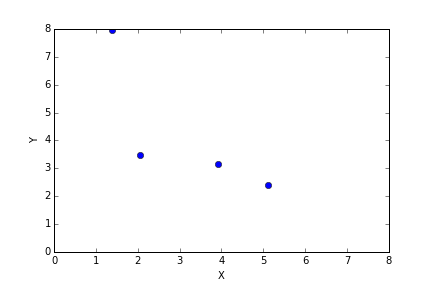
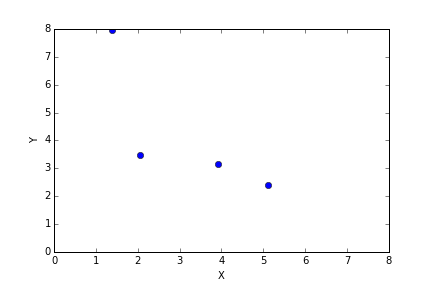
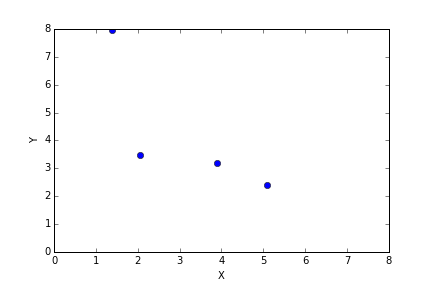
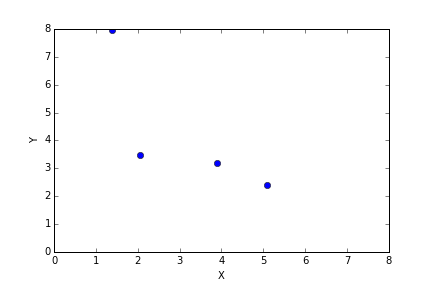
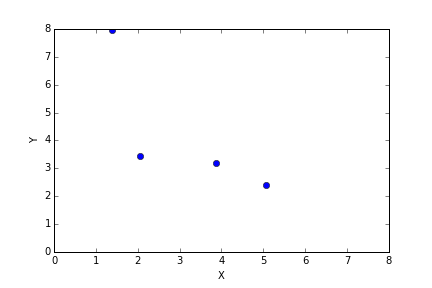
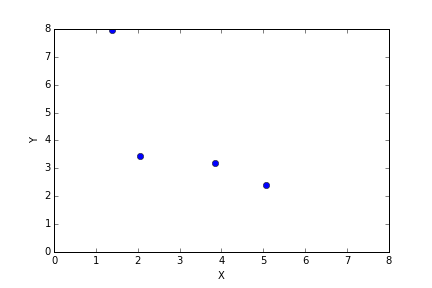
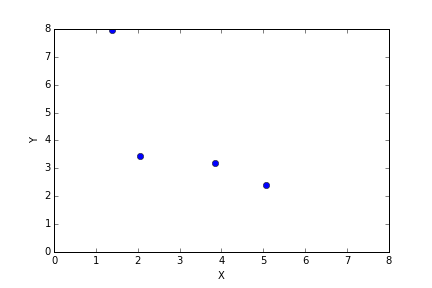
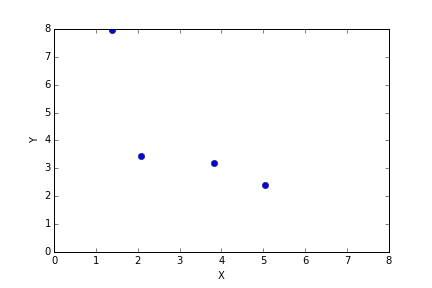
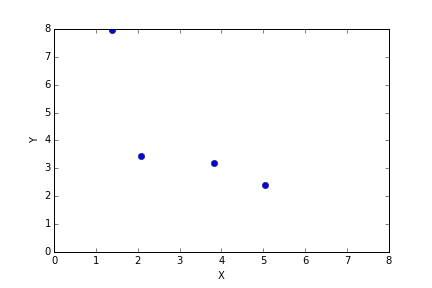
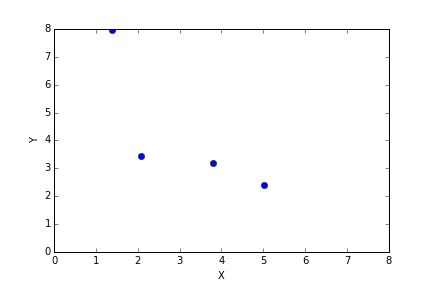
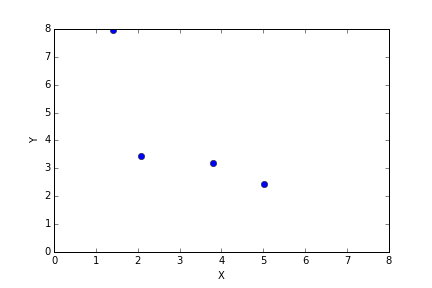
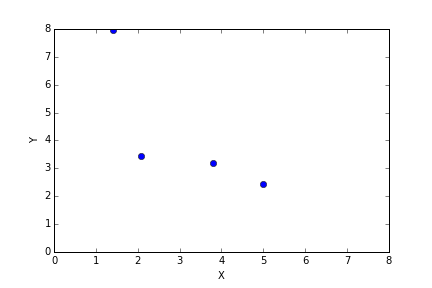
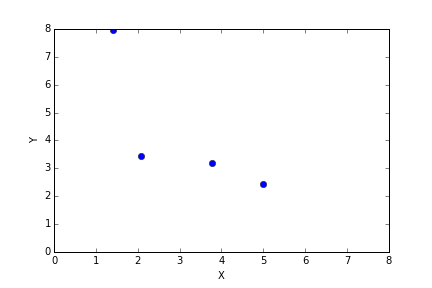
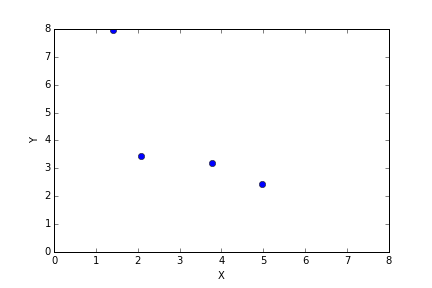
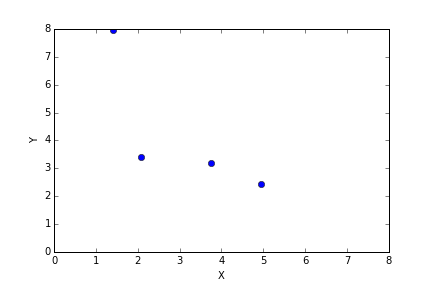
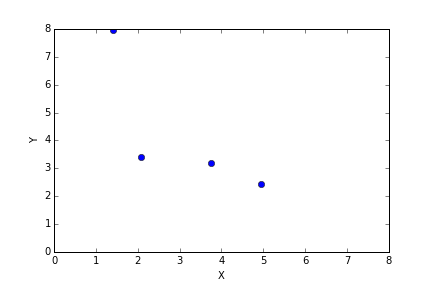
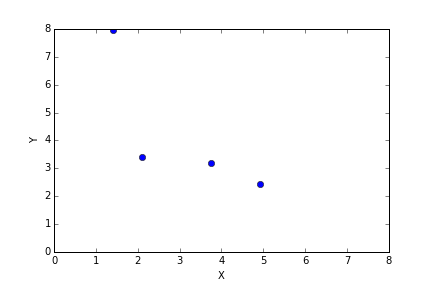
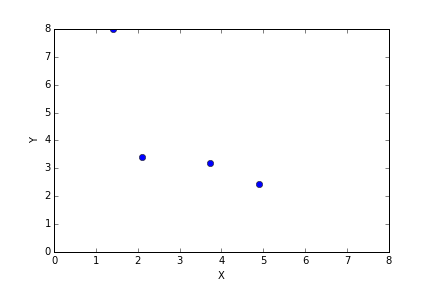
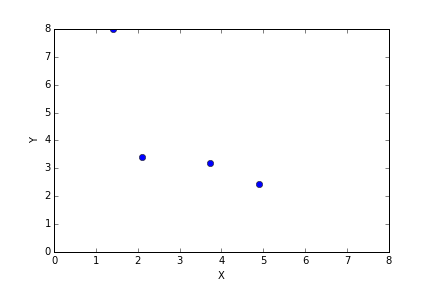
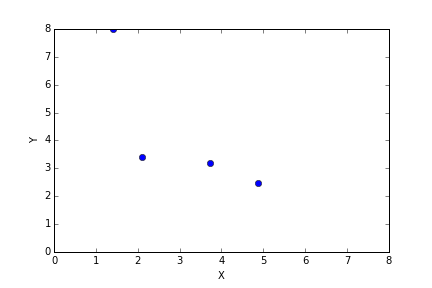
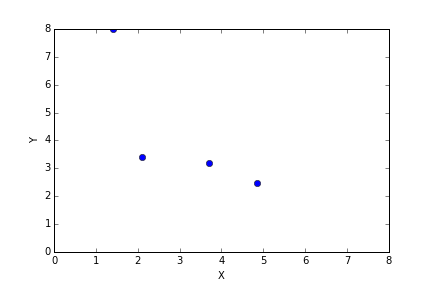
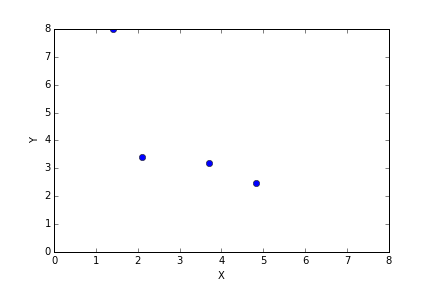
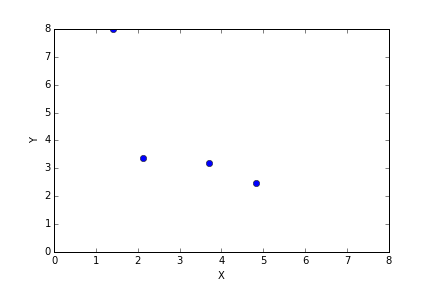
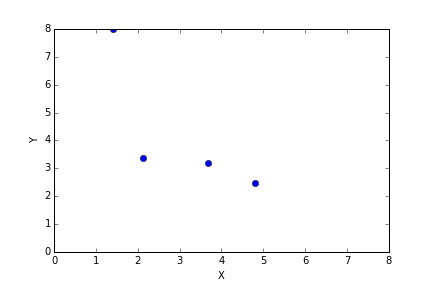
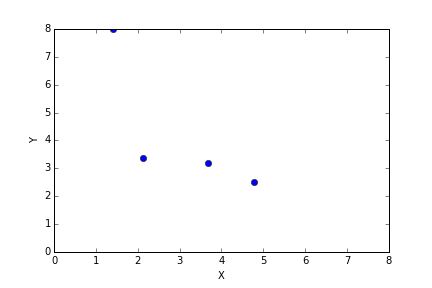
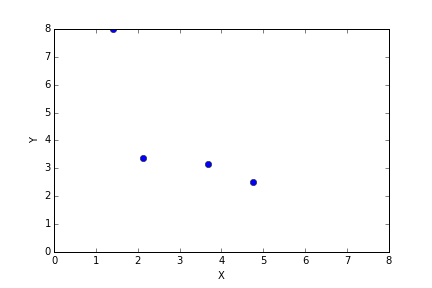
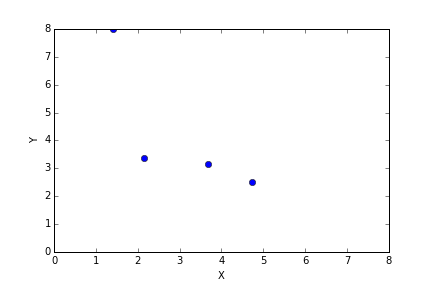
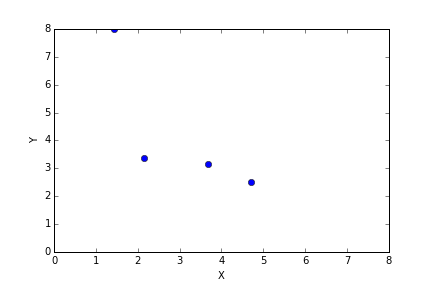
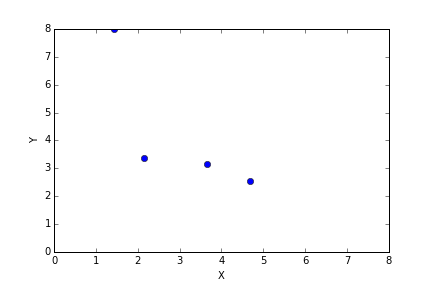
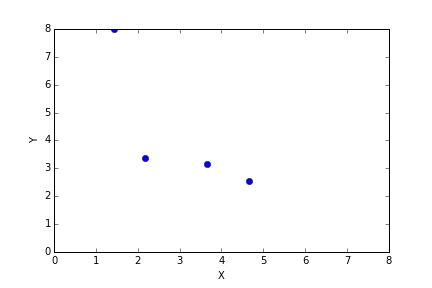
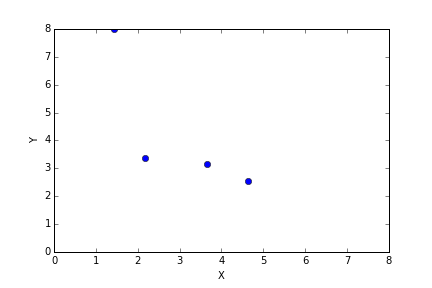
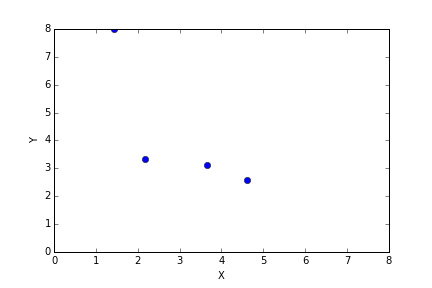
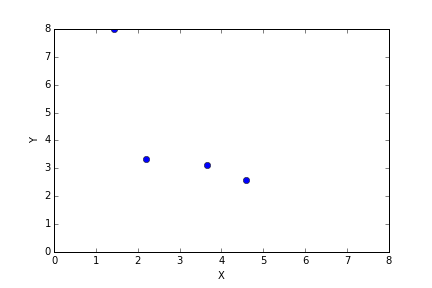
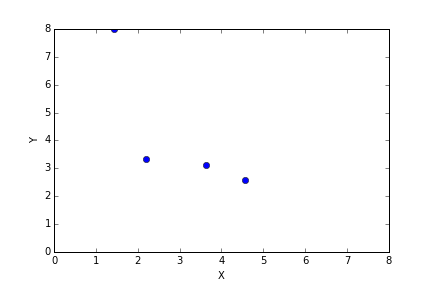
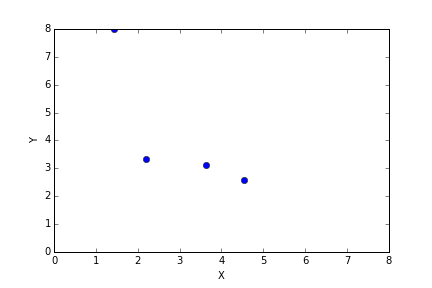
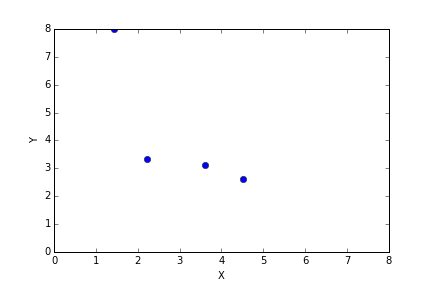
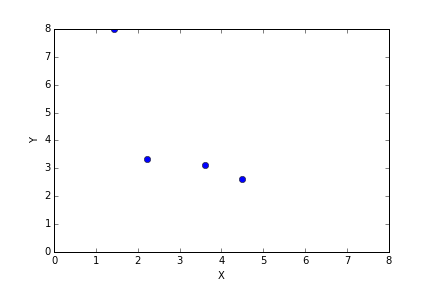
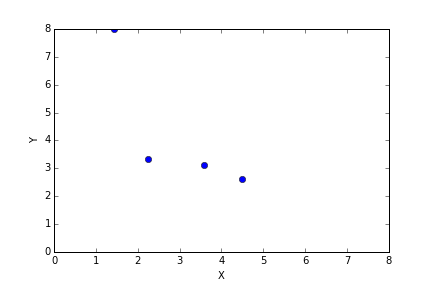
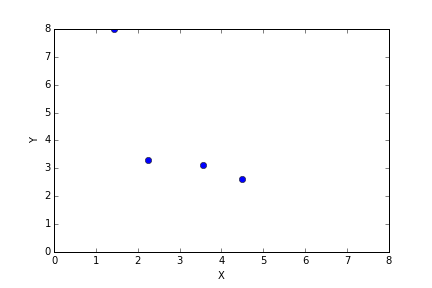
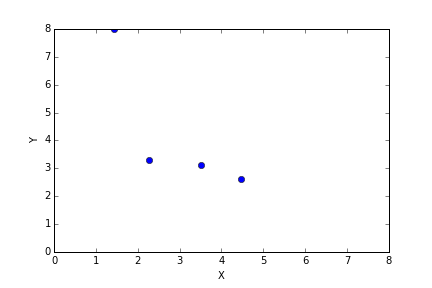

In [32]:
lx = 8
ly = 8
N = 12
dt = 0.02
v0 = 1

S = MDsystem(lx, ly, N, dt, BoundaryCondition.RBC)
S.init(StartConf.Confined, v0)

x = np.zeros(N)
y = np.zeros(N)


fig = pyplot.figure()
ax = pyplot.axes(xlim=(0, lx), ylim=(0, ly), xlabel='X', ylabel='Y')
points, = ax.plot([], [], marker='o', linestyle='None')

def animate(i):
    S.evolve()
    for n in range(S.N):
        p = S.particles[n]
        x[n] = p.x
        y[n] = p.y
    points.set_data(x, y)
    return points


anim = animation.FuncAnimation(fig, animate, frames = 1000, interval=100, blit=True)

display_animation(anim, default_mode='once')

## Exercise 4.2 (Challenge 4.1)

The Average is:
4.205


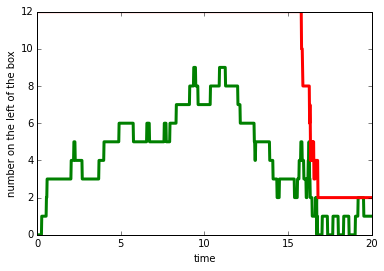

In [33]:
lx = 10
ly = 10
N = 12
dt = 0.02
v0 = 1.
nsteps=1000

S = MDsystem(lx, ly, N, dt, BoundaryCondition.RBC)
S.init(StartConf.Confined, v0)

#print S.KE
#print S.PE

t = np.zeros(nsteps)
nL = np.zeros(nsteps)
ntotal=np.zeros(nsteps)
nLsum=0

for i in range(0,nsteps):
    S.evolve()
    t[i]=i*dt
    nL[i]=S.NumInArea(0., ly, lx/2, lx)
    nLsum += nL[i]
    ntotal[i]=S.NumInArea(0., ly, 0, lx)
    #print "new step"
    
    
print "The Average is:"
print nLsum/nsteps
    
pyplot.plot(t, nL, color='green', ls='-', lw=3)
pyplot.plot(t, ntotal, color='red', ls='-', lw=3)

pyplot.xlabel('time')
pyplot.ylabel('number on the left of the box');

I have written multiple versions of this program and I have not been able to find a way to keep all the particles in the box at large time scales. I beleive this to be the result of a rounding error but nothing I have tried (including writing the whole program from scatch) has let me fix it. 

You can see the sudden loss of particles from the sides of the box by following the red line graphed above. Running the animation above makes it clear that this is a problem in the initialization function that was provided for us.  

## Exercise 4.3 (Challenge 4.2)

In [114]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation
from JSAnimation.IPython_display import display_animation
import math
import itertools as itool

class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)
    
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half  


class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc): 
        self.N = N
        self.lx = ly
        self.ly = lx
        self.dt = dt
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5
        self.bc = bc
        #self.k=1.38064852*10**-23
        self.k=1.
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2()) # we create a list of N particles

    def init(self, config, vmax):
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(N*float(self.ly)/float(self.lx)));
        ncols = int(math.sqrt(N*float(self.lx)/float(self.ly)));
        ax = float(lx) / float(ncols);
        ay = float(ly) / float(nrows);
        i = 0;

        if config == StartConf.Triangular:
            #Challenge
            return
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2
                self.particles[i].y = row*ay+ay/2
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax/2.+ax/2.
                self.particles[i].y = row*ay/2.+ay/2.
                i+=1
                
        elif config == StartConf.Confined:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax+ax/2.)/2.
                self.particles[i].y = (row*ay+ay/2.)
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = (col*ax/2.+ax/2.)/2.
                self.particles[i].y = (row*ay/2.+ay/2.)
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(seld.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;
            
        self.forces()          
        
    def evolve(self):
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)

        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):
        dx = other.x - p.x;
        dy = other.y - p.y;
        # nearest image convention
        if self.bc == BoundaryCondition.PBC:
            if abs(dx) > self.lx/2:
                dx -= dx*lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*ly/abs(dy)
        
        r12 = dx * dx + dy * dy
        return (r12, dx, dy)

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)
        r2 = 1./r12
        r6 = r2 * r2 * r2
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly
#            c = (p.x+2*self.lx)/self.lx
#            p.x = p.x + 2*self.lx - int(c)*self.lx
#            c = (p.y+2*self.ly)/self.ly
#            p.y = p.y + 2*self.ly - int(c)*self.ly
            
    def Calc_KE(self):
        ke=0.
        for p in self.particles:
            ke +=.5*p.mass*(p.vx**2+p.vy**2)
        return ke
    
    def Calc_PE(self):
        pe = 0. #assuming Lenard-Jones
        #for p1 in self.particles:
            #for p2 in self.particles:
        for i in range(self.N):
            p1=self.particles[i]
            for j in range(i+1, self.N):
                p2=self.particles[j]
                (r12,dx,dy) = self.distance2(p1, p2)
                if (r12!=0.):
                    u2 = 1./r12
                    u6 = u2 * u2 * u2
                    pe += 4.*u6*(1-u6)
        return pe
    
    
    def total_energy(self):
        return self.Calc_PE() + self.Calc_KE()
    
    def EquilibAndScale(self, nequilib, Tnew):
        for i in range(nequilib):
            self.evolve()
        self.scaleV(Tnew)
    
    def averageKEandV2(self):
        totalv2=0.
        for p in self.particles:
            totalv2=p.vx**2 + p.vy**2
        totalKE=self.Calc_KE()
        return (totalKE/self.N, totalv2/self.N)
    
    def scaleV(self, Tnew):
        Told=self.Calc_T()
        factor=Tnew/Told
        factorsqrt=math.sqrt(factor)
        for p in self.particles:
            p.vx=p.vx*factorsqrt
            p.vy=p.vy*factorsqrt

    
    def Calc_T(self):
        (AveKE, AveV2)=self.averageKEandV2()
        return (2./3.)*AveKE/self.k
        
    
    def NumInArea(self, ymin, ymax, xmin, xmax):
        count=0
        for p in self.particles:
            #print p.y
            #print p.x
            if p.y>ymin and p.y<ymax:
                if p.x>xmin and p.x<xmax:
                    count=count+1
                   
        return count
        


In [170]:
lx = 10
ly = 10
N = 12
dt = 0.01
v0 = 1.
Tnew=4.
nsteps=1000
nequilib=100
naveraged=5


S = MDsystem(lx, ly, N, dt, BoundaryCondition.RBC)
S.init(StartConf.Confined, v0)
for i in range(0,6):
    S.EquilibAndScale(nequilib, Tnew)
    Tprime=S.Calc_T()
    if int(Tprime)==int(Tnew):
        print "Successfully scaled"
    if S.N != S.NumInArea(0, ly, 0, lx):
        print "error: particles escaping"

t = np.zeros(nsteps)
Temps=np.zeros(nsteps)
tforAve=np.zeros(nsteps/naveraged-1)
AveTemps=np.zeros(nsteps/naveraged-1)
KEs=np.zeros(nsteps)
PEs=np.zeros(nsteps)
Es=np.zeros(nsteps)

for i in range(0,nsteps):
    t[i]=i*dt
    Temps[i]=S.Calc_T()
    KEs[i]=S.Calc_KE()
    PEs[i]=S.Calc_PE()
    Es[i]=S.total_energy()
    if i!=0 and i%naveraged==0:
        TotalTemp=0.
        Totalt=0.
        #for j in (0,naveraged):
        j=0
        while j<naveraged:
            x=int(i-j)
            TotalTemp+=Temps[x]
            Totalt+=(i-j)*dt
            j+=1
        AveTemps[i/naveraged -1]=TotalTemp/naveraged
        tforAve[i/naveraged -1]=Totalt/naveraged
    S.evolve()
    


Successfully scaled
Successfully scaled
Successfully scaled


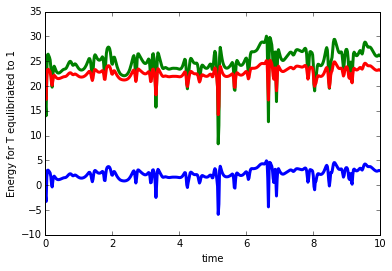

In [136]:
pyplot.plot(t, Es, color='green', ls='-', lw=3)
pyplot.plot(t, KEs, color='red', ls='-', lw=3)
pyplot.plot(t, PEs, color='blue', ls='-', lw=3)

pyplot.xlabel('time')
pyplot.ylabel('Energy for T equlibriated to 1');

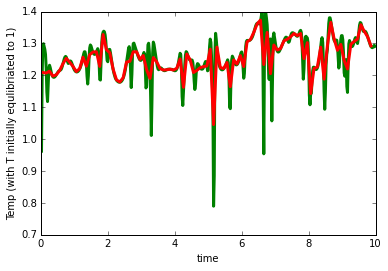

In [137]:
pyplot.plot(t, Temps, color='green', ls='-', lw=3)
pyplot.plot(tforAve, AveTemps, color='red', ls='-', lw=3)


pyplot.xlabel('time')
pyplot.ylabel('Temp (with T initially equlibriated to 1)');


Next, rather than constructing a for loop around the above program I am going to just re run it with slightly different values and construct new graphs. 


### with T=2 :

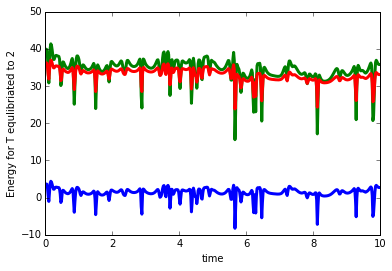

In [142]:
pyplot.plot(t, Es, color='green', ls='-', lw=3)
pyplot.plot(t, KEs, color='red', ls='-', lw=3)
pyplot.plot(t, PEs, color='blue', ls='-', lw=3)

pyplot.xlabel('time')
pyplot.ylabel('Energy for T equilibrated to 2');

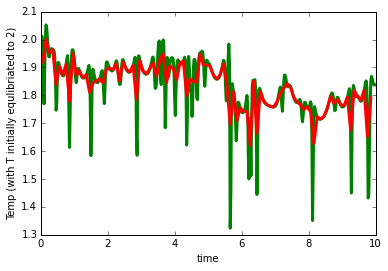

In [141]:
pyplot.plot(t, Temps, color='green', ls='-', lw=3)
pyplot.plot(tforAve, AveTemps, color='red', ls='-', lw=3)


pyplot.xlabel('time')
pyplot.ylabel('Temp (with T initially equilibrated to 2)');

### With T=4 :

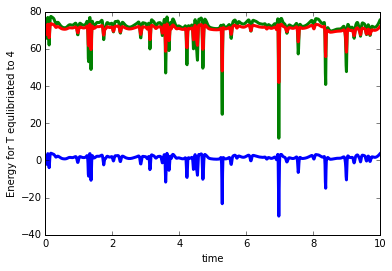

In [171]:
pyplot.plot(t, Es, color='green', ls='-', lw=3)
pyplot.plot(t, KEs, color='red', ls='-', lw=3)
pyplot.plot(t, PEs, color='blue', ls='-', lw=3)

pyplot.xlabel('time')
pyplot.ylabel('Energy for T equilibrated to 4');


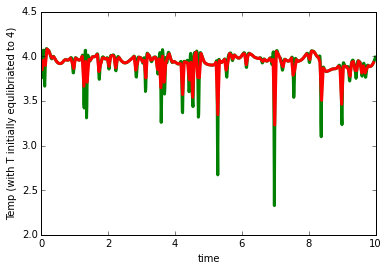

In [172]:
pyplot.plot(t, Temps, color='green', ls='-', lw=3)
pyplot.plot(tforAve, AveTemps, color='red', ls='-', lw=3)


pyplot.xlabel('time')
pyplot.ylabel('Temp (with T initially equilibrated to 4)');

Please note, for the graphs here I had to change from dt=.02 with nsteps=500 (used in the T=1 and T=2) graphs to, dt=.01 and nsteps=1000 in the T=4 graph. This was neccessary because with the larger dt, the some of the particles in the T=4 simulation were subject to the same bug mentioned above; their position values went far beyond the confines of the box and their velocities went out of control very suddenly at large times. 

However, from the data that we do have we can say that the fluctuations seem to die off as a function of T. The T=1 simulation experienced a 30% increase in T over its course. While the T=4 simulation stayed much more constant. 